In [1]:
import os
import sys
train_done = True
study_id = 'original'
write_in_file = False

data_ = 'TransMut'

data_dir = '/home/s202357/thesis/transmut/data/transmut_github/'
model_folder = '/home/s202357/thesis/transmut/pipeline/{}/models/'.format(study_id)
result_folder = '/home/s202357/thesis/transmut/pipeline/{}/results/'.format(study_id)

In [2]:
!gpustat

iapetus                        Thu May 19 16:24:01 2022  470.103.01
[0] NVIDIA GeForce GTX 1080 Ti | 54'C,  27 % |  8549 / 11178 MB | jamas(8545M)
[1] NVIDIA GeForce GTX 1080 Ti | 23'C,   0 % | 10853 / 11178 MB | ramadev(10849M)
[2] NVIDIA GeForce GTX 1080 Ti | 59'C,  20 % |  8189 / 11178 MB | jamas(8185M)
[3] NVIDIA GeForce GTX 1080 Ti | 25'C,   0 % |     1 / 11178 MB |
[4] NVIDIA GeForce GTX 1080 Ti | 22'C,   0 % | 10853 / 11178 MB | ramadev(10849M)
[5] NVIDIA GeForce GTX 1080 Ti | 64'C,  56 % |  2111 / 11178 MB | s202357(2107M)
[6] NVIDIA GeForce GTX 1080 Ti | 36'C,   7 % |  1757 / 11178 MB | dika(1753M)
[7] NVIDIA GeForce GTX 1080 Ti | 20'C,   0 % |     1 / 11178 MB |


In [3]:
os.environ['CUDA_VISIBLE_DEVICES']='3'

In [4]:
import math
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
import datetime
import random
random.seed(1234)

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from functools import reduce
from tqdm import tqdm, trange
import seaborn as sn
from copy import deepcopy
from scipy import spatial

from IPython.display import HTML
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

import gc
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data


In [5]:
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/functions')
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/architecture')

import functions as fnc
from model_components import *

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
    print('There are %d GPU(s) avalable.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) avalable.


In [7]:
seed = 19961231
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [8]:
chart = [
[   ['100p', 'EmbeddingAttentionEncoder', 20],
    ['75p', 'EmbeddingAttentionEncoder', 20]]  
]

blosum_dict = {
'A' : [5,-2,-1,-2,-1,-1,-1,0,-2,-1,-2,-1,-1,-3,-1,1,0,-3,-2,0],
'R' : [-2,7,-1,-2,-4,1,0,-3,0,-4,-3,3,-2,-3,-3,-1,-1,-3,-1,-3],
'N' : [-1,-1,7,2,-2,0,0,0,1,-3,-4,0,-2,-4,-2,1,0,-4,-2,-3],
'D' : [-2,-2,2,8,-4,0,2,-1,-1,-4,-4,-1,-4,-5,-1,0,-1,-5,-3,-4],
'C' : [-1,-4,-2,-4,13,-3,-3,-3,-3,-2,-2,-3,-2,-2,-4,-1,-1,-5,-3,-1],
'Q' : [-1,1,0,0,-3,7,2,-2,1,-3,-2,2,0,-4,-1,0,-1,-1,-1,-3],
'E' : [-1,0,0,2,-3,2,6,-3,0,-4,-3,1,-2,-3,-1,-1,-1,-3,-2,-3],
'G' : [0,-3,0,-1,-3,-2,-3,8,-2,-4,-4,-2,-3,-4,-2,0,-2,-3,-3,-4],
'H' : [-2,0,1,-1,-3,1,0,-2,10,-4,-3,0,-1,-1,-2,-1,-2,-3,2,-4],
'I' : [-1,-4,-3,-4,-2,-3,-4,-4,-4,5,2,-3,2,0,-3,-3,-1,-3,-1,4],
'L' : [-2,-3,-4,-4,-2,-2,-3,-4,-3,2,5,-3,3,1,-4,-3,-1,-2,-1,1],
'K' : [-1,3,0,-1,-3,2,1,-2,0,-3,-3,6,-2,-4,-1,0,-1,-3,-2,-3],
'M' : [-1,-2,-2,-4,-2,0,-2,-3,-1,2,3,-2,7,0,-3,-2,-1,-1,0,1],
'F' : [-3,-3,-4,-5,-2,-4,-3,-4,-1,0,1,-4,0,8,-4,-3,-2,1,4,-1],
'P' : [-1,-3,-2,-1,-4,-1,-1,-2,-2,-3,-4,-1,-3,-4,10,-1,-1,-4,-3,-3],
'S' : [1,-1,1,0,-1,0,-1,0,-1,-3,-3,0,-2,-3,-1,5,2,-4,-2,-2],
'T' : [0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,2,5,-3,-2,0],
'W' : [-3,-3,-4,-5,-5,-1,-3,-3,-3,-3,-2,-3,-1,1,-4,-4,-3,15,2,-3],
'Y' : [-2,-1,-2,-3,-3,-1,-2,-3,2,-1,-1,-2,0,4,-3,-2,-2,2,8,-1],
'V' : [0,-3,-3,-4,-1,-3,-3,-4,-4,4,1,-3,1,-1,-3,-2,0,-3,-1,5]
}

size_dict = {'1p':6000,
             '5p':30000,
             '25':150500,
             '50p':301000,
             '75':451500}

for key, val in zip(blosum_dict.keys(), blosum_dict.values()):
    if len(val) != 20:
        print(key +":"+ str(len(val)), end =", ")

In [9]:
cv = 5
count = 0
index_order = []

for outer in range(cv):
        test_idx = outer
        for inner in range(cv):
            if inner!=outer:
                val_idx = inner
                train_index = list()
                for t in range(5):
                    if t!=inner and t!=outer:
                        train_index.append(t)
                count += 1  
                index_order.append([test_idx, val_idx, train_index])
                
index_order_nested = index_order


In [10]:
pep_max_len = 14

d_ff = 512

batch_size = 1024
epochs = 25
threshold = 0.5

vocab = np.load( data_dir + 'Transformer_vocab_dict.npy', allow_pickle = True).item()
vocab_size = len(vocab)

model_info = chart[0][0] #chart[0][2] 
size = model_info[0]   
model_type = model_info[1]
d_model = d_k = d_v = model_info[2]
model_abbr = 'E'

print(size, model_type, d_model)

id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad'
#id_emb = 'OF_TData_pad14_{}_{}_MHC'
id_emb = 'OF_TData_pad14_{}_{}_MHC_50ep'
#id_emb = 'OF_TData_pad14_{}_{}_MHC_100ep'
hla_max_len = 180
n_layers, n_heads = 1, 3


#34
#id_emb = 'OF_TData_pad14_{}_{}'
#hla_max_len = 34

tgt_len = pep_max_len + hla_max_len


save_attn = False
save_attn_hla = True

100p EmbeddingAttentionEncoder 20


SET PARAMETERS AND MODEL TO GET FIGURES

In [11]:
def data_with_loader_unique(data_dir, model_type, MHC, pep_max_len, hla_max_len, vocab, index_order_idx, type_ = 'train', fold = None,  batch_size = 1024):
        
    pep_inputs = []
    hla_inputs = []
    labels = []

    data = pd.read_csv(data_dir + 'upd_{}_mhc.csv'.format(fold), index_col = 0).drop_duplicates()
    #data = pd.read_csv(data_dir + 'upd_{}_d.csv'.format(fold), index_col = 0).drop_duplicates()
    
    data = data[data['HLA']==MHC]

    if "blosum" in model_type.lower():
        pep_inputs, hla_inputs = make_data_bl(data, pep_max_len, hla_max_len)
        pep_to_pad = make_data_padding(data.peptide)
        labels = torch.LongTensor( [x for x in data.label] ).to(device)
        loader = Data.DataLoader(MyDataSet(pep_inputs, hla_inputs, pep_to_pad, labels), batch_size, shuffle = False, num_workers = 0)    
    else:
        pep_inputs, hla_inputs, labels = fnc.make_data_emb(data, pep_max_len, hla_max_len, vocab)
        loader = Data.DataLoader(MyDataSet(pep_inputs, hla_inputs, pep_inputs, labels), batch_size, shuffle = False, num_workers = 0)
  
    #print("\tTest File ID", fold, len(pep_inputs), np.shape(pep_inputs))

    return data, pep_inputs, hla_inputs, labels, loader

if "Blosum" in model_type:
            id_nested = id_blosum.format(size, model_type)  
            encoding_ = 'blosum'
            
            class EncoderLayer(nn.Module):
                def __init__(self):
                    super(EncoderLayer, self).__init__()
                    self.enc_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                    self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                def forward(self, enc_inputs, enc_self_attn_mask):
                    '''
                    enc_inputs: [batch_size, src_len, d_model]
                    enc_self_attn_mask: [batch_size, src_len, src_len]
                    '''
                    # enc_outputs: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
                    enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
                    enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
                    return enc_outputs, attn


            class Encoder(nn.Module):
                def __init__(self):
                    super(Encoder, self).__init__()
                    #B#self.src_emb = nn.Embedding(vocab_size, d_model)
                    self.pos_emb = PositionalEncoding(d_model)
                    self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

                def forward(self, enc_inputs, pep_to_pad):
                    '''
                    enc_inputs: [batch_size, src_len]
                    '''
                    #B# enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
                    enc_outputs = self.pos_emb(enc_inputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]

                    #reduce((lambda x, y: x * y), aa)
                    #seqq = torch.from_numpy( np.array( [ [np.prod(aa) for aa in pep] for pep in np.array(enc_inputs.cpu()) ] )).to(device)

                    if pep_to_pad != []:
                        enc_self_attn_mask = fnc.get_attn_pad_mask(pep_to_pad, pep_to_pad) # [batch_size, src_len, src_len]
                    else:
                        enc_self_attn_mask = fnc.get_attn_pad_mask_fake(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]

                    enc_self_attns = []
                    for layer in self.layers:
                        # enc_outputs: [batch_size, src_len, d_model], enc_self_attn: [batch_size, n_heads, src_len, src_len]
                        enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
                        enc_self_attns.append(enc_self_attn)
                    return enc_outputs, enc_self_attns

            print("Transformer Blosum imported")
            
if "Embedding" in model_type:
            
            id_nested = id_emb.format(size, model_type)
            encoding_ = 'embedding'
            
            class EncoderLayer(nn.Module):
                def __init__(self):
                    super(EncoderLayer, self).__init__()
                    self.enc_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                    self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                def forward(self, enc_inputs, enc_self_attn_mask):
                    enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
                    enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
                    return enc_outputs, attn


            class Encoder(nn.Module):
                def __init__(self):
                    super(Encoder, self).__init__()
                    self.src_emb = nn.Embedding(vocab_size, d_model)
                    self.pos_emb = PositionalEncoding(d_model)
                    self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

                def forward(self, enc_inputs, pep_to_pad):
                    enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
                    enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
                    enc_self_attn_mask = fnc.get_attn_pad_mask(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]
                    
                    #print("\n\nshape enc_inputs-------")
                    #print("np.shape(enc_inputs)", np.shape(enc_inputs))
                    #for i in enc_inputs[0]:
                    #    print(i)
                    
                    enc_self_attns = []
                    for layer in self.layers:
                        enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
                        enc_self_attns.append(enc_self_attn)
                    return enc_outputs, enc_self_attns
            print("Transformer Embedding imported")
            
        
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.use_cuda = use_cuda
        device = torch.device('cuda')
        self.pep_encoder = Encoder().to(device)
        self.hla_encoder = Encoder().to(device)
        self.tgt_len = tgt_len
        self.projection = nn.Sequential(
                                        nn.Linear(tgt_len * d_model, 256),
                                        nn.ReLU(True),

                                        nn.BatchNorm1d(256),
                                        nn.Linear(256, 64),
                                        nn.ReLU(True),

                                        #output layer
                                        nn.Linear(64, 2)
                                        ).to(device)
        
    def forward(self, pep_inputs, hla_inputs, pep_to_pad):
        '''
        pep_inputs: [batch_size, pep_len]
        hla_inputs: [batch_size, hla_len]
        '''
        # tensor to store decoder outputs
        # outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        
        # enc_outputs: [batch_size, src_len, d_model], enc_self_attns: [n_layers, batch_size, n_heads, src_len, src_len]
        pep_enc_outputs, pep_enc_self_attns = self.pep_encoder(pep_inputs, pep_to_pad)
        hla_enc_outputs, hla_enc_self_attns = self.hla_encoder(hla_inputs, [])
        enc_outputs = torch.cat((pep_enc_outputs, hla_enc_outputs), 1) # concat pep & hla embedding
        
        dec_outputs = enc_outputs.view(enc_outputs.shape[0], -1) #Flatten

        dec_logits = self.projection(dec_outputs) # dec_logits: [batch_size, tgt_len, tgt_vocab_size]

        return dec_logits.view(-1, dec_logits.size(-1)), pep_enc_self_attns, hla_enc_self_attns

Transformer Embedding imported


## AA POSITION HEATMAPS FOR MHC PSEUDO SEQUENCE

#### 50ep - 3 n head

OF_TData_pad14_{}_{}_MHC_50ep



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 11
HLA: HLA-B*44:27
GSHSMRYFYTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRTALRYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVESLRRYLENGKETLQ
threshold: 4.3366029912775215


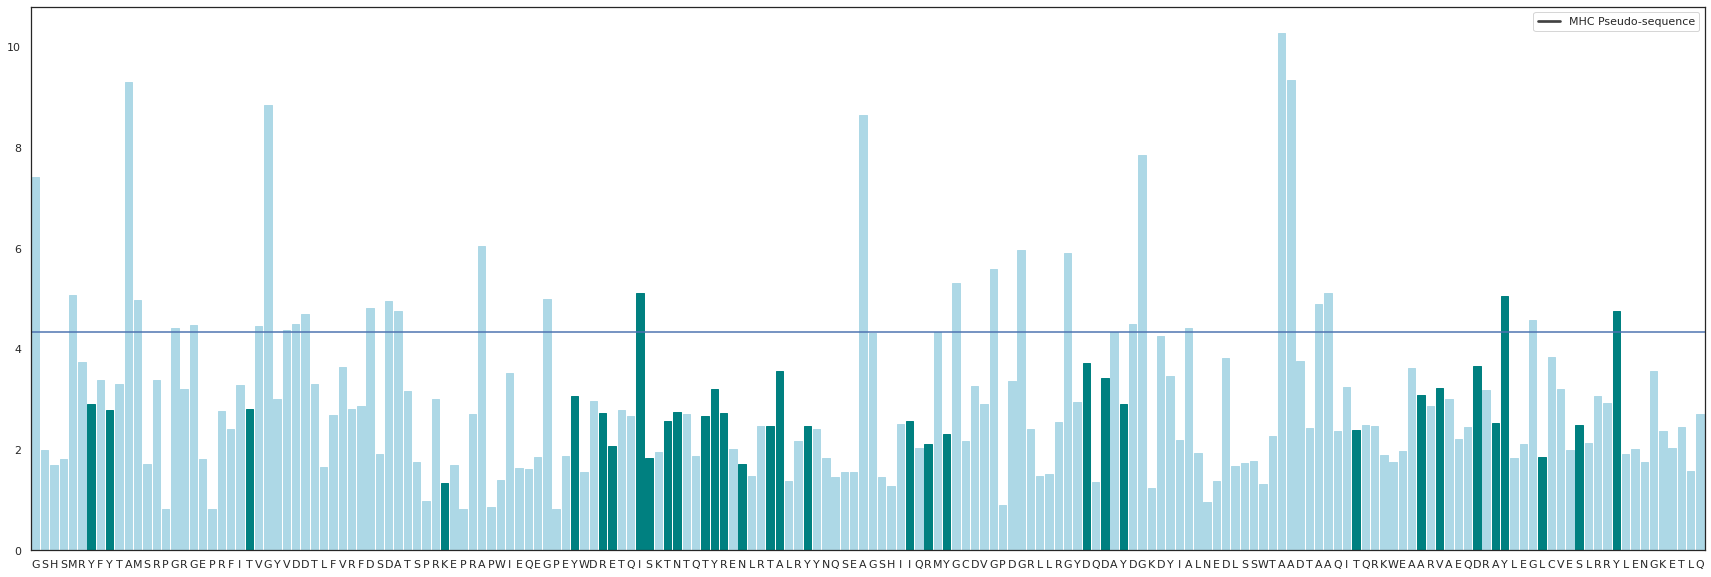



YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY

GMAMGGVGVDDDDAAGIAMGGGGADGAAAAAYGY
0.5462791177076891



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 13
HLA: HLA-A*32:15
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAHSQTDRESLRIALRYYNQSEAGSHTIQMMYGCDVGPDGRLLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.262119293212891


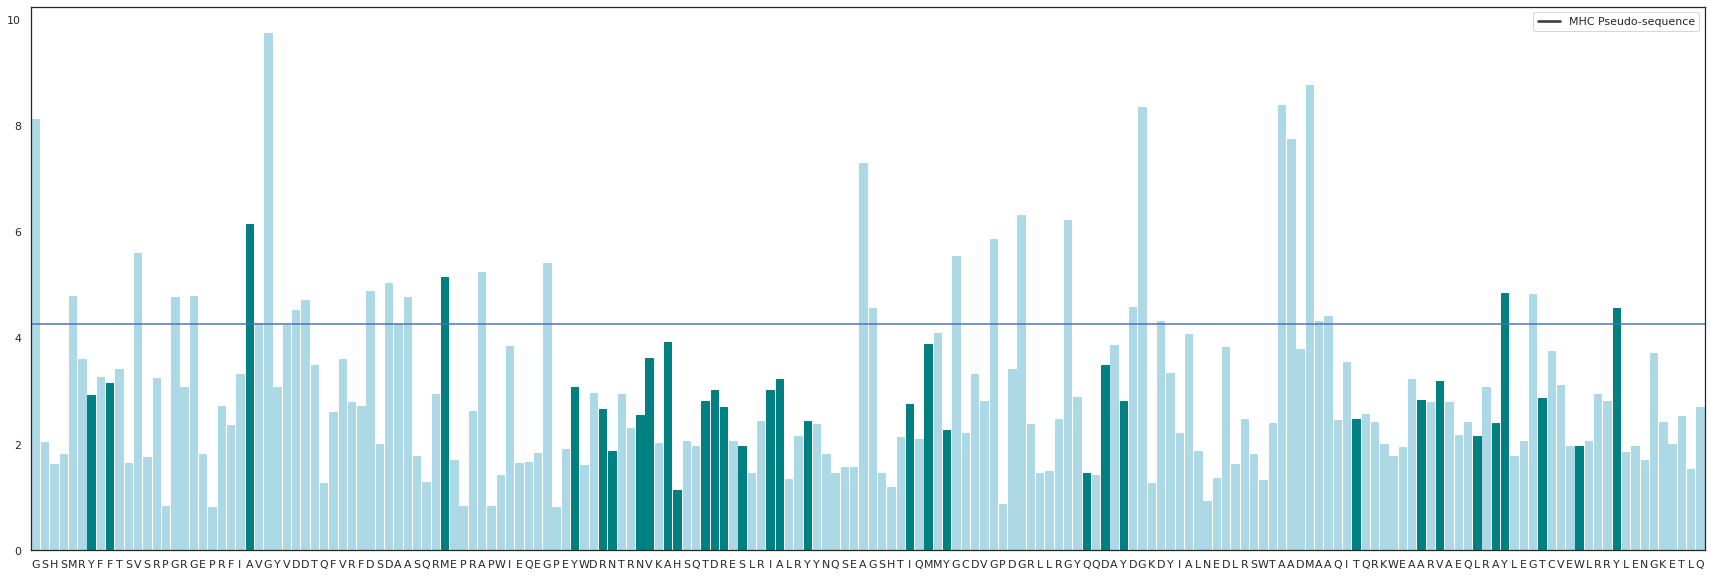



YFAMYRNNVAHTDESIAYIMYQDYTWAVLAYTWY

GMVGGAVGDDDDAAMAGAGGGGGDGDAAMAAYGY
0.5732838589981448



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 14
HLA: HLA-A*68:23
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQRMYGCDVGSDGRFLRGYRQDAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.156347819737026


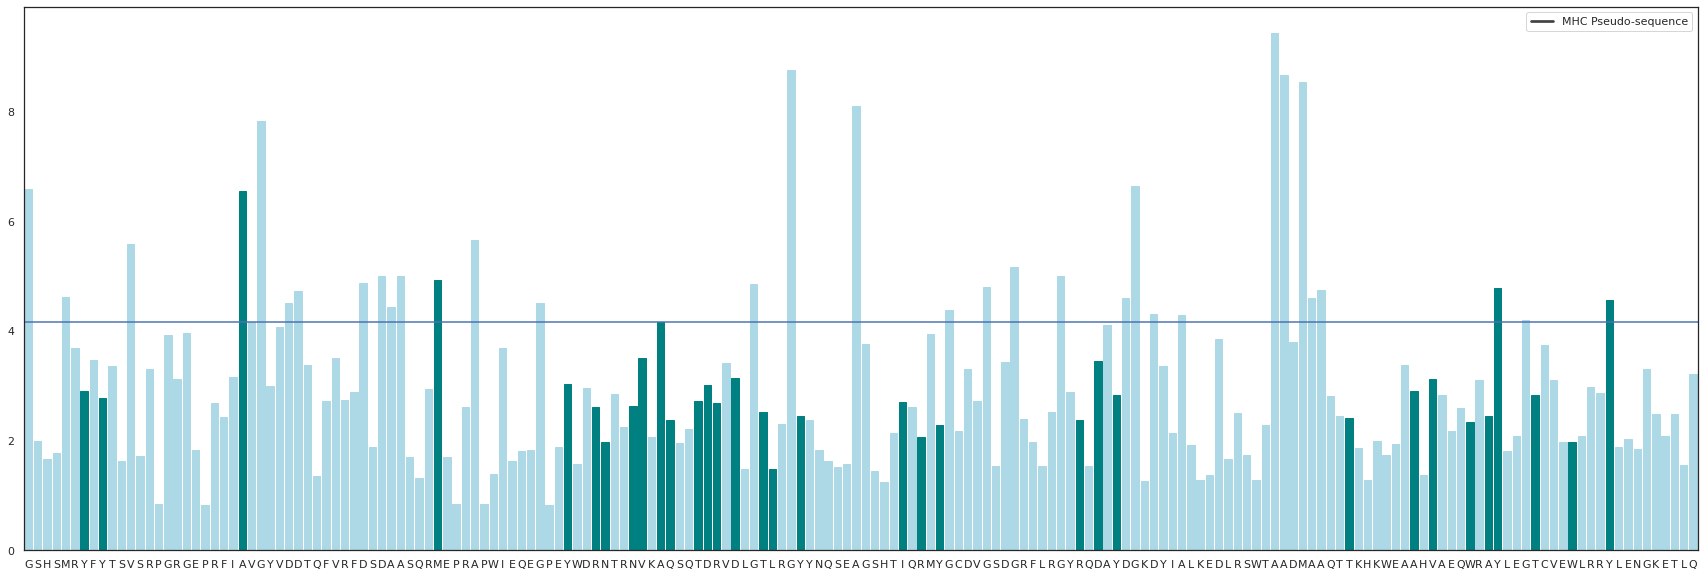



YYAMYRNNVAQTDVDTLYIRYRDYTWAVWAYTWY

GMVAGDDDDAAMAGAGGAGGGGDGDAAAMAAYGY
0.5609152752009894



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 10
HLA: HLA-A*26:03
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAHSQTHRVDLGTLRGYYNQSEDGSHTIQRMYGCDVGPDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWETAHEAEQWRAYLEGRCVEWLRRYLENGKETLQ
threshold: 4.285628890991211


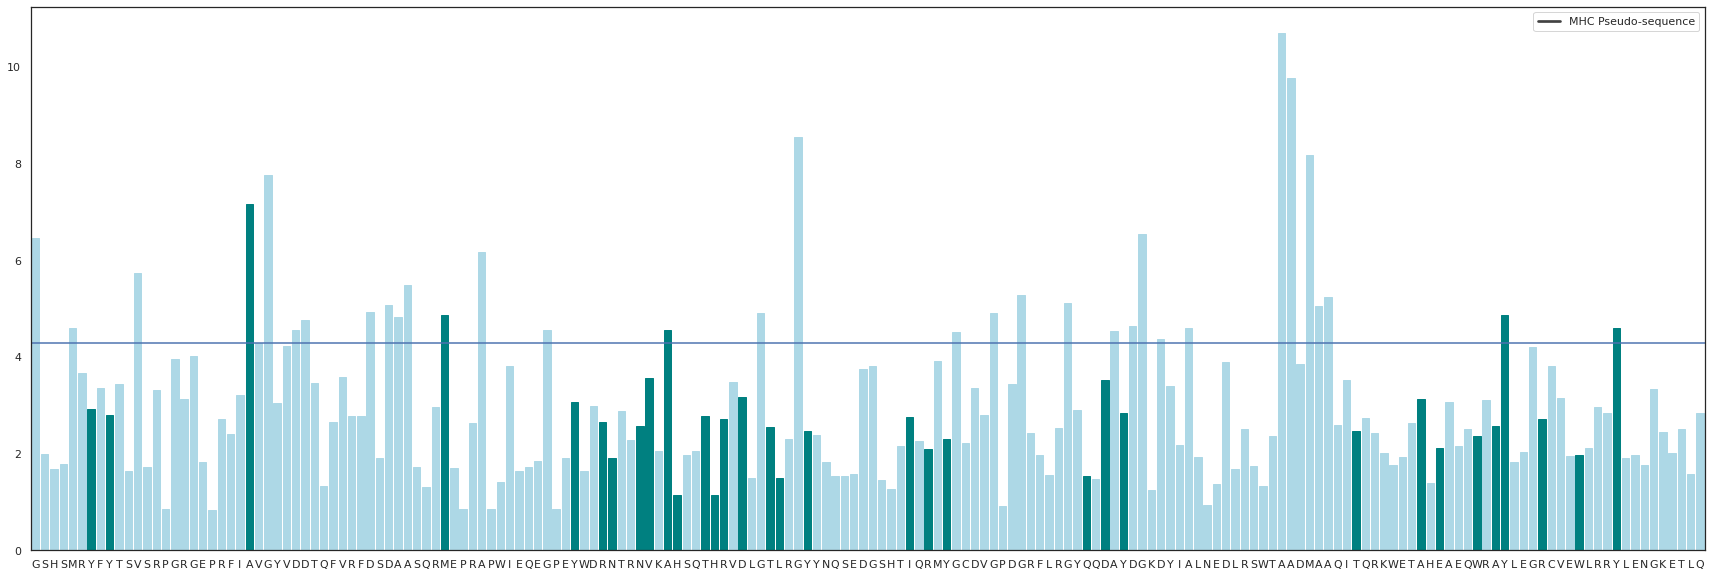



YYAMYRNNVAHTHVDTLYIRYQDYTWAEWAYRWY

GMVAVGDDDDAAMAGAGGGGGGADGDAAAMAAYY
0.5160791589363019



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 14
HLA: HLA-A*32:07
GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAHSQTDRESLRIALRYYNQSEAGSHTIQMMYGCDVGPDGRLLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.309696197509766


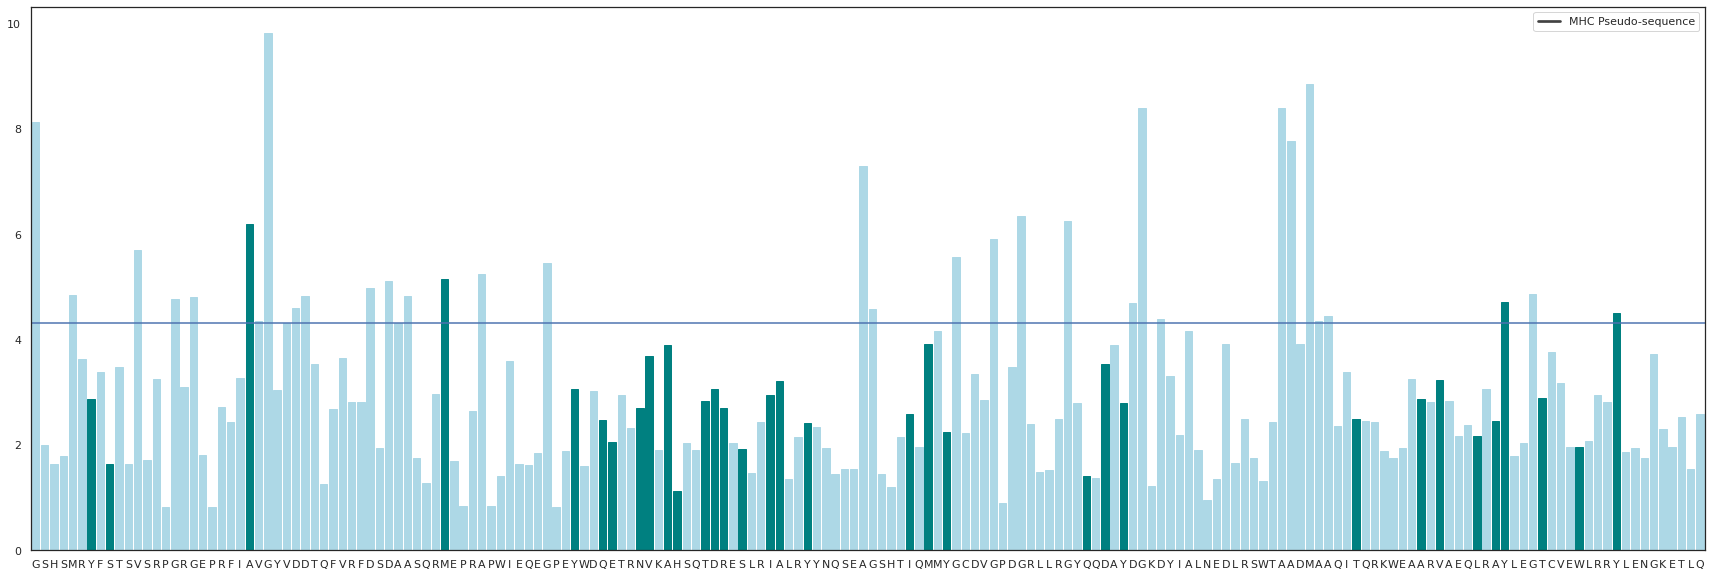



YSAMYQENVAHTDESIAYIMYQDYTWAVLAYTWY

GMVGGAVGDDDDAAMAGAGGGGGDGDAAMAAYGY
0.5599876314162029



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 10
HLA: HLA-A*02:50
GSHSMRYFFTSMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTIQRMYGCDVGPDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.344074249267578


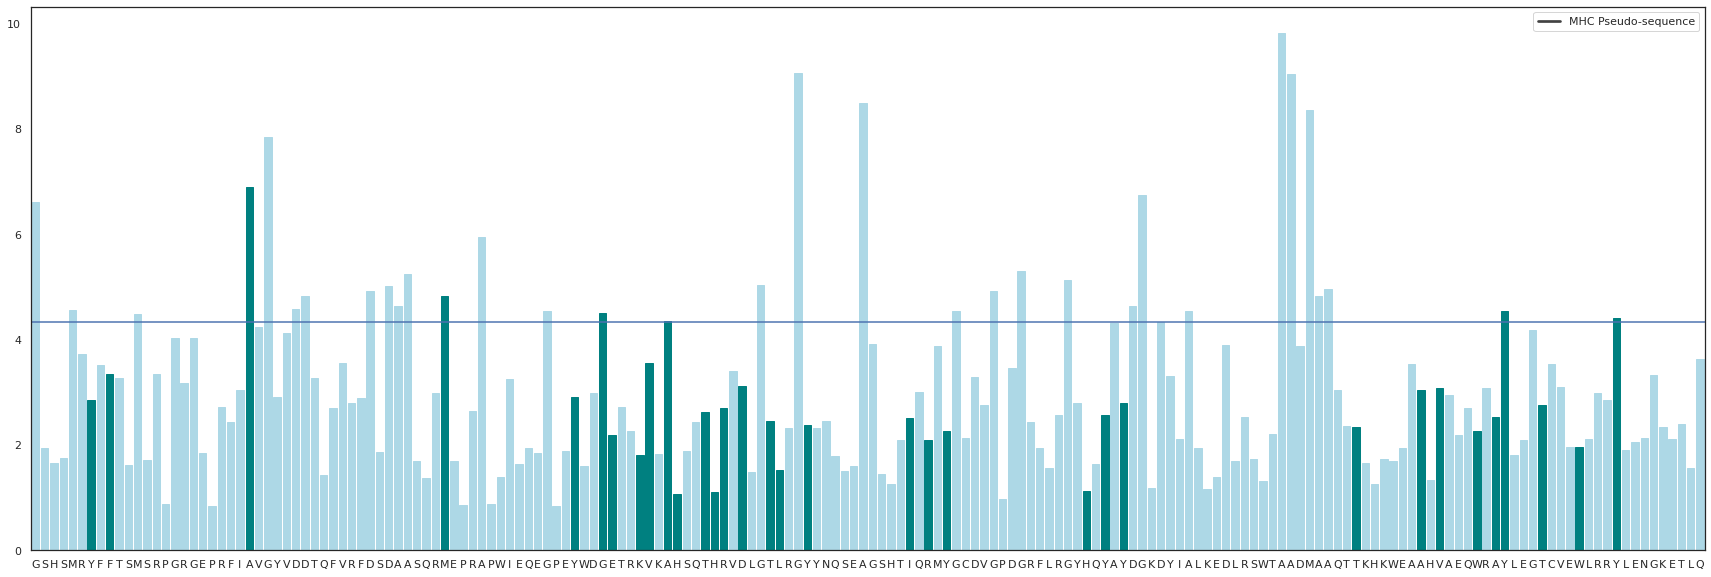



YFAMYGEKVAHTHVDTLYIRYHYYTWAVWAYTWY

GMMAGDDDDAAMAGGAGGAGGGGDGDAAAMAAYY
0.5118532261389404



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 15
HLA: HLA-B*27:20
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDRESLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.3642939249674475


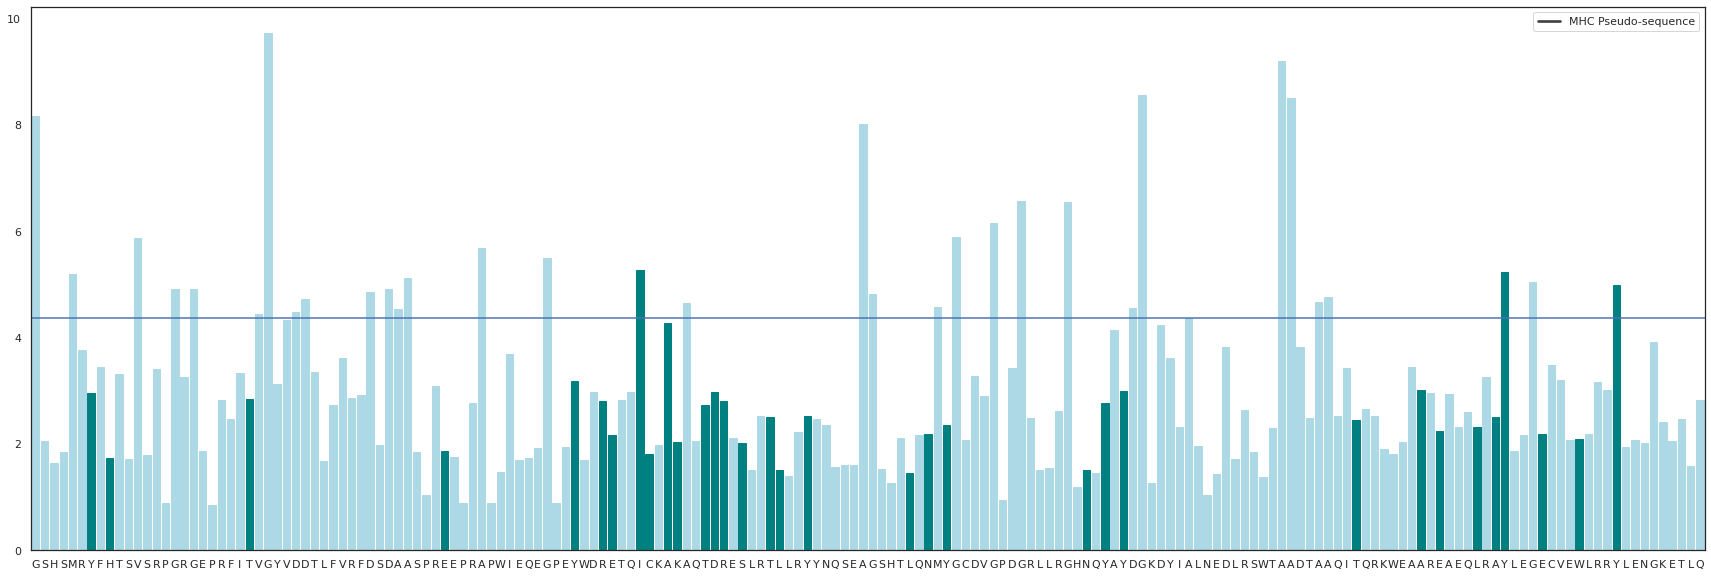



YHTEYREICAKTDESTLYLNYNYYTWAELAYEWY

GMVGGVGDDDDAAAGIAAGMGGGGDGAAAAAYGY
0.47134611420325706



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 15
HLA: HLA-A*66:01
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAQSQTDRVDLGTLRGYYNQSEDGSHTIQRMYGCDVGPDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWETAHEAEQWRAYLEGRCVEWLRRYLENGKETLQ
threshold: 4.290059916178385


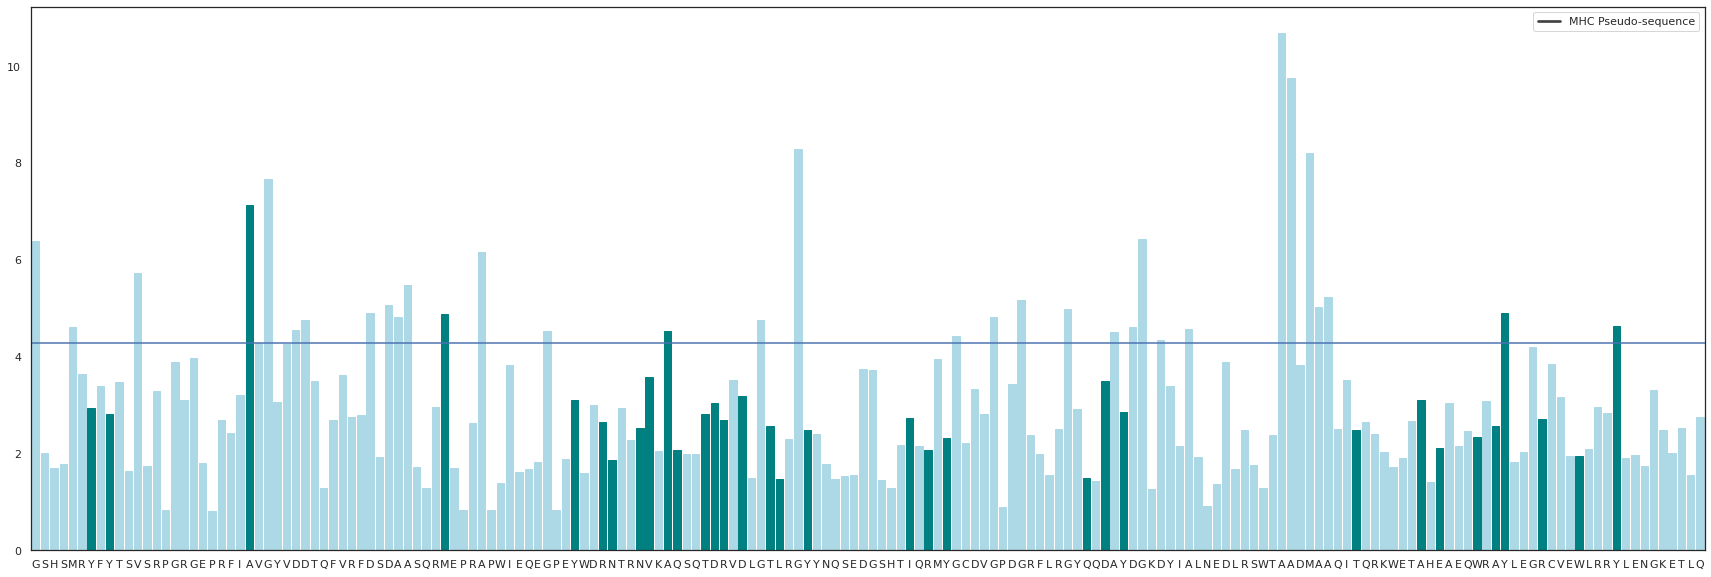



YYAMYRNNVAQTDVDTLYIRYQDYTWAEWAYRWY

GMVAVGDDDDAAMAGAGGGGGGADGDAAAMAAYY
0.5465883323026179



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 15
HLA: HLA-B*14:01
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTDRESLRNLRGYYNQSEAGSHTLQWMYGCDVGPDGRLLRGYNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGTCVEWLRRHLENGKETLQ
threshold: 4.190376281738281


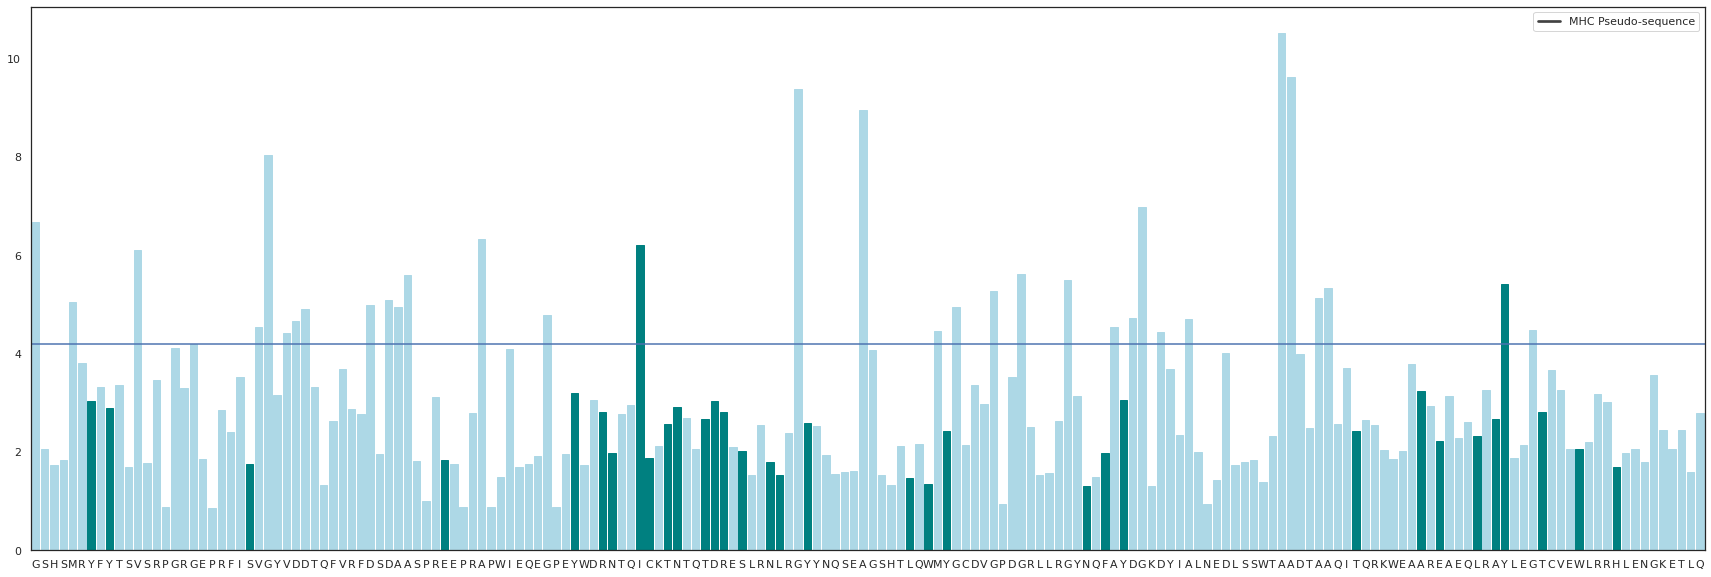



YYSEYRNICTNTDESNLYLWYNFYTWAELAYTWH

GMVGVGVDDDDAAAGIGAMGGGGADGDAAAAAYG
0.4258915687487116



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 20
HLA: HLA-B*15:09
GSHSMRYFYTAMSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.393493270874023


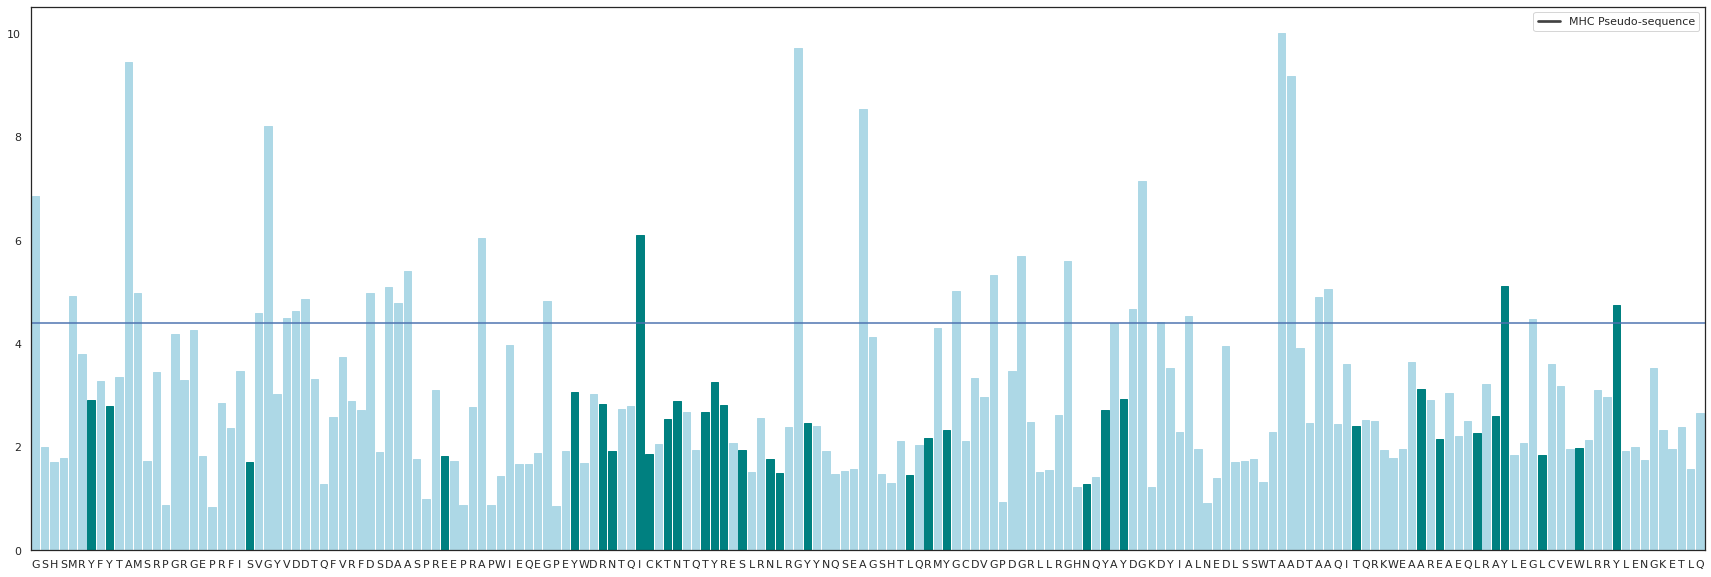



YYSEYRNICTNTYESNLYLRYNYYTWAELAYLWY

GMAMVGVDDDDAAAGIGAGGGGADGDAAAAAYGY
0.4556792413935271



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 23
HLA: HLA-B*48:01
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQISQRKLEAARVAEQLRAYLEGECVEWLRRYLENGKDKLE
threshold: 4.407526430876358


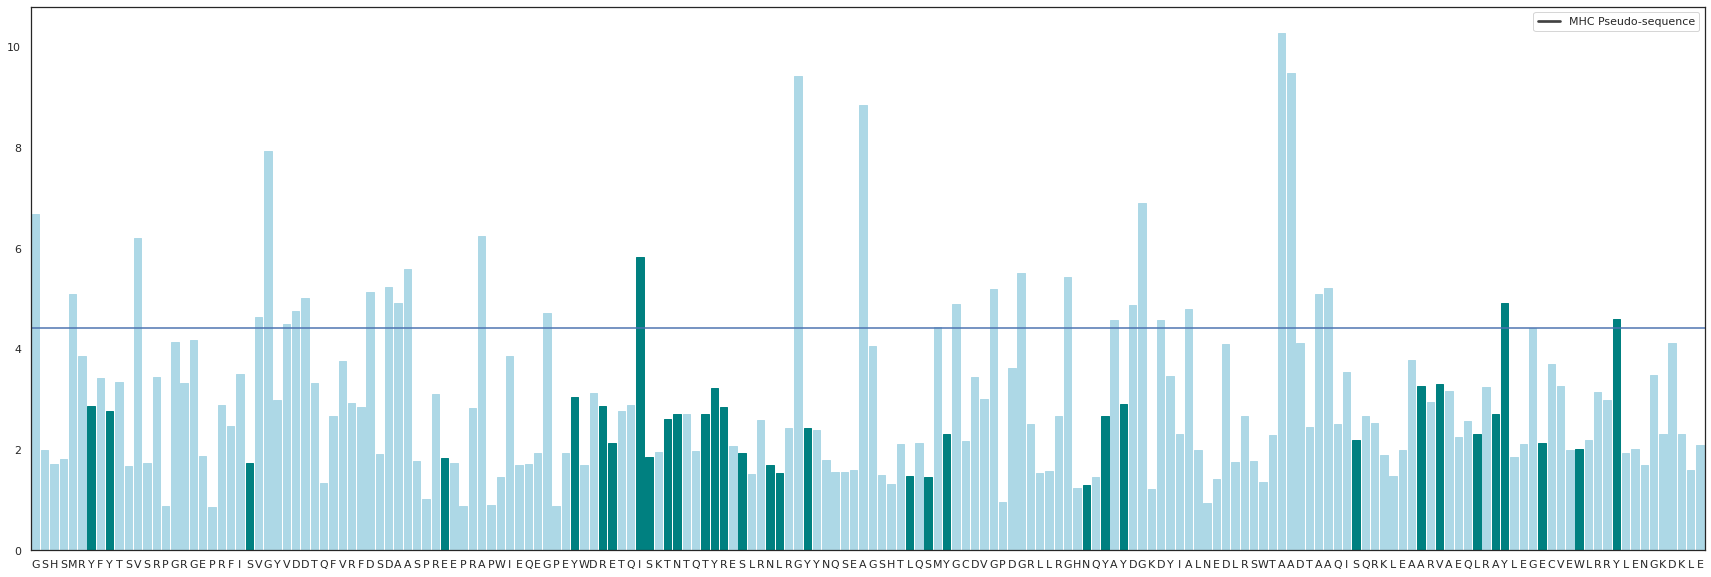



YYSEYREISTNTYESNLYLSYNYYSLAVLAYEWY

GMVVGVDDDDAAAGIGAMGGGGADGDAAAAAYGY
0.4514533085961658



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 24
HLA: HLA-A*25:01
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAHSQTDRESLRIALRYYNQSEDGSHTIQRMYGCDVGPDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWETAHEAEQWRAYLEGRCVEWLRRYLENGKETLQ
threshold: 4.369875272115071


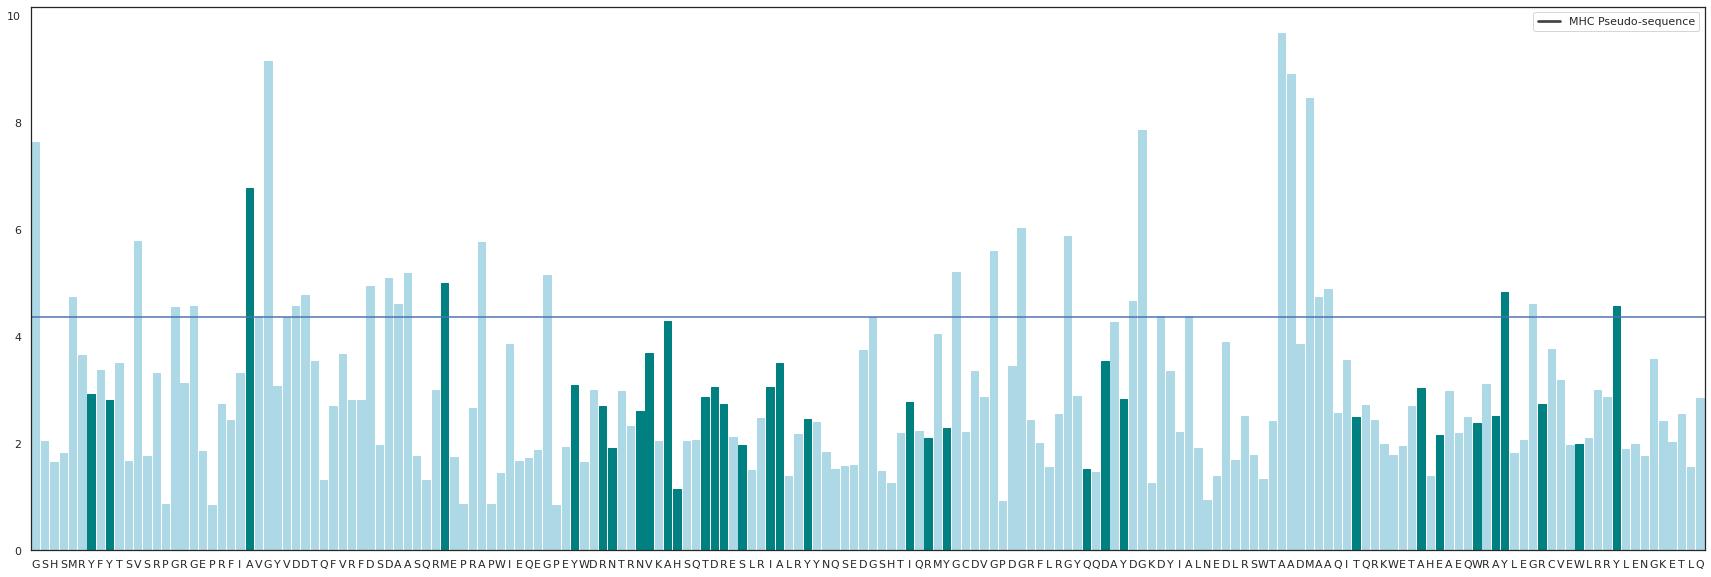



YYAMYRNNVAHTDESIAYIRYQDYTWAEWAYRWY

GMVGGAVGDDDDAAMAGGGGGGDGDAAAMAAYGY
0.5563801278086993



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 16
HLA: HLA-A*24:13
GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITKRKWEAAHVAEQLRAYLEGTCVDGLRRYLENGKETLQ
threshold: 4.242588520050049


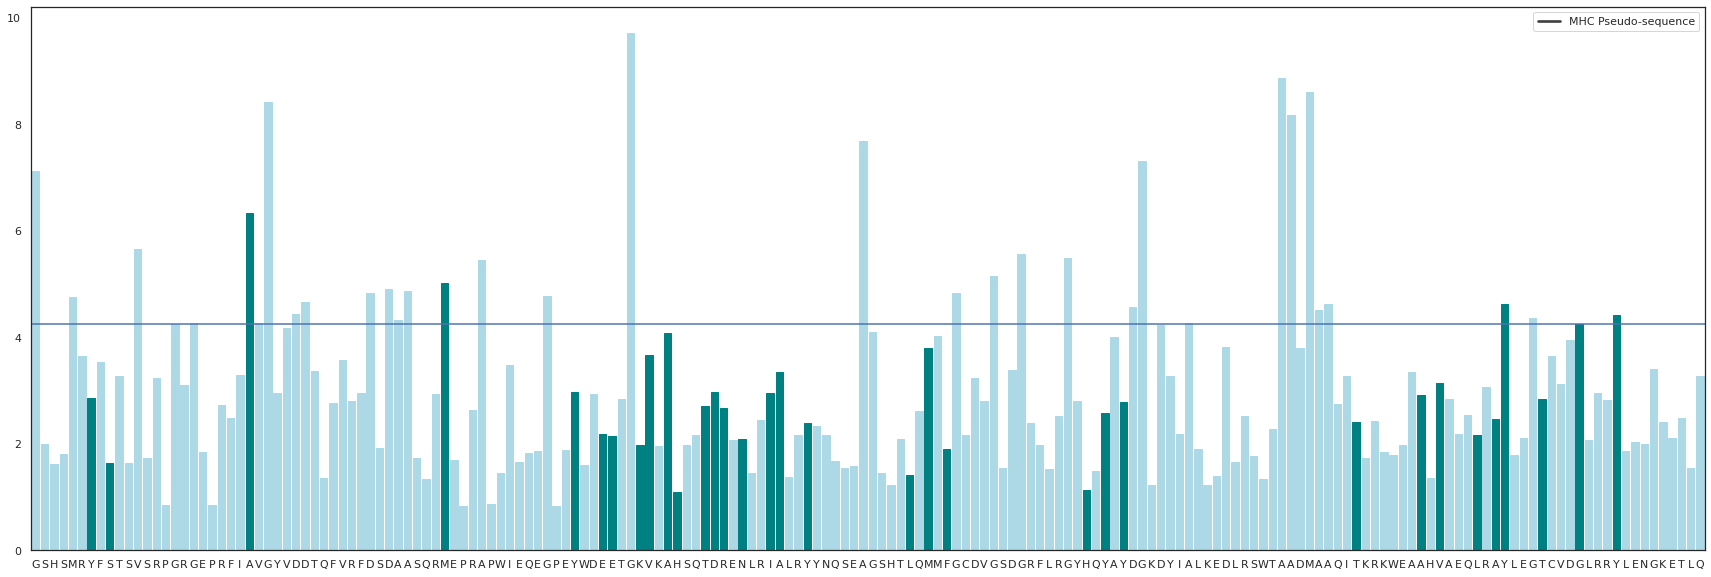



YSAMYEEKVAHTDENIAYLMFHYYTWAVLAYTGY

GMVGGAVGDDDDAAMAGGAGGGGDGAAAMAAYGY
0.5297876726448155



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 30
HLA: HLA-A*80:01
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDSQFVQFDSDAASQRMEPRAPWIEQEEPEYWDEETRNVKAHSQTNRANLGTLRGYYNQSEDGSHTIQIMYGCDVGSDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAARRAEQLRAYLEGECVDGLRRYLENGKETLQ
threshold: 4.24011459350586


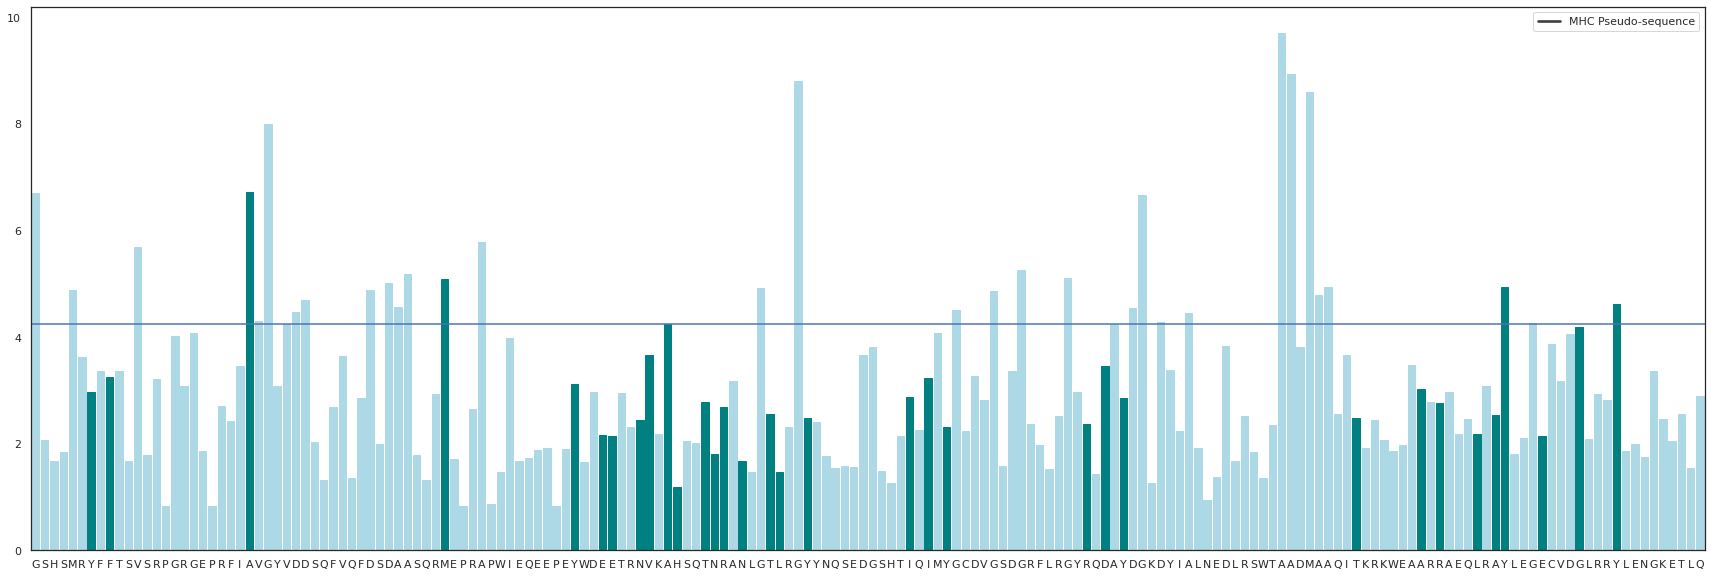



YFAMYEENVAHTNANTLYIIYRDYTWARLAYEGY

GMVAVGVDDDDAAMAAGGGGGGDGDAAAMAAYGY
0.5471036899608328



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 35
HLA: HLA-A*02:16
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.23444562639509


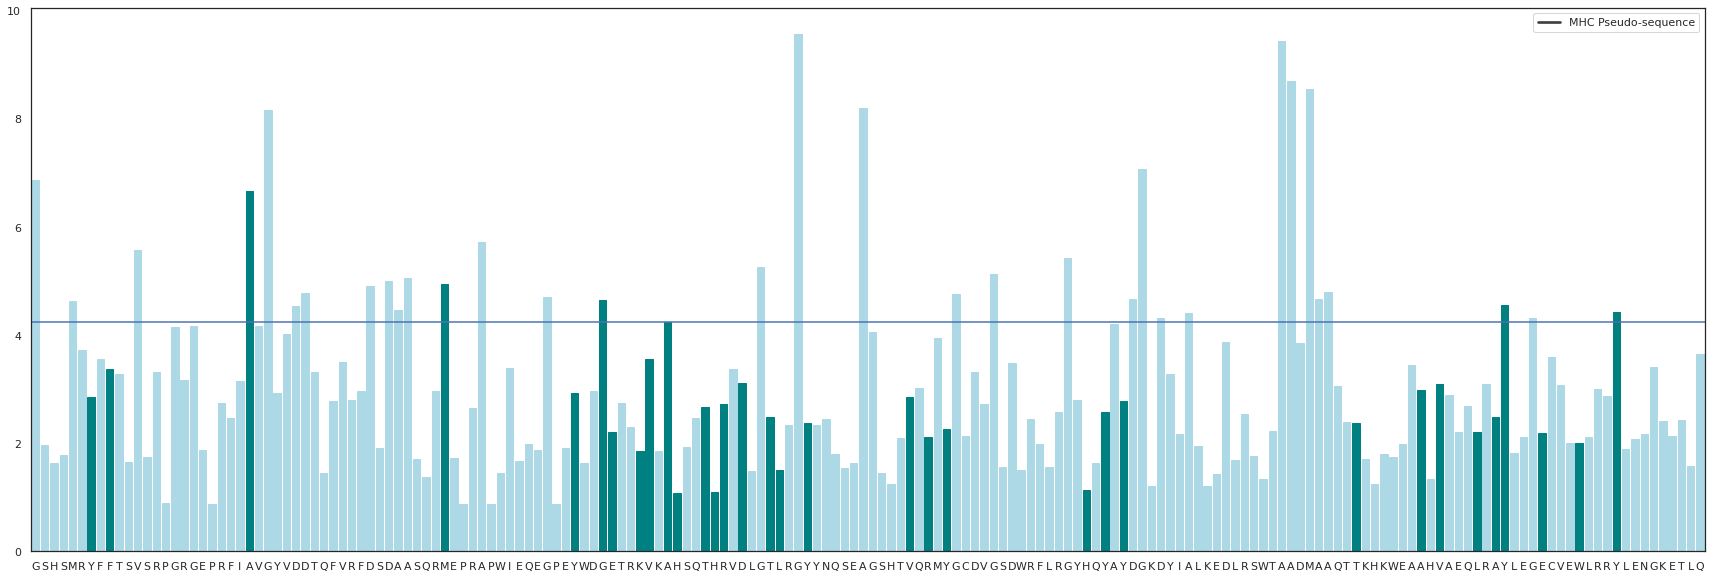



YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYEWY

GMVAGDDDDAAMAGGAGGAGGGDGDAAAMAAYGY
0.5135023706452277



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 32
HLA: HLA-A*26:02
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAHSQTDRANLGTLRGYYNQSEDGSHTIQRMYGCDVGPDGRFLRGYQQNAYDGKDYIALNEDLRSWTAADMAAQITQRKWETAHEAEQWRAYLEGRCVEWLRRYLENGKETLQ
threshold: 4.2924723625183105


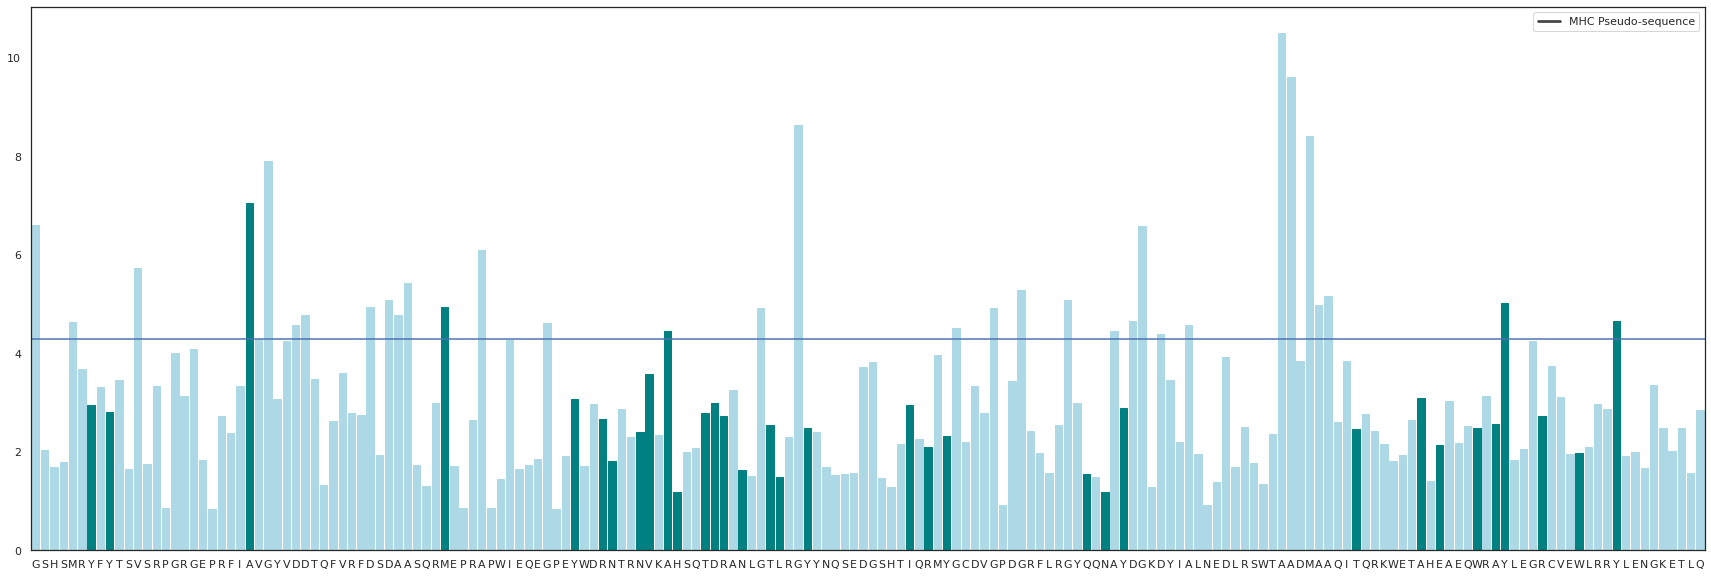



YYAMYRNNVAHTDANTLYIRYQNYTWAEWAYRWY

GMVAVGDDDDAAMAGAGGGGGGADGDAAAMAAYY
0.4986600700886415



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 37
HLA: HLA-A*02:19
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITKRKWEAAHVAEQQRAYLEGTCVDGLRRYLENGKETLQ
threshold: 4.216155181059966


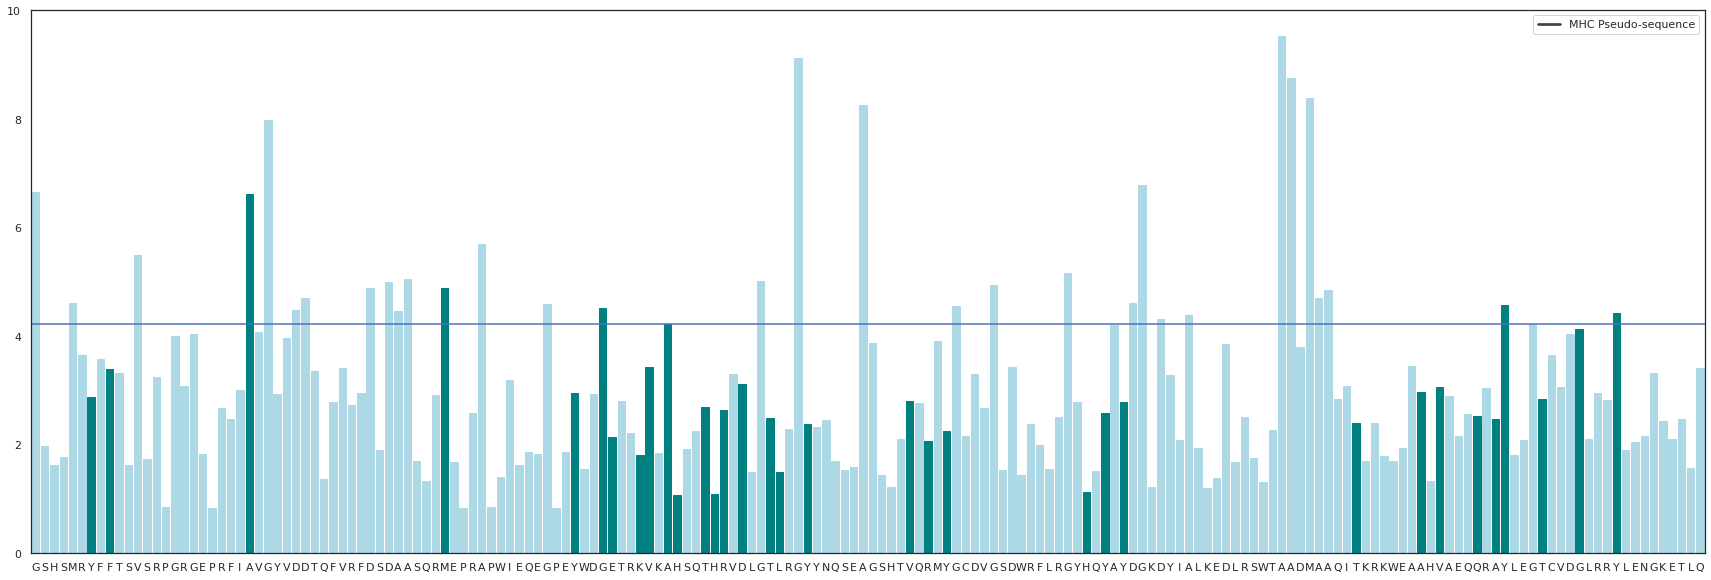



YFAMYGEKVAHTHVDTLYVRYHYYTWAVQAYTGY

GMVAGDDDDAAMAGGAGGAGGGDGDAAAMAAYGY
0.5307153164296021



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 39
HLA: HLA-B*15:02
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDRNTQISKTNTQTYRESLRNLRGYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.444712320963542


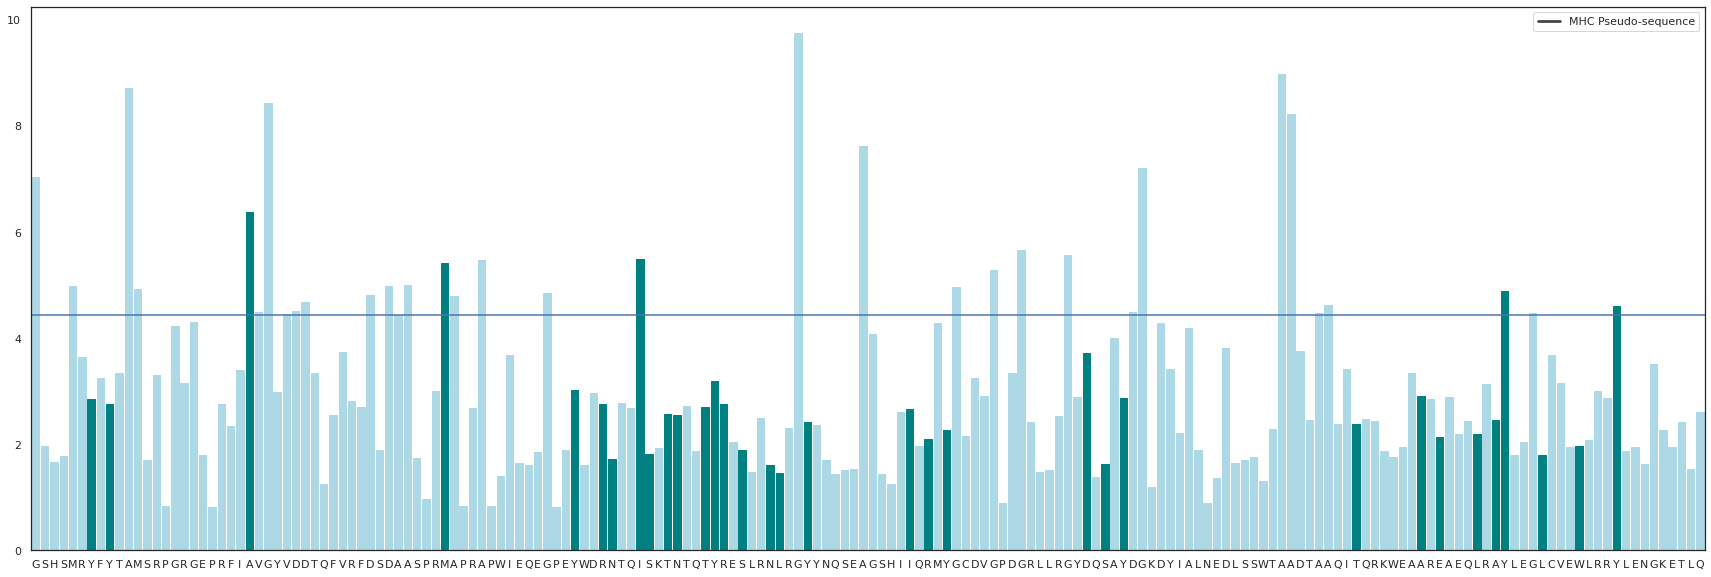



YYAMYRNISTNTYESNLYIRYDSYTWAELAYLWY

GMAMAVGVDDDDAAMAAGIGAGGGGDGAAAAYGY
0.5028860028860029



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 39
HLA: HLA-B*18:03
GSHSMRYFHTSVSRPGRGEPRFISVGYVDGTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQISKTNTQTDRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRHLENGKETLQ
threshold: 4.099314762995793


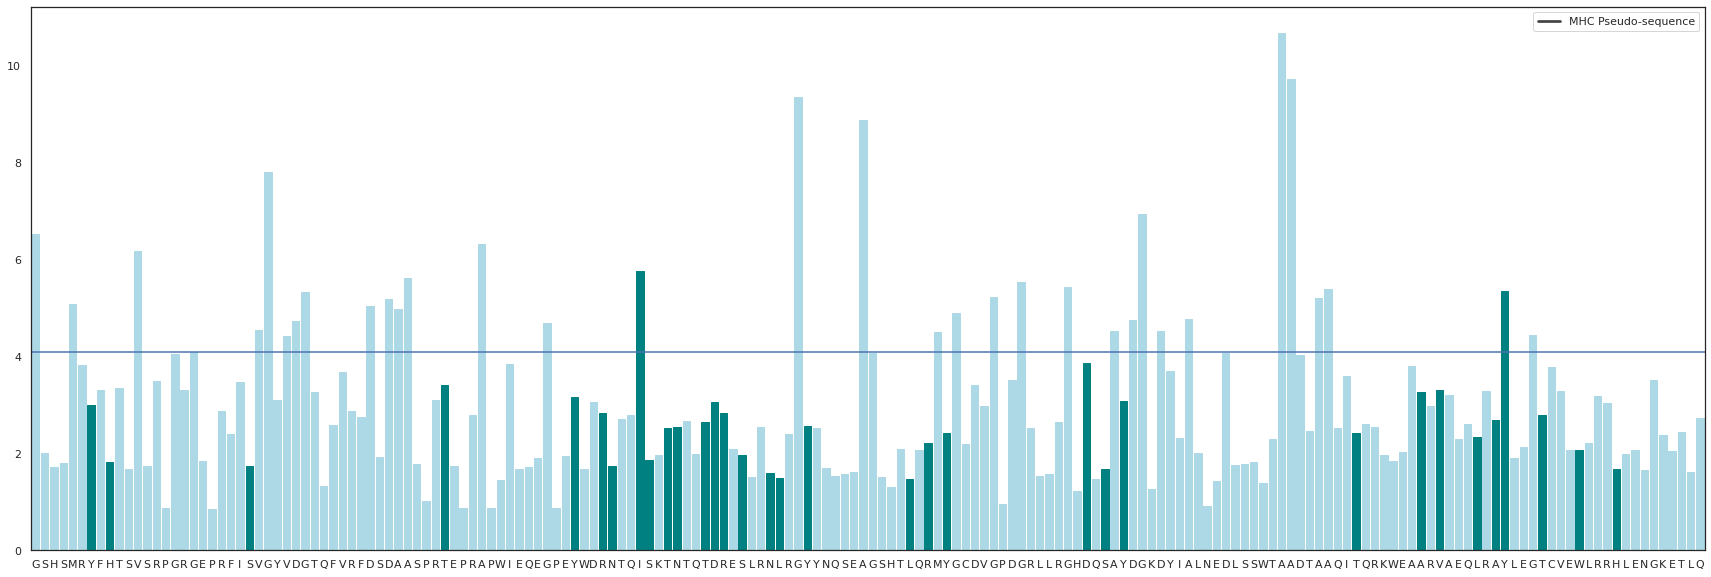



YHSTYRNISTNTDESNLYLRYDSYTWAVLAYTWH

GMVGVGVDGDDAAAGIGAMGGGGADGDAAAAAYG
0.4629973201401773



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 53
HLA: HLA-A*02:17
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTLQMMFGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.24574107044148


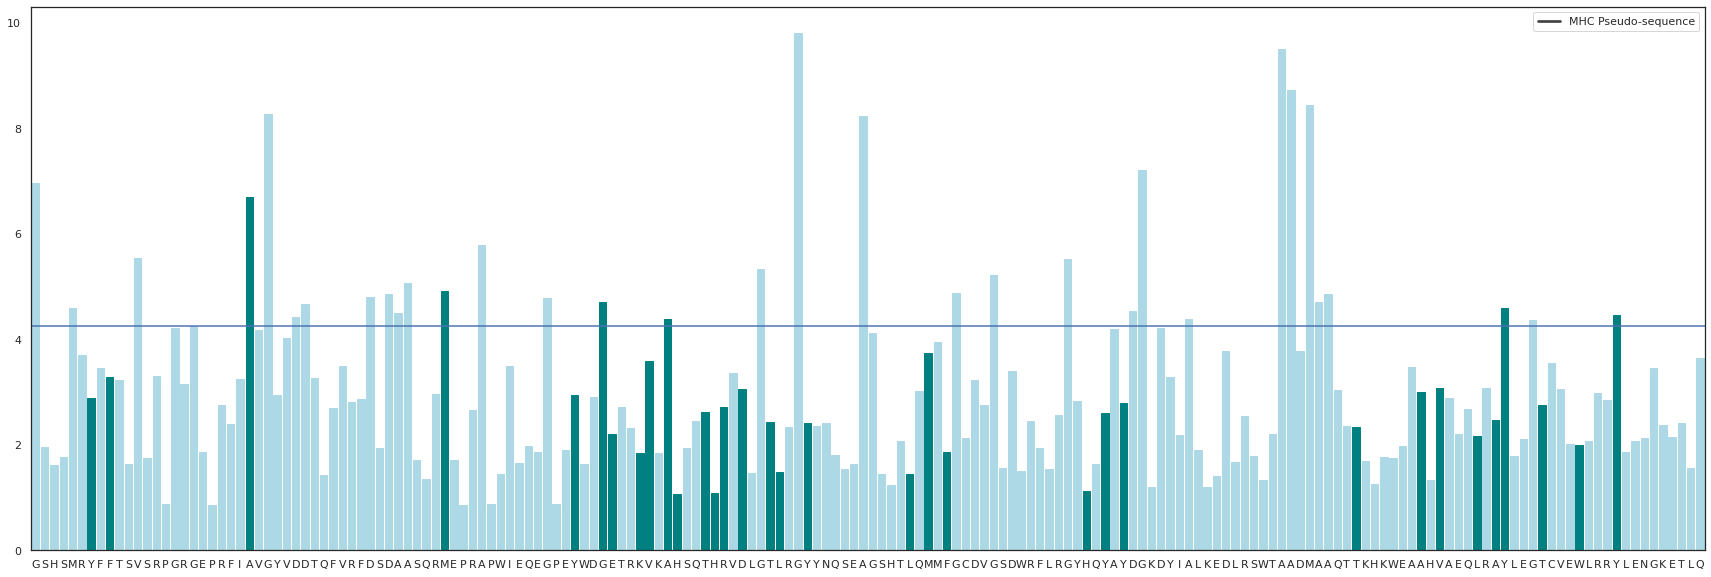



YFAMYGEKVAHTHVDTLYLMFHYYTWAVLAYTWY

GMVGAGDDDDAAMAGGAGGAGGGDGAAAMAAYGY
0.5126777983920842



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 50
HLA: HLA-A*24:06
GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITKRKWEAAHVAEQWRAYLEGTCVDGLRRYLENGKETLQ
threshold: 4.225054626464844


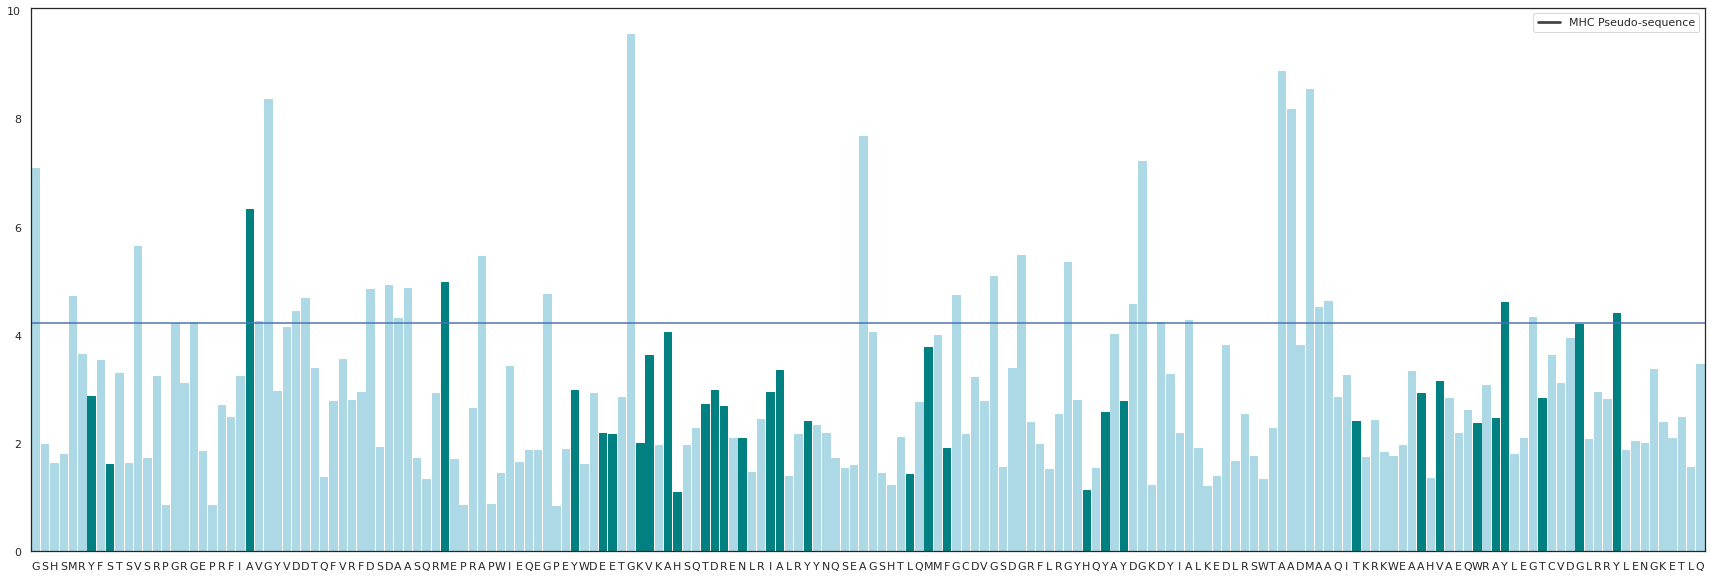



YSAMYEEKVAHTDENIAYLMFHYYTWAVWAYTGY

GMVGAVGDDDDAAMAGGAGGGGDGDAAAMAAYGY
0.5291692434549577



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 50
HLA: HLA-B*83:01
GSHSMRYFYTAMSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVESLRRYLENGKETLQ
threshold: 4.277911376953125


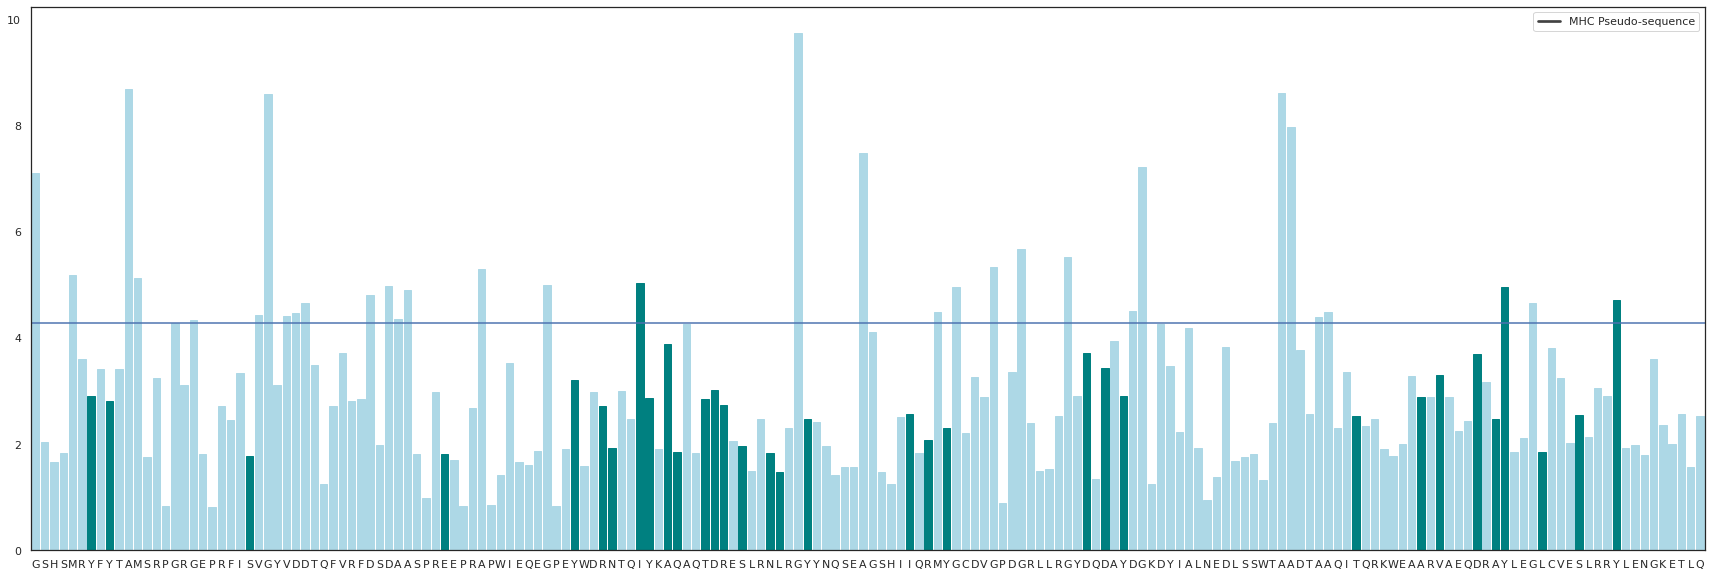



YYSEYRNIYAQTDESNLYIRYDDYTWAVDAYLSY

GMAMGGVGVDDDDAAAGIGAMGGGGDGAAAAYGY
0.5186559472273757



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 55
HLA: HLA-A*02:12
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQQRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.290181940252131


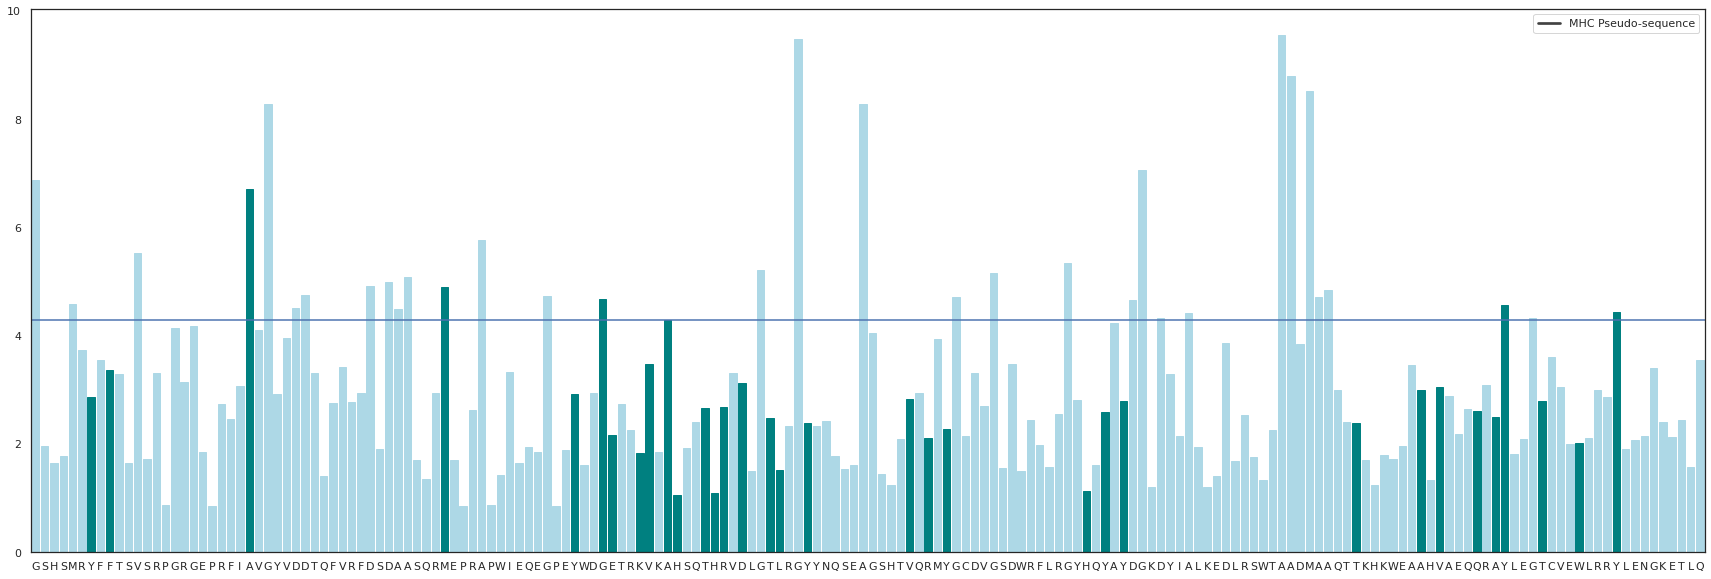



YFAMYGEKVAHTHVDTLYVRYHYYTWAVQAYTWY

GMVAGDDDDAAMAGGAGGAGGGDGDAAAMAAYGY
0.5217480931766646



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 50
HLA: HLA-B*45:06
GSHSMRYFHTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQIYKAQAQTDRESLRNLRGYYNQSEAGSHTWQRMYGCDLGPDGRLLRGYNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVESLRRYLENGKETLQ
threshold: 4.357817077636719


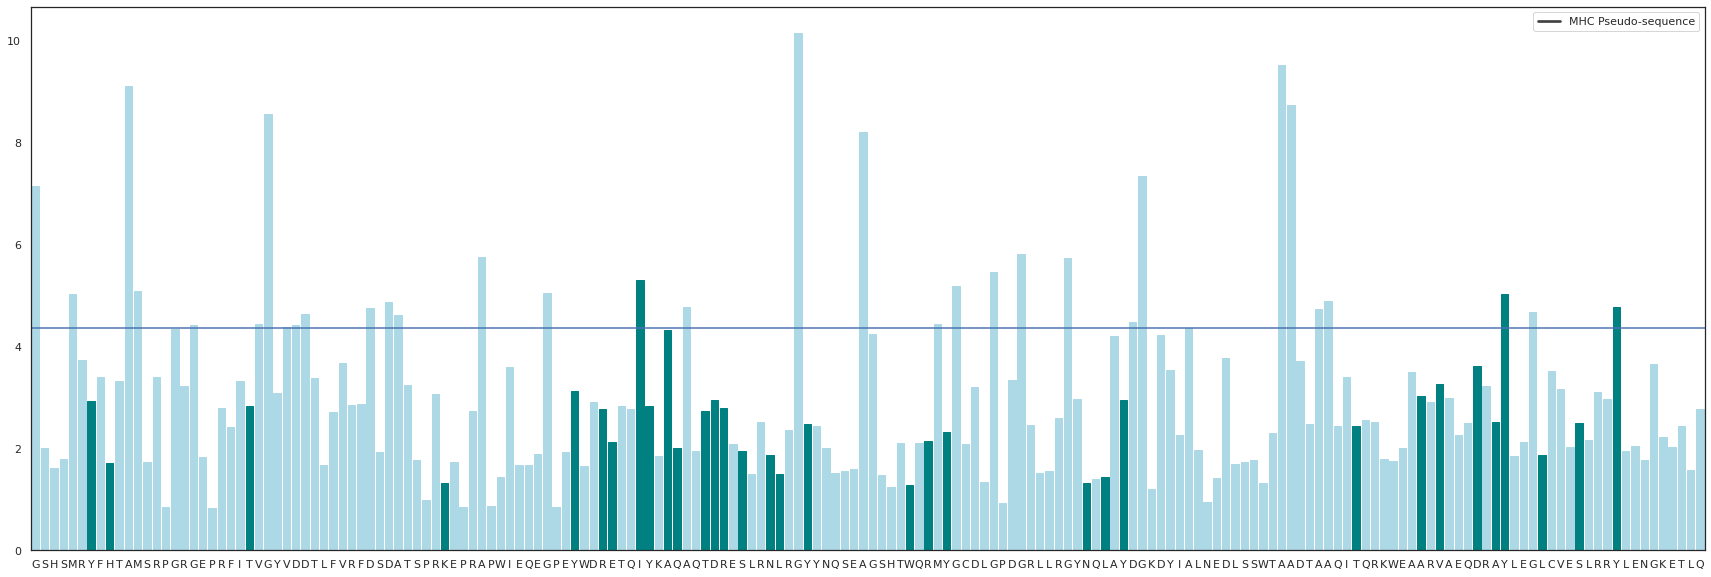



YHTKYREIYAQTDESNLYWRYNLYTWAVDAYLSY

GMAMGVGVDDDDAAGIAGAMGGGGDGAAAAAYGY
0.46784168212739646



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 48
HLA: HLA-B*15:42
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTWQTMYGCDLGPDGRLLRGHNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.409347852071126


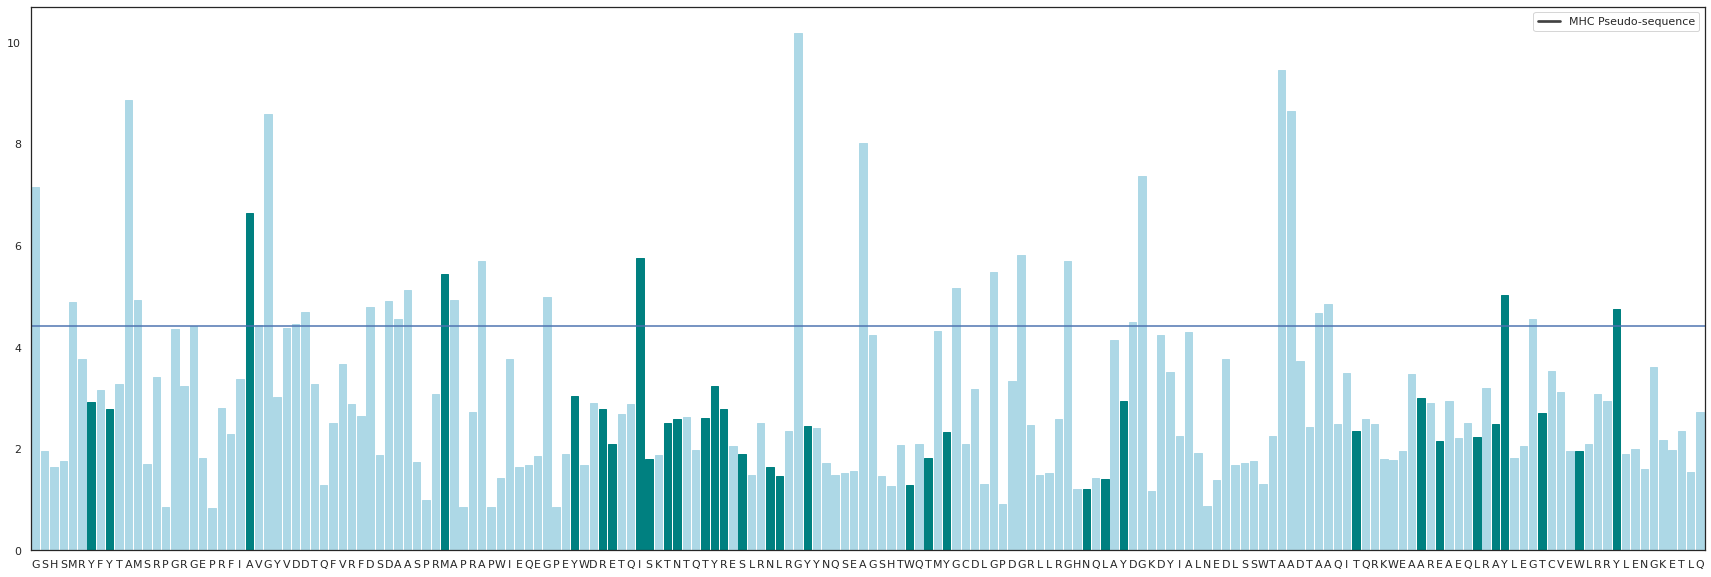



YYAMYREISTNTYESNLYWTYNLYTWAELAYTWY

GMAMGAVGDDDDAAMAAGIGAGGGGDGAAAAYGY
0.48649762935477225



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 57
HLA: HLA-A*24:03
GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITKRKWEAAHVAEQQRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.301112660190515


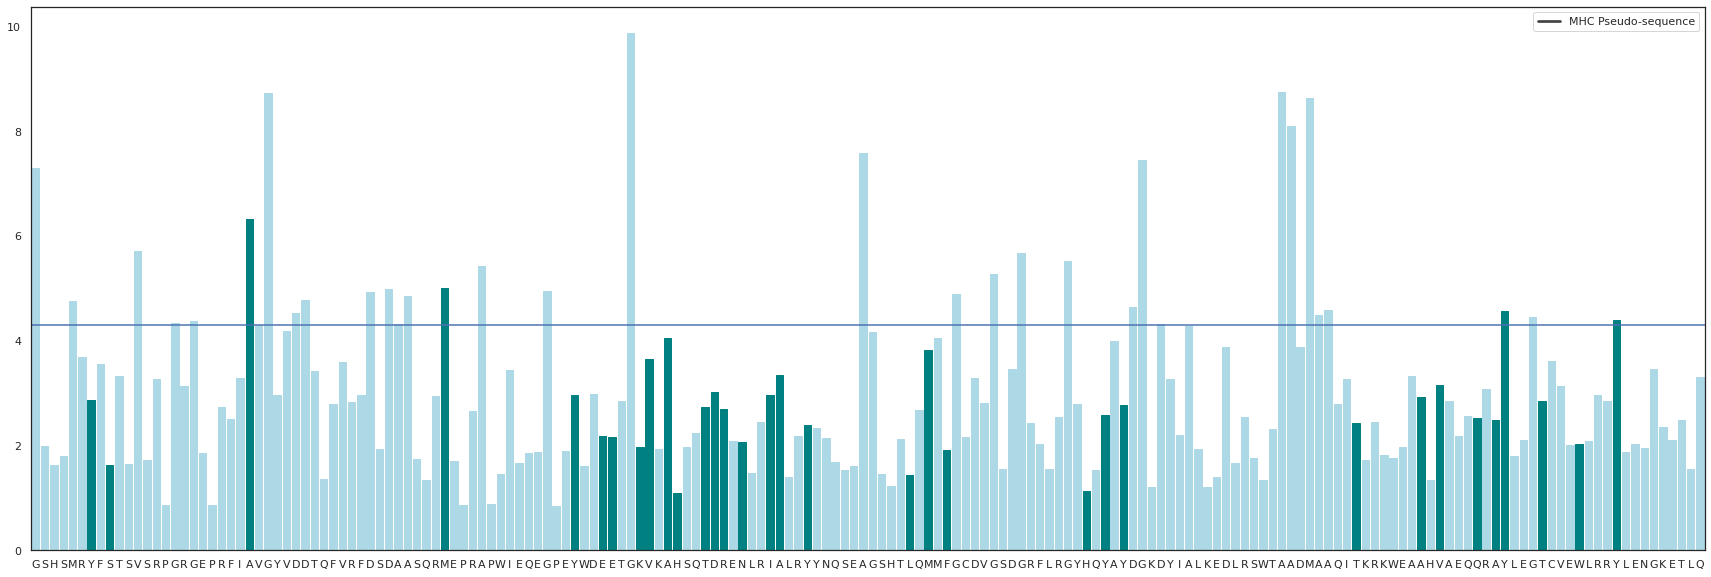



YSAMYEEKVAHTDENIAYLMFHYYTWAVQAYTWY

GMVGGAVGDDDDAAMAGGAGGGGDGDAAMAAYGY
0.5200989486703772



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 65
HLA: HLA-B*15:03
GSHSMRYFYTAMSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.405285175030048


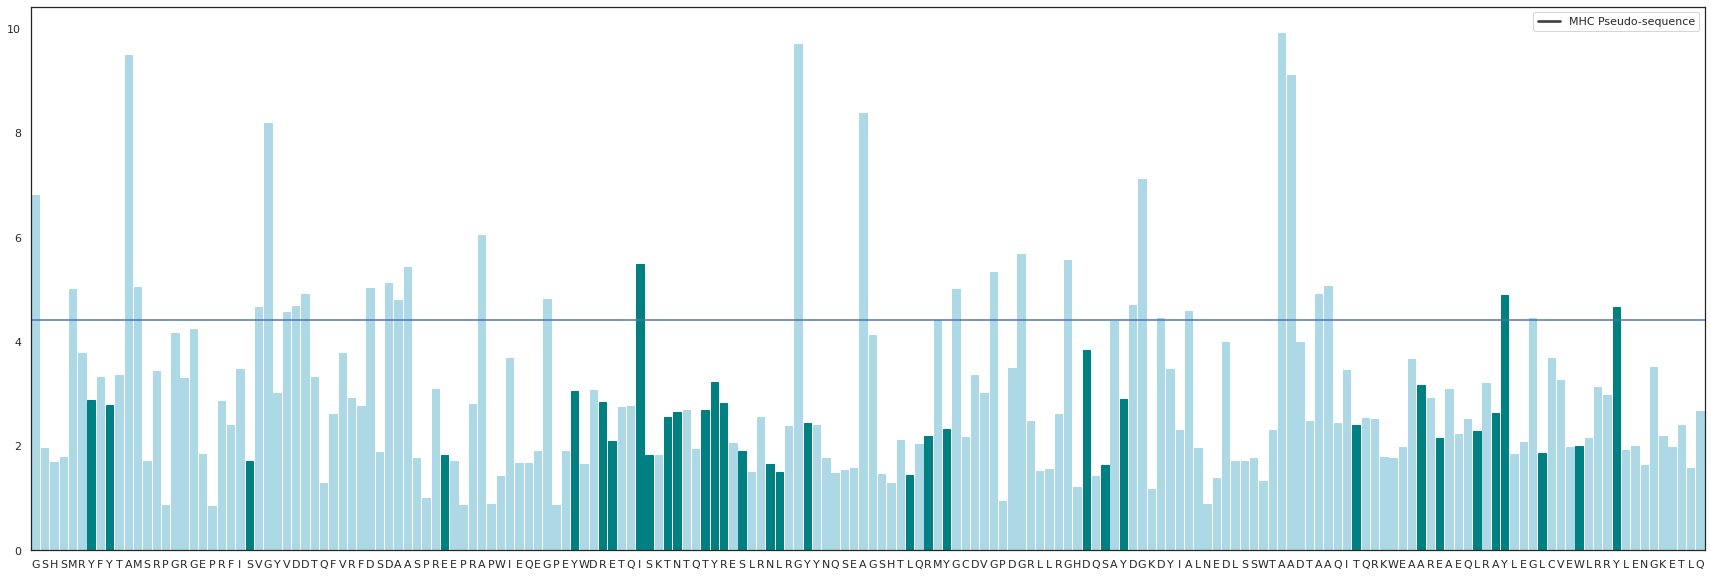



YYSEYREISTNTYESNLYLRYDSYTWAELAYLWY

GMAMVGVDDDDAAAGIGAMGGGGDGDAAAAAYGY
0.4615543186971759



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 71
HLA: HLA-A*02:11
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQIDRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.226363920829665


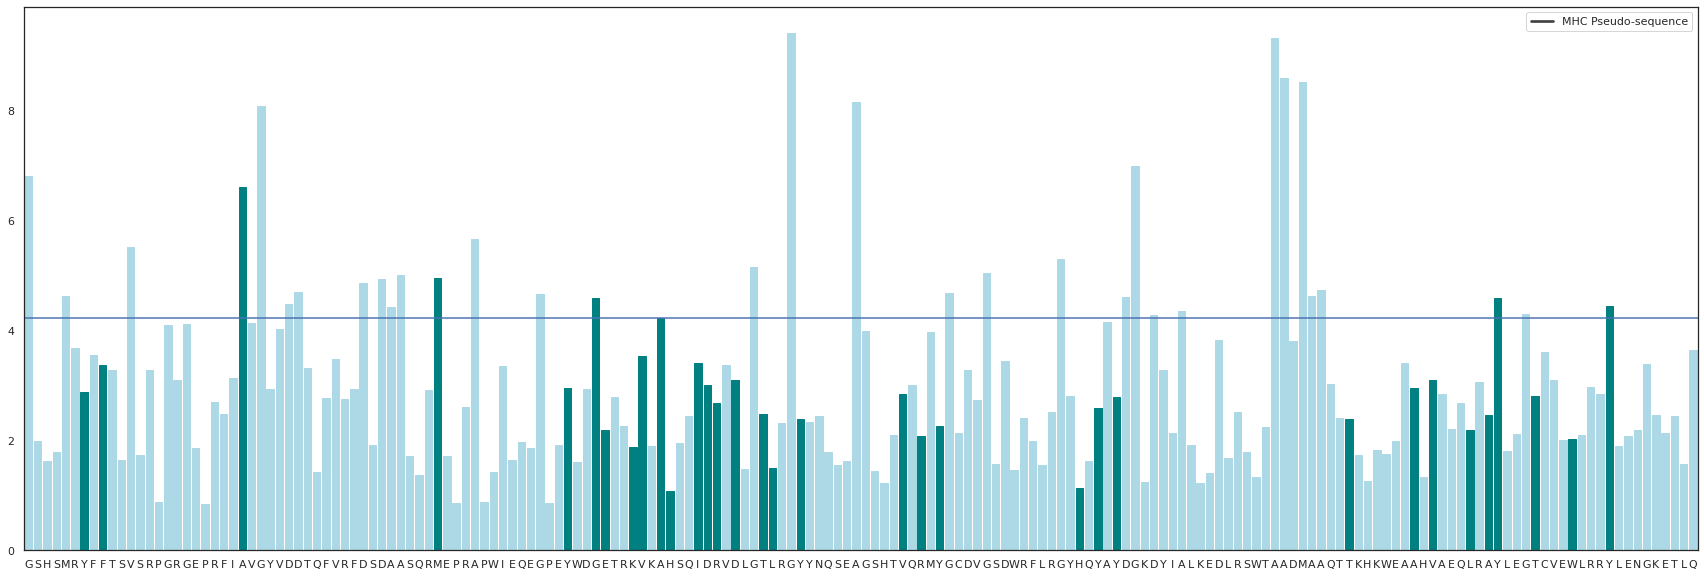



YFAMYGEKVAHIDVDTLYVRYHYYTWAVLAYTWY

GMVAGDDDDAAMAGGAGGAGGGDGDAAAMAAYGY
0.5423623995052567



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 79
HLA: HLA-B*15:17
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDRETRNMKASAQTYRENLRIALRYYNQSEAGSHTLQRMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.264909188958663


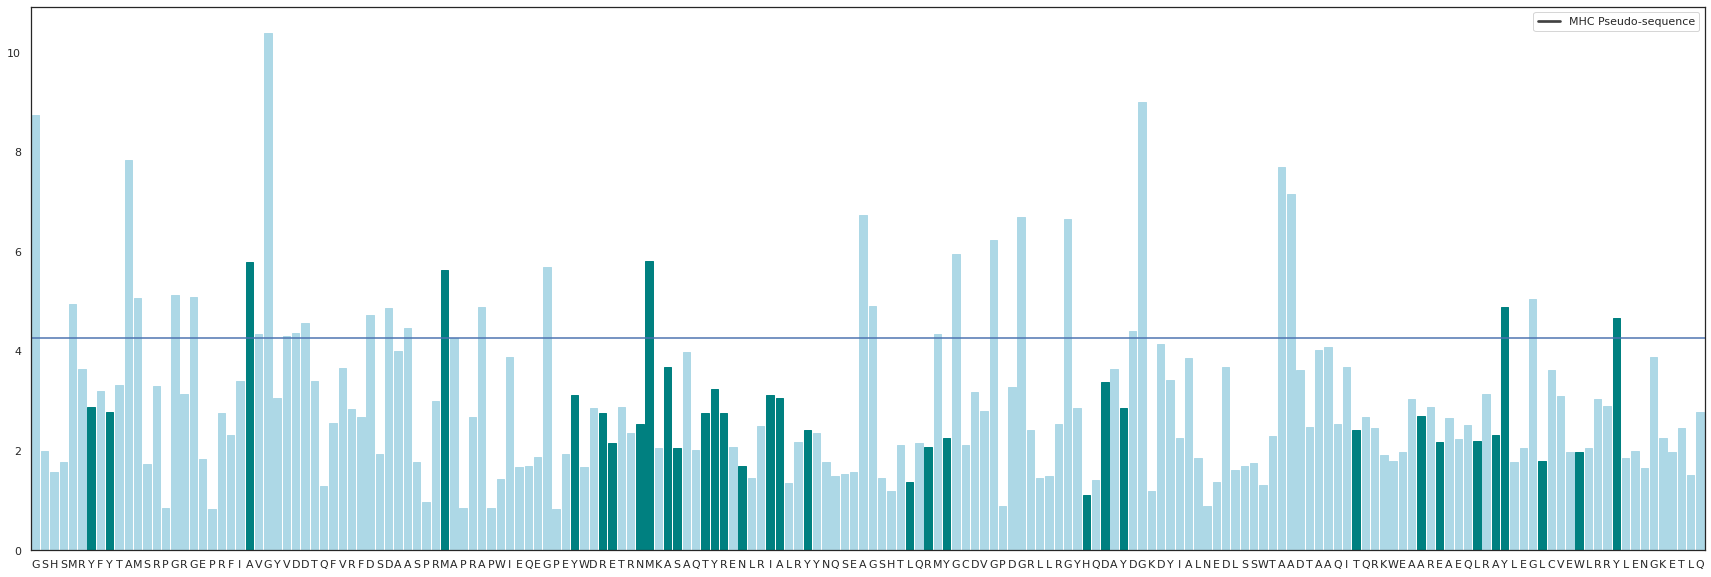



YYAMYRENMASTYENIAYLRYHDYTWAELAYLWY

GMAMGGAVGVDDDDAMAAGMAGMGGGGDGAAYGY
0.5273139558853844



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 87
HLA: HLA-B*73:01
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKAKAQTDRVGLRNLRGYYNQSEDGSHTWQTMYGCDMGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRHLENGKETLQ
threshold: 4.270879285088901


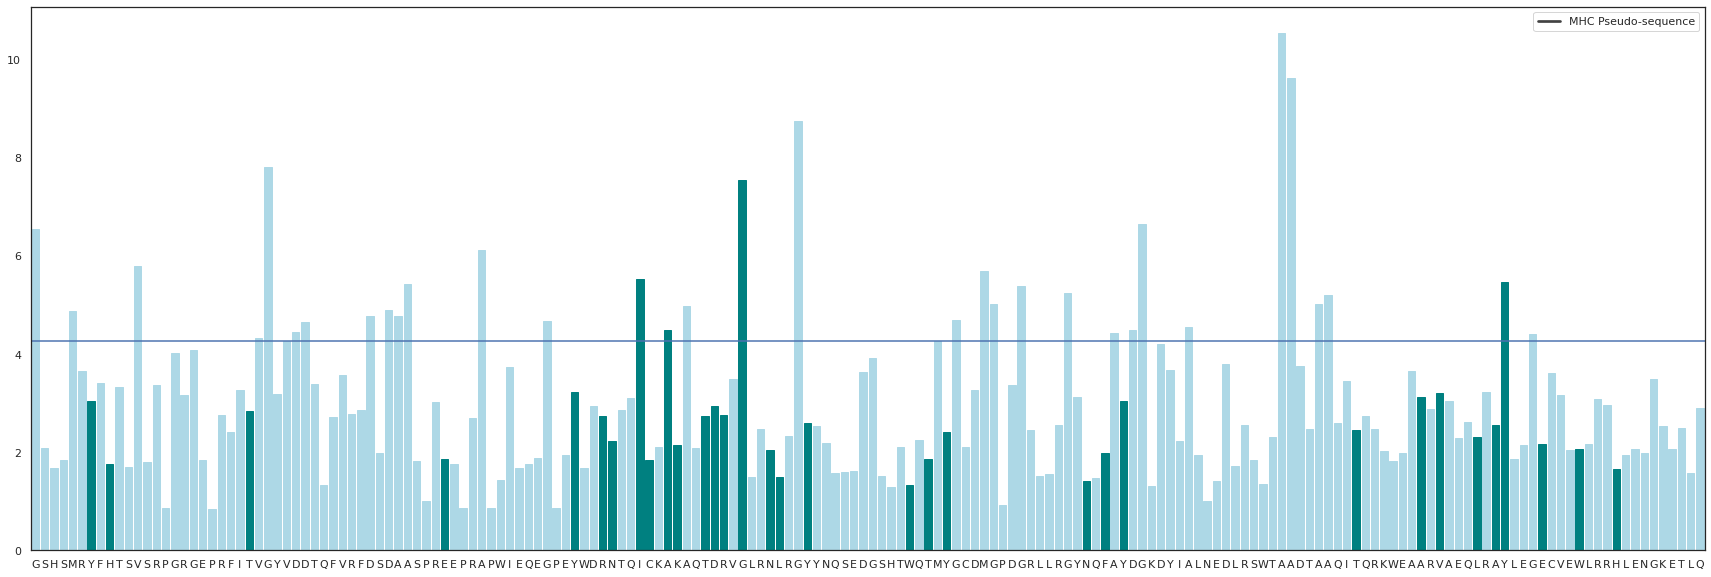



YHTEYRNICAKTDVGNLYWTYNFYTWAVLAYEWH

GMVVGDDDDAAAGIAAGGMGMGGGADGAAAAAYG
0.45238095238095233



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 83
HLA: HLA-B*52:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRIALRYYNQSEAGSHTWQTMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRHLENGKETLQ
threshold: 4.353821168462914


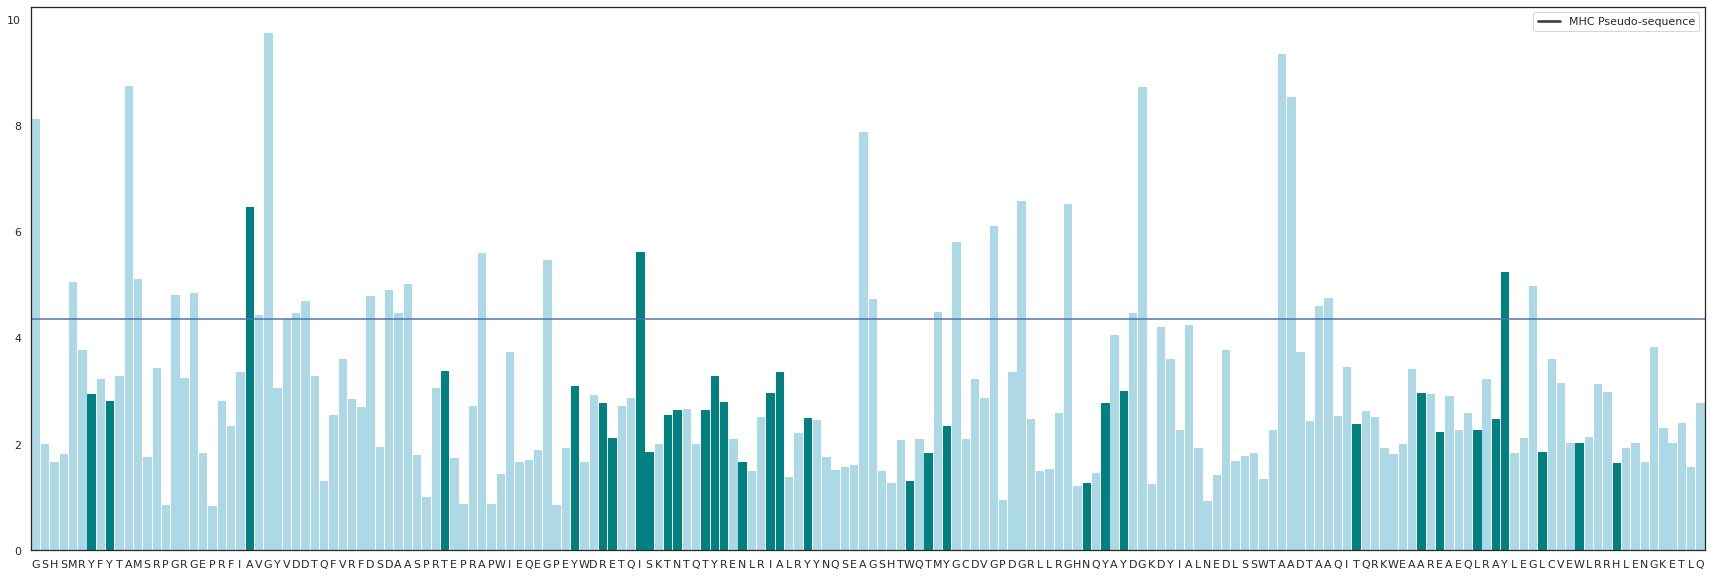



YYATYREISTNTYENIAYWTYNYYTWAELAYLWH

GMAMGGAVGVDDDDAAAGIAGMGGGGDGAAAAYG
0.4975262832405689



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 88
HLA: HLA-C*17:01
GSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEAGSHTIQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQISQRKLEAAREAEQLRAYLEGECVEWLRGYLENGKETLQ
threshold: 4.245929024436257


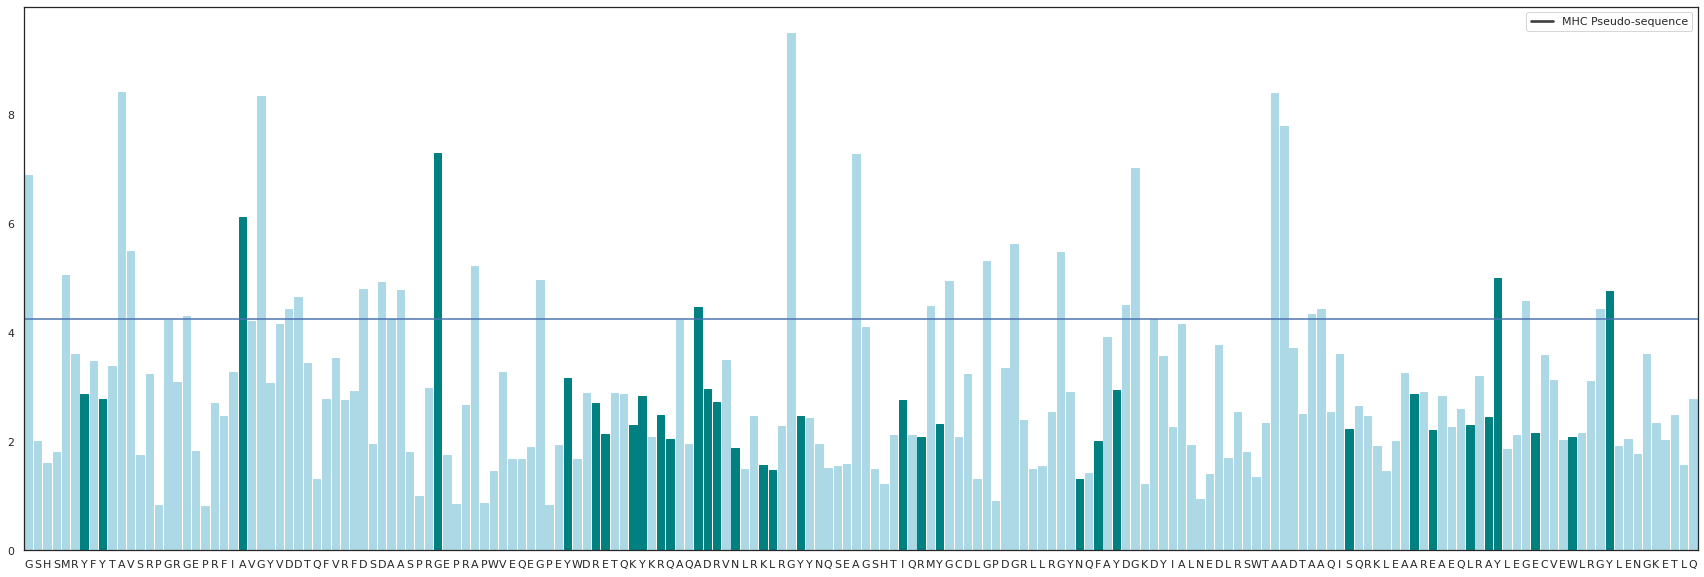



YYAGYREKYRQADVNKLYIRYNFYSLAELAYEWY

GMAVGAGDDDDAAGAGAGAMGGGGDGAAAAYGGY
0.4889713461142033



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 101
HLA: HLA-B*51:08
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRENLRIALRYYNQSEAGSHTWQTMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVEWLRRHLENGKETLQ
threshold: 4.233711771445699


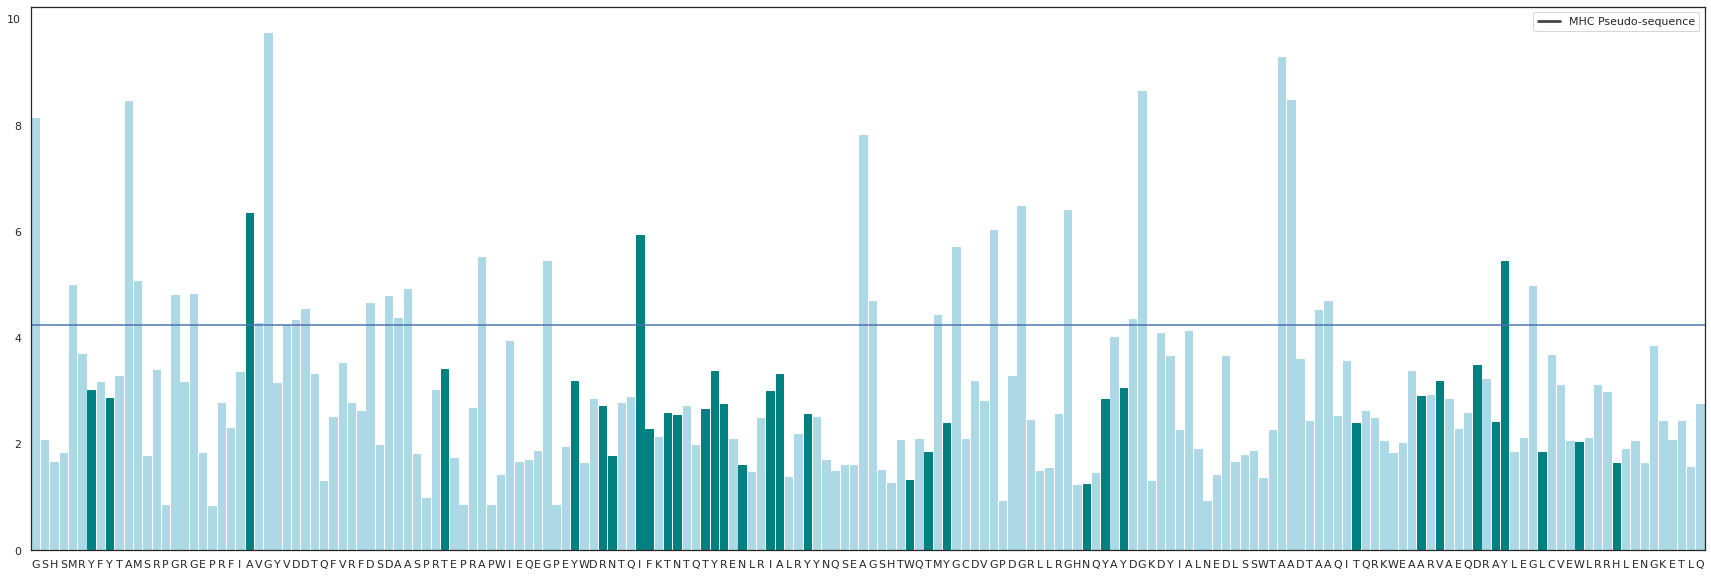



YYATYRNIFTNTYENIAYWTYNYYTWAVDAYLWH

GMAMGGAVGVDDDDAAAGIAGMGGGGDGAAAAYG
0.5150484436198722



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 98
HLA: HLA-B*39:24
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTDRESLRNLRGYYNQSEAGSHTLQSTYGCDVGPDGRLLRGHNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRTYLEGTCVEWLRRYLENGKETLQ
threshold: 4.096123208805007


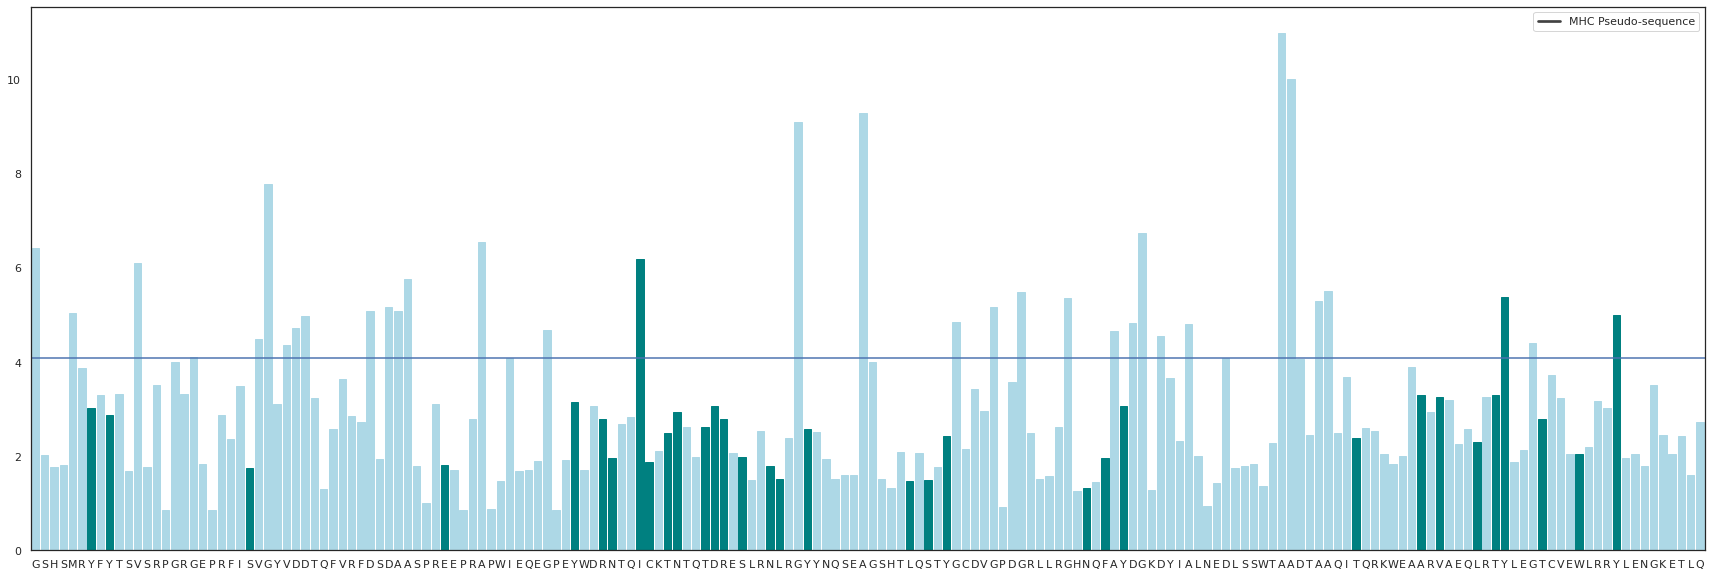



YYSEYRNICTNTDESNLYLSYNFYTWAVLTYTWY

GMVGVGVDDDDAAAGIGAGGGGADGDAAAAAYGY
0.47052154195011336



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 88
HLA: HLA-B*41:01
GSHSMRYFHTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTWQRMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARVAEQDRAYLEGTCVEWLRRYLENGKDTLE
threshold: 4.22202578457919


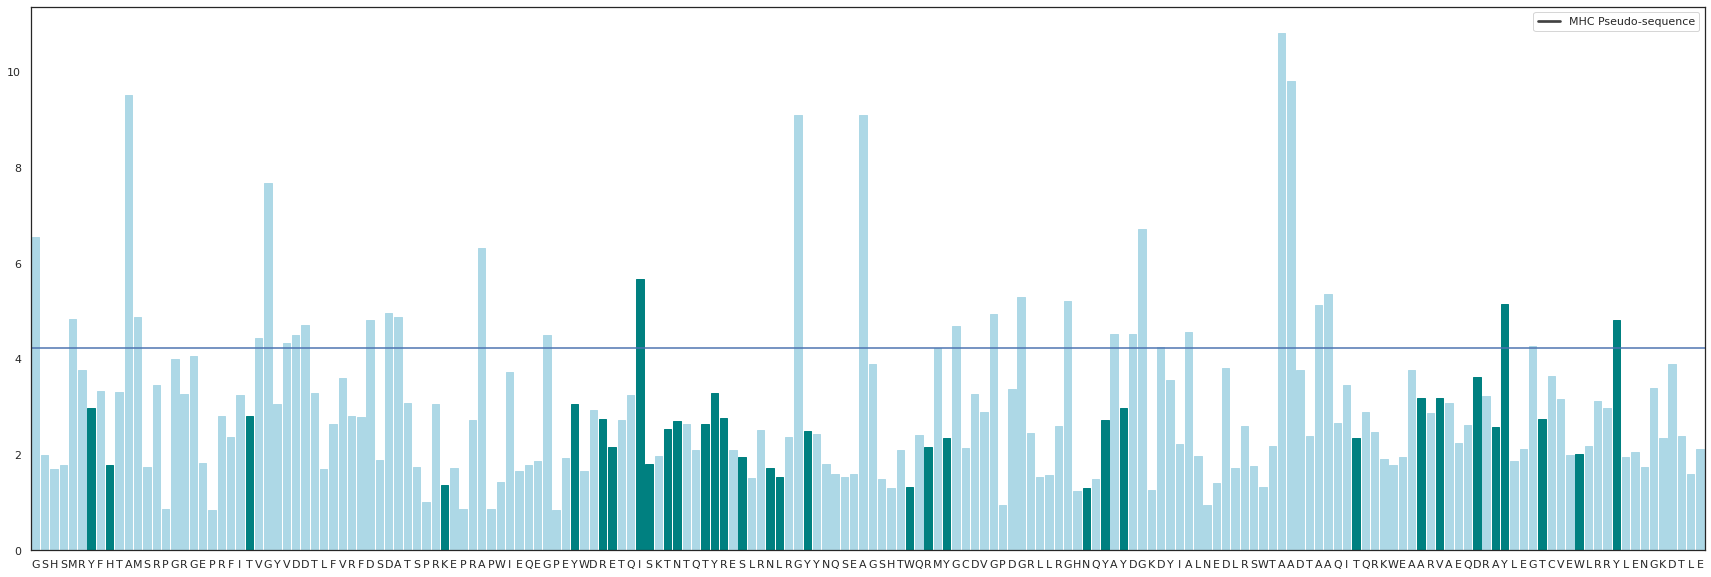



YHTKYREISTNTYESNLYWRYNYYTWAVDAYTWY

GMAMVGVDDDDAAGIGAMGGGGADGDAAAAAYGY
0.4681508967223253



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 116
HLA: HLA-B*56:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHTWQTMYGCDLGPDGRLLRGHNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.366991766567888


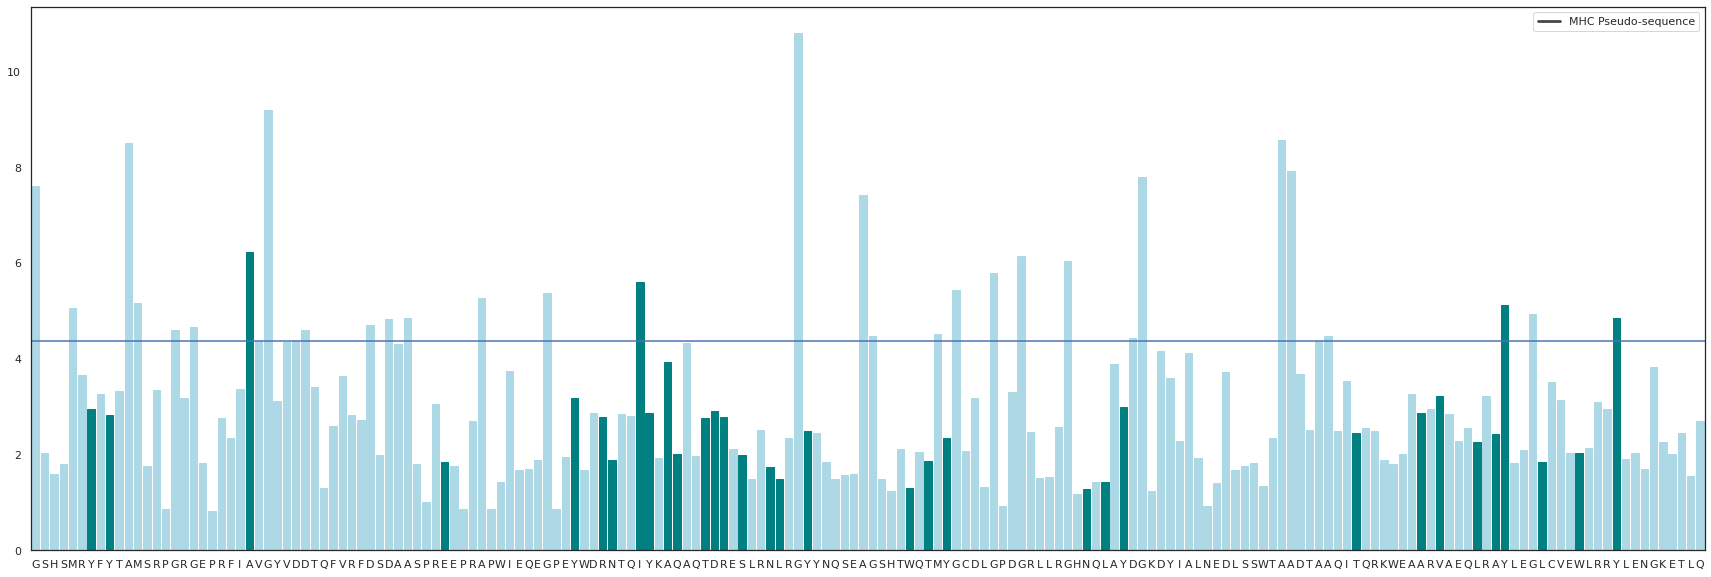



YYAEYRNIYAQTDESNLYWTYNLYTWAVLAYLWY

GMAMGGAVGDDDDAAGIGAGMGGGGDGAAAAYGY
0.479179550608122



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 117
HLA: HLA-B*53:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRENLRIALRYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.385044195713141


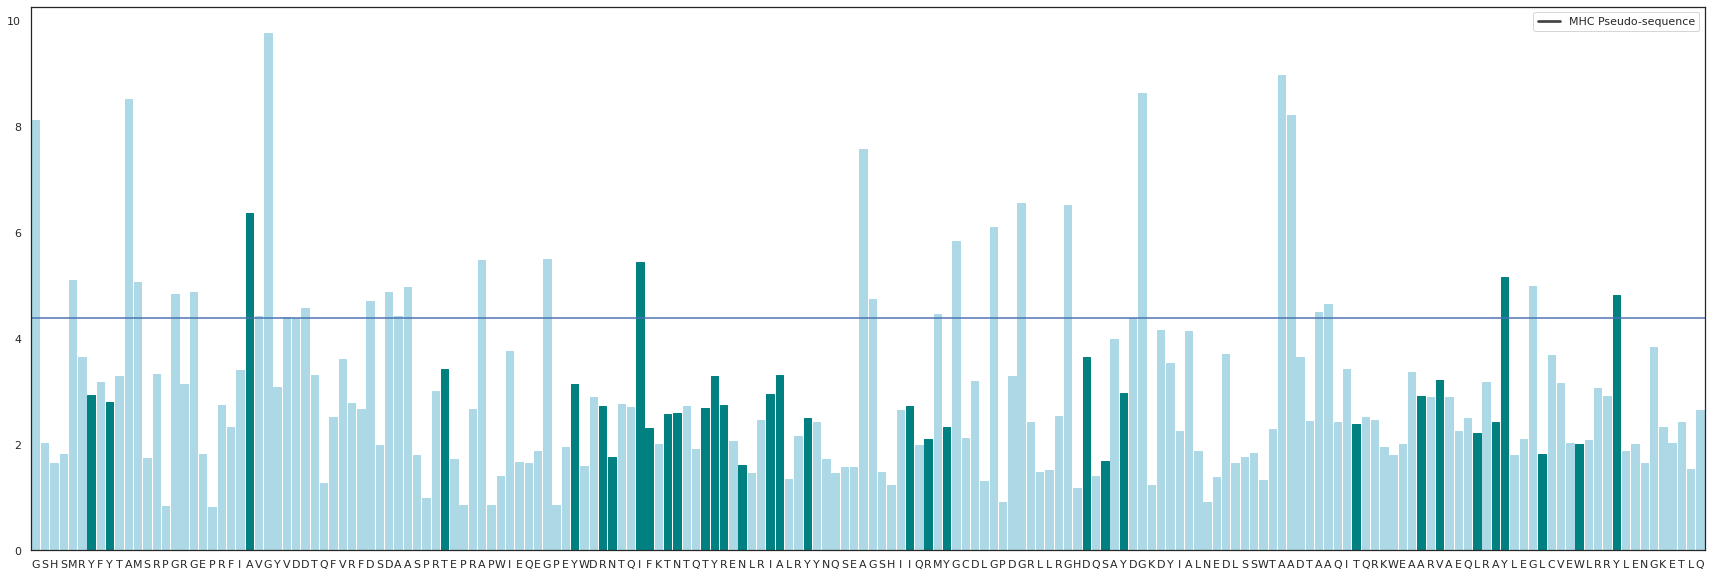



YYATYRNIFTNTYENIAYIRYDSYTWAVLAYLWY

GMAMGGAVGVDDDAAAGIAGMGGGGDGAAAAYGY
0.5579262007833437



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 130
HLA: HLA-B*15:11
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDRNTQIYKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQWRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.380176250751202


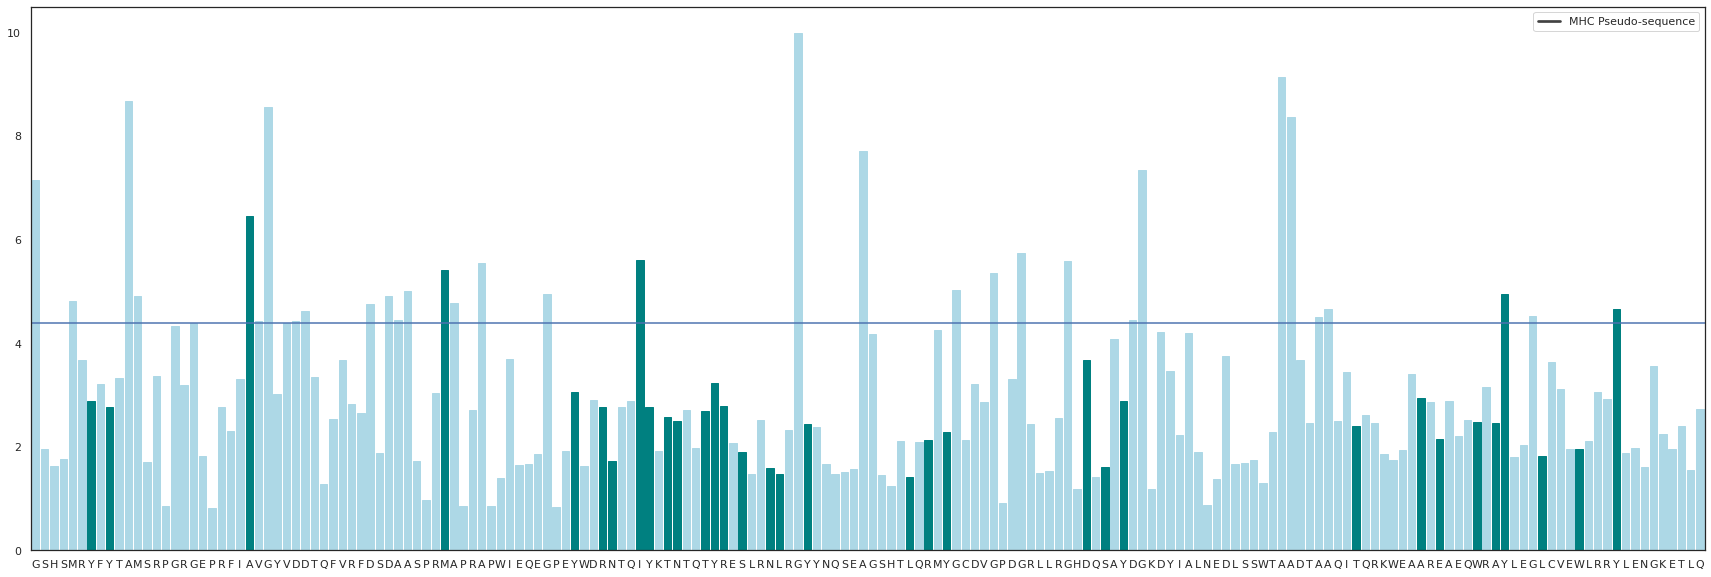



YYAMYRNIYTNTYESNLYLRYDSYTWAEWAYLWY

GMAMGAVGDDDDAAMAAGIGAGGGGDGAAAAYGY
0.5056689342403629



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 141
HLA: HLA-B*27:03
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEHWDRETQICKAKAQTDREDLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.254871990663785


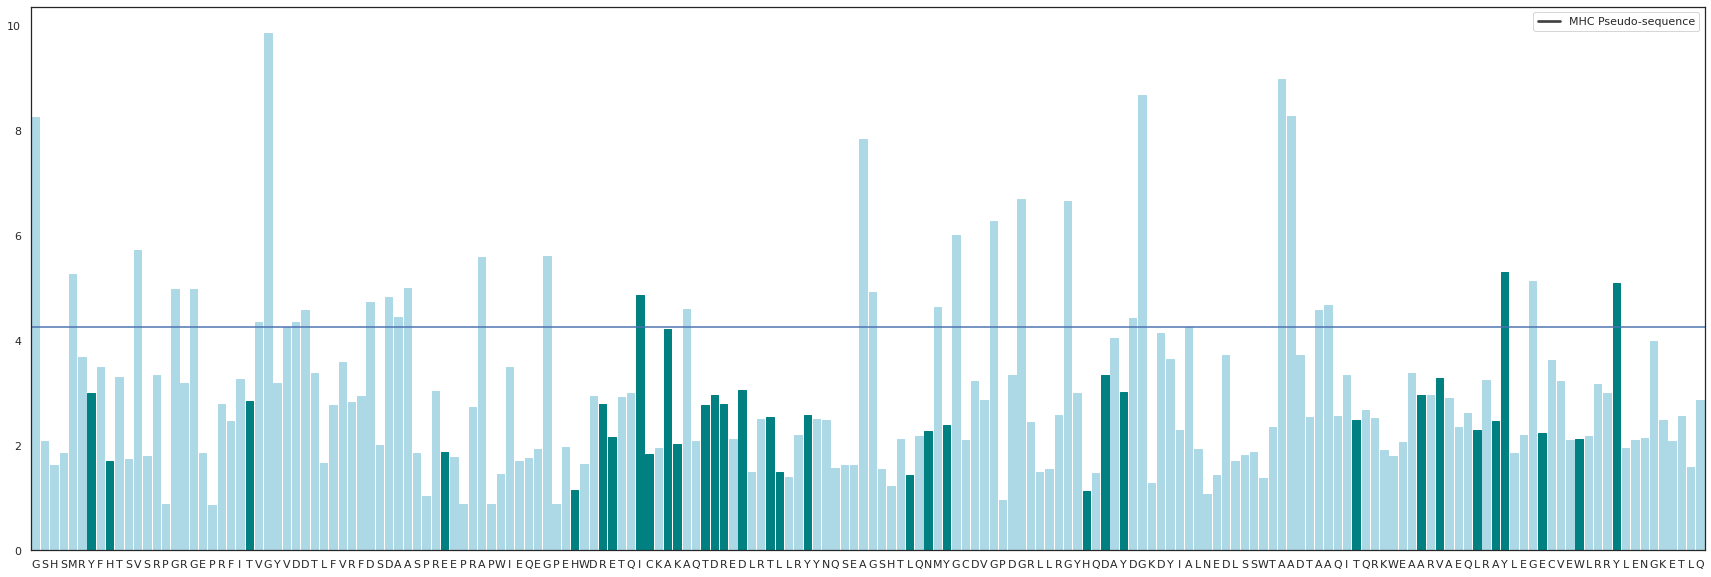



YHTEHREICAKTDEDTLYLNYHDYTWAVLAYEWY

GMVGGVGVDDDDAAAGIAAGMGGGGDGAAAAYGY
0.4703153988868275



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 188
HLA: HLA-A*02:20
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRNVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.307403889108212


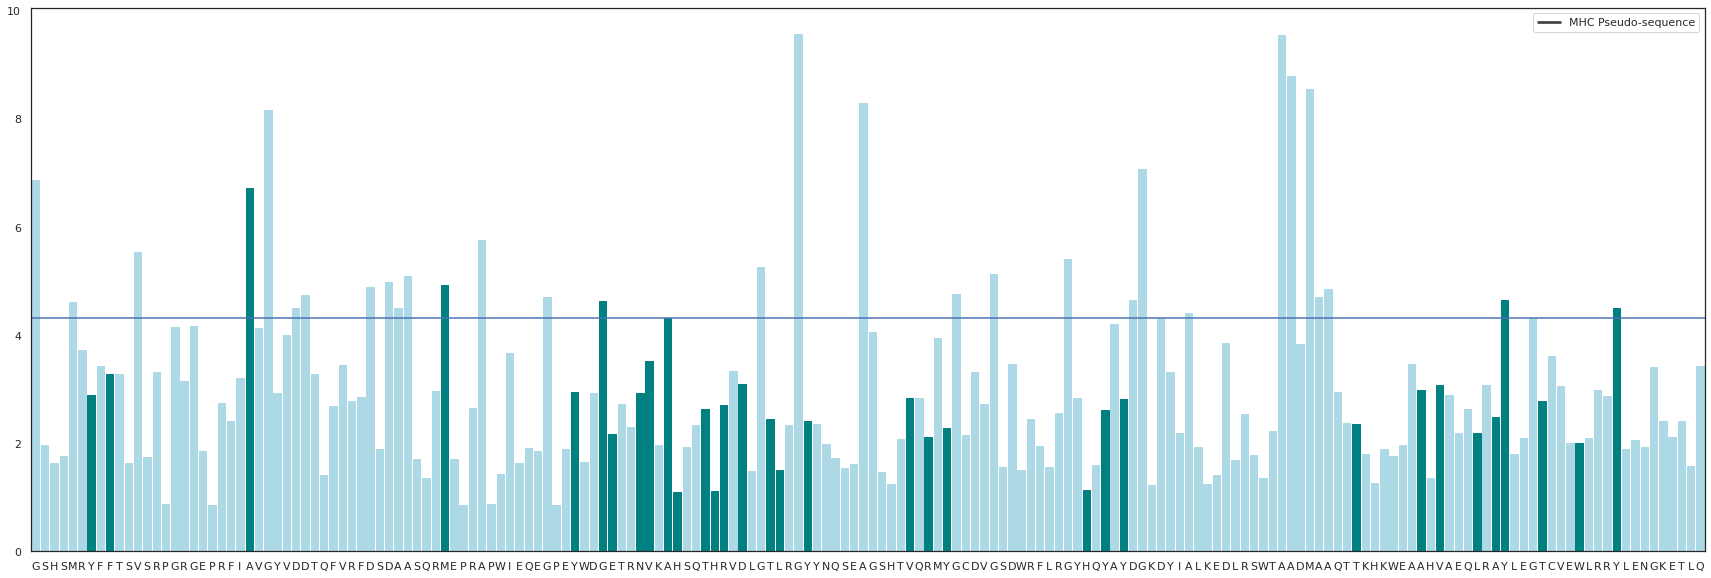



YFAMYGENVAHTHVDTLYVRYHYYTWAVLAYTWY

GMVAGDDDDAAMAGGAGGAGGGDGDAAAMAAYGY
0.5313337456194599



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 171
HLA: HLA-A*30:02
GSHSMRYFSTSVSRPGSGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQERPEYWDQETRNVKAHSQTDRENLGTLRGYYNQSEAGSHTIQIMYGCDVGSDGRFLRGYEQHAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARRAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.31496246516356


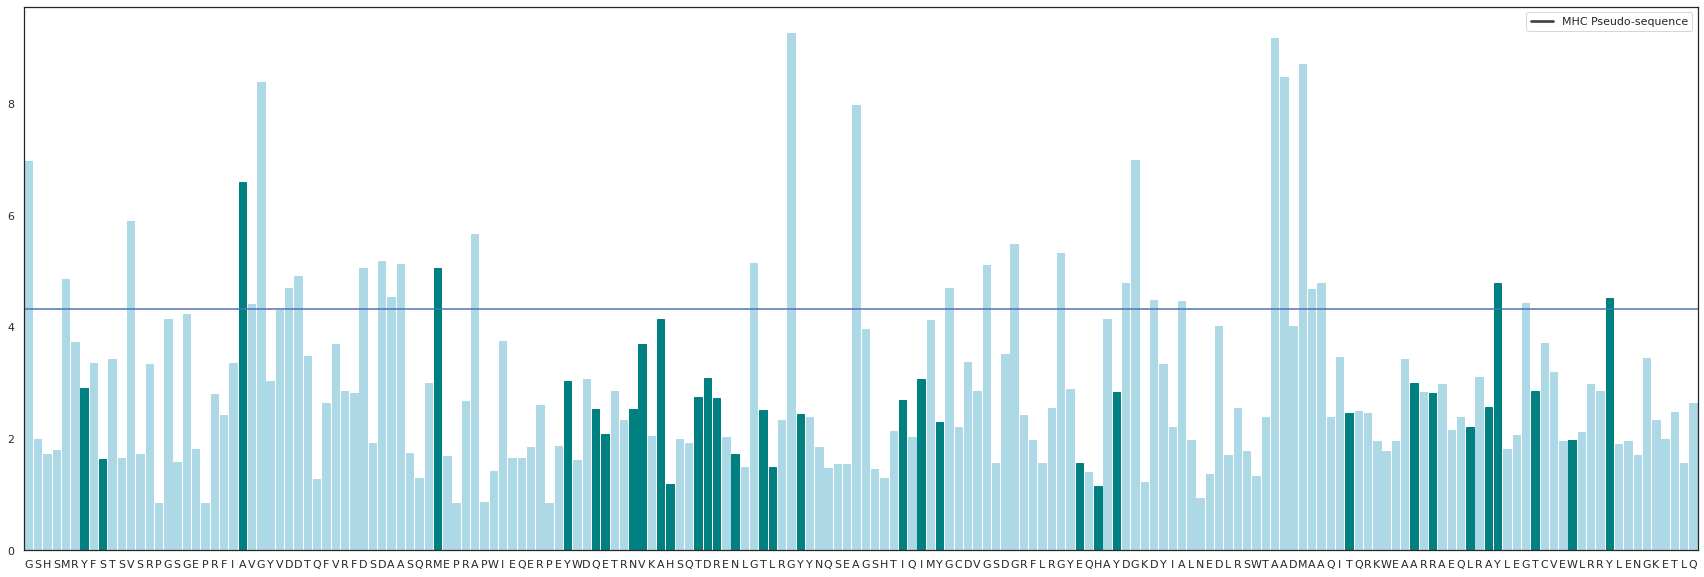



YSAMYQENVAHTDENTLYIIYEHYTWARLAYTWY

GMVAVGVDDDDAAMAGGAGGGGDGDAAAMAAYGY
0.5061842918985777



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 172
HLA: HLA-B*15:18
GSHSMRYFYTAMSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.354916949604833


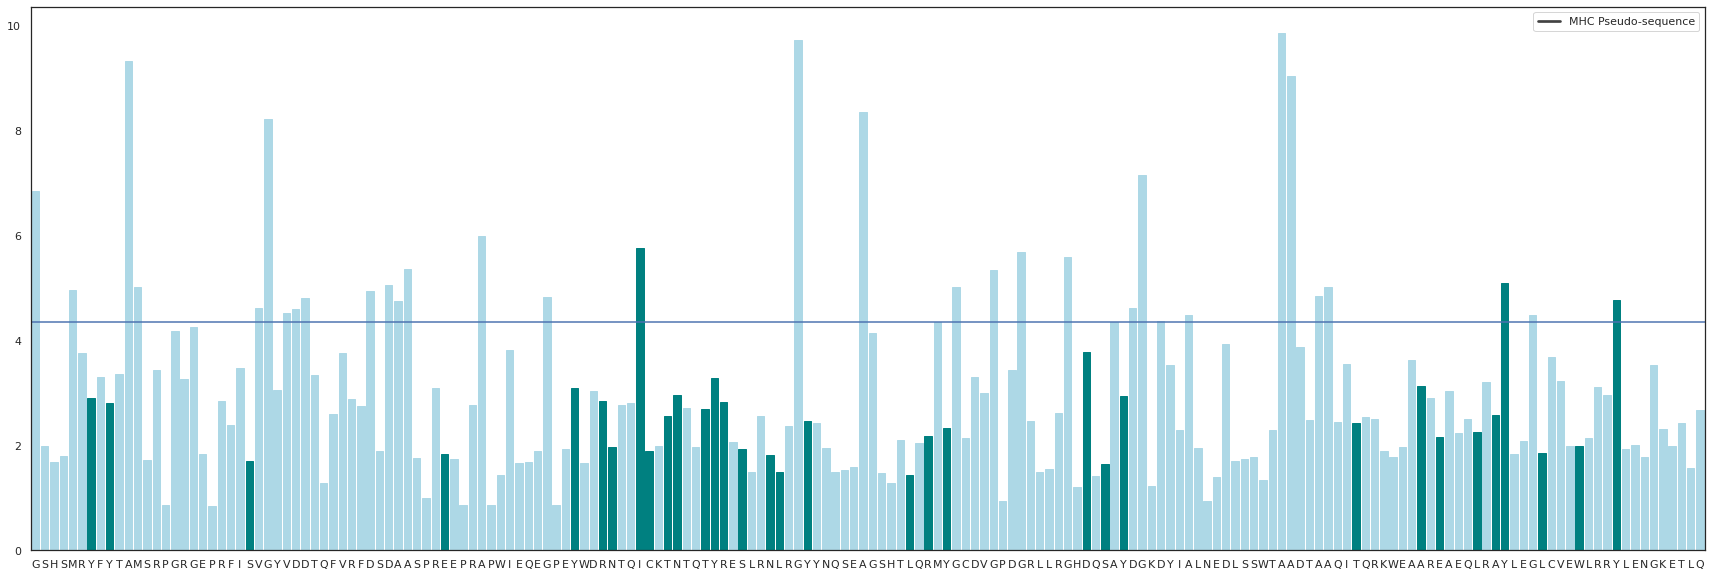



YYSEYRNICTNTYESNLYLRYDSYTWAELAYLWY

GMAMVGVDDDDAAAGIGAMGGGGDGDAAAAAYGY
0.4670171098742527



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 196
HLA: HLA-B*27:06
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDRESLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.398914882114956


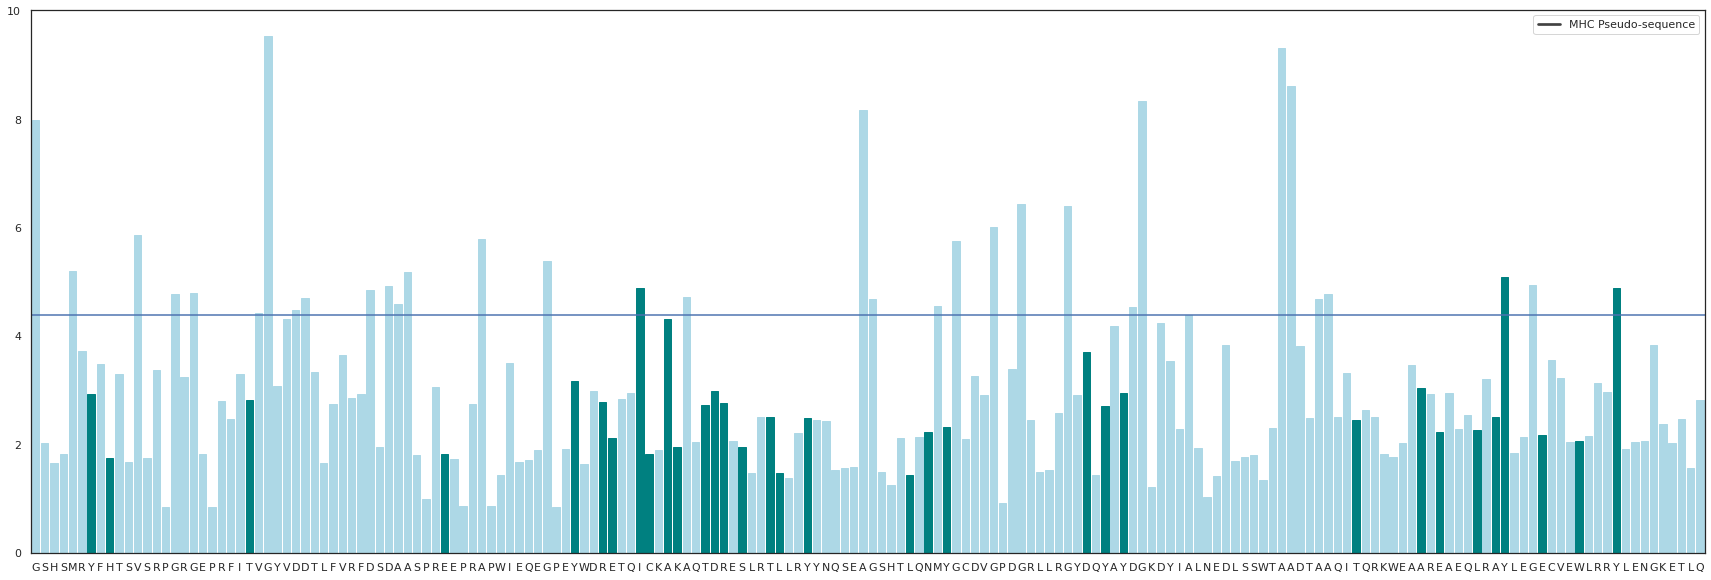



YHTEYREICAKTDESTLYLNYDYYTWAELAYEWY

GMVGGVGDDDDAAAGIAAGMGGGGDGAAAAAYGY
0.4876314162028448



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 210
HLA: HLA-A*69:01
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.198424130394345


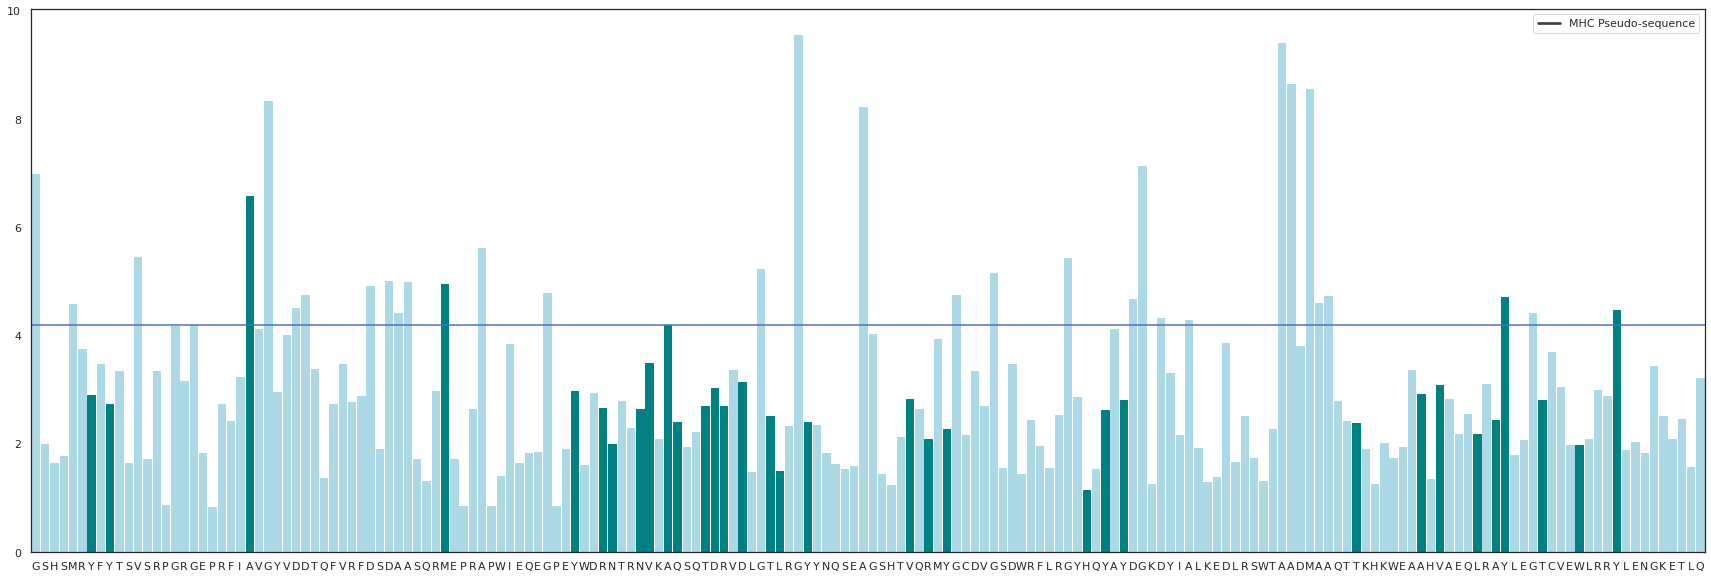



YYAMYRNNVAQTDVDTLYVRYHYYTWAVLAYTWY

GMVGAGDDDDAAMAGAGGAGGGDGDAAAMAAYGY
0.5459699031127603



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 214
HLA: HLA-B*35:08
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRESLRNLRGYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQRRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.314946254837179


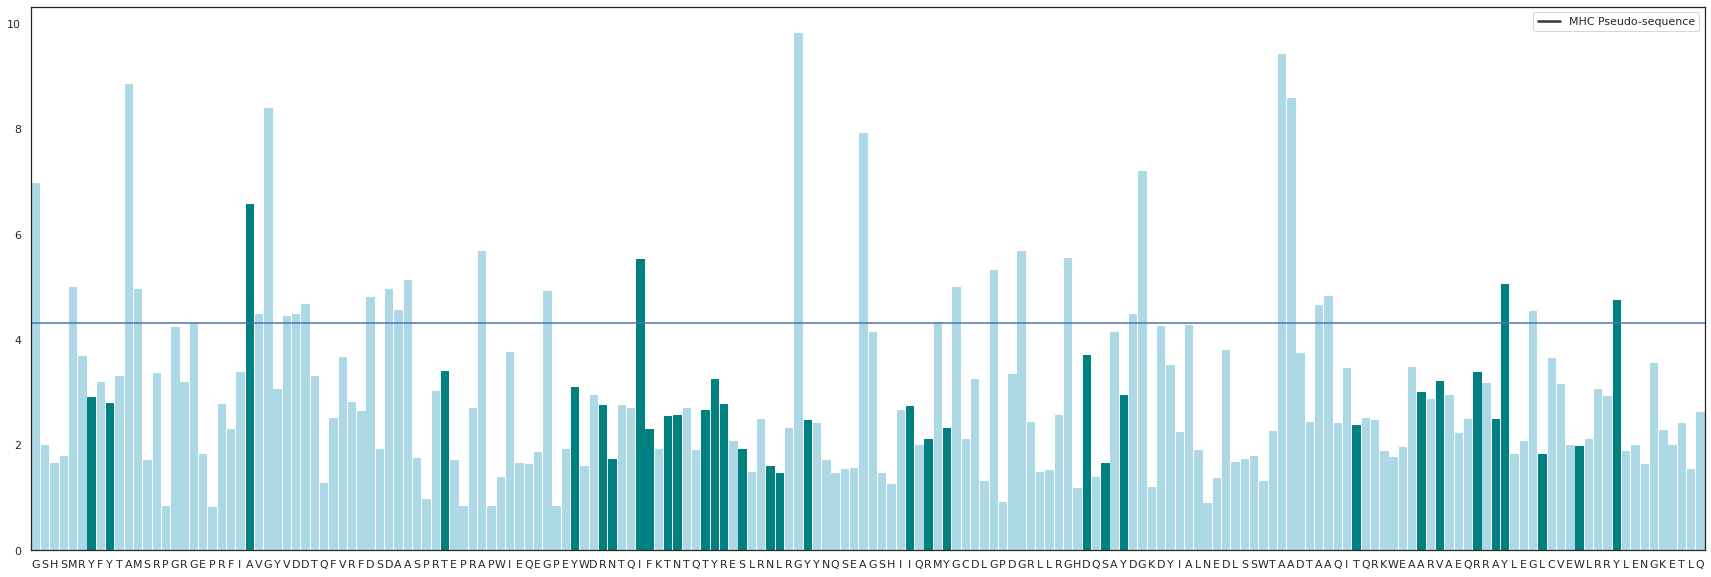



YYATYRNIFTNTYESNLYIRYDSYTWAVRAYLWY

GMAMGAVGVDDDDAAAGIGAMGGGGDGAAAAYGY
0.5354566068851783



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 234
HLA: HLA-A*33:01
GSHSMRYFTTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAHSQIDRVDLGTLRGYYNQSEAGSHTIQMMYGCDVGSDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRHLENGKETLQ
threshold: 4.164612338074252


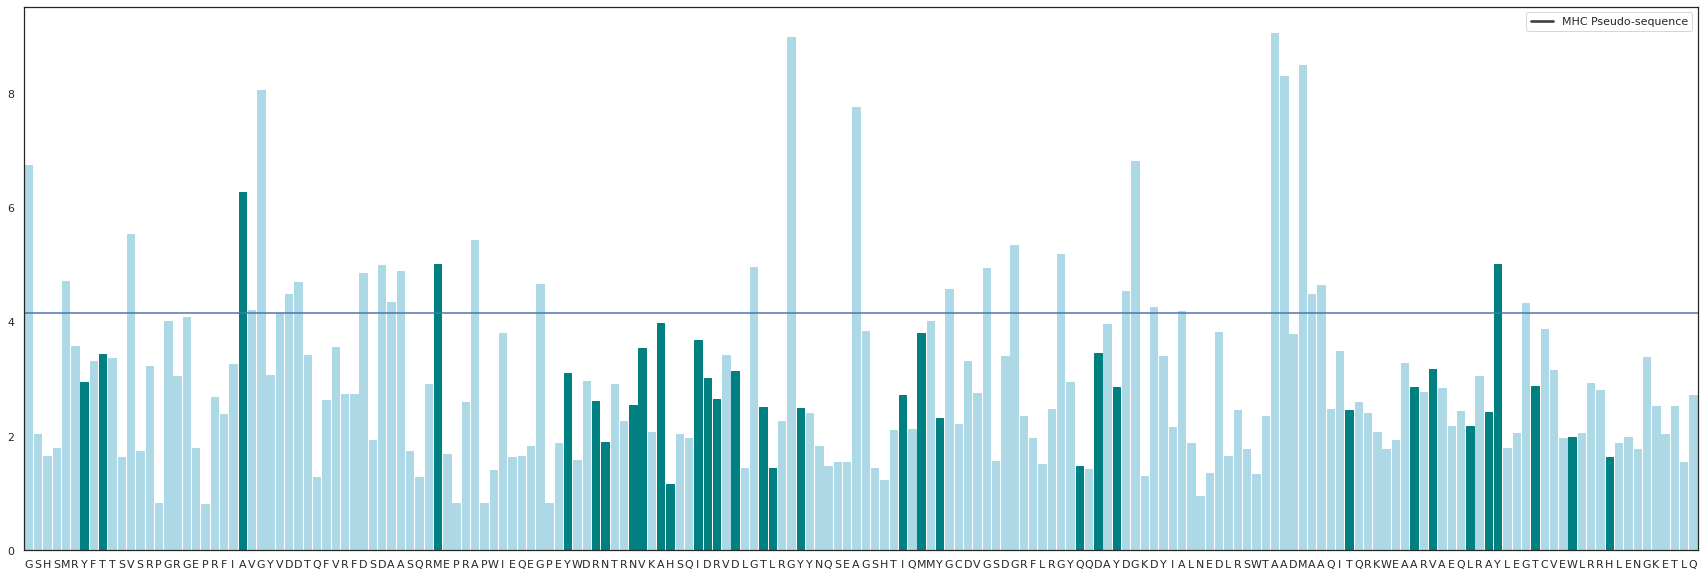



YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWH

GMVAVGVDDDDAAMAGGGAGGGGDGDAAAMAAYG
0.5372088229231087



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 237
HLA: HLA-B*54:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHTWQTMYGCDLGPDGRLLRGHNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.3369120022415615


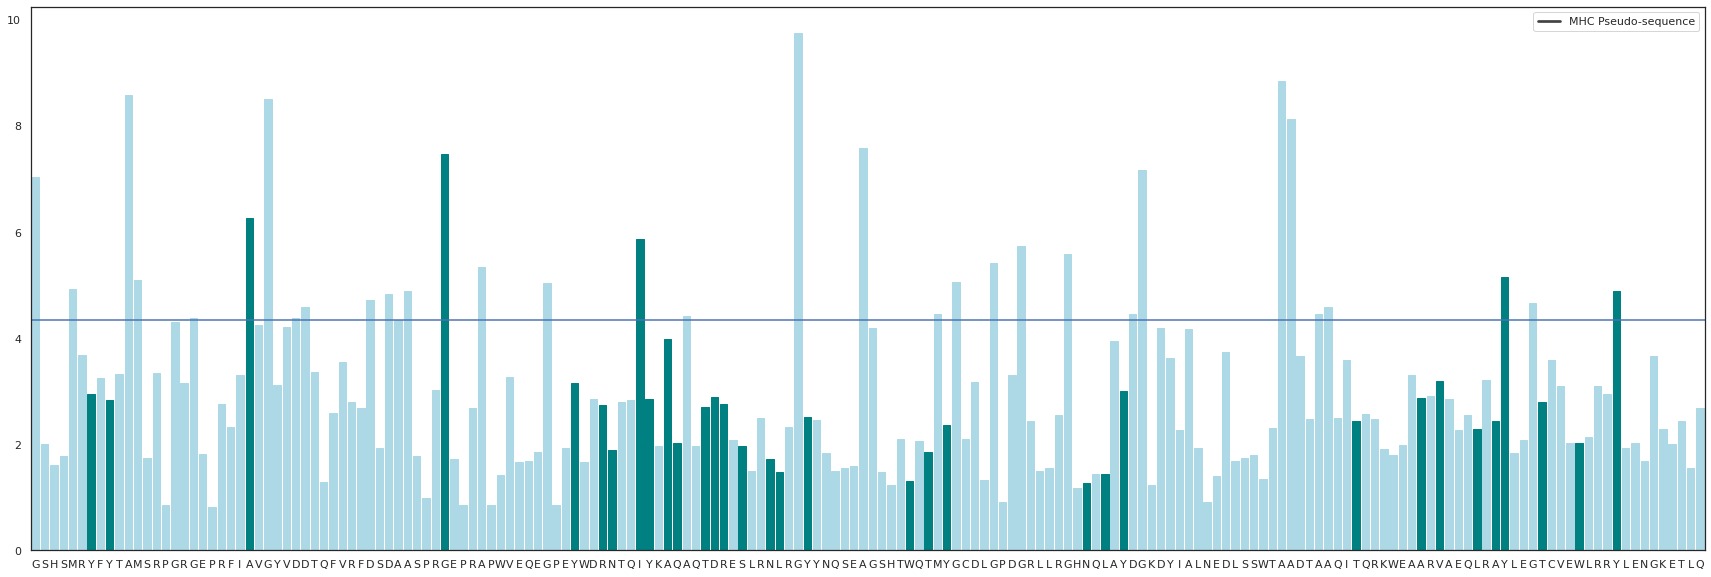



YYAGYRNIYAQTDESNLYWTYNLYTWAVLAYTWY

GMAMGAGDDDDAAGAGIAGAMGGGGDGAAAAYGY
0.5112347969490827



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 239
HLA: HLA-B*39:06
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTDRESLRNLRGYYNQSEAGSHTWQTMYGCDVGPDGRLLRGHNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRTYLEGTCVEWLRRYLENGKETLQ
threshold: 4.314618098685931


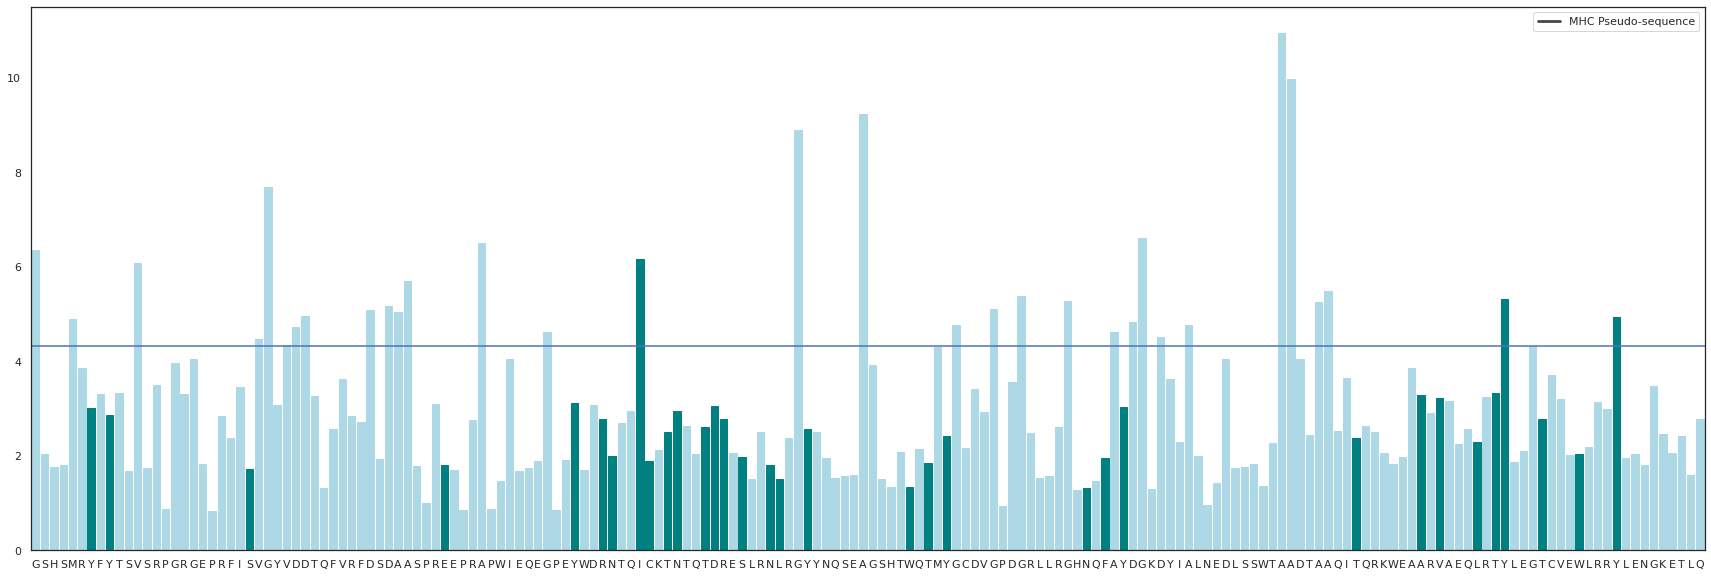



YYSEYRNICTNTDESNLYWTYNFYTWAVLTYTWY

GMVVGVDDDDAAAGIGAMGGGGADGDAAAAAYGY
0.46887239744382603



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 286
HLA: HLA-A*02:04
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQMMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.29345703125


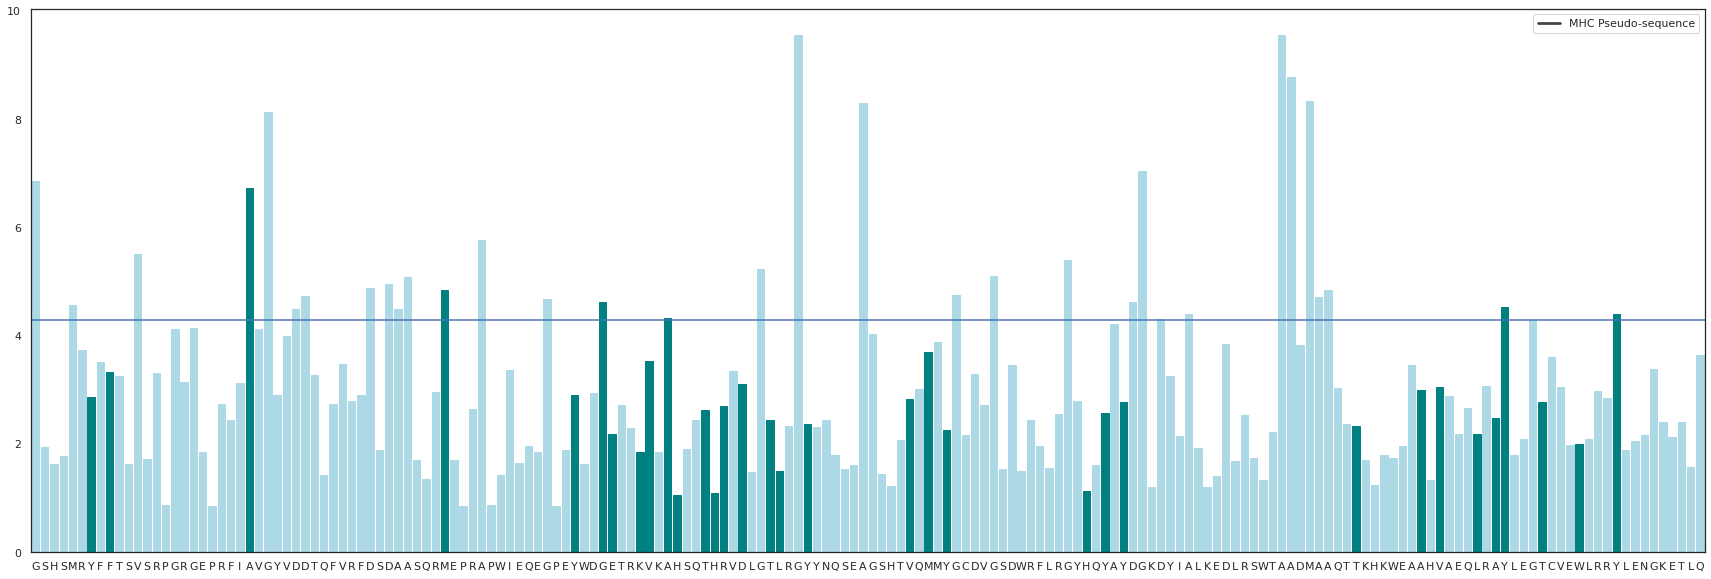



YFAMYGEKVAHTHVDTLYVMYHYYTWAVLAYTWY

GMVAGDDDDAAMAGGAGGAGGGDGDAAAMAAYGY
0.5289631003916718



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 253
HLA: HLA-A*30:01
GSHSMRYFSTSVSRPGSGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQERPEYWDQETRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQIMYGCDVGSDGRFLRGYEQHAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARWAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.253348007503705


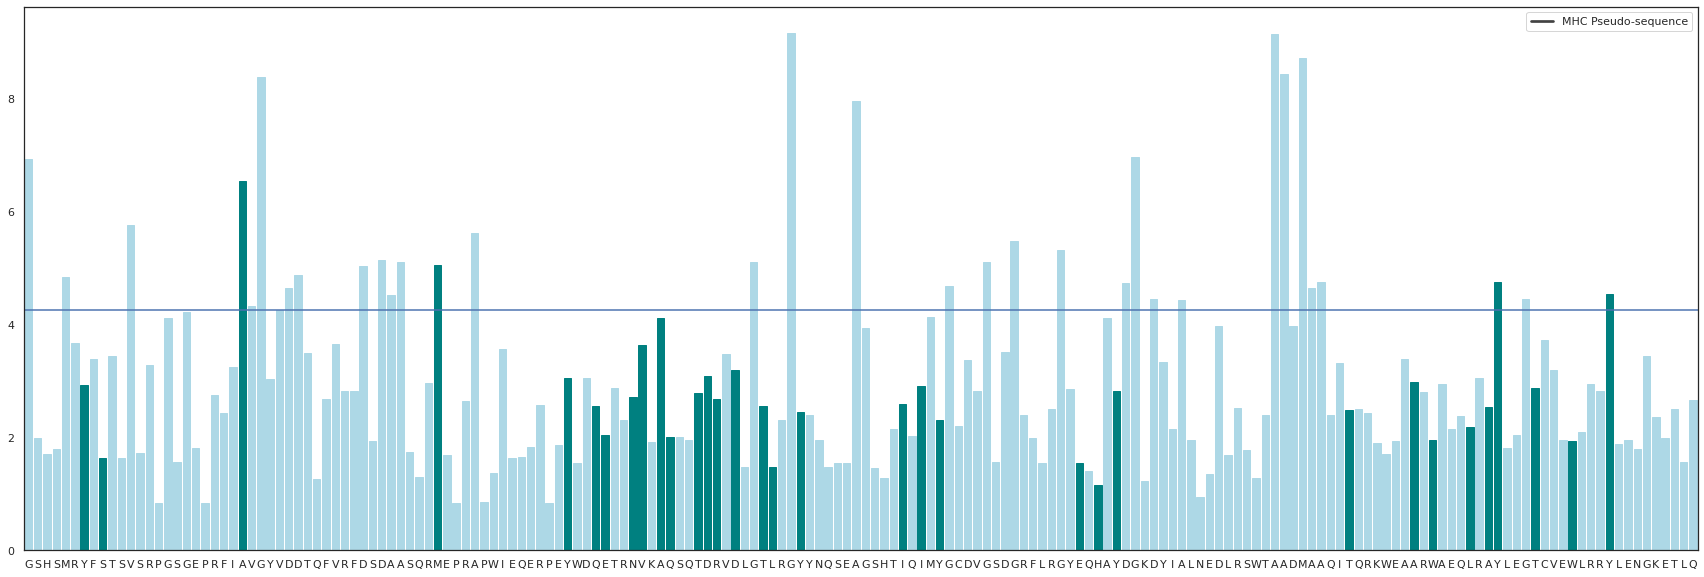



YSAMYQENVAQTDVDTLYIIYEHYTWAWLAYTWY

GMVAVGVDDDDAAMAGGAGGGGDGDAAAMAAYGY
0.5194805194805194



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 281
HLA: HLA-B*50:01
GSHSMRYFHTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTWQRMYGCDLGPDGRLLRGYNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.297265103703292


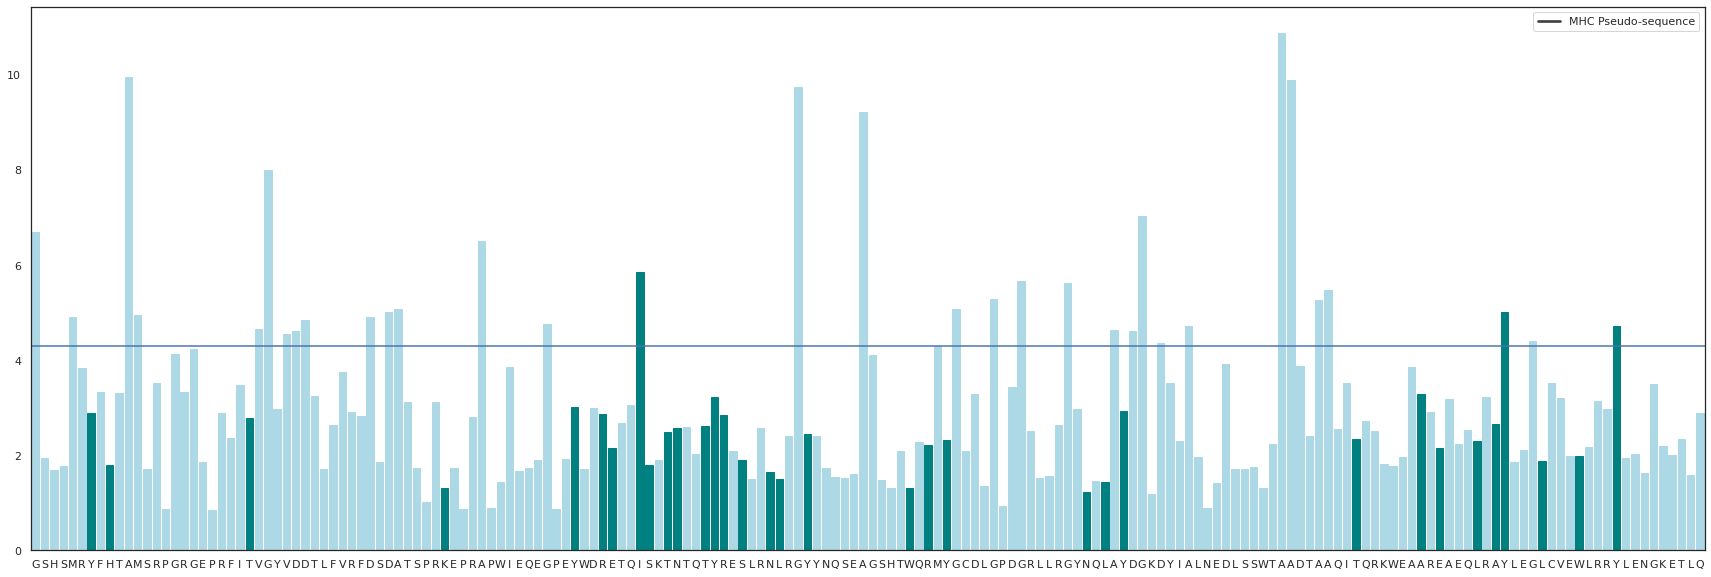



YHTKYREISTNTYESNLYWRYNLYTWAELAYLWY

GMAMVGVDDDDAAGIGAMGGGGADGDAAAAAYGY
0.4308390022675737



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 327
HLA: HLA-C*15:02
CSHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQTDRVNLRKLRGYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQLAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.218711176414373


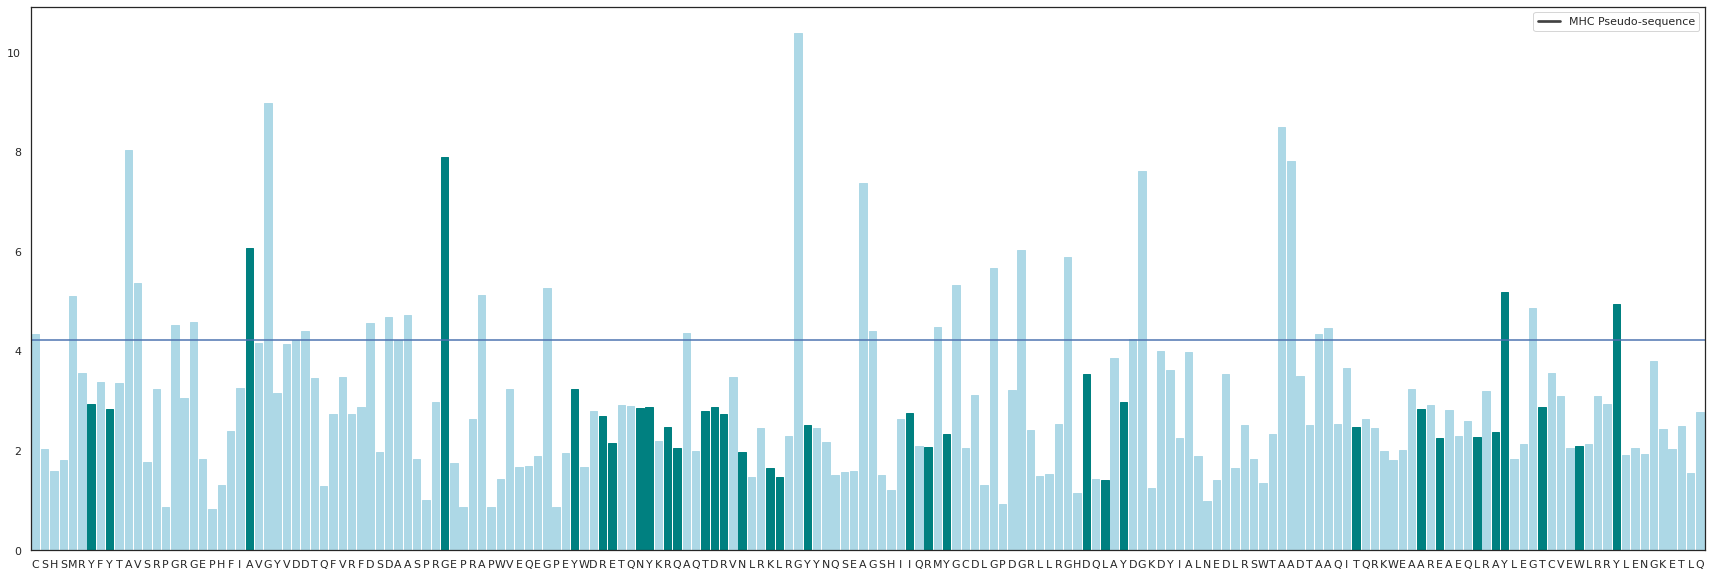



YYAGYRENYRQTDVNKLYIRYDLYTWAELAYTWY

CMAVGGAGDDDAAGAGAGAGMGGGGDGAAAAYGY
0.5157699443413729



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 299
HLA: HLA-C*12:03
CSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEAGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.199833592443562


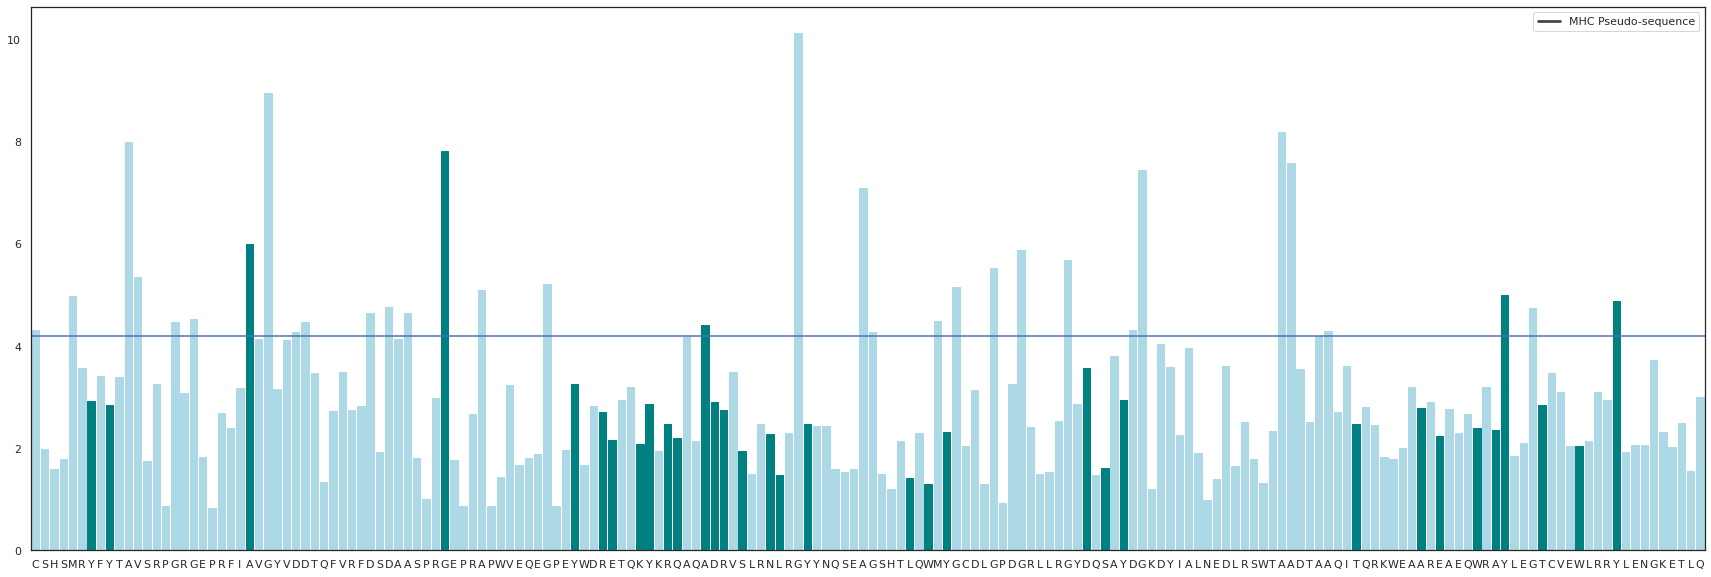



YYAGYREKYRQADVSNLYLWYDSYTWAEWAYTWY

CMAVGGAGDDDDAGAGAGAGMGGGGDGAAAAYGY
0.49618635332921046



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 325
HLA: HLA-B*27:07
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDREDLRTLLRYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.3250980318509615


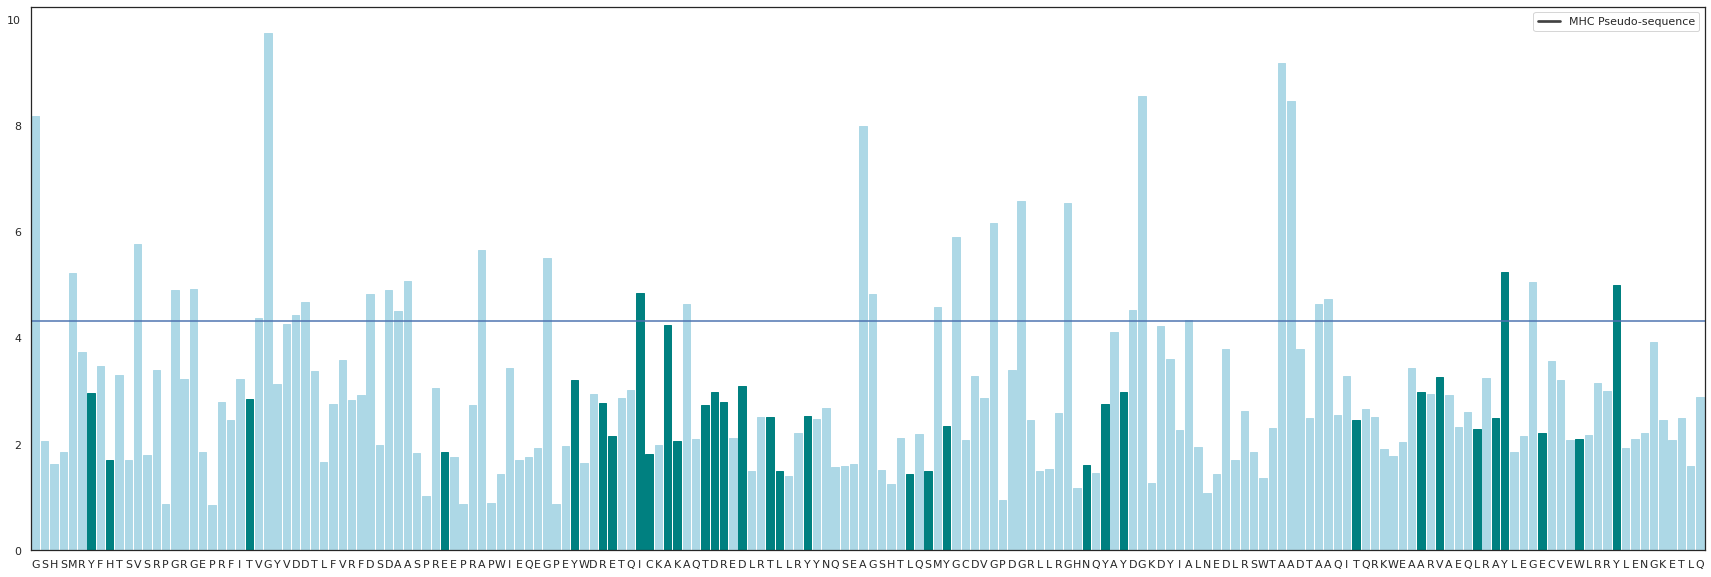



YHTEYREICAKTDEDTLYLSYNYYTWAVLAYEWY

GMVGGVGDDDDAAAGIAAGMGGGGDGAAAAAYGY
0.4782519068233354



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 360
HLA: HLA-B*46:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQWRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.318840196397569


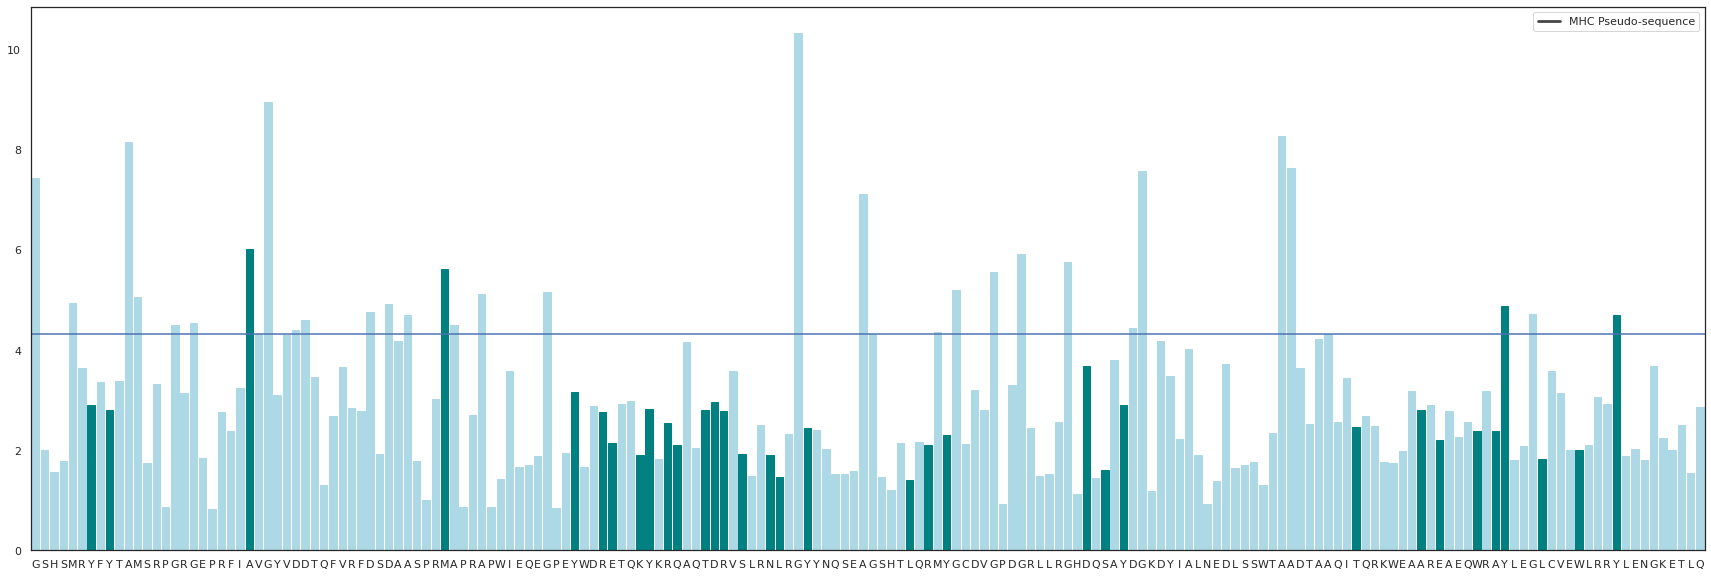



YYAMYREKYRQTDVSNLYLRYDSYTWAEWAYLWY

GMAMGGAVGDDDDAMAAGGAGMGGGGDGAAAYGY
0.479282622139765



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 341
HLA: HLA-B*27:08
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDRESLRNLRGYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.376412221063966


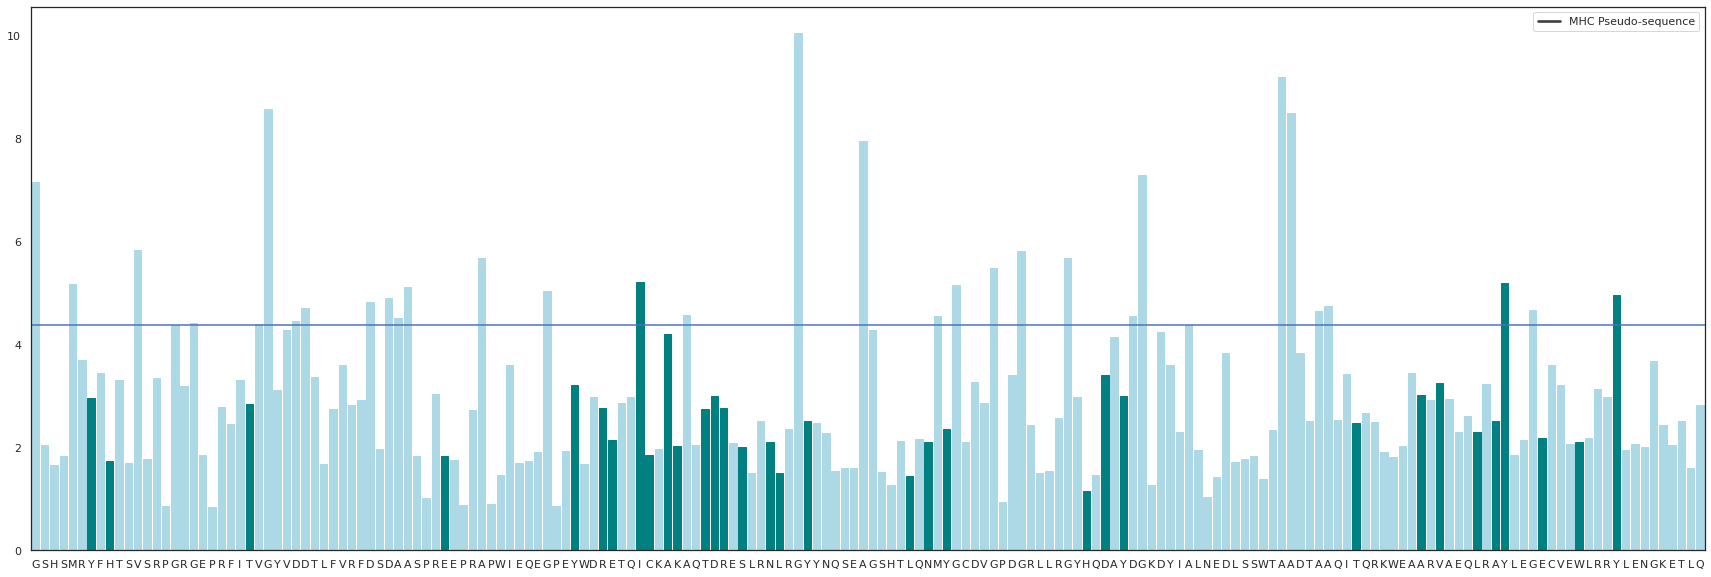



YHTEYREICAKTDESNLYLNYHDYTWAVLAYEWY

GMVGGVGDDDDAAAGIAGAMGGGGDGAAAAAYGY
0.4734075448361163



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 369
HLA: HLA-A*26:01
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAHSQTDRANLGTLRGYYNQSEDGSHTIQRMYGCDVGPDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWETAHEAEQWRAYLEGRCVEWLRRYLENGKETLQ
threshold: 4.282326799098069


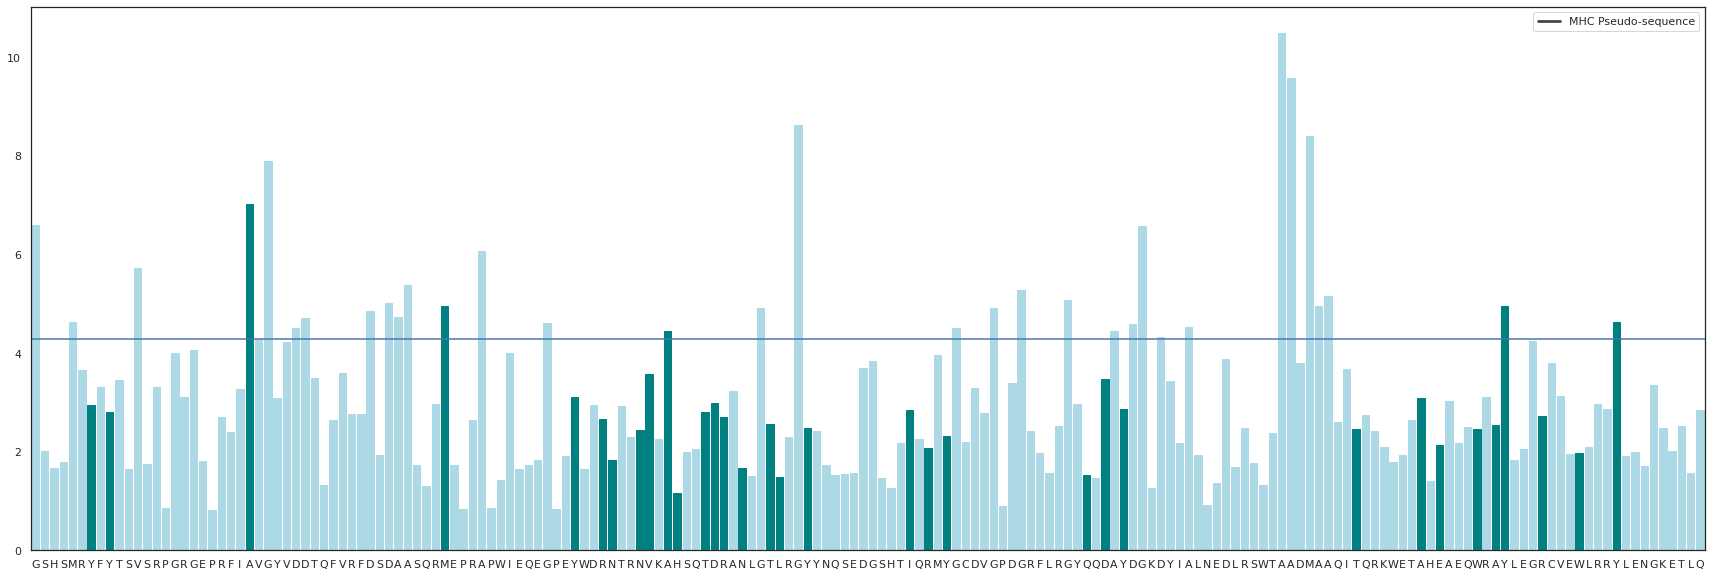



YYAMYRNNVAHTDANTLYIRYQDYTWAEWAYRWY

GMVAVGDDDDAAMAGAGGGGGGADGDAAAMAAYY
0.5203050917336631



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 393
HLA: HLA-C*01:02
CSHSMKYFFTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMCGCDLGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.301474845439726


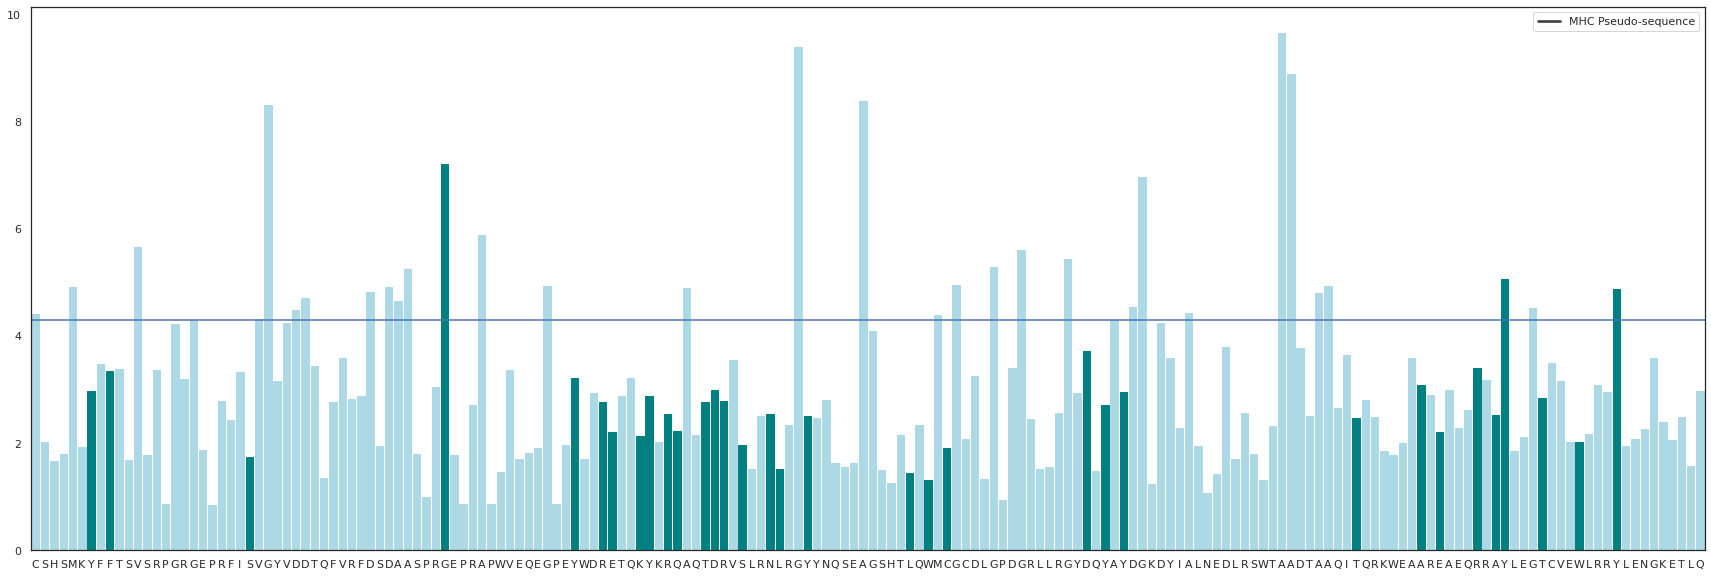



YFSGYREKYRQTDVSNLYLWCDYYTWAERAYTWY

CMVGVGDDDDAAGAGAGAMGGGGADGAAAAAYGY
0.4919604205318491



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 422
HLA: HLA-B*27:04
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDRESLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.376757002554799


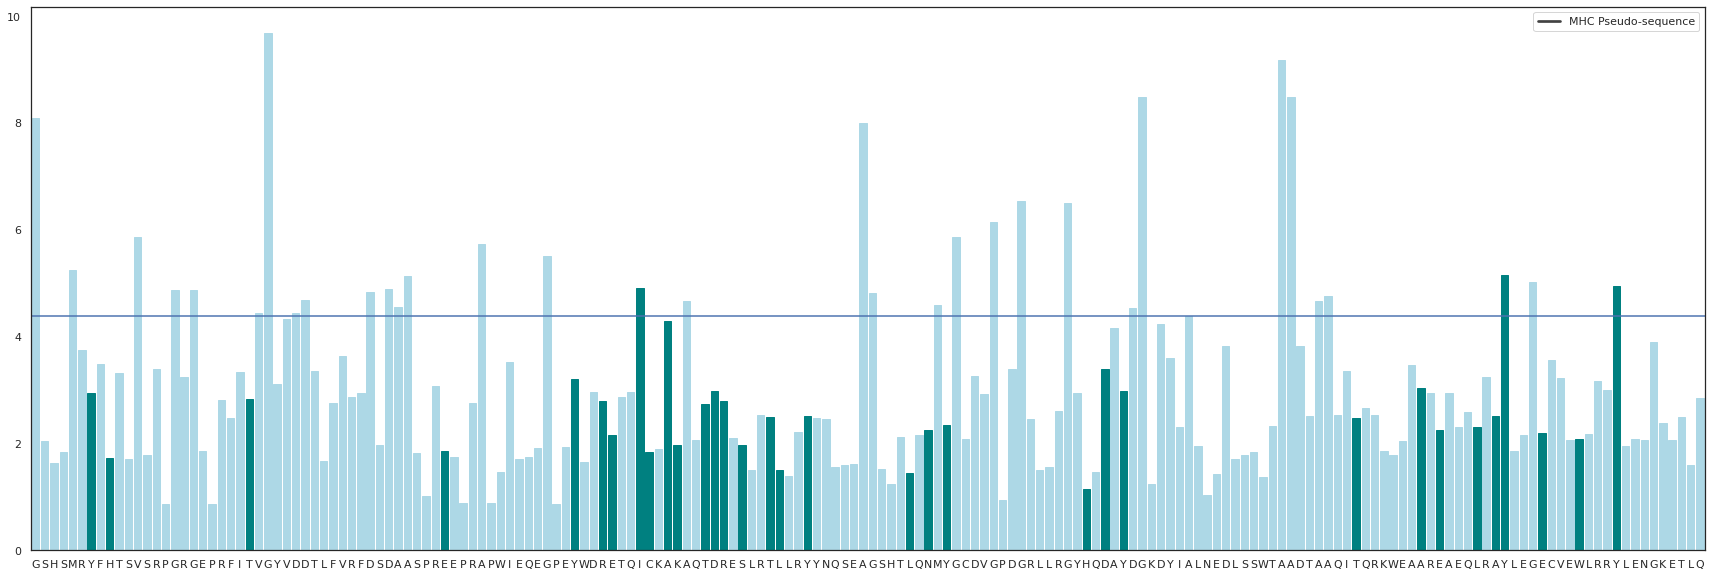



YHTEYREICAKTDESTLYLNYHDYTWAELAYEWY

GMVGGVGDDDDAAAGIAAGMGGGGDGAAAAAYGY
0.47134611420325706



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 364
HLA: HLA-A*02:02
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASRRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTLQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.2518629136976305


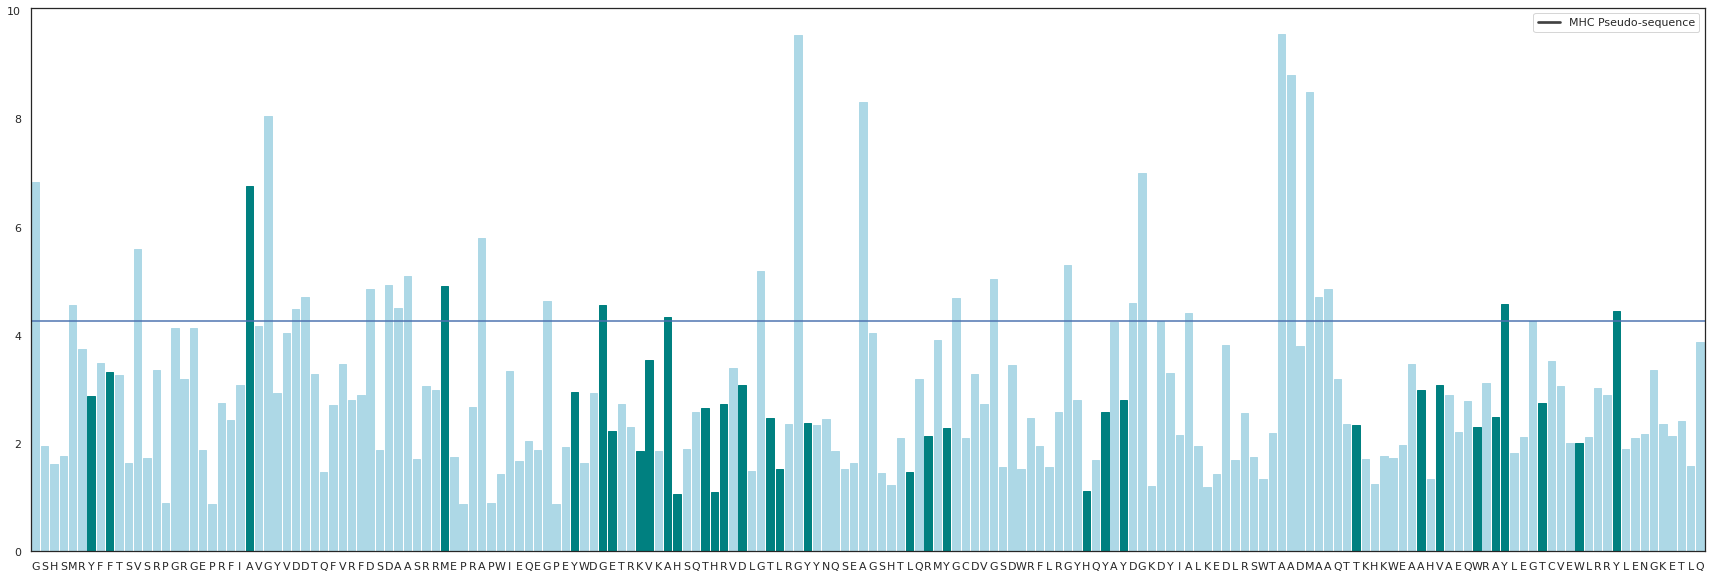



YFAMYGEKVAHTHVDTLYLRYHYYTWAVWAYTWY

GMVAGDDDDAAMAGGAGGAGGGDGDAAAMAAYGY
0.5



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 411
HLA: HLA-C*14:02
CSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMFGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.326031093179744


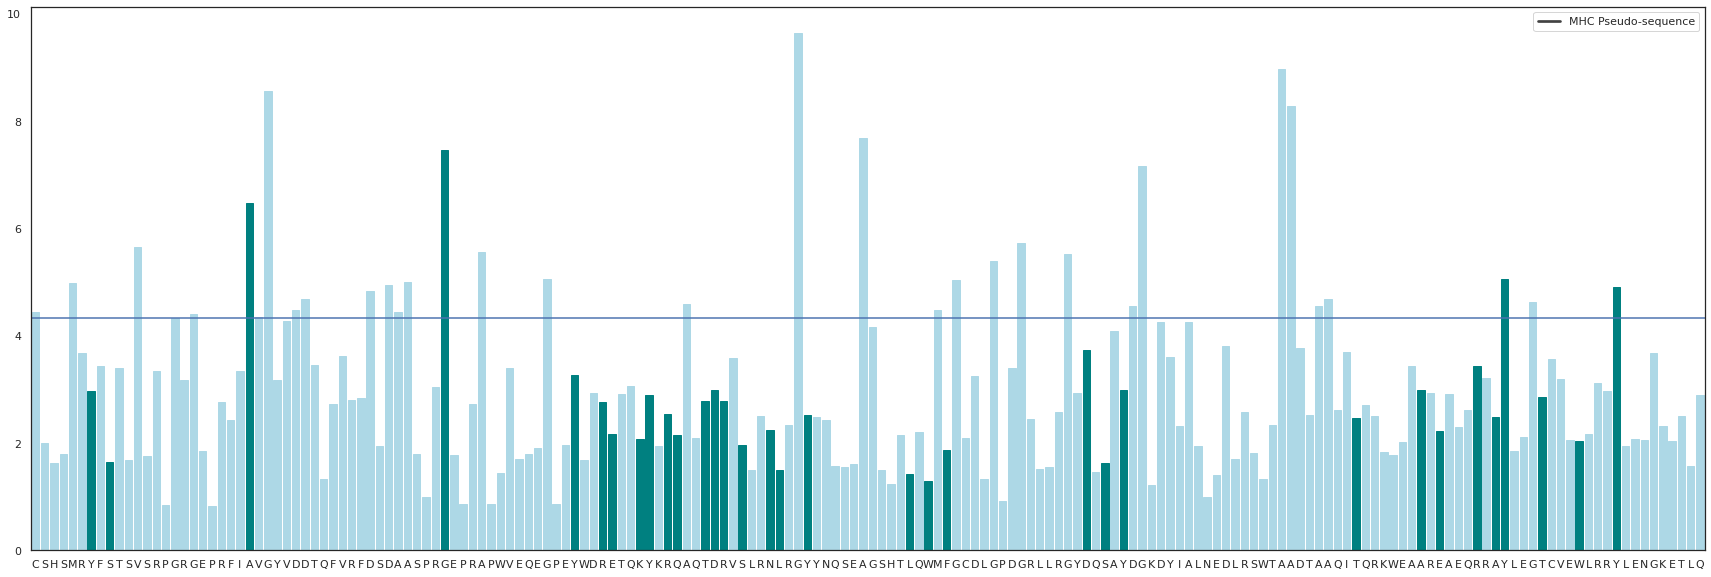



YSAGYREKYRQTDVSNLYLWFDSYTWAERAYTWY

CMVGGAVGDDDDAAGAGAGAMGGGGDGAAAAYGY
0.48721913007627293



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 444
HLA: HLA-A*02:05
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASRRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTLQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.256214313678913


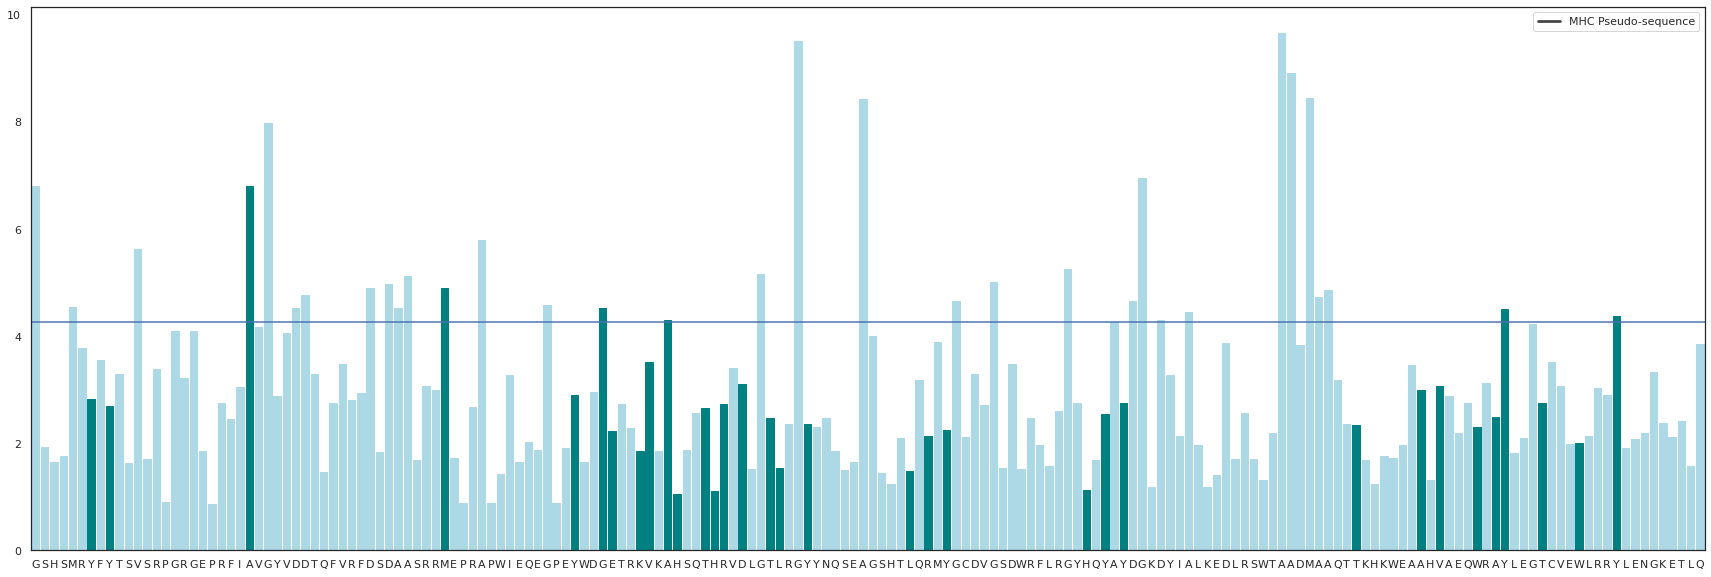



YYAMYGEKVAHTHVDTLYLRYHYYTWAVWAYTWY

GMVAGDDDDAAMAGGAGGAGGGADGDAAAMAAYY
0.4927849927849928



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 441
HLA: HLA-B*18:01
GSHSMRYFHTSVSRPGRGEPRFISVGYVDGTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQISKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRHLENGKETLQ
threshold: 4.104493571517149


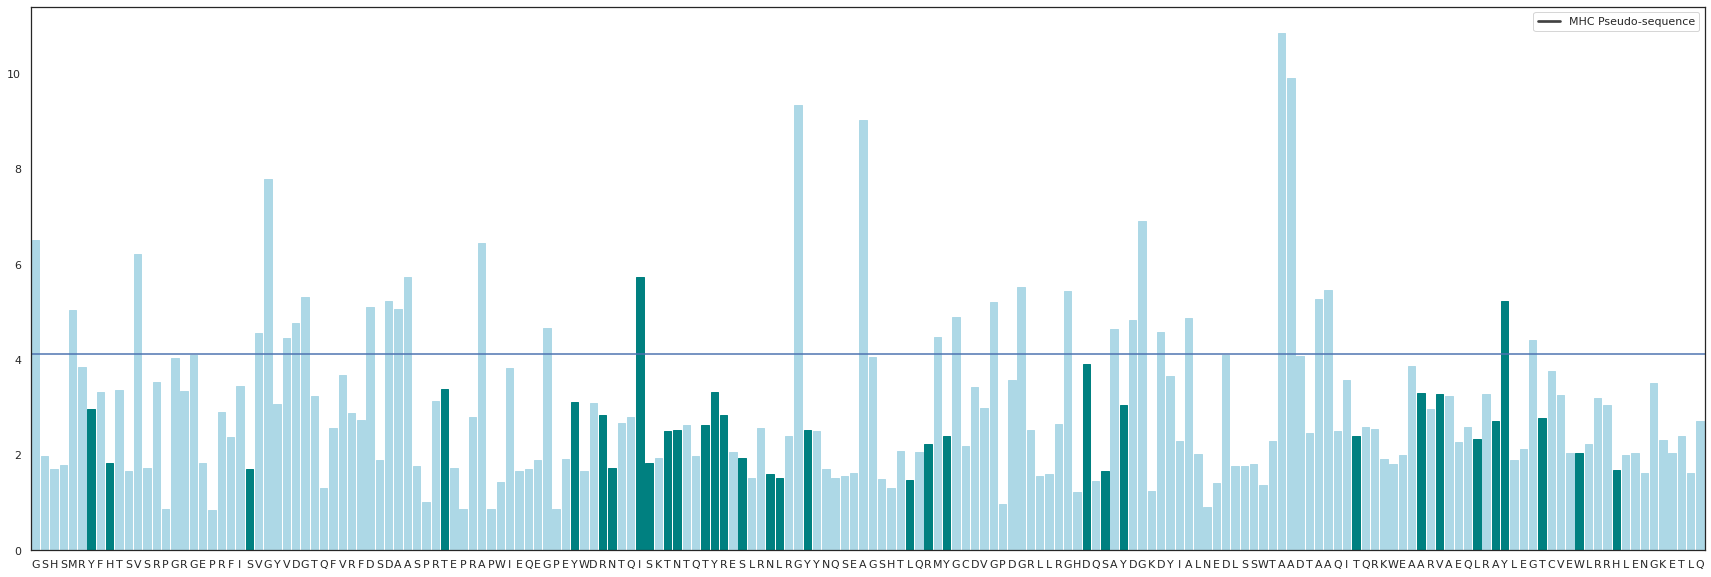



YHSTYRNISTNTYESNLYLRYDSYTWAVLAYTWH

GMVVGVDGDDAAAGIGAMGGGGADGDADAAAAYG
0.46320346320346323



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 450
HLA: HLA-B*45:01
GSHSMRYFHTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTWQRMYGCDLGPDGRLLRGYNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVESLRRYLENGKETLQ
threshold: 4.292830403645834


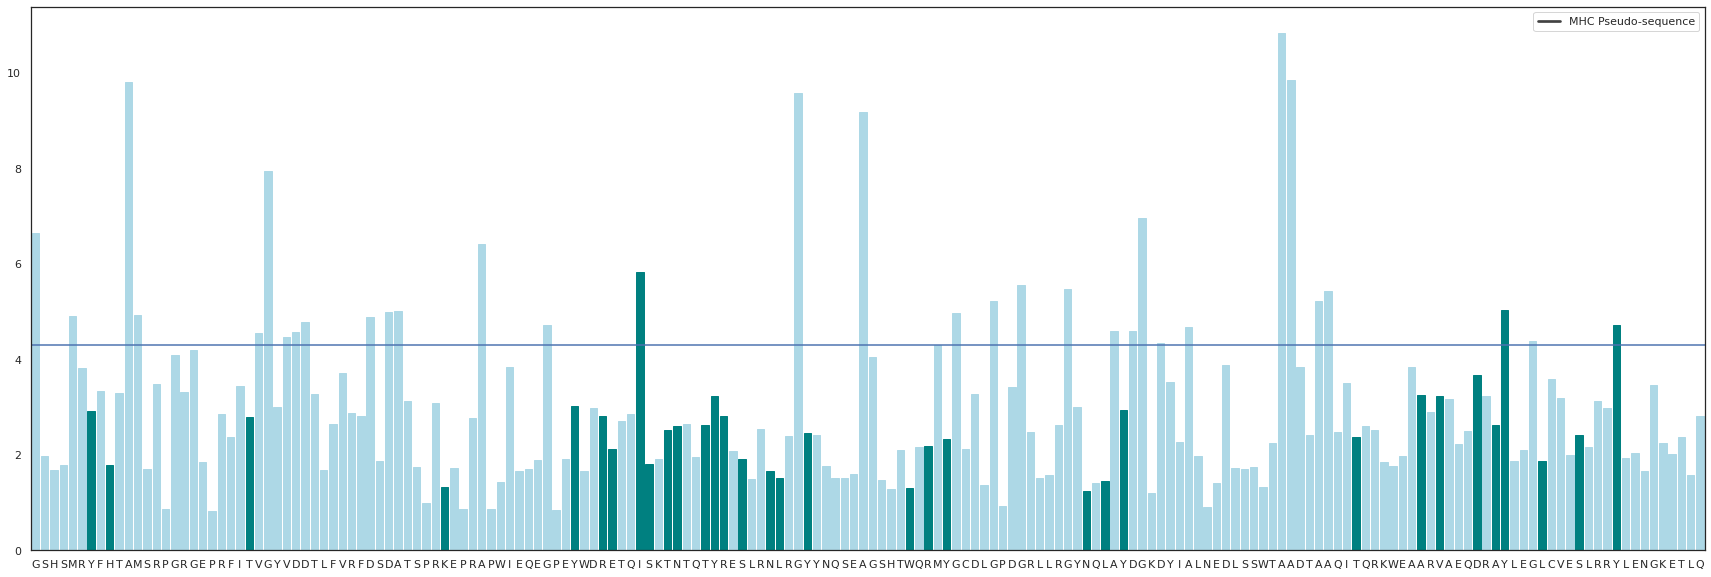



YHTKYREISTNTYESNLYWRYNLYTWAVDAYLSY

GMAMVGVDDDDAAGIGAMGGGGADGDAAAAAYGY
0.45506081220366934



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 458
HLA: HLA-C*07:04
CSHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEDGSHTFQRMYGCDLGPDGRLLRGYDQFAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQDRAYLEGTCVEWLRRYLENGKKTLQ
threshold: 4.0741457210357535


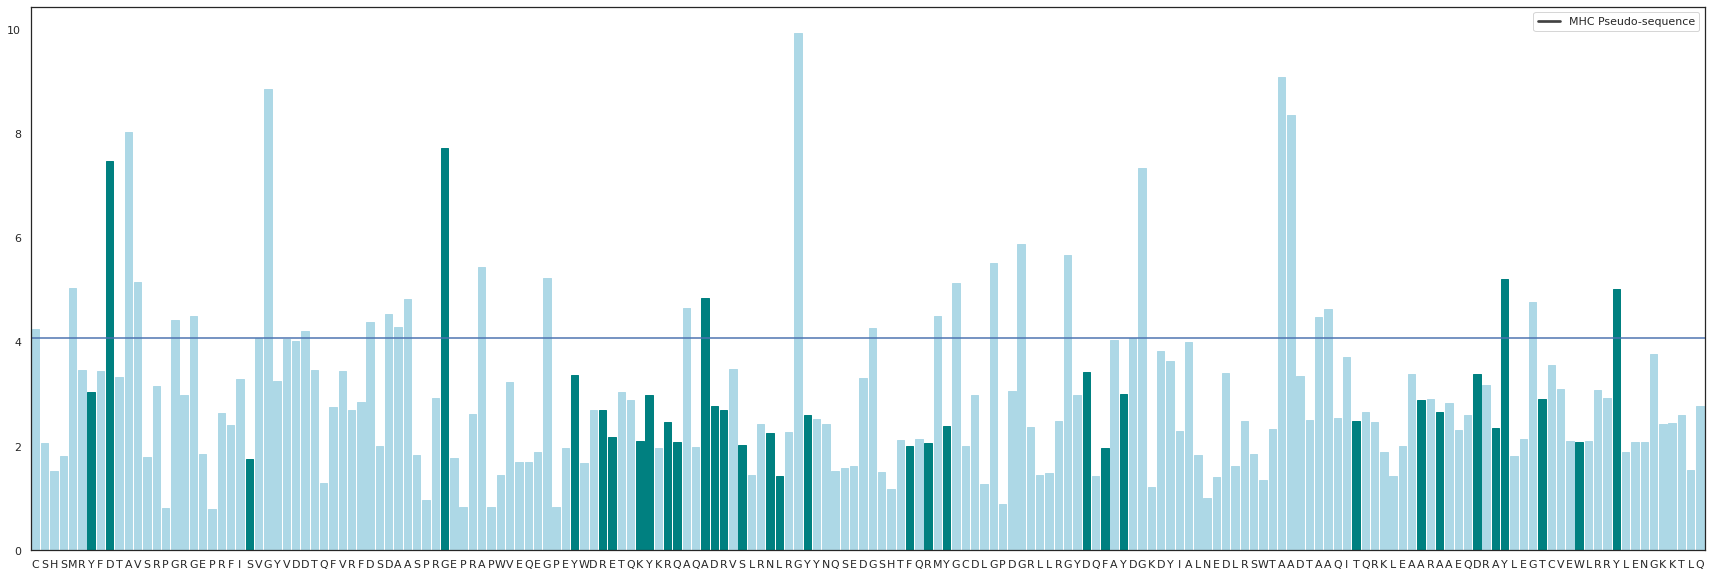



YDSGYREKYRQADVSNLYFRYDFYTLAADAYTWY

CMDAVGGGDDDAAGAGAAGGMGGGGDGAAAAYGY
0.5242218099360957



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 532
HLA: HLA-B*13:02
GSHSMRYFYTAMSRPGRGEPRFITVGYVDDTQFVRFDSDATSPRMAPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRTALRYYNQSEAGSHTWQTMYGCDLGPDGRLLRGHNQLAYDGKDYIALNEDLSSWTAADTAAQITQLKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.429934853001645


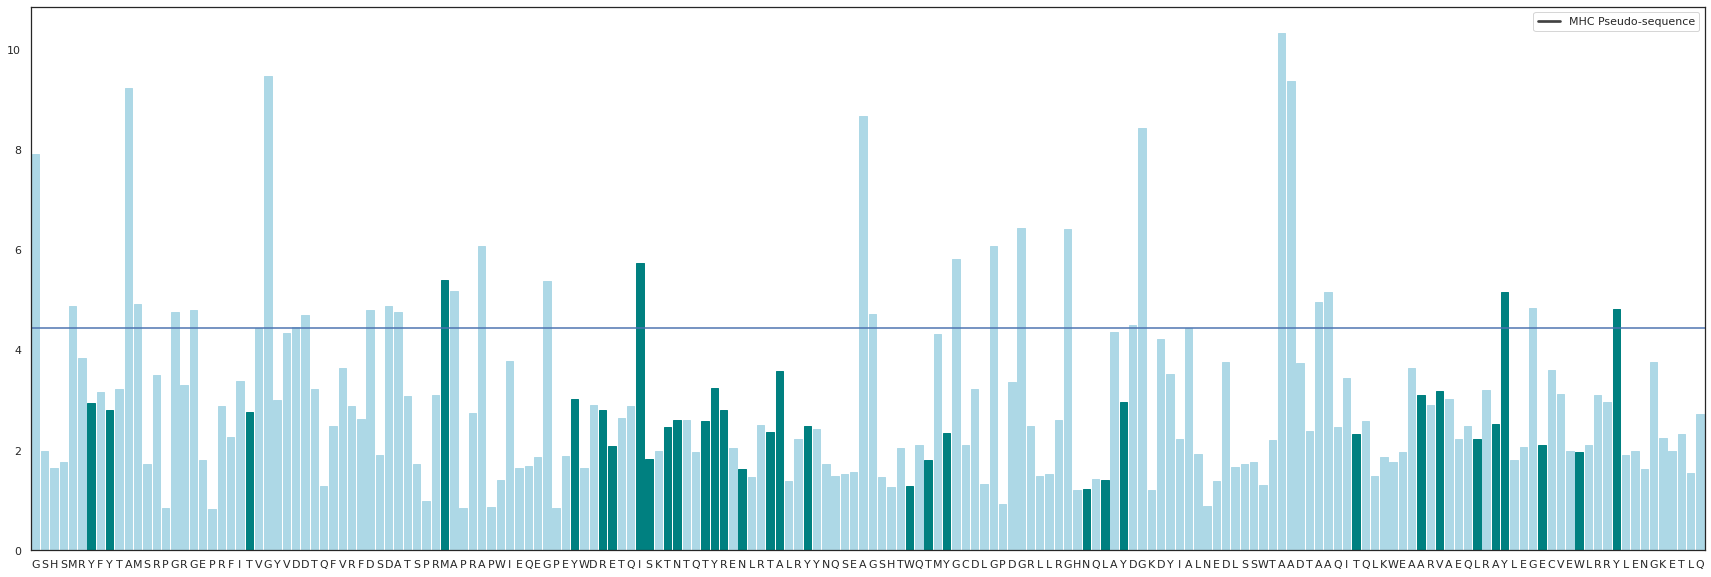



YYTMYREISTNTYENTAYWTYNLYTWAVLAYEWY

GMAMGGVGDDDDAMAAGIAGGGGGDGAAAAAYGY
0.5082457225314368



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 510
HLA: HLA-B*27:02
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDRENLRIALRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.254513250612745


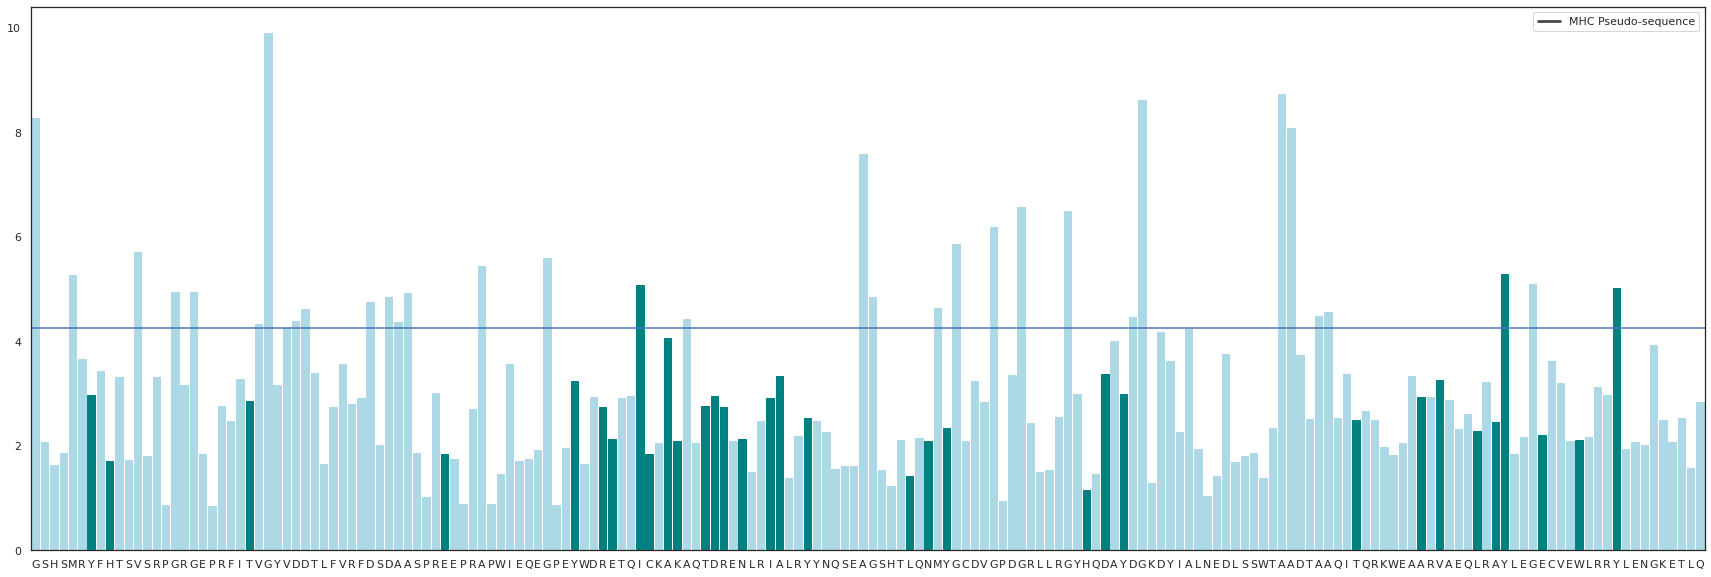



YHTEYREICAKTDENIAYLNYHDYTWAVLAYEWY

GMVGGVGVDDDDAAAGIAAGMGGGGDGAAAAYGY
0.5039167182024324



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 524
HLA: HLA-A*02:07
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMCGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.23468157353292


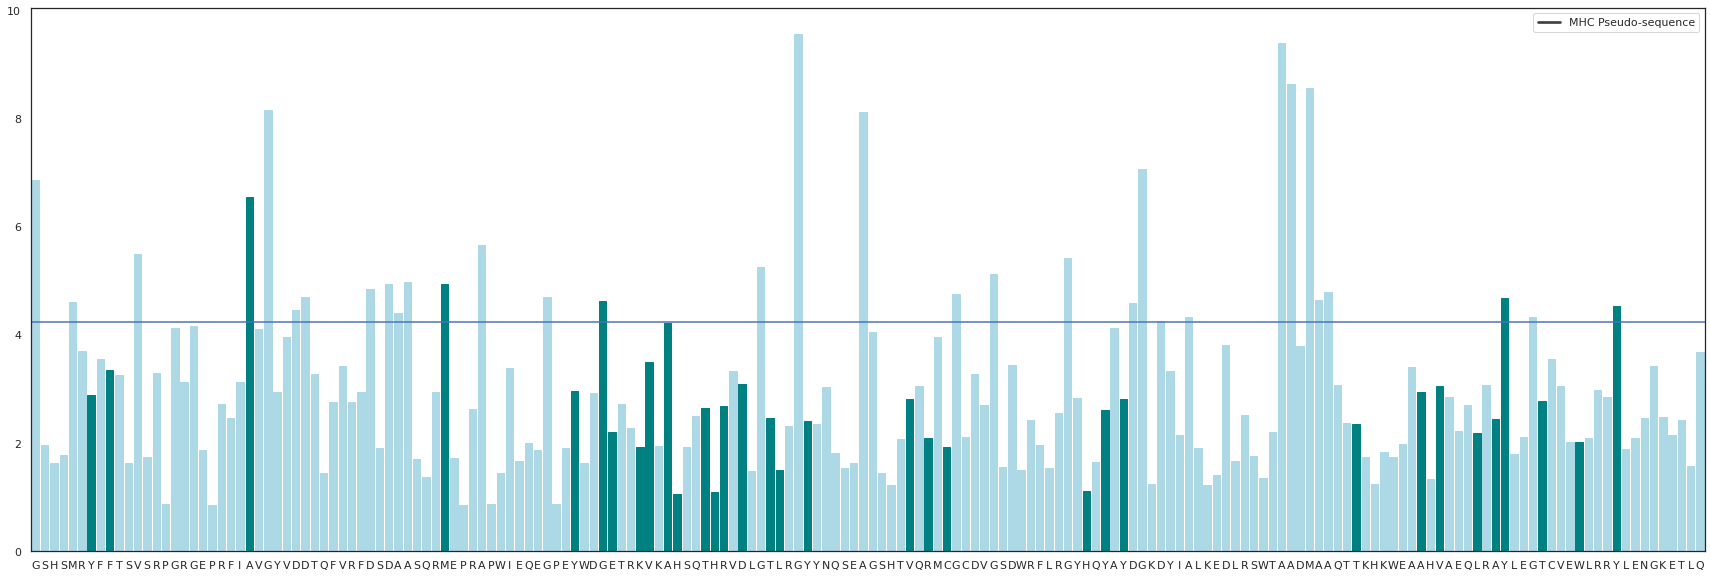



YFAMYGEKVAHTHVDTLYVRCHYYTWAVLAYTWY

GMVAGDDDDAAMAGGAGGAGGGDGDAAAMAAYGY
0.512677798392084



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 576
HLA: HLA-B*27:01
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTYRENLRTALRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.306504567464192


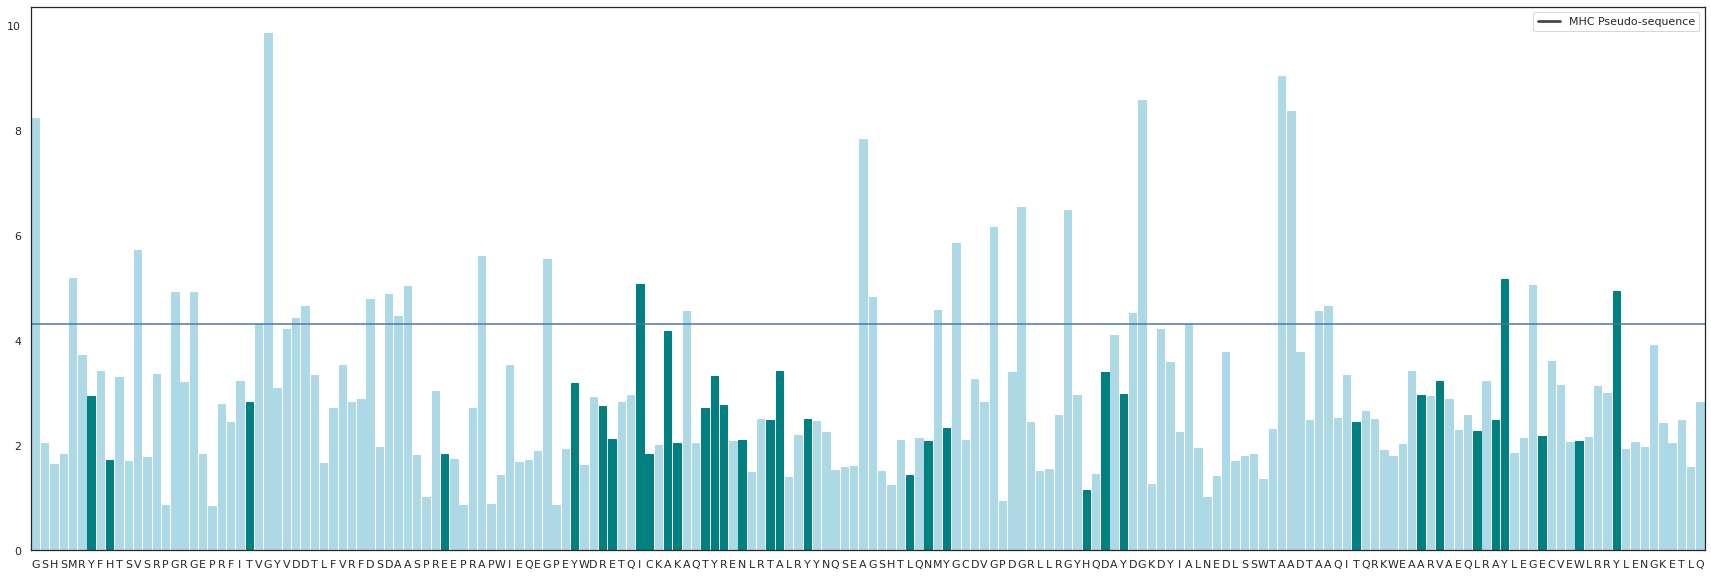



YHTEYREICAKTYENTAYLNYHDYTWAVLAYEWY

GMVGGVGDDDDAAAGIAAGMGGGGDGAAAAAYGY
0.5018552875695733



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 591
HLA: HLA-C*07:02
CSHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMSGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.196786844992597


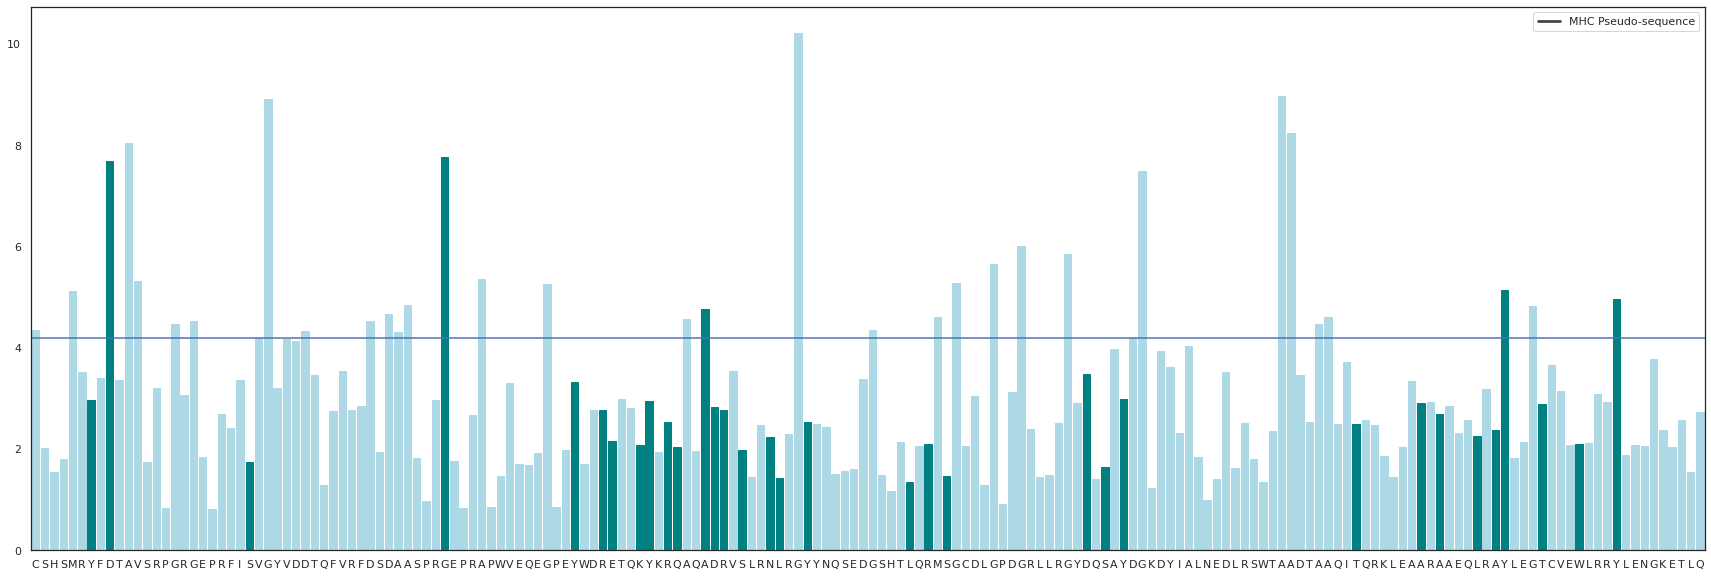



YDSGYREKYRQADVSNLYLRSDSYTLAALAYTWY

CMDAVGGVGDDDAAGAGAAGGMGGGGGAAAAYGY
0.49742321170892595



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 615
HLA: HLA-A*23:01
GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVDGLRRYLENGKETLQ
threshold: 4.262151454522358


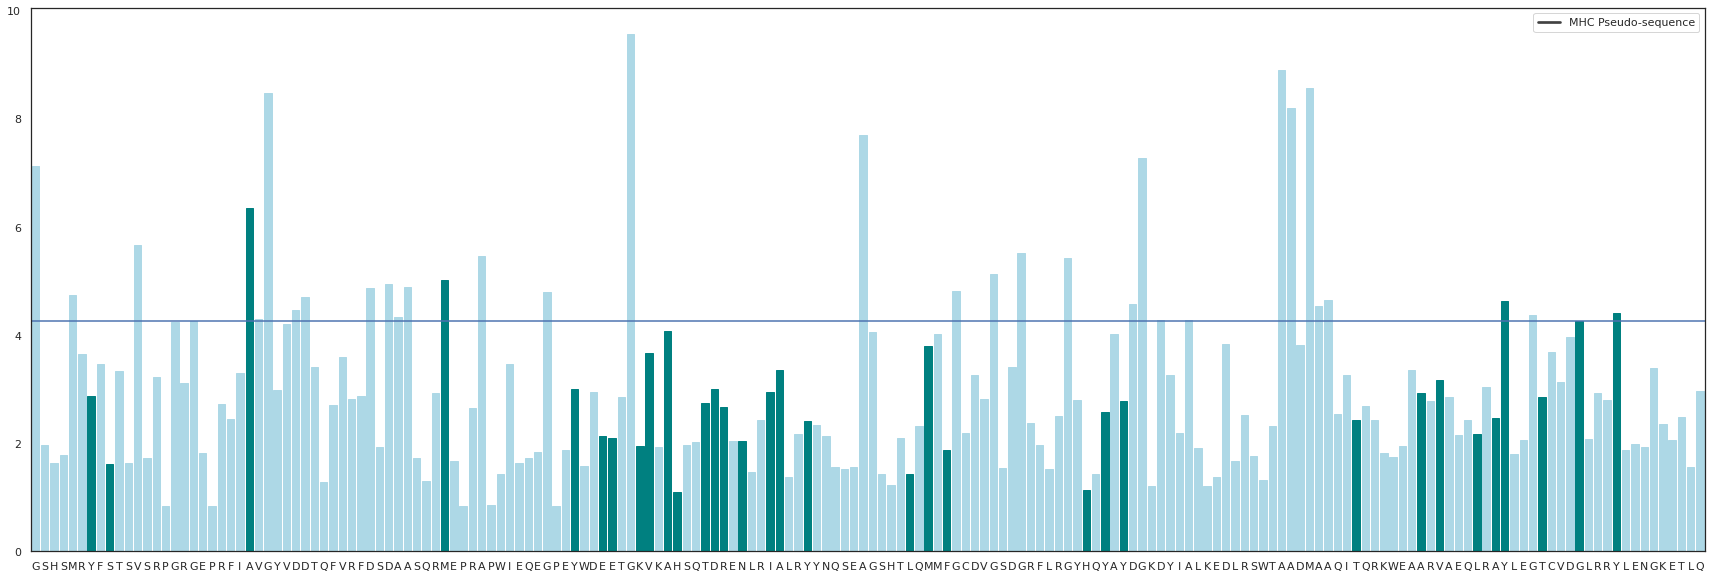



YSAMYEEKVAHTDENIAYLMFHYYTWAVLAYTGY

GMVGAVGDDDDAAMAGGAGGGGDGDAAAMAAYGY
0.5273139558853843



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 637
HLA: HLA-B*38:01
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTYRENLRIALRYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRTYLEGTCVEWLRRYLENGKETLQ
threshold: 4.460082432913069


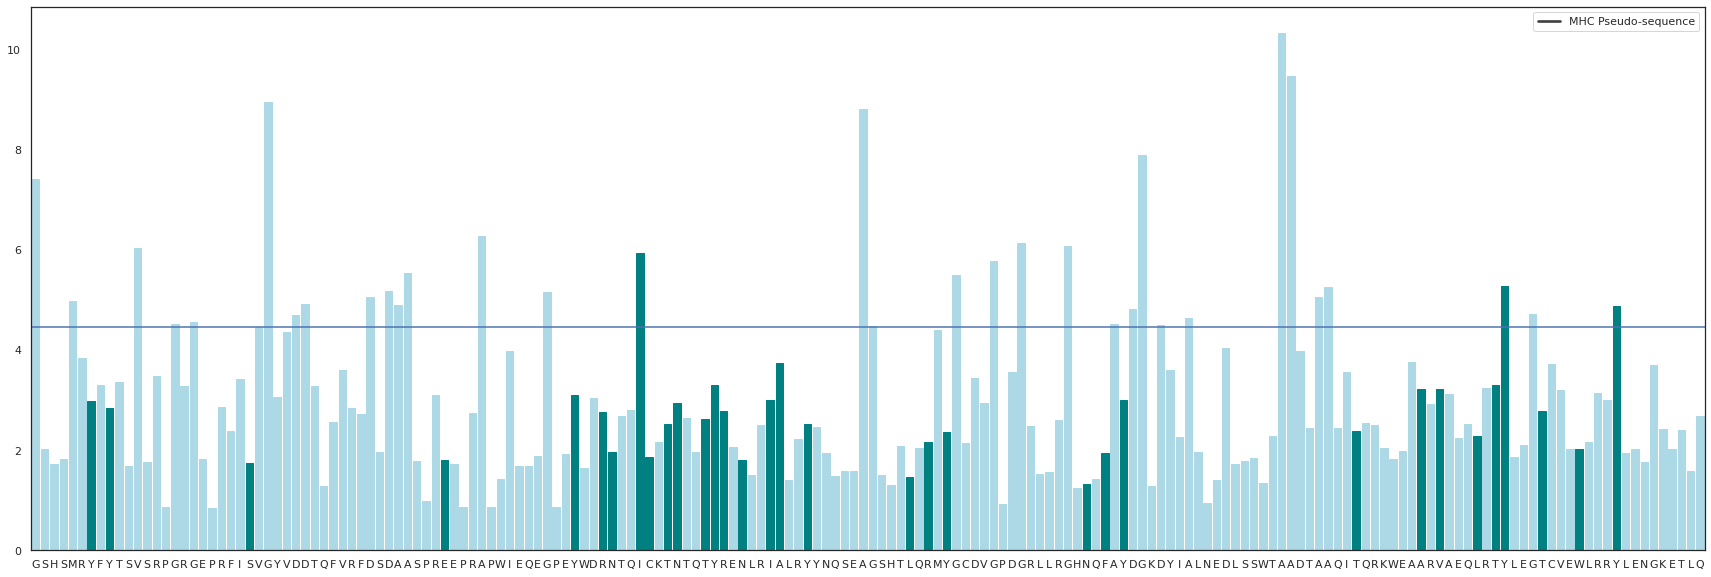



YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY

GMVGGVGDDDDAAAGIAGGGGGADGDAAAAAYGY
0.5084518655947228



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 669
HLA: HLA-B*14:02
GSHSMRYFYTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTDRESLRNLRGYYNQSEAGSHTLQWMYGCDVGPDGRLLRGYNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGTCVEWLRRHLENGKETLQ
threshold: 4.264650262168348


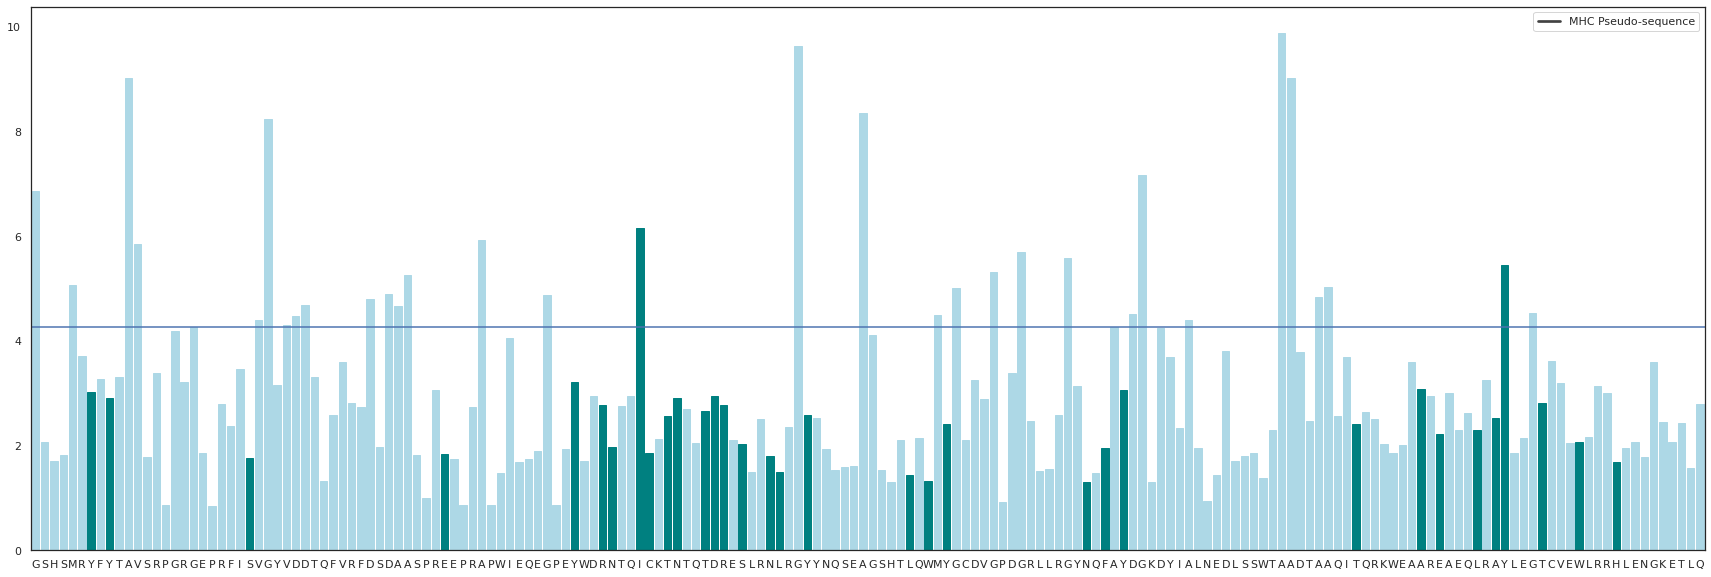



YYSEYRNICTNTDESNLYLWYNFYTWAELAYTWH

GMAVGVGVDDDDAAAGIGAMGGGGADGAAAAAYG
0.41939806225520515



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 717
HLA: HLA-B*35:03
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRESLRNLRGYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.357405530857741


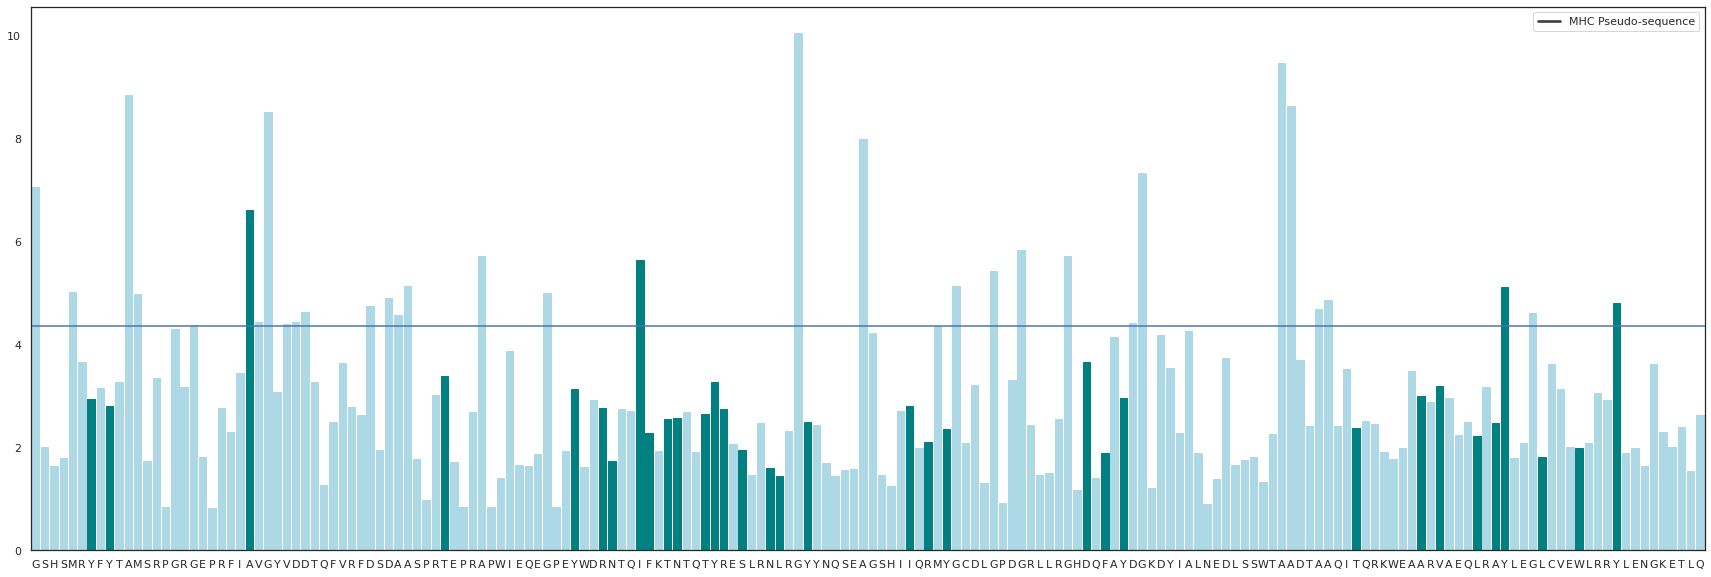



YYATYRNIFTNTYESNLYIRYDFYTWAVLAYLWY

GMAMGAVGVDDDDAAAGIGAMGGGGDGAAAAYGY
0.531127602556174



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 724
HLA: HLA-A*32:01
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAHSQTDRESLRIALRYYNQSEAGSHTIQMMYGCDVGPDGRLLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.301666428371029


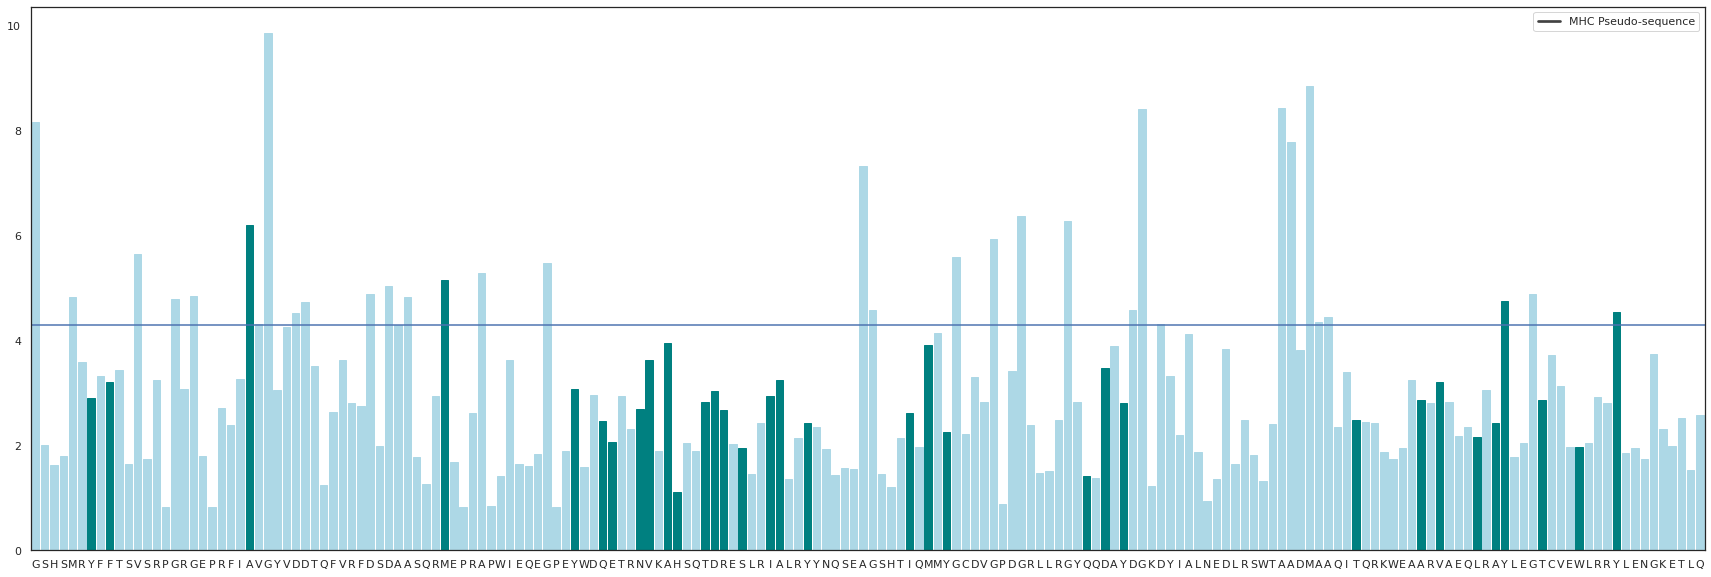



YFAMYQENVAHTDESIAYIMYQDYTWAVLAYTWY

GMVGGAVGDDDDAAMAGAGGGGGDGDAAMAAYGY
0.5757575757575758



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 714
HLA: HLA-C*16:01
CSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARAAEQQRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.255332797181373


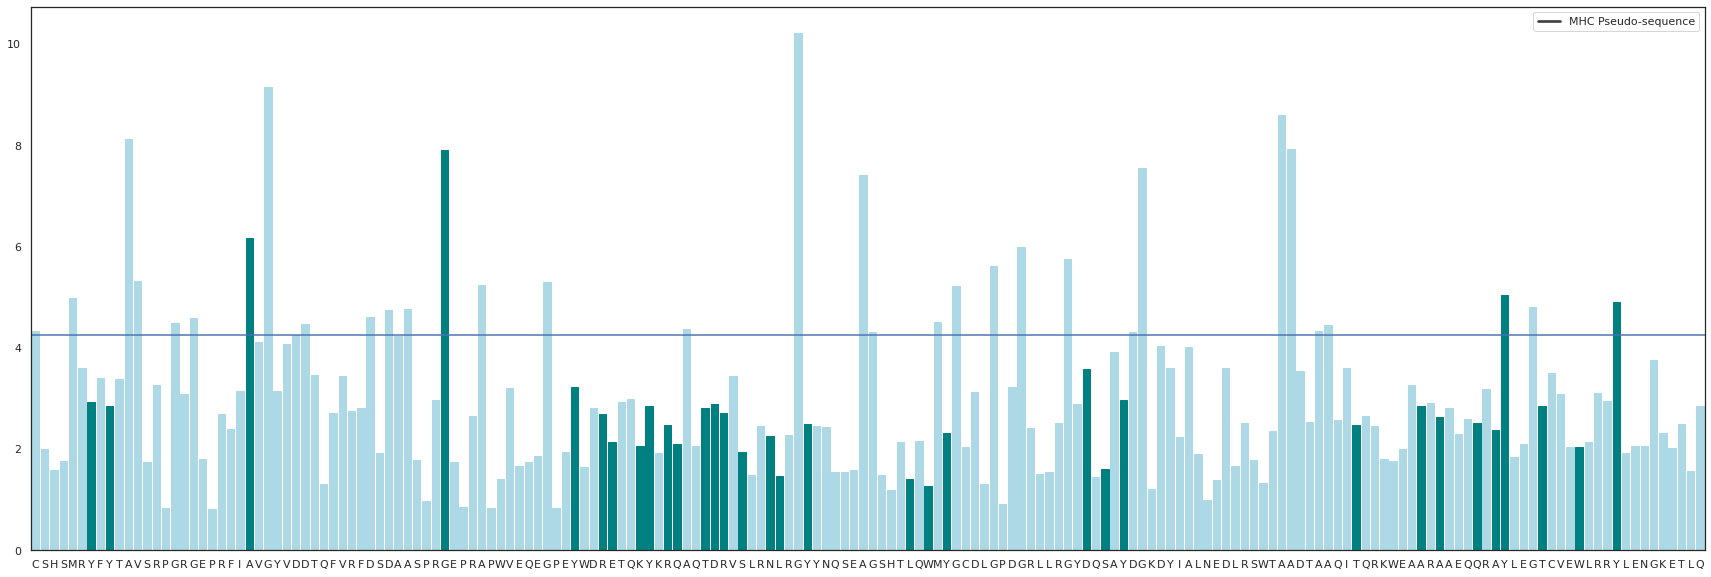



YYAGYREKYRQTDVSNLYLWYDSYTWAAQAYTWY

CMAVGGAGDDDDAGAGAGAGMGGGGDGAAAAYGY
0.49422799422799424



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 767
HLA: HLA-B*37:01
GSHSMRYFHTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRETQISKTNTQTYREDLRTLLRYYNQSEAGSHTIQRMSGCDVGPDGRLLRGYNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.417357602672751


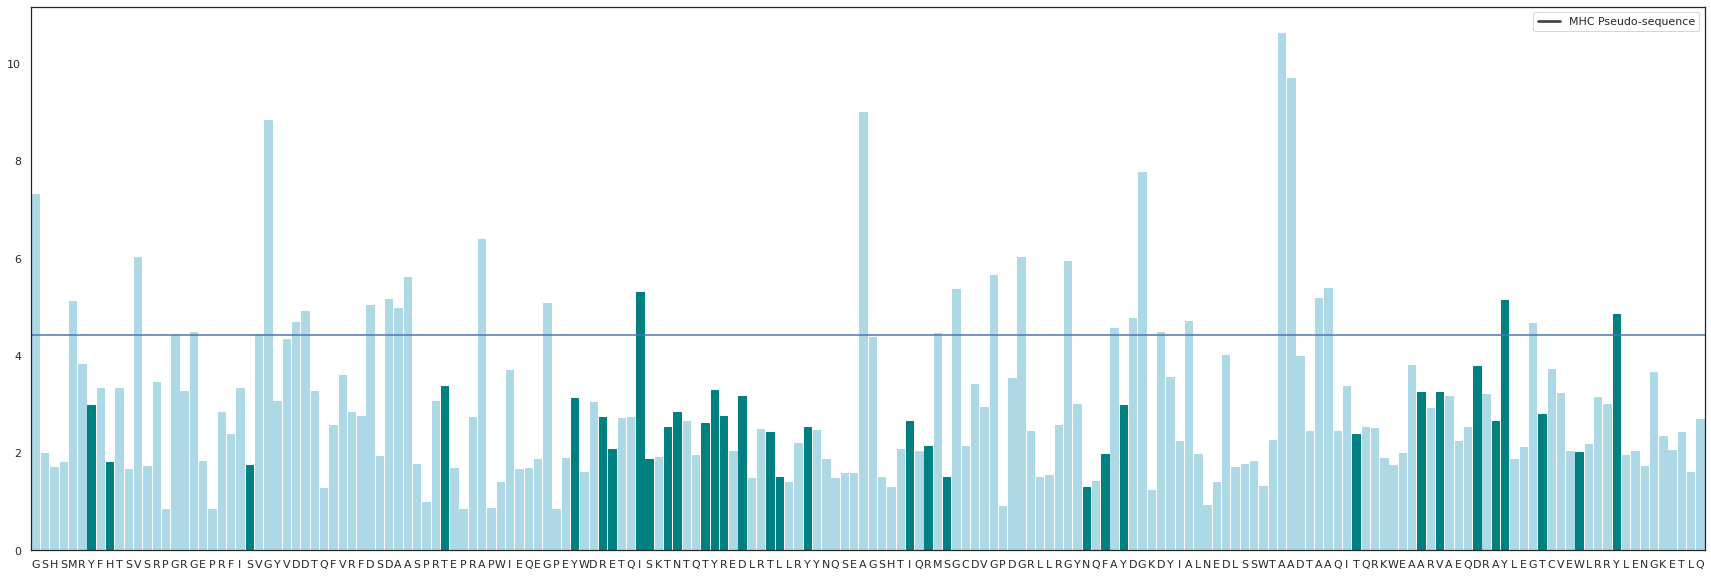



YHSTYREISTNTYEDTLYIRSNFYTWAVDAYTWY

GMVGGVGDDDDAAAGIAMGGGGADGDAAAAAYGY
0.5082457225314368



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 753
HLA: HLA-C*07:01
CSHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.175161009607404


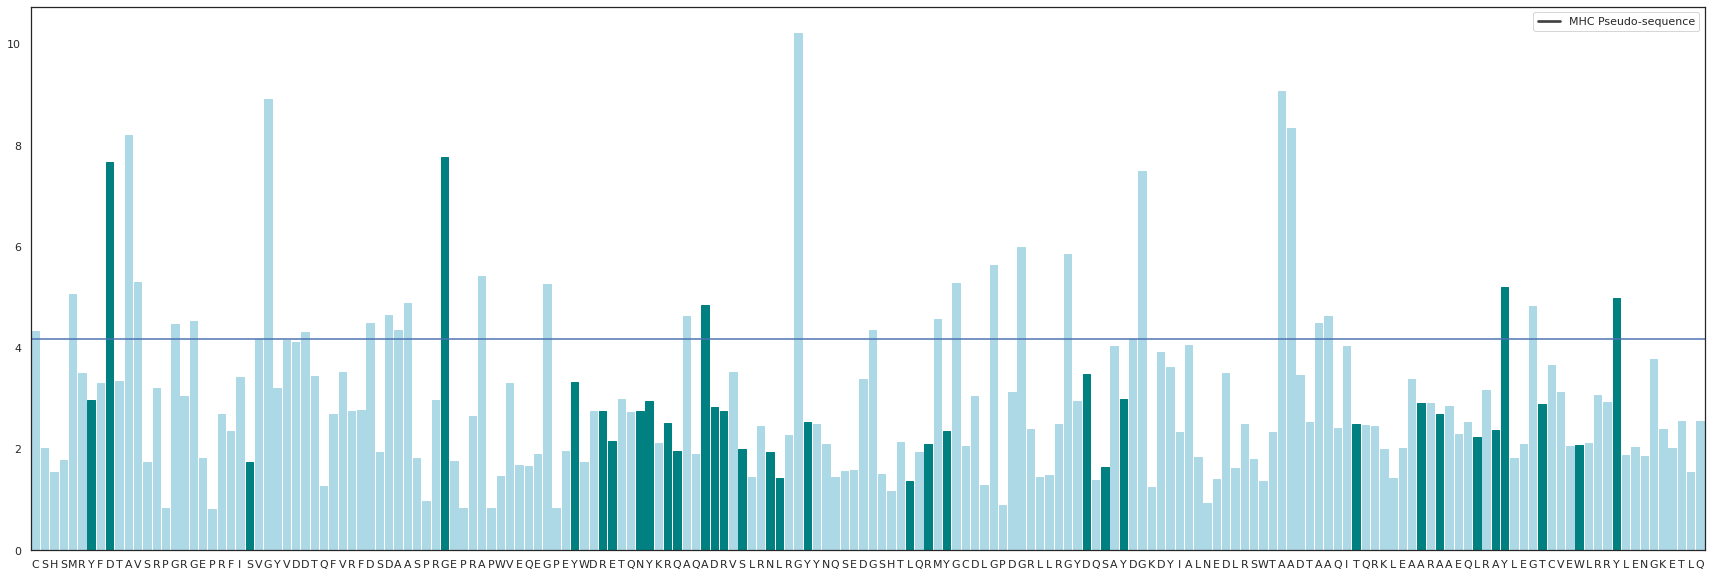



YDSGYRENYRQADVSNLYLRYDSYTLAALAYTWY

CMDAVGGVGDDDAAGAGAAGGMGGGGGAAAAYGY
0.5117501546072973



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 825
HLA: HLA-B*49:01
GSHSMRYFHTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRIALRYYNQSEAGSHTWQRMYGCDLGPDGRLLRGYNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.454921875


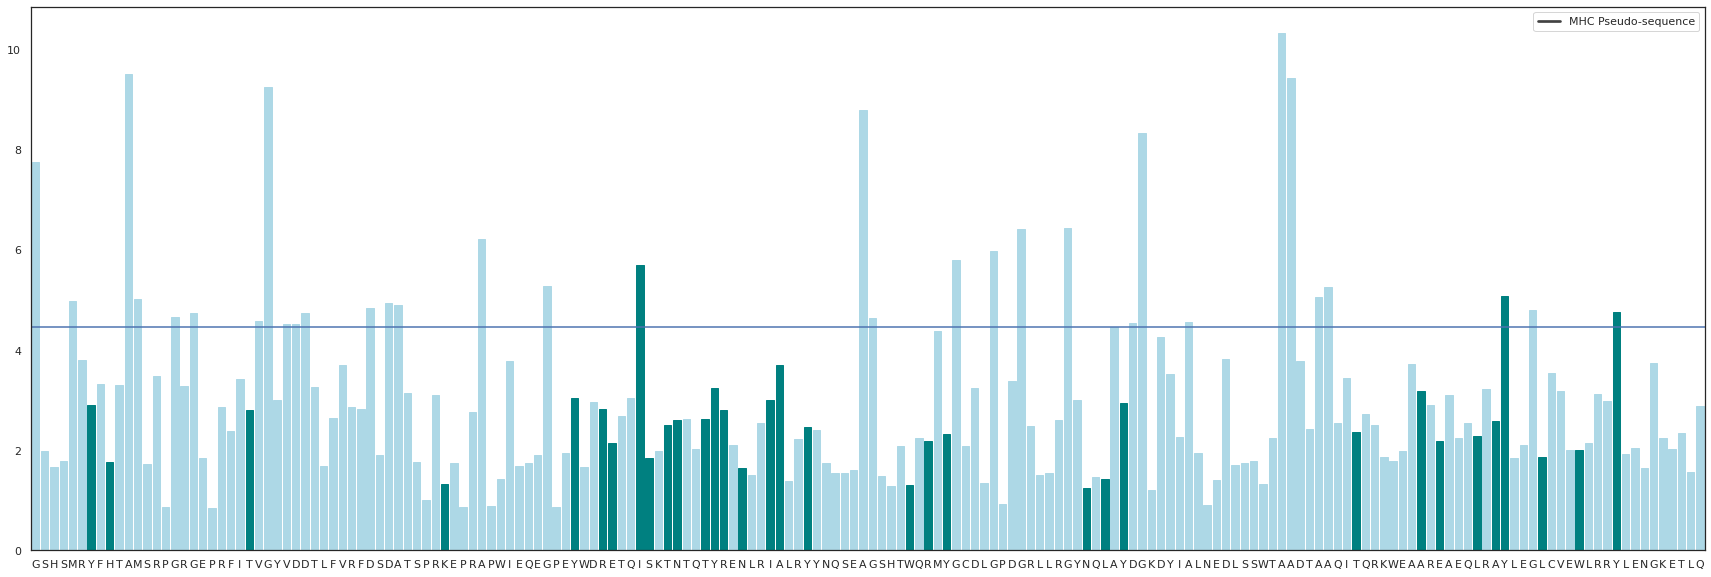



YHTKYREISTNTYENIAYWRYNLYTWAELAYLWY

GMAMGGVGVDDDDAAGIAGGGGGADGAAAAAYGY
0.46464646464646464



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 810
HLA: HLA-B*39:01
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTDRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRTYLEGTCVEWLRRYLENGKETLQ
threshold: 4.345727237654321


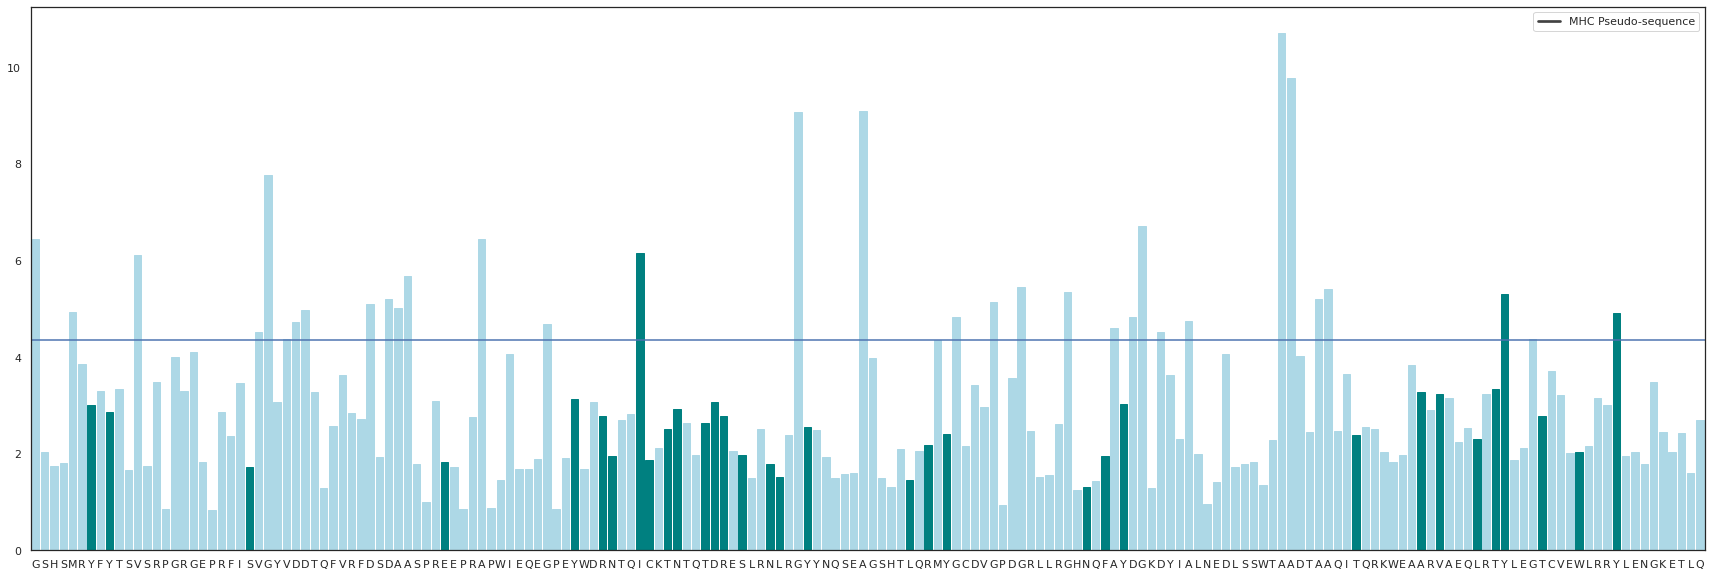



YYSEYRNICTNTDESNLYLRYNFYTWAVLTYTWY

GMVVGVDDDDAAAGIGAMGGGGADGDAAAAAYGY
0.4753659039373325



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 793
HLA: HLA-A*02:03
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWETAHEAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.35415137580785


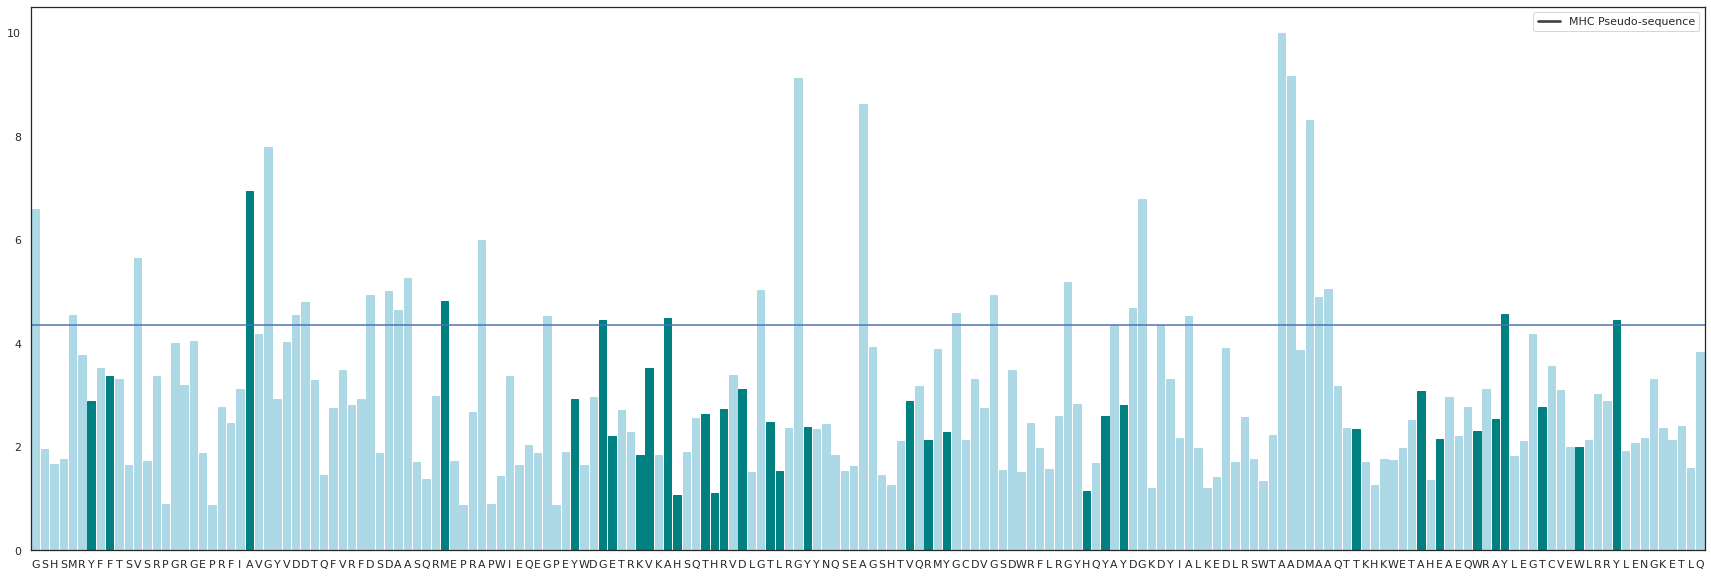



YFAMYGEKVAHTHVDTLYVRYHYYTWAEWAYTWY

GMVAGDDDDAAMAGGAGGAGGGADGDAAAMAAYY
0.5124716553287982



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 843
HLA: HLA-C*03:04
GSHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQ
threshold: 4.210748385138642


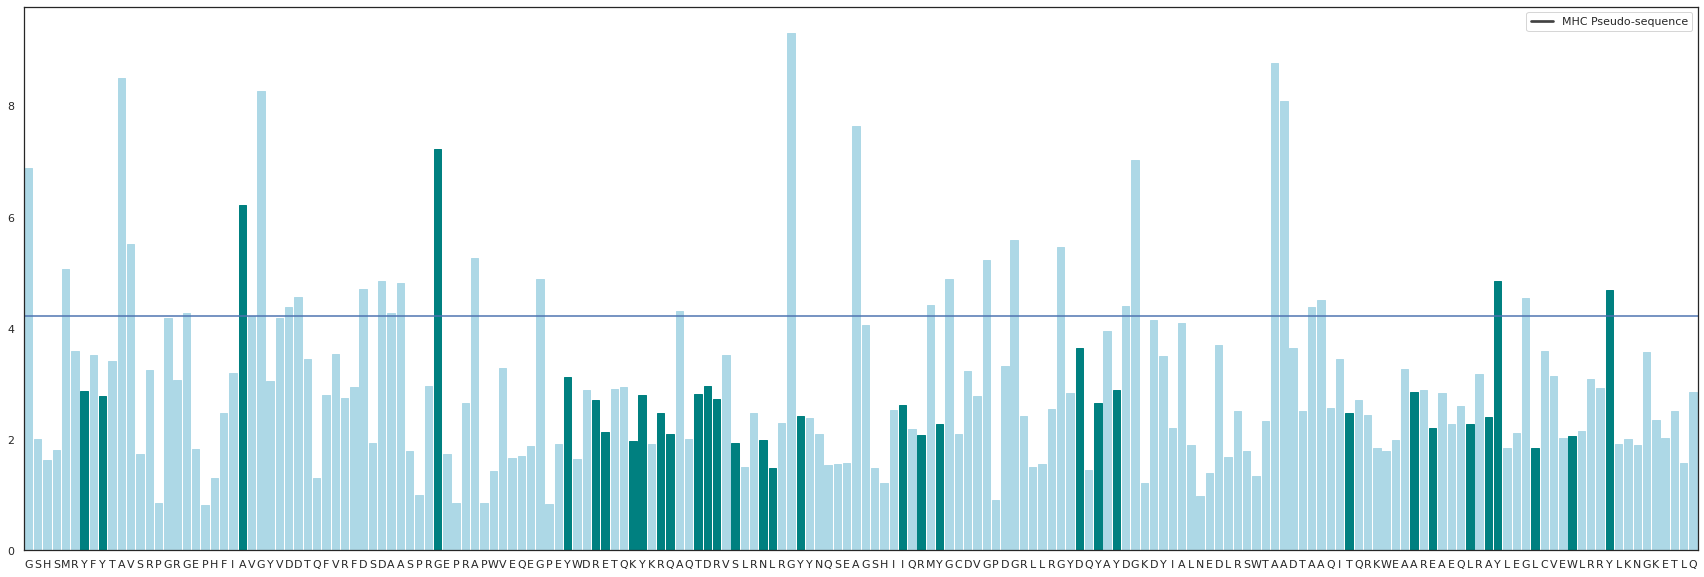



YYAGYREKYRQTDVSNLYIRYDYYTWAELAYLWY

GMAVGAVGDDDDAAGAGAGAMGGGGDGAAAAYGY
0.4989692846835704



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 764
HLA: HLA-A*02:06
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.282069341050392


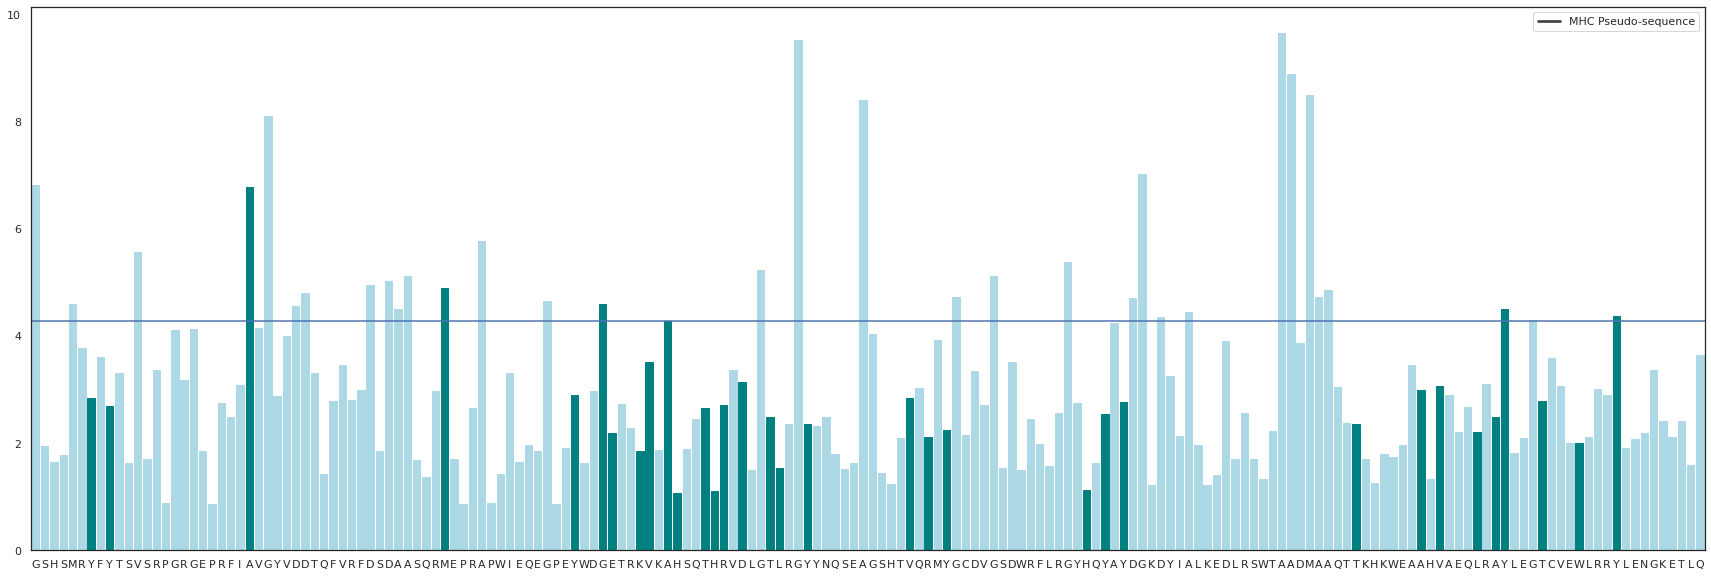



YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY

GMVAGDDDDAAMAGGAGGAGGGDGDAAAMAAYGY
0.5111317254174397



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 818
HLA: HLA-B*57:03
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDGETRNMKASAQTYRENLRIALRYYNQSEAGSHIIQVMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.257202745358343


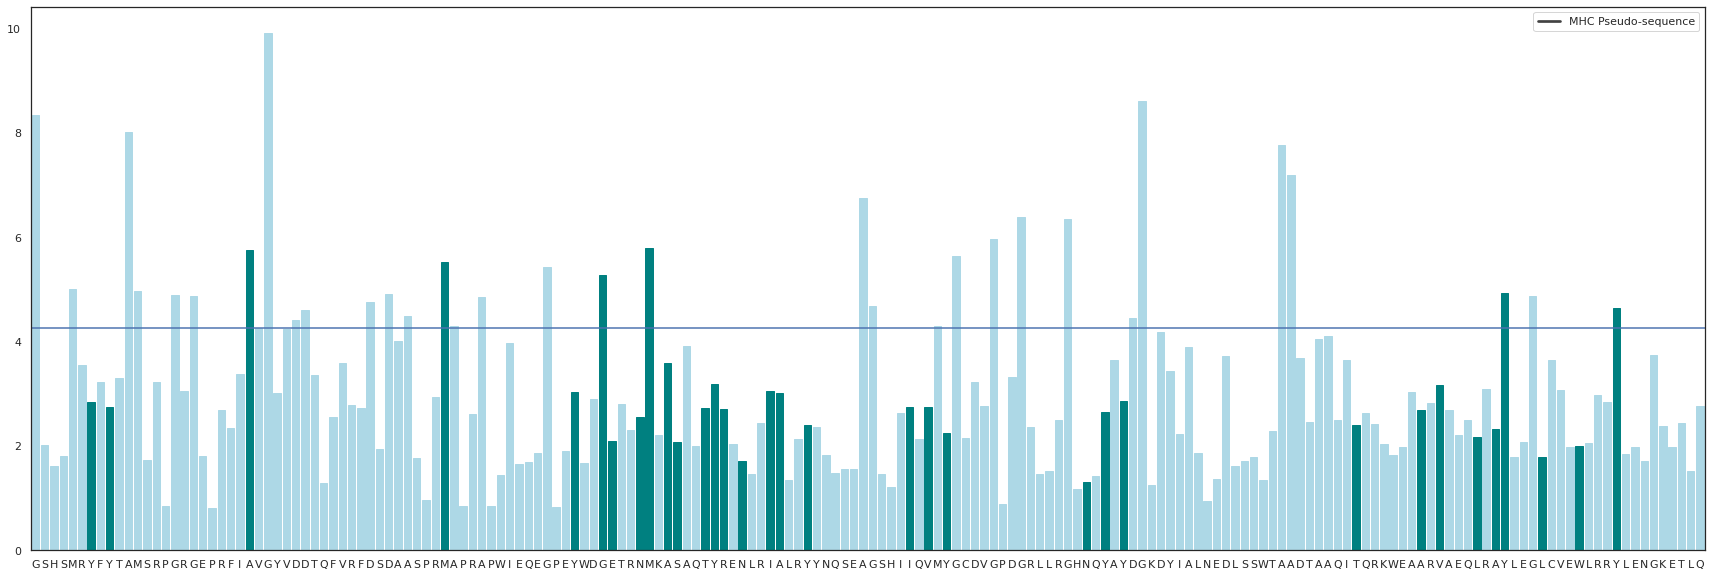



YYAMYGENMASTYENIAYIVYNYYTWAVLAYLWY

GMAMGGAVGDDDDAMAAGGMAGMGGGGDGAAYGY
0.5642135642135642



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 889
HLA: HLA-C*03:03
GSHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEARSHIIQRMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQ
threshold: 4.229284297226519


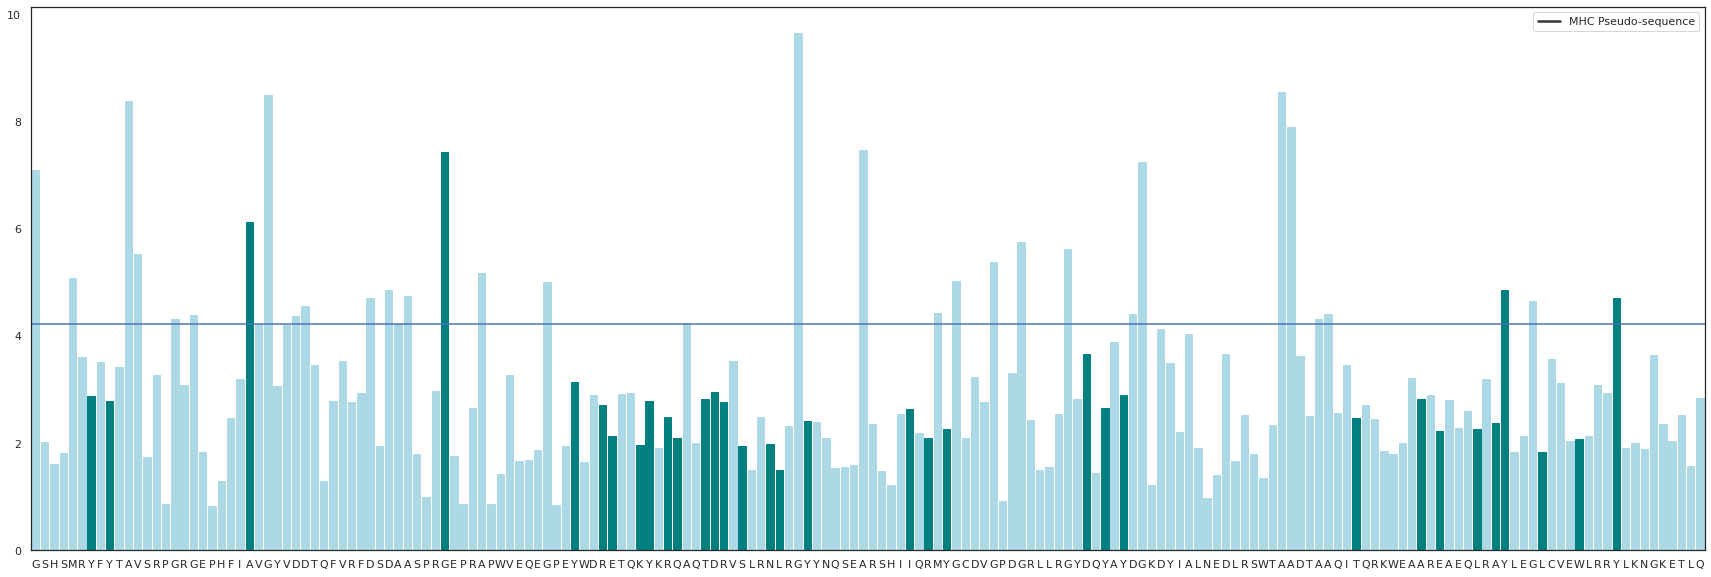



YYAGYREKYRQTDVSNLYIRYDYYTWAELAYLWY

GMAVGGAVGDDDDAGAGAGAMGGGGDGAAAAYGY
0.5024737167594311



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 887
HLA: HLA-C*05:01
CSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKKTLQ
threshold: 4.261853343873309


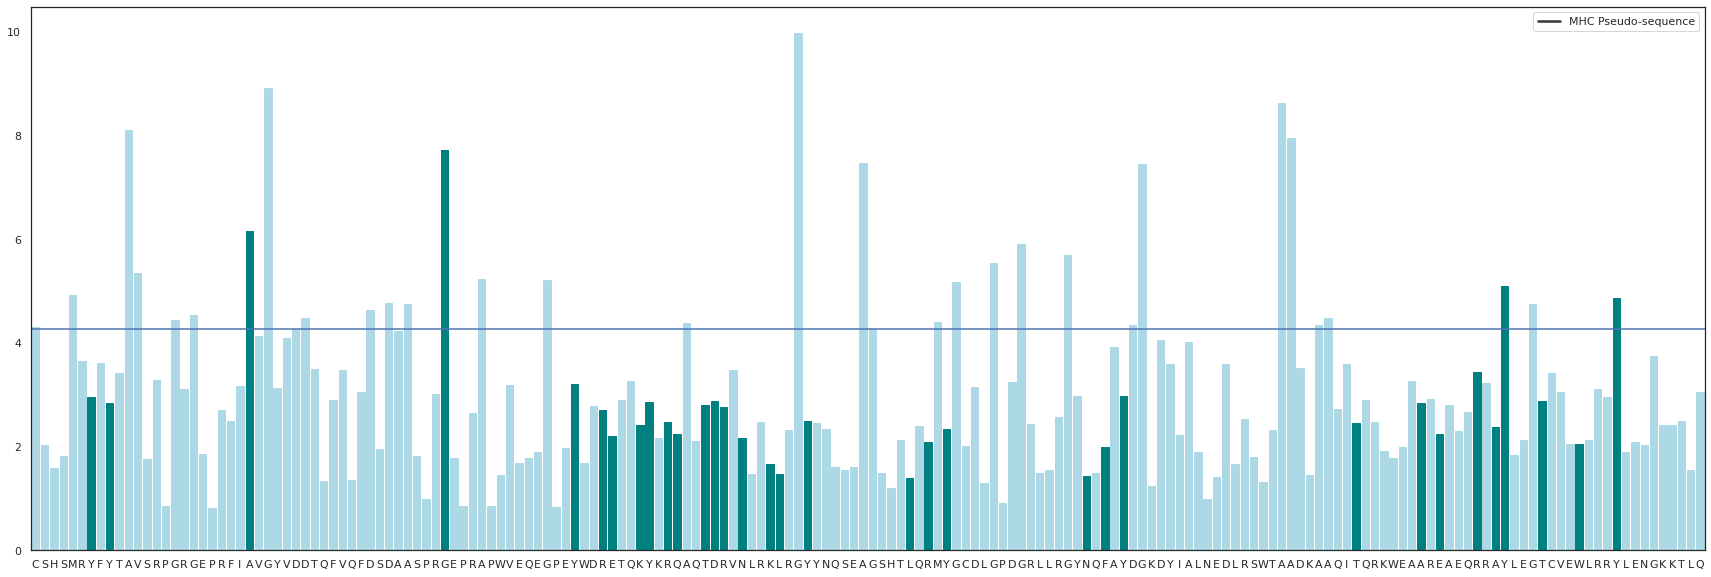



YYAGYREKYRQTDVNKLYLRYNFYTWAERAYTWY

CMAVGGAGDDDDAGAGAGAGMGGGGDGAAAAYGY
0.4864976293547722



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 909
HLA: HLA-B*40:01
GSHSMRYFHTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQISQRKLEAARVAEQLRAYLEGECVEWLRRYLENGKDKLE
threshold: 4.28615322469747


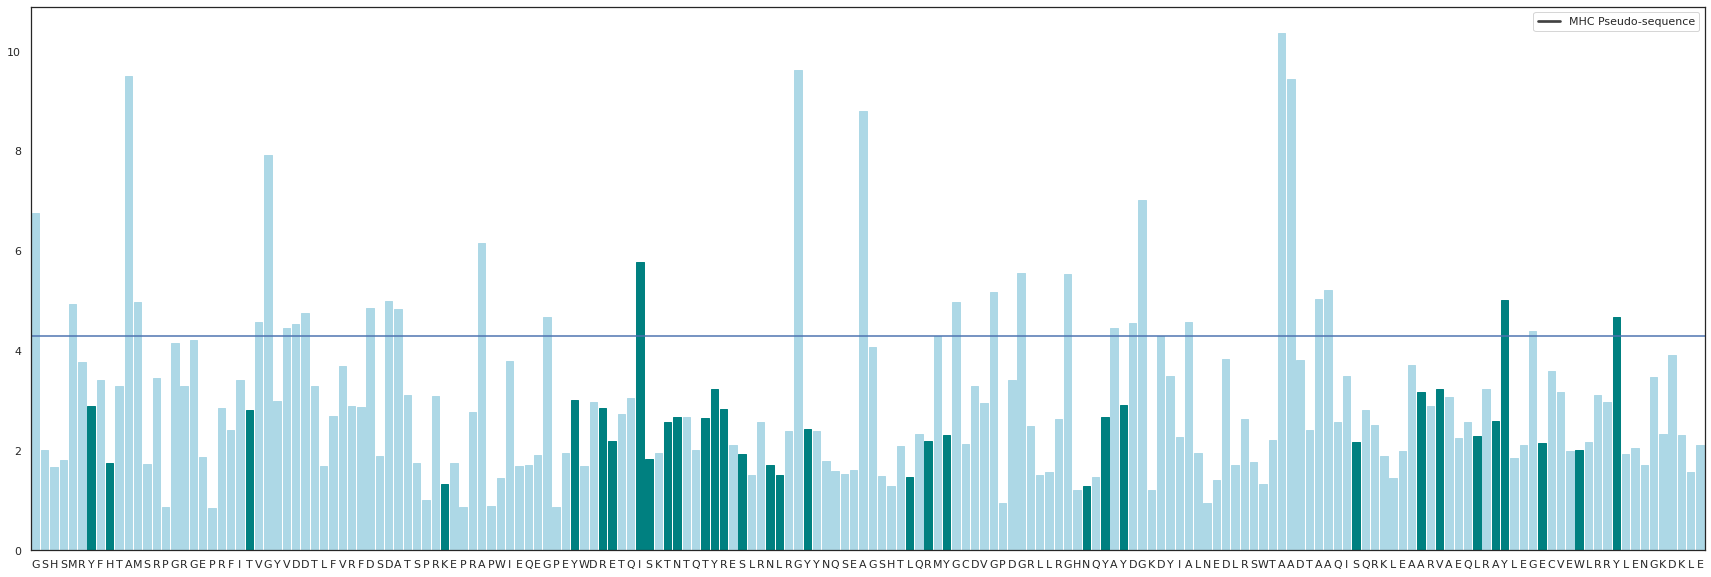



YHTKYREISTNTYESNLYLRYNYYSLAVLAYEWY

GMAMVGVDDDDAAGIGAMGGGGADGDAAAAAYGY
0.45155638012780874



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 930
HLA: HLA-B*58:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDGETRNMKASAQTYRENLRIALRYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.310165438088037


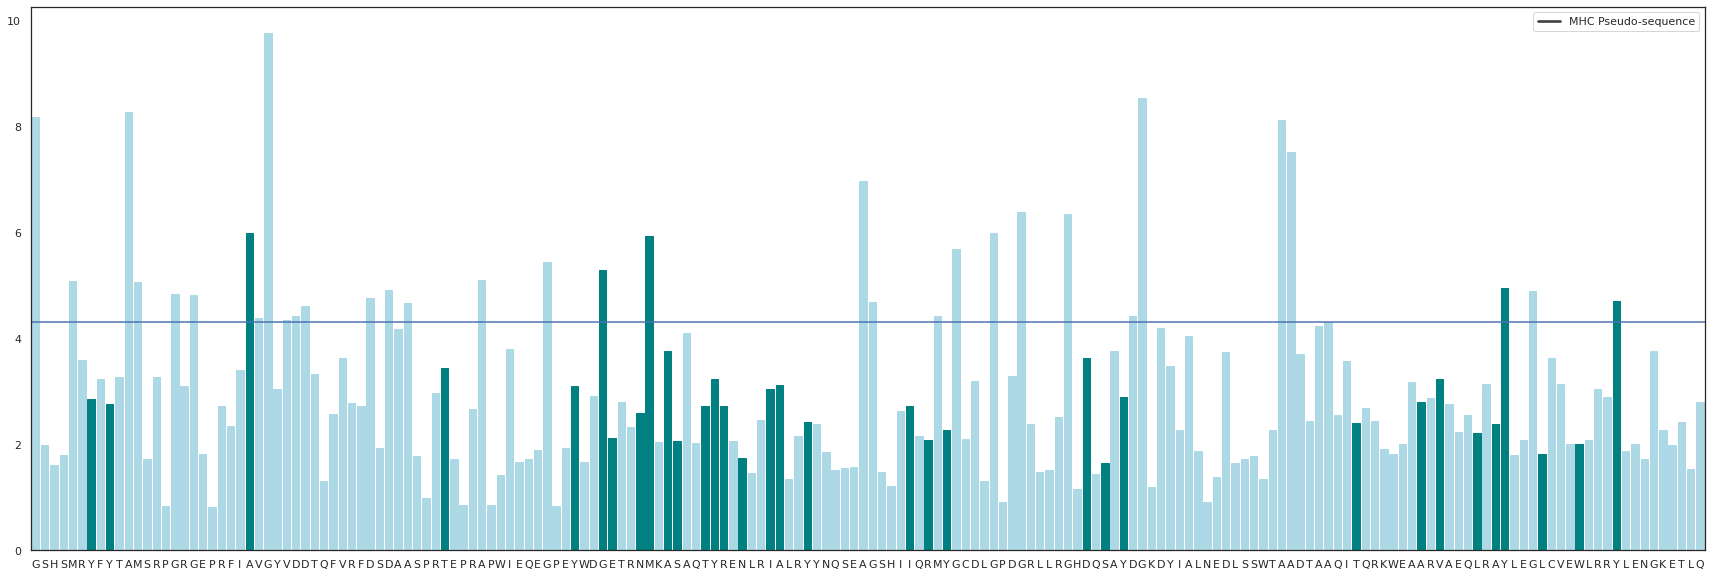



YYATYGENMASTYENIAYIRYDSYTWAVLAYLWY

GMAMGGAVGVDDDDAAGGMAGMGGGGDGAAAYGY
0.5728715728715729



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 915
HLA: HLA-B*27:09
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDREDLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQHAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.353848616803279


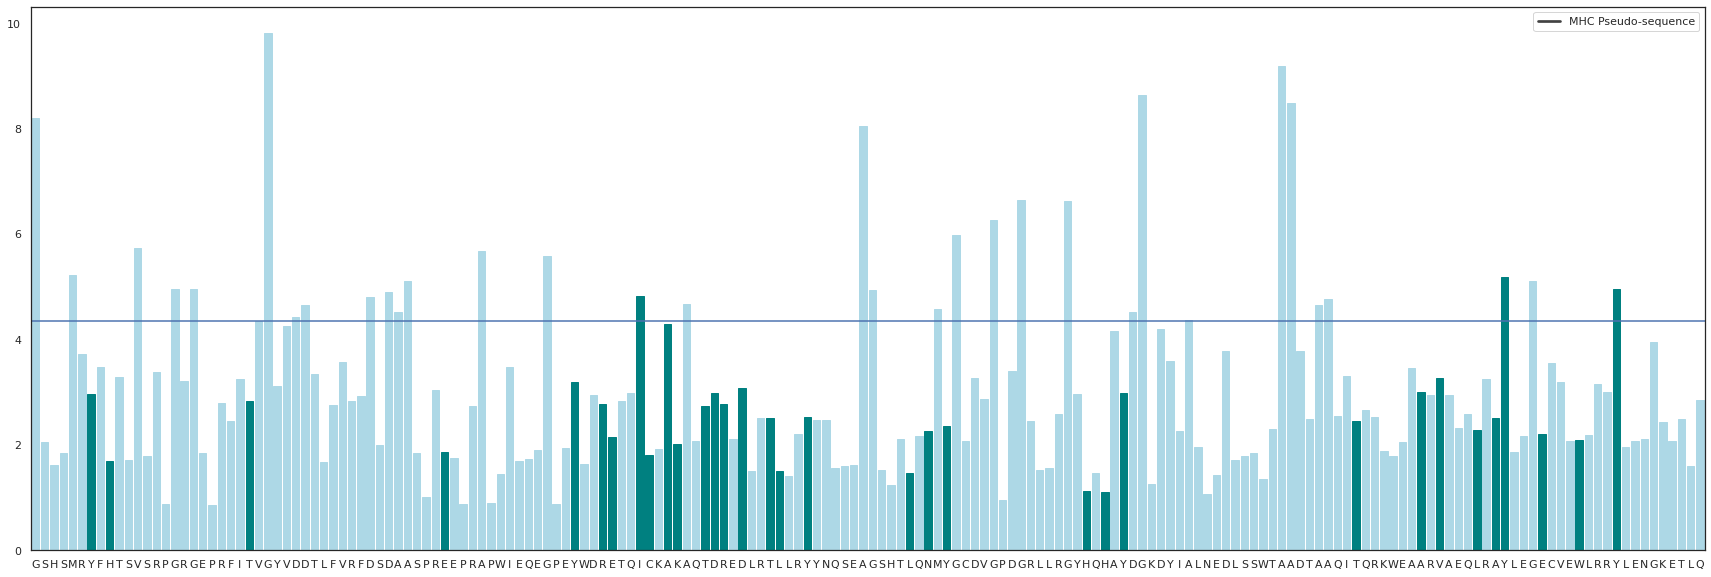



YHTEYREICAKTDEDTLYLNYHHYTWAVLAYEWY

GMVGGVGDDDDAAAGIAAGMGGGGDGAAAAAYGY
0.46918161203875486



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 921
HLA: HLA-A*31:01
GSHSMRYFTTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQERPEYWDQETRNVKAHSQIDRVDLGTLRGYYNQSEAGSHTIQMMYGCDVGSDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.214814060803475


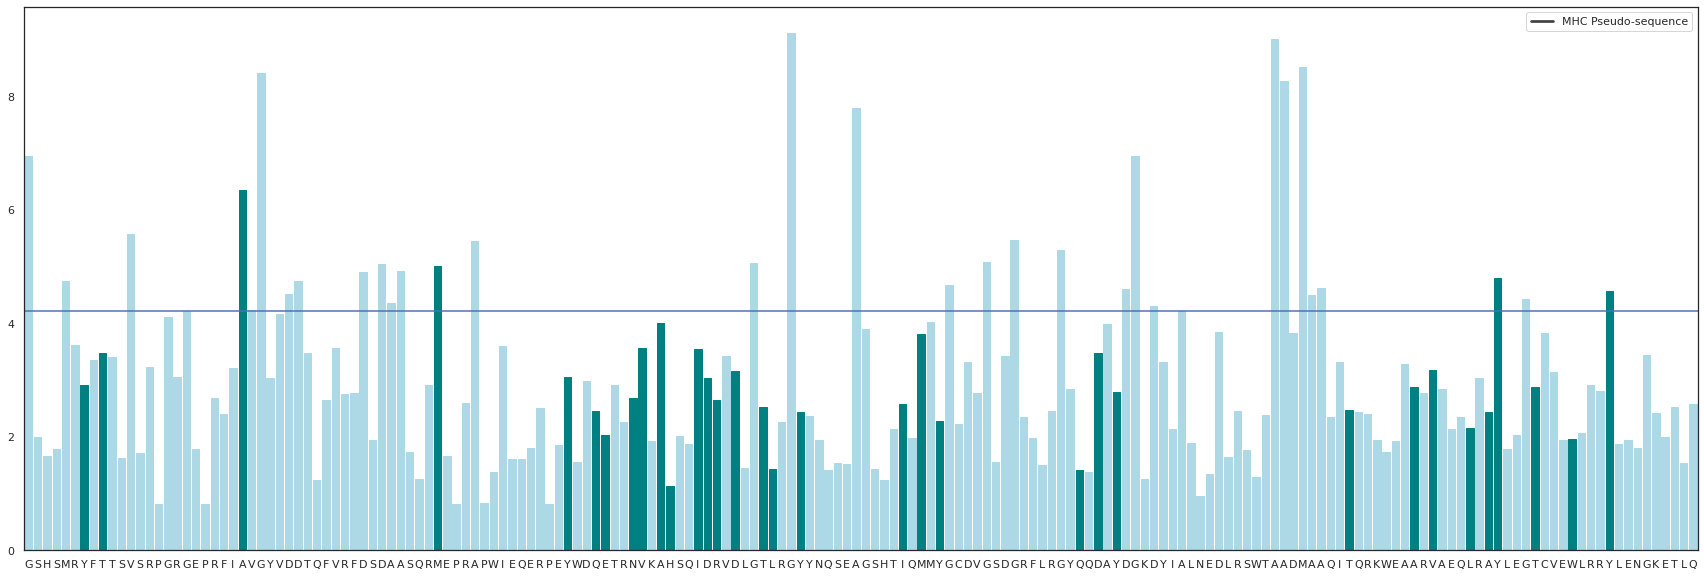



YTAMYQENVAHIDVDTLYIMYQDYTWAVLAYTWY

GMVGAVGDDDDAAMAGGAGGGGDGDAAAMAAYGY
0.564625850340136



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 973
HLA: HLA-C*02:02
CSHSMRYFYTAVSRPSRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.222054053186023


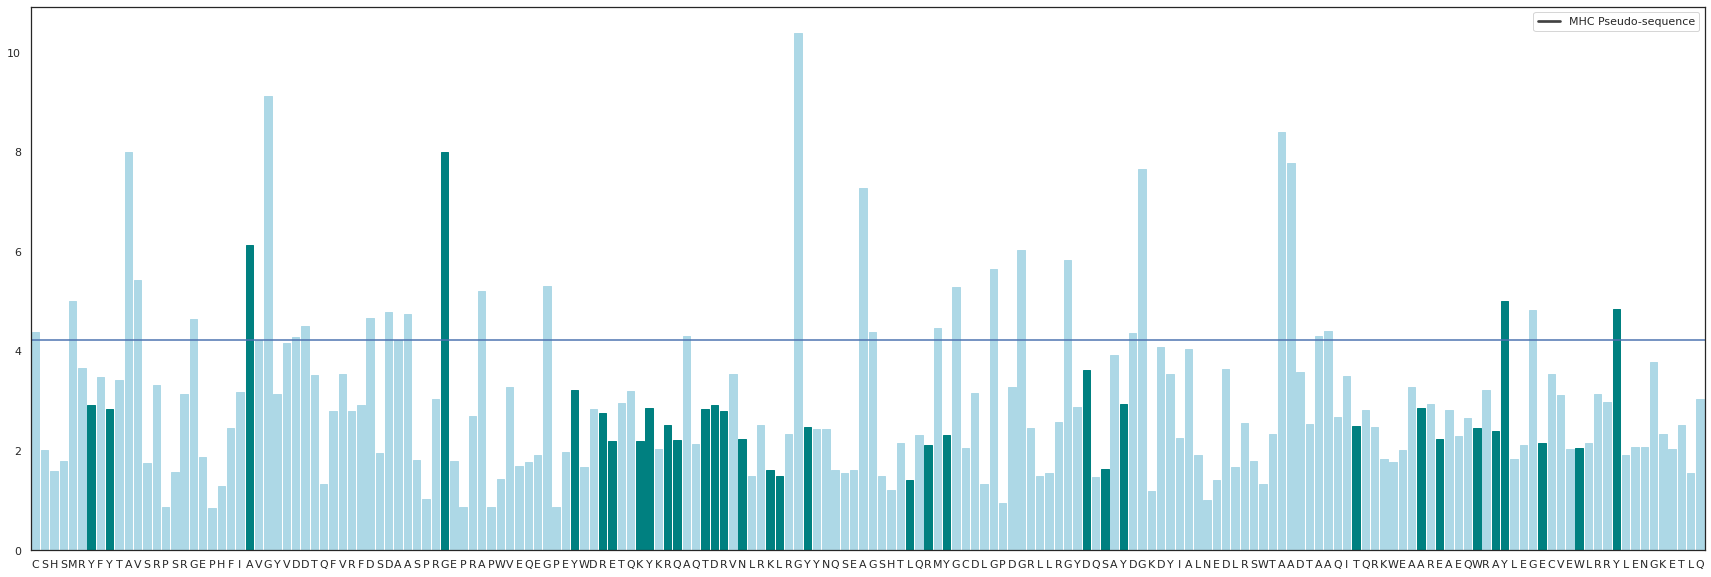



YYAGYREKYRQTDVNKLYLRYDSYTWAEWAYEWY

CMAVGAGDDDDAAGAGAGAGMGGGGDGAAAAYGY
0.49422799422799424



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 978
HLA: HLA-B*51:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRENLRIALRYYNQSEAGSHTWQTMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRHLENGKETLQ
threshold: 4.321610589212679


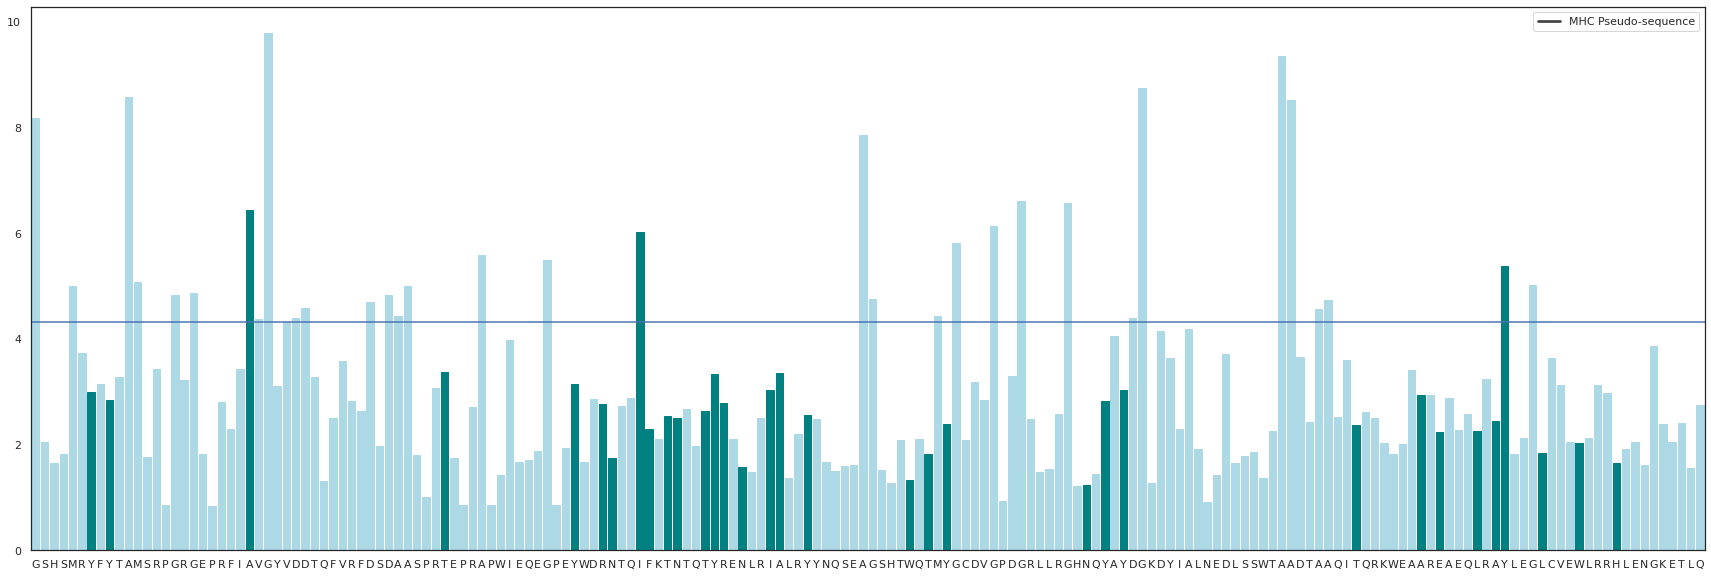



YYATYRNIFTNTYENIAYWTYNYYTWAELAYLWH

GMAMGGAVGVDDDDAAAGIAGMGGGGDGAAAAYG
0.49670171098742527



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1033
HLA: HLA-C*08:02
CSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKKTLQ
threshold: 4.258764955681269


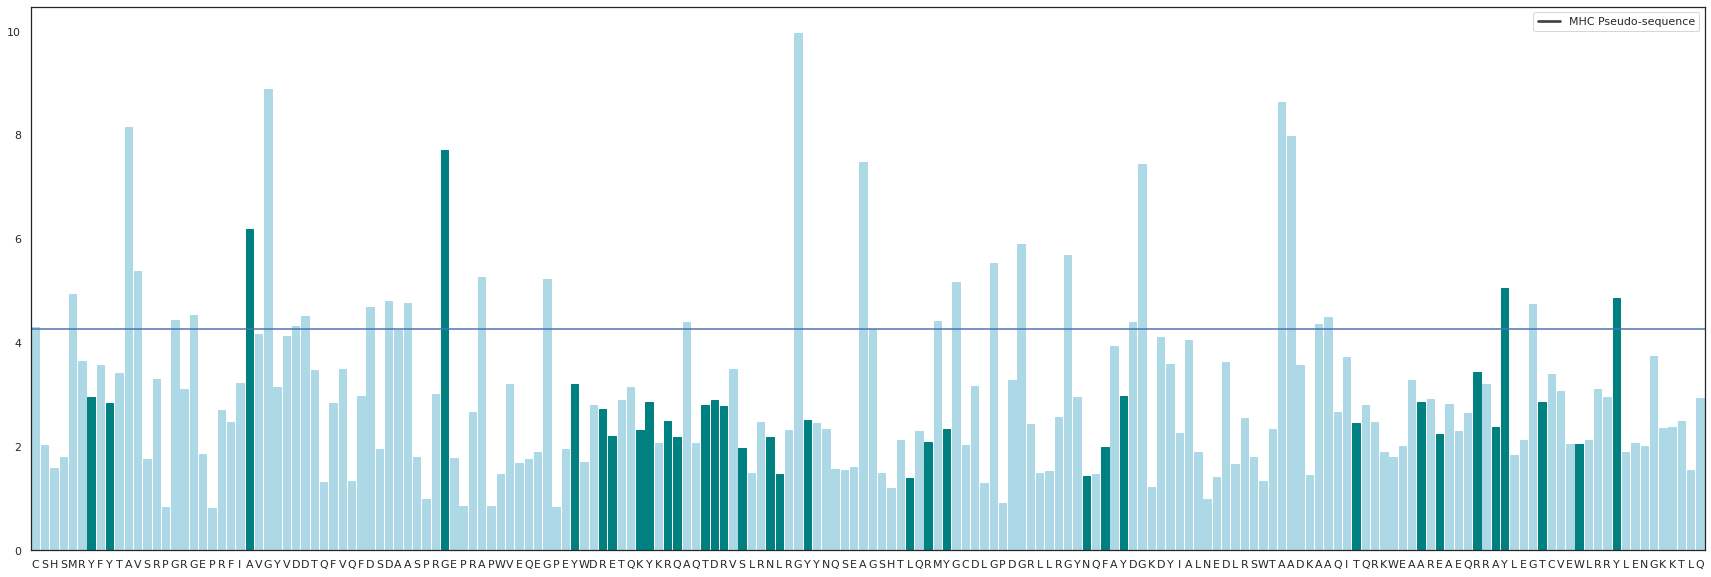



YYAGYREKYRQTDVSNLYLRYNFYTWAERAYTWY

CMAVGGAGDDDDAGAGAGAGMGGGGDGAAAAYGY
0.4930942073799217



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1028
HLA: HLA-A*68:02
GSHSMRYFYTSMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQRMYGCDVGPDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.248355613144455


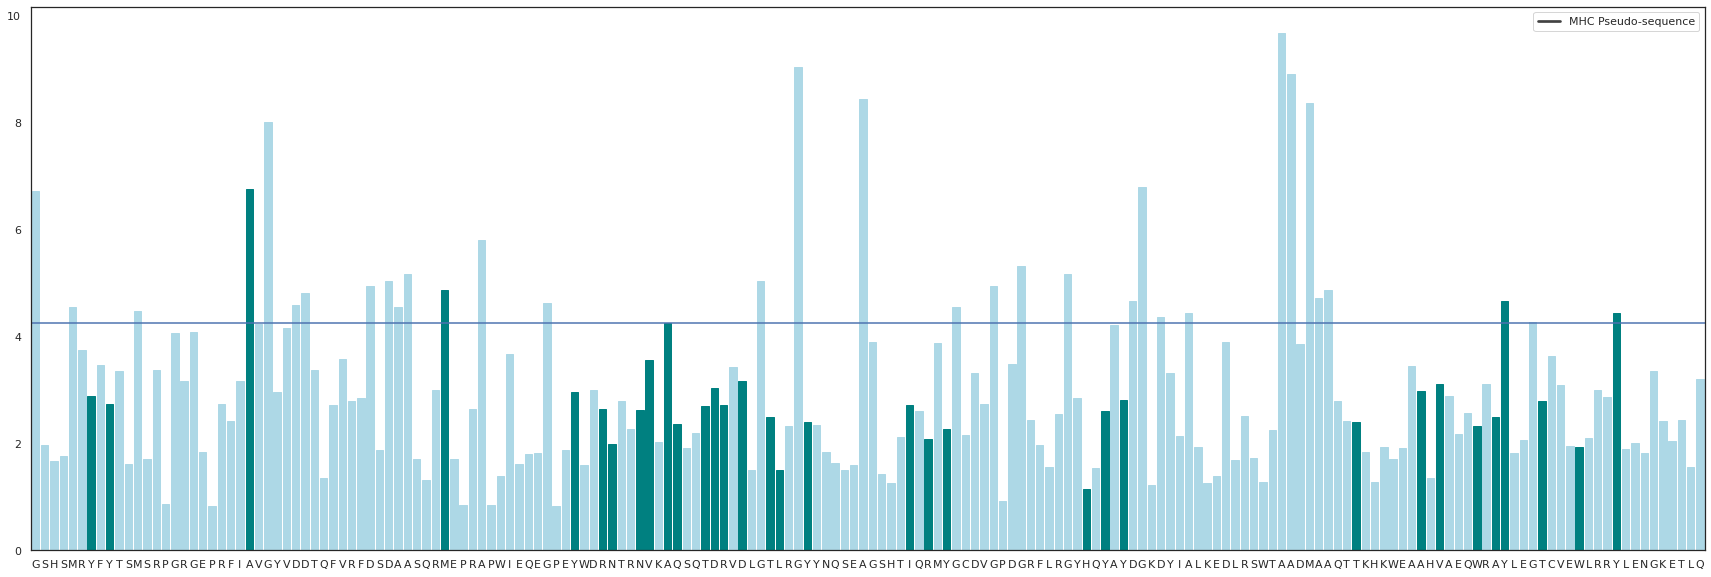



YYAMYRNNVAQTDVDTLYIRYHYYTWAVWAYTWY

GMMAGDDDDAAMAGAGGAGGGGDGDAAAMAAYGY
0.5392702535559678



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1077
HLA: HLA-C*06:02
CSHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.15759742049675


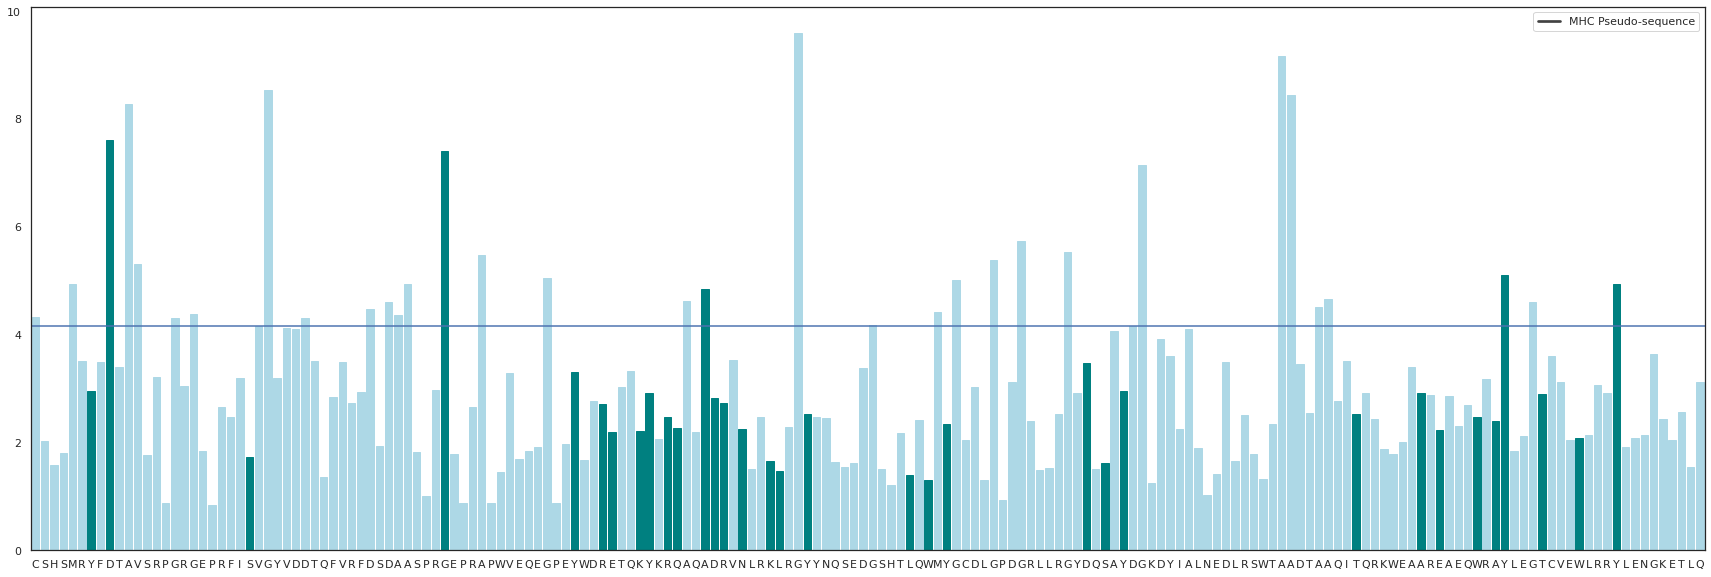



YDSGYREKYRQADVNKLYLWYDSYTWAEWAYTWY

CMDAVGGGDDDAAGAGAAGGMGGGGDGAAAAYGY
0.48381776953205524



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1187
HLA: HLA-B*08:01
GSHSMRYFDTAMSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIFKTNTQTDRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARVAEQDRAYLEGTCVEWLRRYLENGKDTLE
threshold: 4.23917883187658


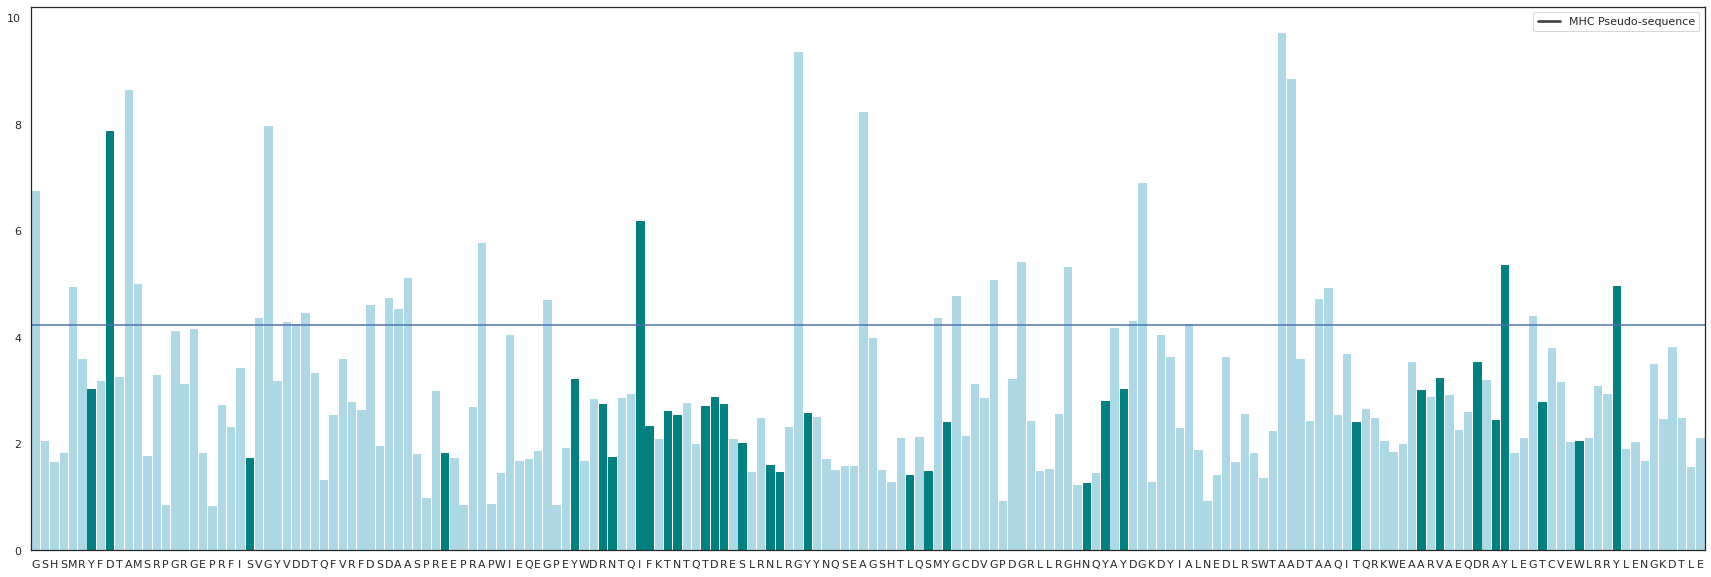



YDSEYRNIFTNTDESNLYLSYNYYTWAVDAYTWY

GMDAMVGVDDDDAAAGIGAMGGGGDGAAAAAYGY
0.48381776953205524



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1130
HLA: HLA-B*44:03
GSHSMRYFYTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRTALRYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVESLRRYLENGKETLQ
threshold: 4.358706962112832


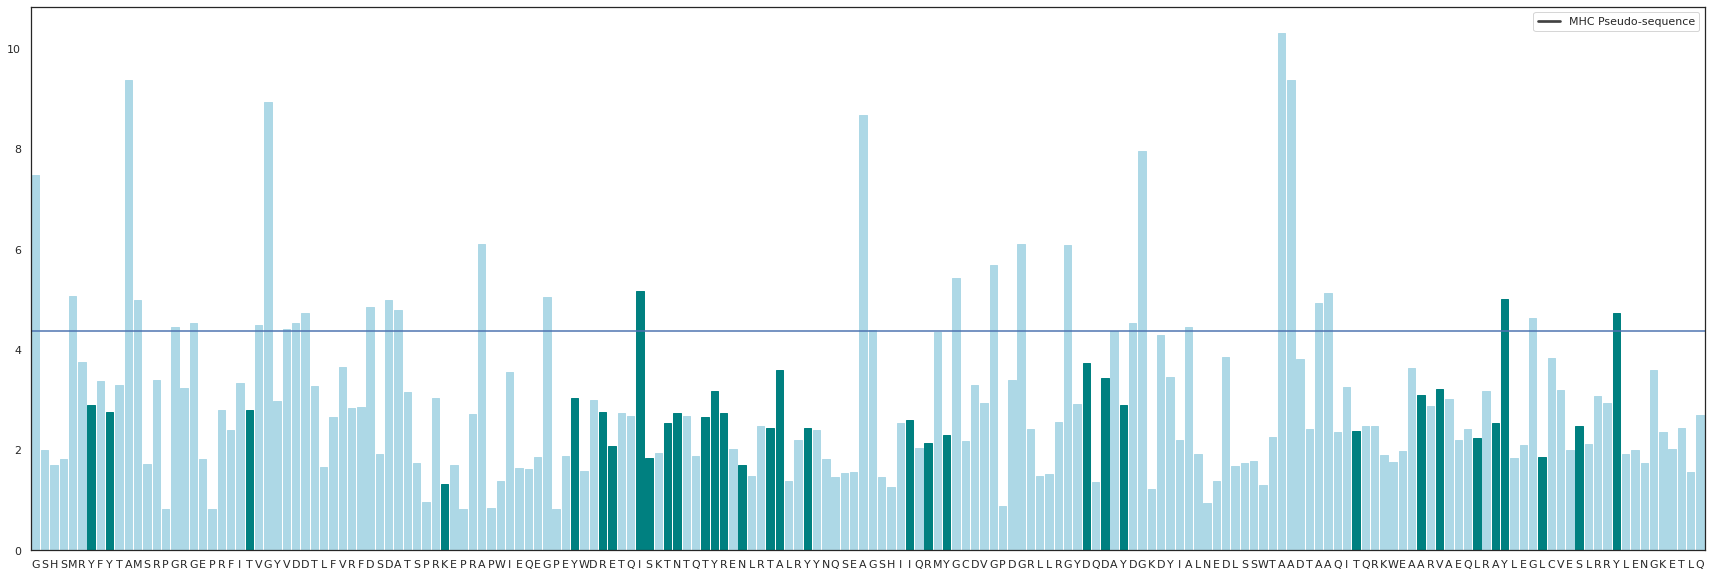



YYTKYREISTNTYENTAYIRYDDYTWAVLAYLSY

GMAMGGVGVDDDDAAGIAGGGGGADGAAAAAYGY
0.5339105339105339



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1172
HLA: HLA-A*29:02
GSHSMRYFTTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDLQTRNVKAQSQTDRANLGTLRGYYNQSEAGSHTIQMMYGCDVGSDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.238987008052474


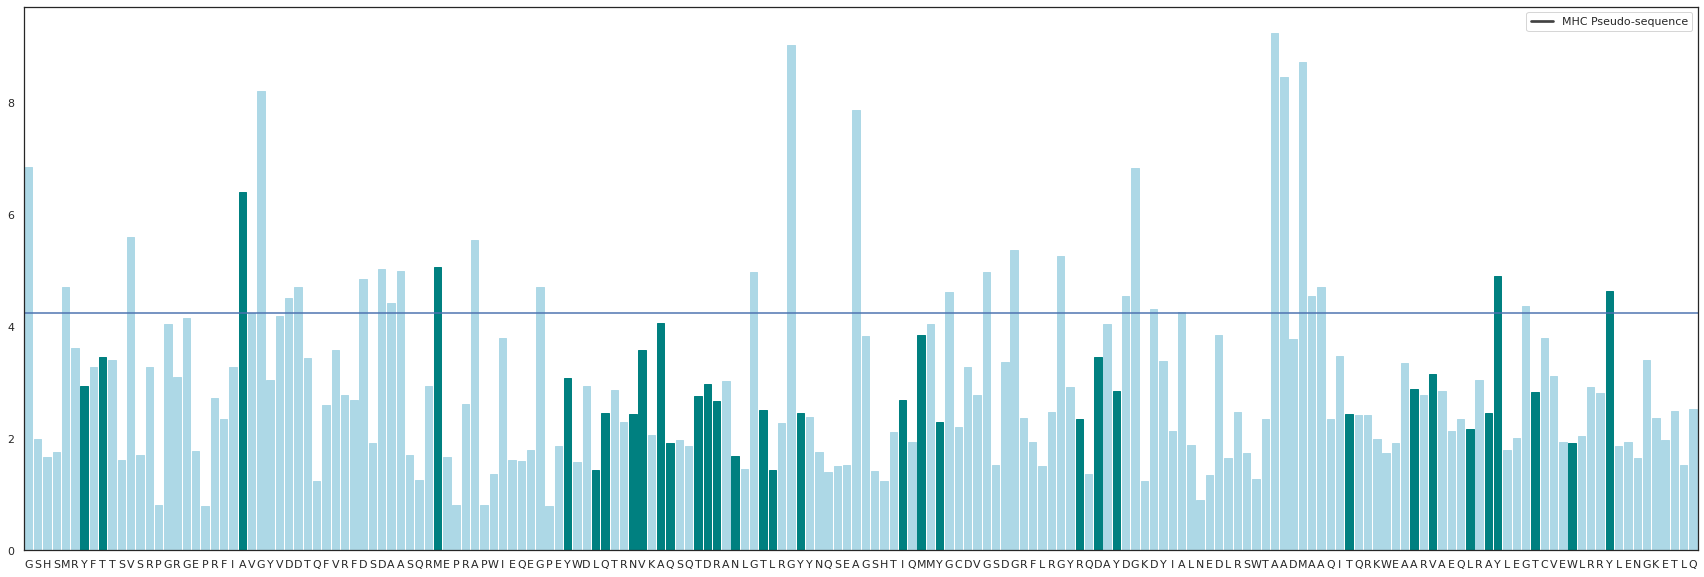



YTAMYLQNVAQTDANTLYIMYRDYTWAVLAYTWY

GMVAVGDDDDAAMAGGGAGGGGDGDAAAMAAYGY
0.5529787672644816



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1401
HLA: HLA-A*68:01
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQMMYGCDVGSDGRFLRGYRQDAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.161864014543183


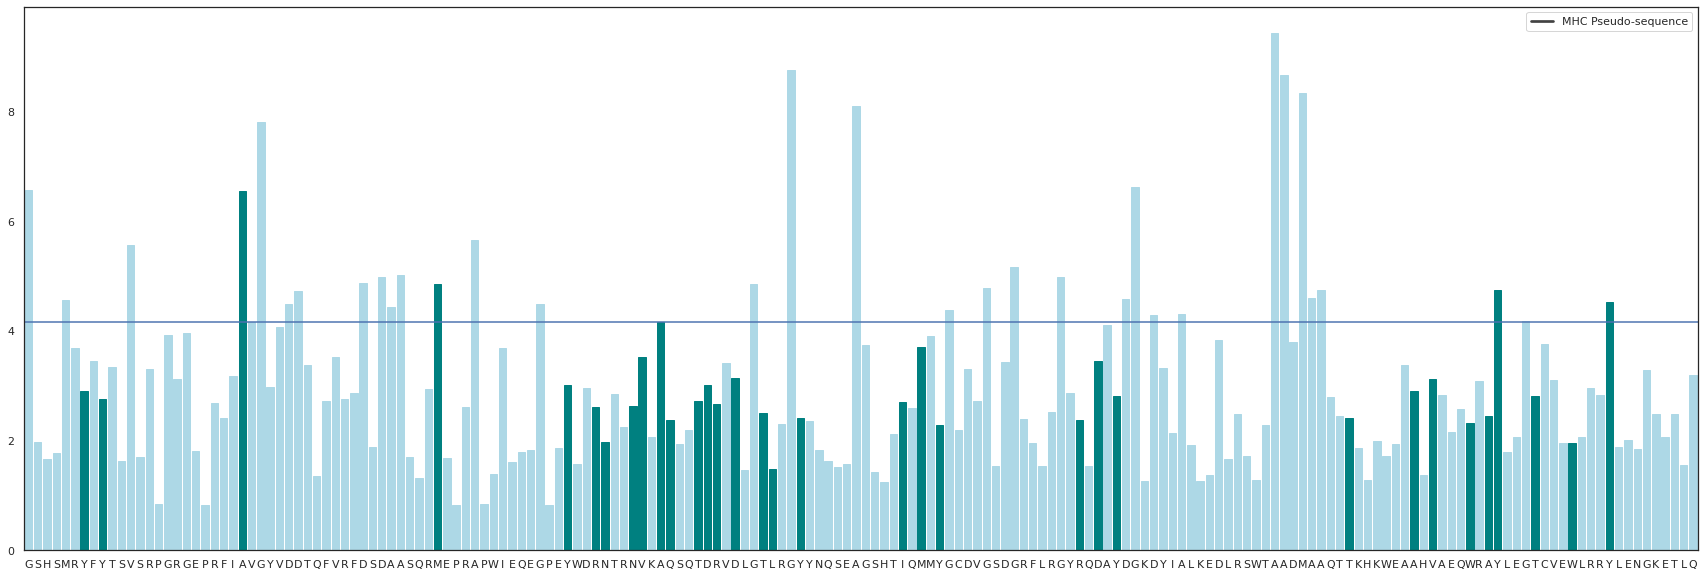



YYAMYRNNVAQTDVDTLYIMYRDYTWAVWAYTWY

GMVAGDDDDAAMAGAGGAGGGGDGDAAAMAAYGY
0.5717377860235003



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1442
HLA: HLA-B*44:02
GSHSMRYFYTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRTALRYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVESLRRYLENGKETLQ
threshold: 4.3368825714069


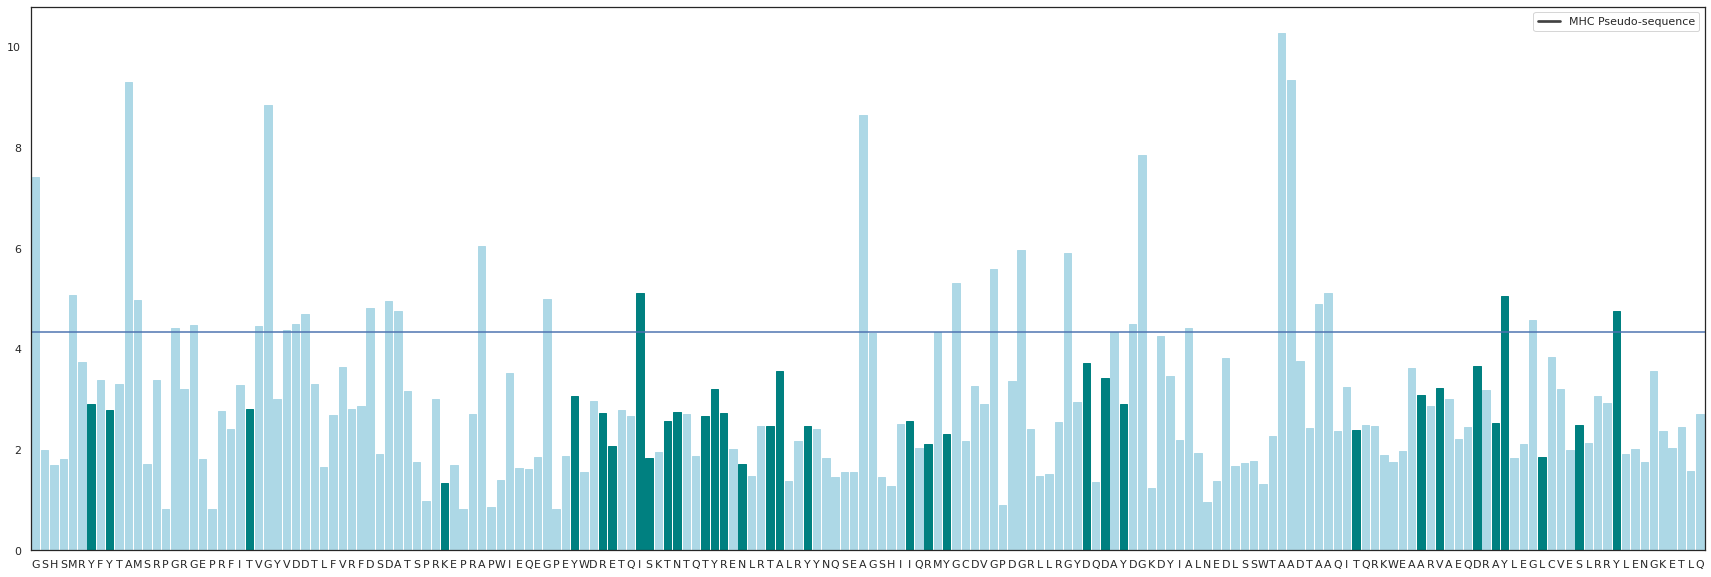



YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY

GMAMGGVGVDDDDAAGIAMGGGGADGAAAAAYGY
0.5463821892393321



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1505
HLA: HLA-B*40:02
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.142064537479236


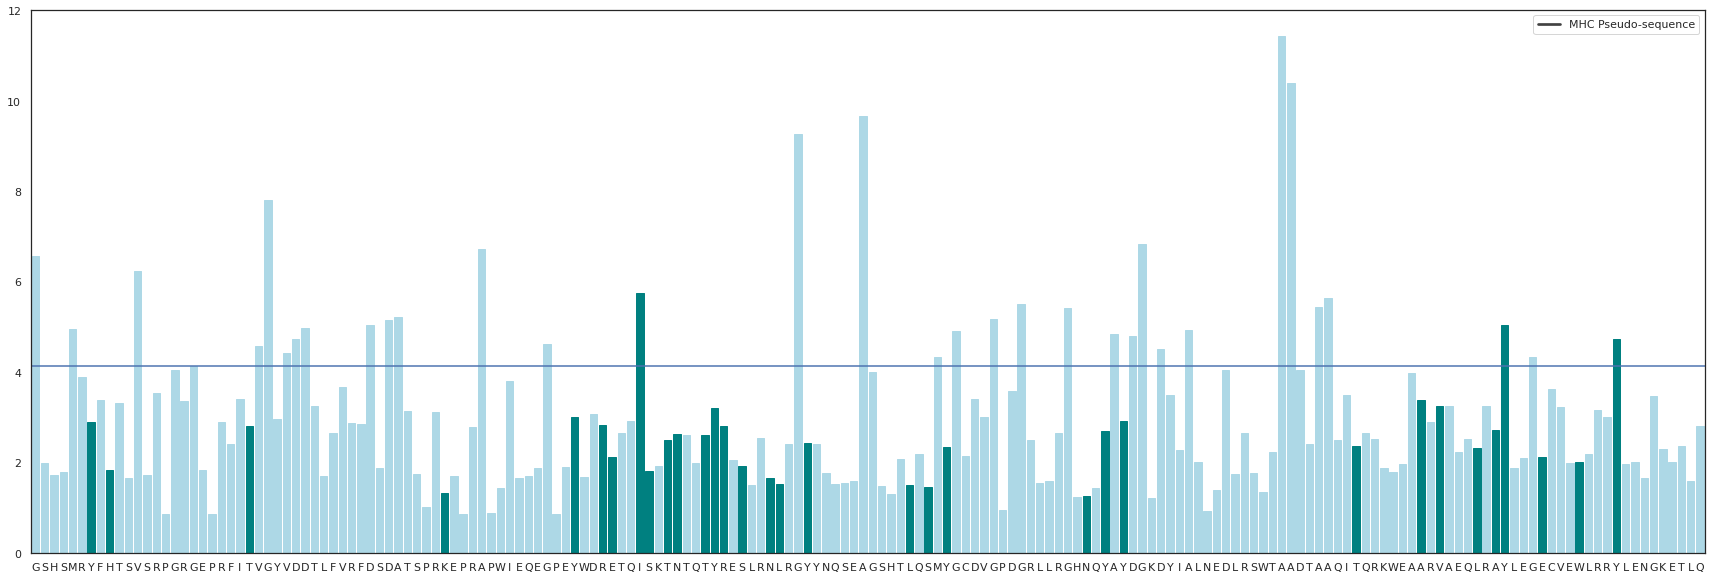



YHTKYREISTNTYESNLYLSYNYYTWAVLAYEWY

GMVGVGVDDDDAAGIGAMGGGGADGDAAAAAYGY
0.4510410224695939



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1664
HLA: HLA-A*24:02
GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITKRKWEAAHVAEQQRAYLEGTCVDGLRRYLENGKETLQ
threshold: 4.248509040245643


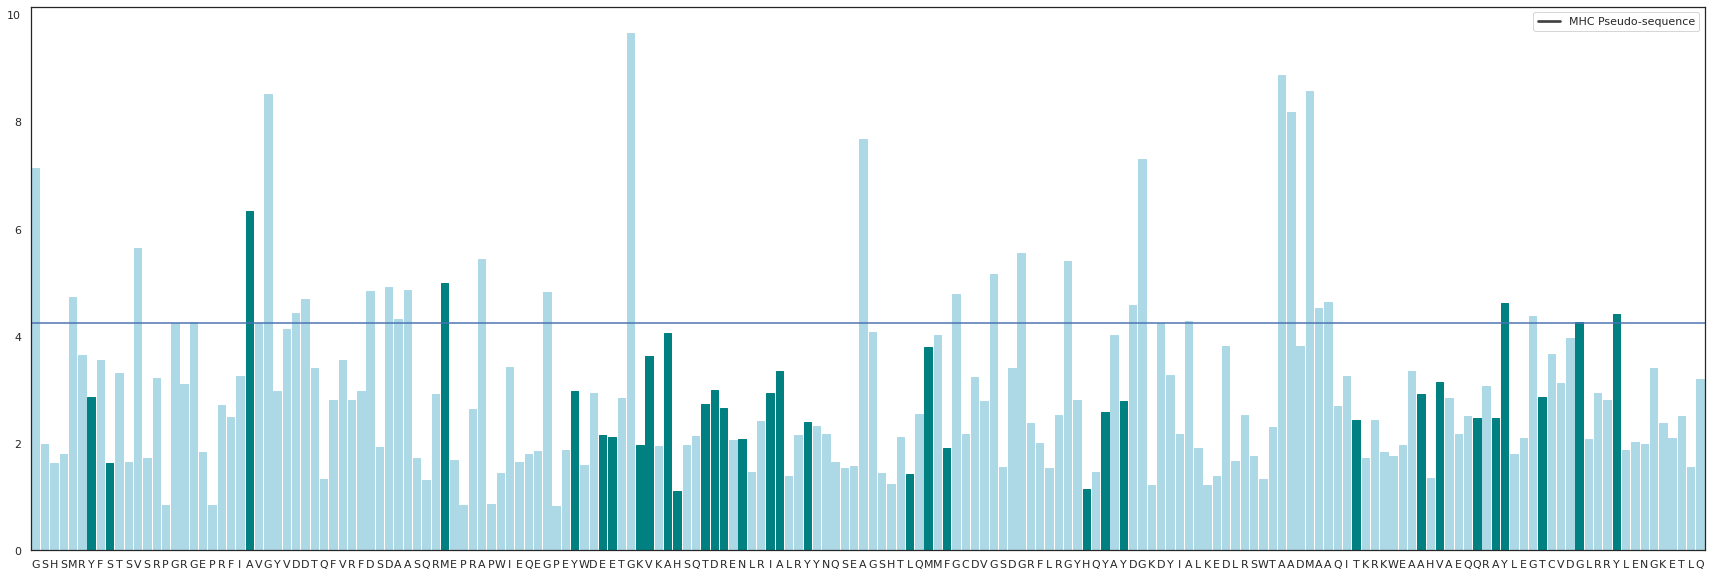



YSAMYEEKVAHTDENIAYLMFHYYTWAVQAYTGY

GMVGGAGDDDDAAMAGGAGGGGDGAAAMAAYGGY
0.531127602556174



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1705
HLA: HLA-A*01:01
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQKMEPRAPWIEQEGPEYWDQETRNMKAHSQTDRANLGTLRGYYNQSEDGSHTIQIMYGCDVGPDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAVHAAEQRRVYLEGRCVDGLRRYLENGKETLQ
threshold: 4.229934074871701


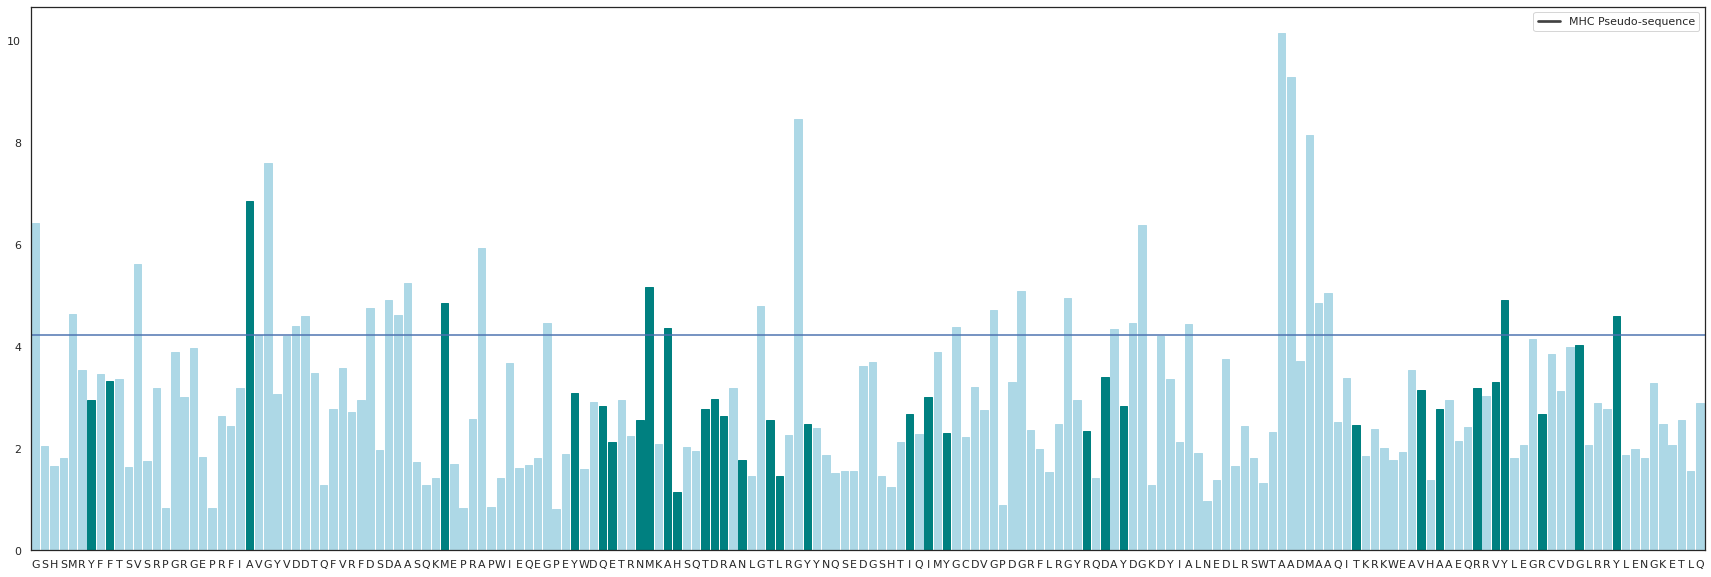



YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY

GMVAVGDDDDAAMAGMAGGGGGGADGAAAMAAYY
0.5842094413522985



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1722
HLA: HLA-C*04:01
GSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.382093972306911


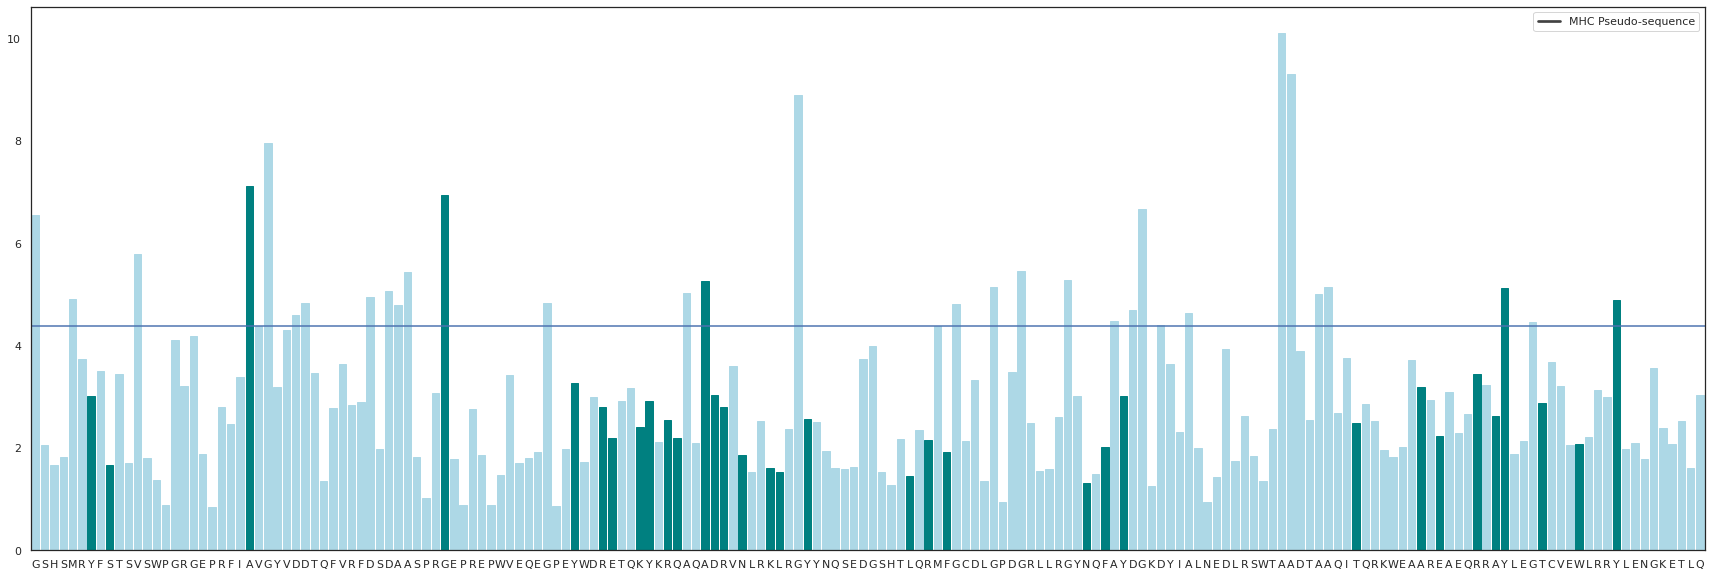



YSAGYREKYRQADVNKLYLRFNFYTWAERAYTWY

GMVAVGDDDDAAGGAAGMGGGGADGDAAAAAYGY
0.4965986394557823



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1755
HLA: HLA-B*35:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRESLRNLRGYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.352492042824074


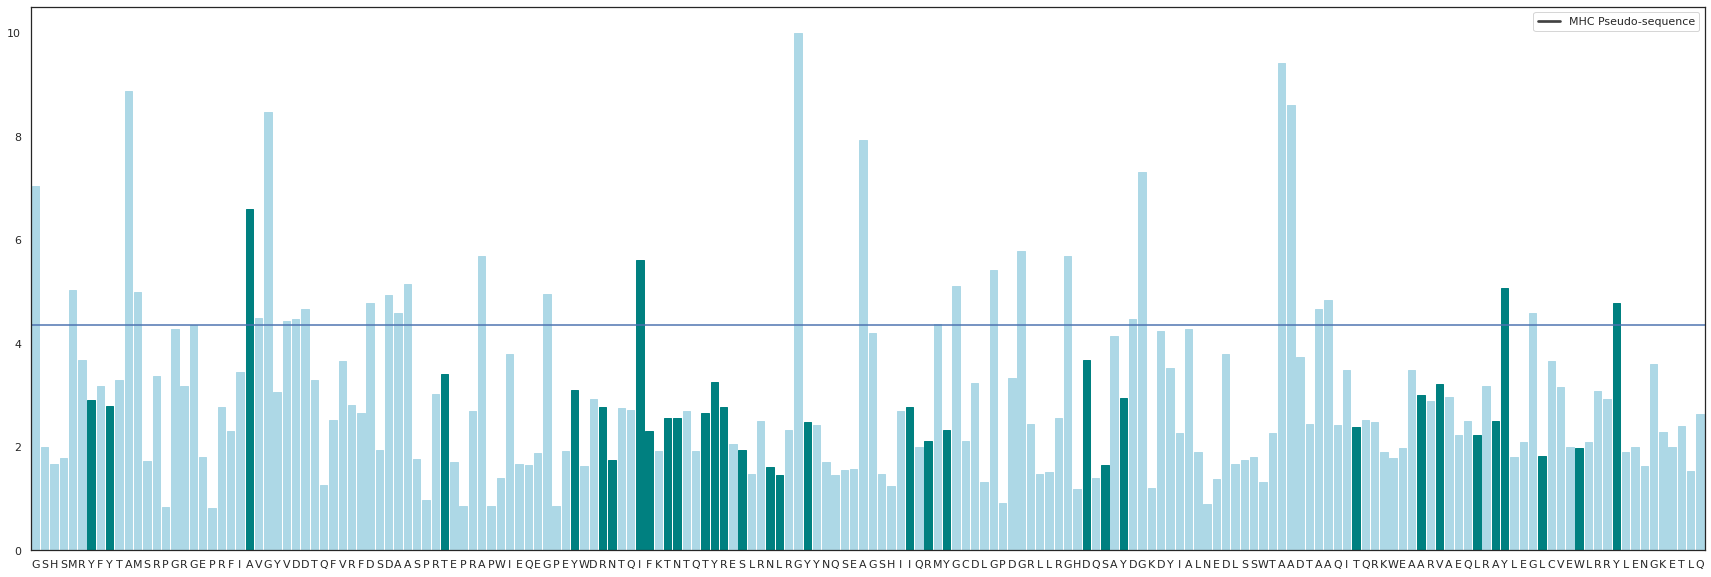



YYATYRNIFTNTYESNLYIRYDSYTWAVLAYLWY

GMAMGAVGVDDDDAAAGIGAMGGGGDGAAAAYGY
0.5264893836322407



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1887
HLA: HLA-A*11:01
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAQSQTDRVDLGTLRGYYNQSEDGSHTIQIMYGCDVGPDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAAHAAEQQRAYLEGRCVEWLRRYLENGKETLQ
threshold: 4.256380777606651


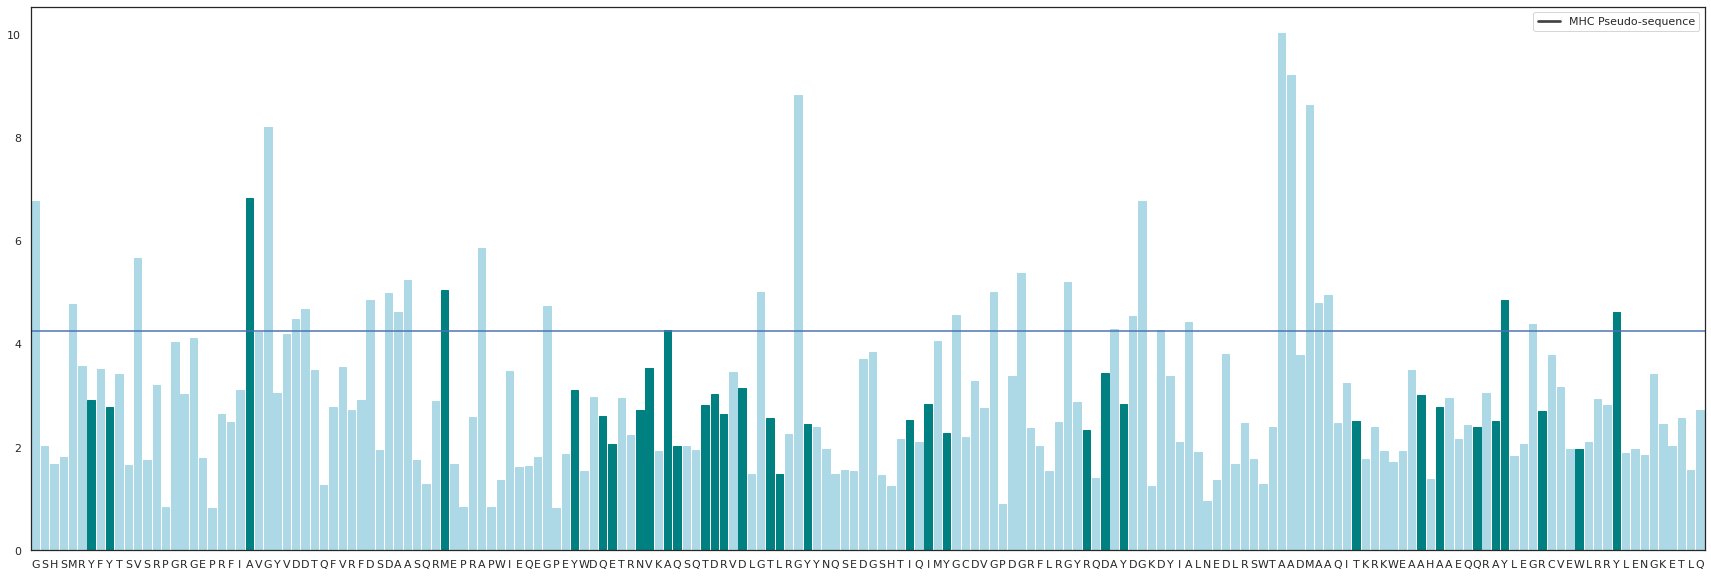



YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY

GMVAGDDDDAAMAGAGGGGGGADGDAAAMAAYGY
0.5678210678210679



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 2110
HLA: HLA-A*03:01
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQIMYGCDVGSDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAAHEAEQLRAYLDGTCVEWLRRYLENGKETLQ
threshold: 4.21385237707346


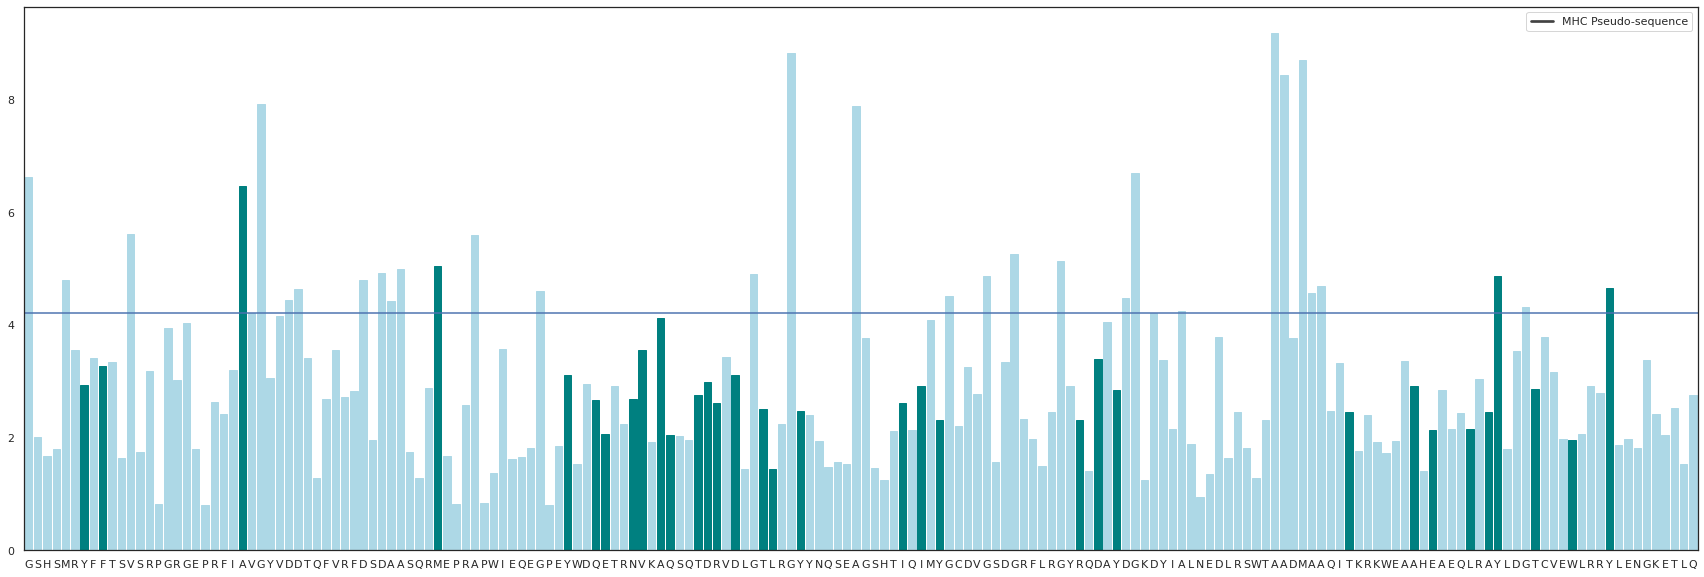



YFAMYQENVAQTDVDTLYIIYRDYTWAELAYTWY

GMVAVGDDDDAAMAGGGAGGGGDGDAAAMAAYGY
0.5624613481756339



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 2306
HLA: HLA-B*57:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDGETRNMKASAQTYRENLRIALRYYNQSEAGSHIIQVMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.272464325401128


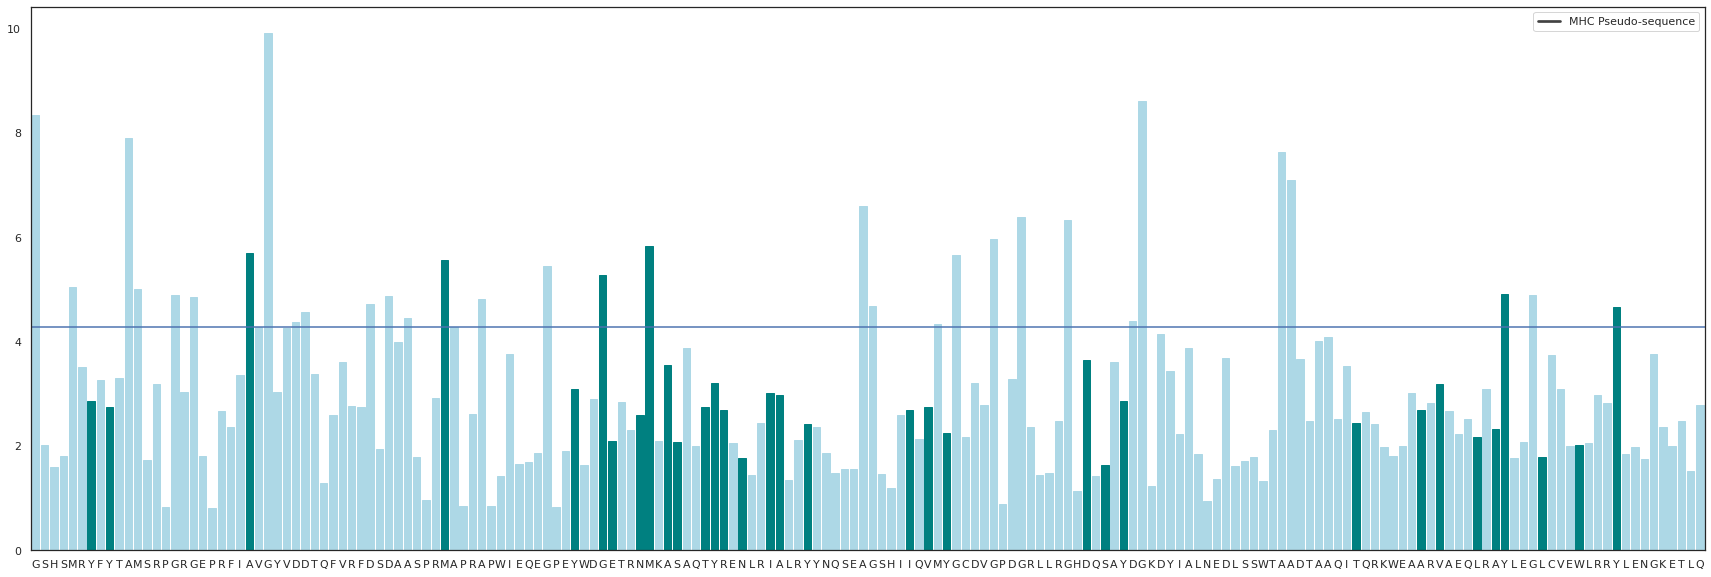



YYAMYGENMASTYENIAYIVYDSYTWAVLAYLWY

GMAMGGAVGDDDDAMAAGGMAGMGGGGDGAAYGY
0.5755514326942899



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 2663
HLA: HLA-B*07:02
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGECVEWLRRYLENGKDKLE
threshold: 4.367014410439354


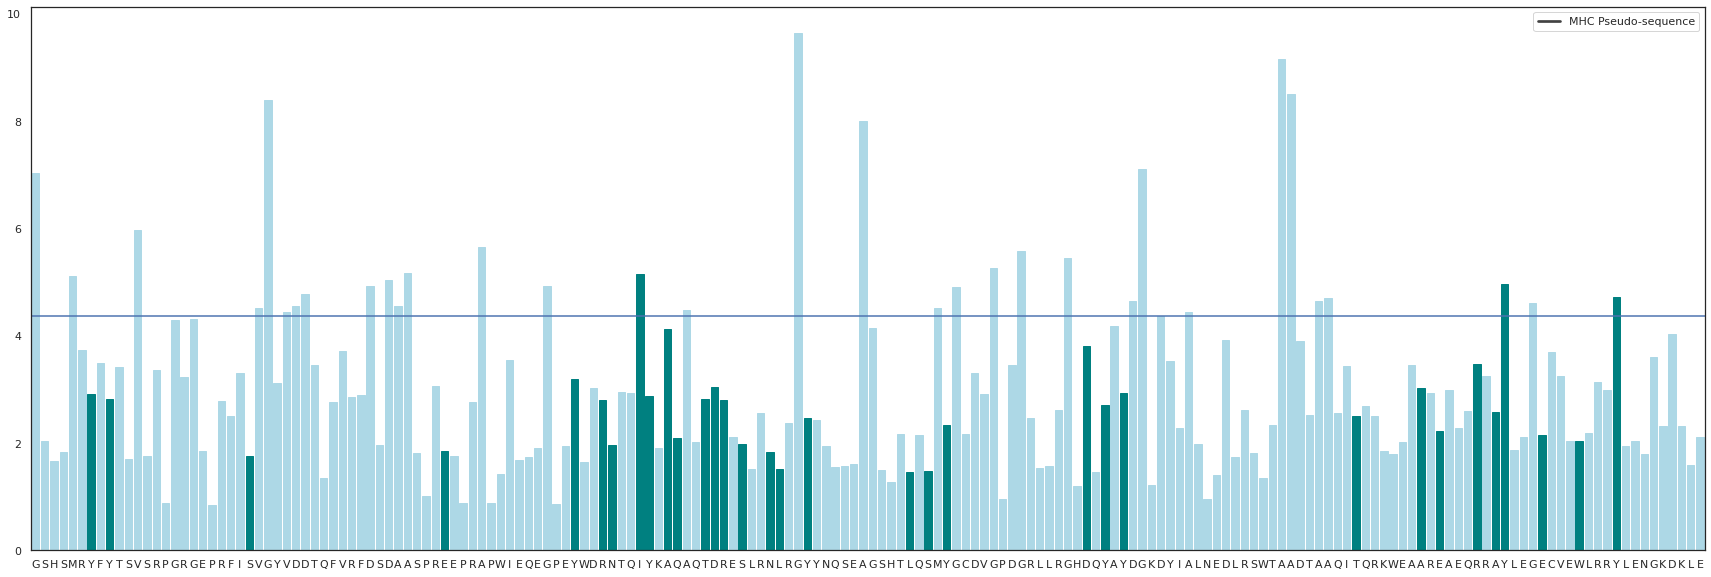



YYSEYRNIYAQTDESNLYLSYDYYTWAERAYEWY

GMVVGVDDDDAAAGIAGAMGGGGDGDAAAAAYGY
0.4853638425066996



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 2776
HLA: HLA-B*15:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQWRAYLEGLCVEWLRRYLENGKETLQ
threshold: 4.404819279651477


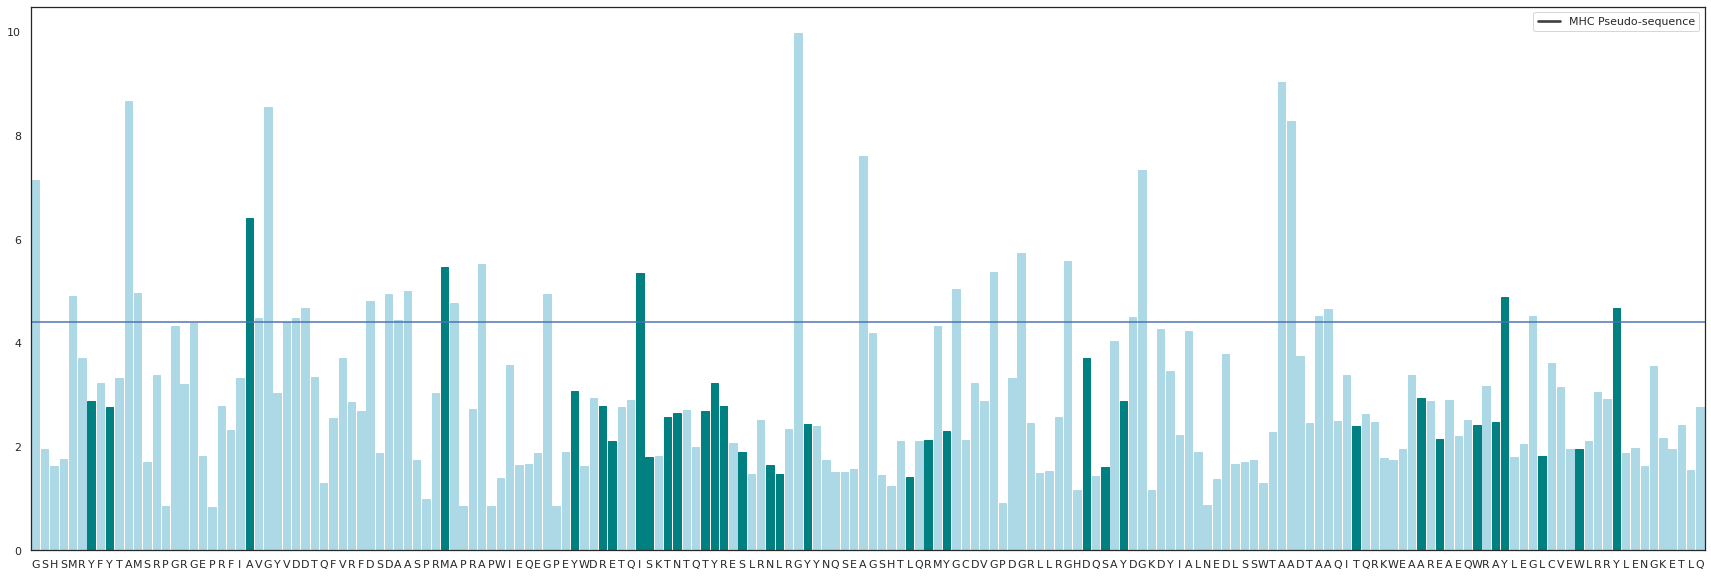



YYAMYREISTNTYESNLYLRYDSYTWAEWAYLWY

GMAMAVGVDDDDAAMAAGIGAGGGGDGAAAAYGY
0.5012368583797155



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 4736
HLA: HLA-A*02:01
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 4.30872984190245


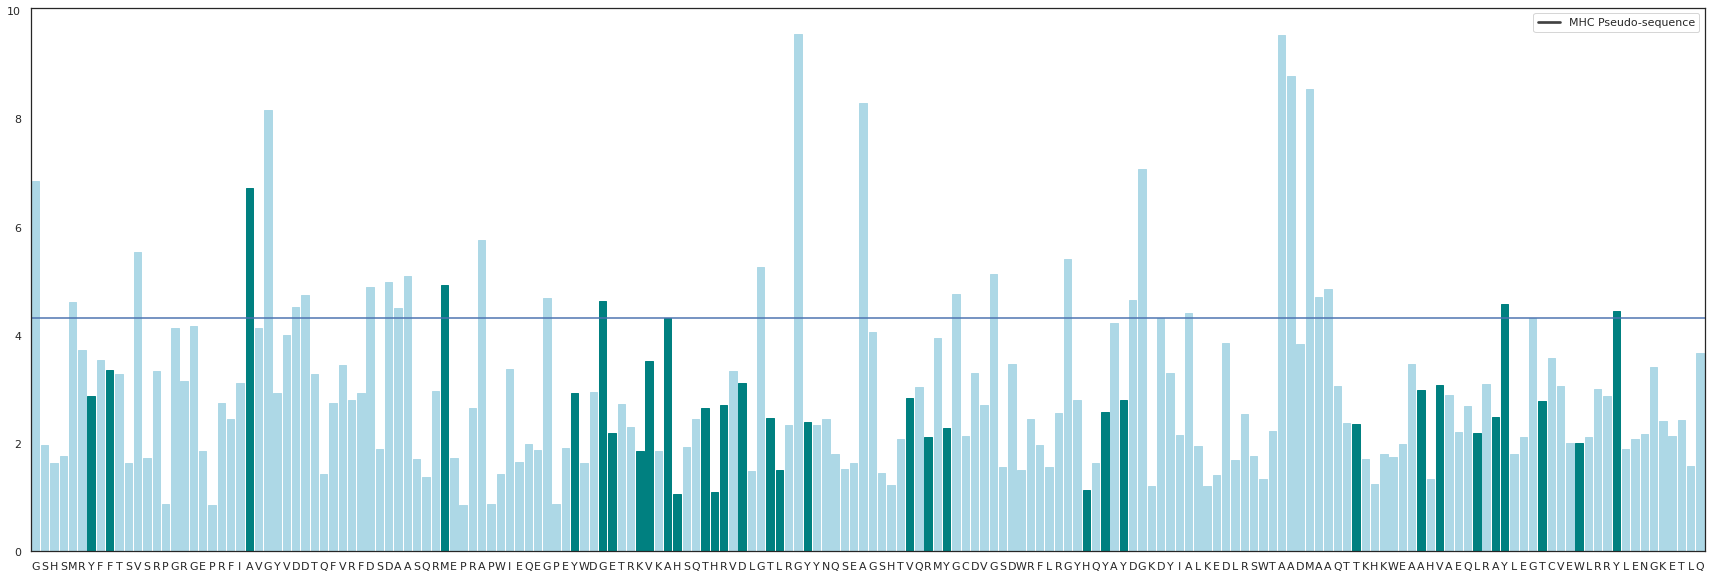



YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY

GMVAGDDDDAAMAGGAGGAGGGDGDAAAMAAYGY
0.5183467326324469



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 7306
HLA: HLA-B*27:05
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDREDLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 4.295870367677251


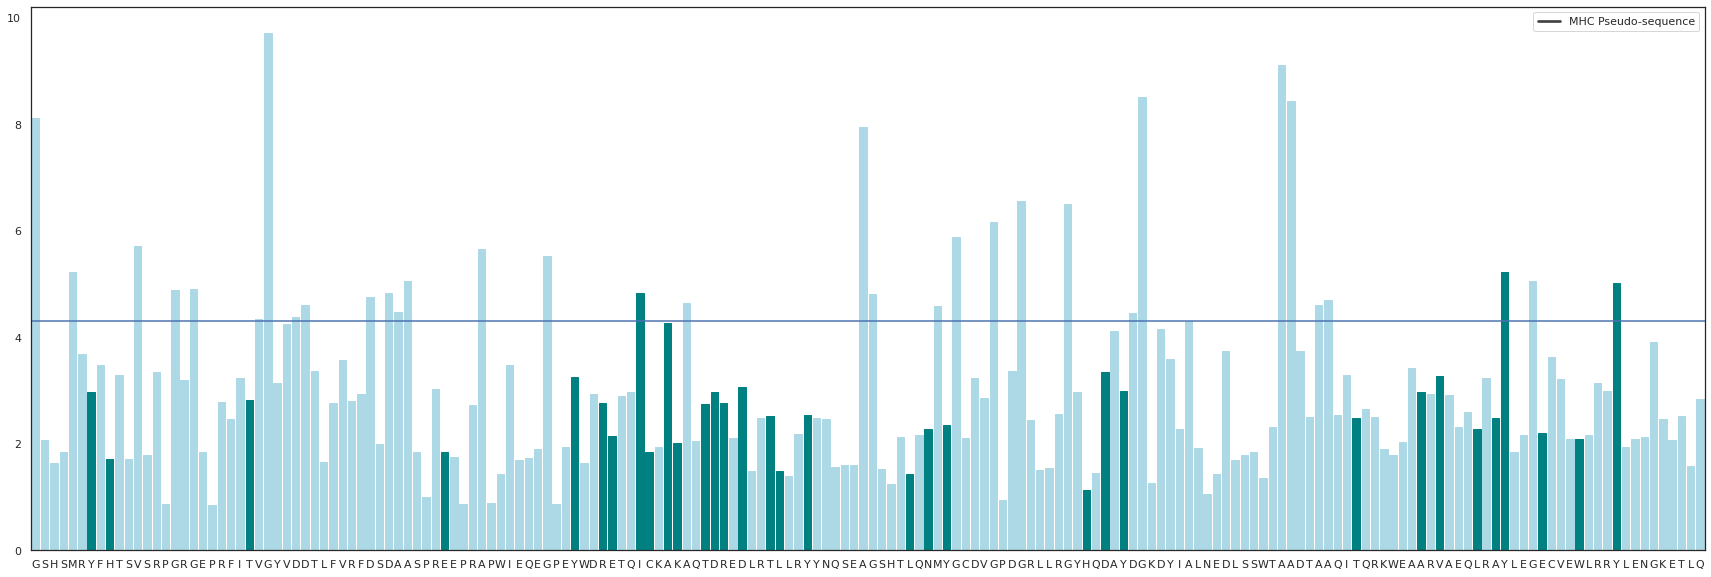



YHTEYREICAKTDEDTLYLNYHDYTWAVLAYEWY

GMVGGVGDDDDAAAGIAAGMGGGGDGAAAAAYGY
0.48989898989898994


In [40]:
#after bin__ 50 ep 3hd

bin_pos = [7,9,24,45,59,62,63,66,67,69,75,69,70,73,74,77,80,81,84,95,97,99,114,116,118,143,150,152,156,158,159,163,167,171]
bin__ = [0]*180
for i in range(len(bin__)):
    if i in bin_pos:
        bin__[i-1] = 1
    else:
        bin__[i-1] = 0
bin__
new_pseudo_bin_A = [0] * 180
new_pseudo_bin_B = [0] * 180
new_pseudo_bin_C = [0] * 180

similarity = []
print(id_emb)

HLA_list = pd.read_csv('/home/s202357/thesis/transmut/pipeline/procedure/test/performance/' + 'total_rows_per_HLA.csv').HLA.tolist()

path_saver = model_folder + fnc.pkl(id_nested, n_layers, n_heads, 0, d_model)
model_test = Transformer().to(device)
model_test.load_state_dict(torch.load(path_saver))
model_test = model_test.eval()

for HLA_filter in HLA_list:
    
    print('\n\n\n========= Model {}, {}, {} ========='.format(size,model_type,d_model))

    ep_best = 0
    fold = 0

    test_fold_metrics_list_nested = []

    type_ = 'test'

    df_list = []
    time_testing = time.time()

    fold_avg_all = [list(range(0,4)), list(range(4,8)), list(range(8,12)), list(range(12,16)), list(range(16,20))] 
    pred_all = []
    target_all = []
    enc_attn_list_all = []
    enc_hla_attn_list_all = []

    for fold_avg, file_num in zip(fold_avg_all,[0,1,2,3,4]):

            pred_fold = []
            target_fold = []
            enc_attn_list_tmp = []
            enc_hla_attn_list_tmp = []

            for f in fold_avg:
                index_order_idx = f

                test_data, test_pep_inputs, test_hla_inputs, test_labels, test_loader = data_with_loader_unique(data_dir, 
                                                                                                                    model_type, 
                                                                                                                    HLA_filter,
                                                                                                                    pep_max_len,
                                                                                                                    hla_max_len,
                                                                                                                    vocab,
                                                                                                                    index_order_idx, 
                                                                                                                    type_ = type_, 
                                                                                                                    fold = file_num,  
                                                                                                                    batch_size = batch_size)


                if 'Blosum' in model_type:
                    ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin, enc_attn_list, enc_hla_attn_list = fnc.eval_step_test_bl(model_test, 
                                                                                                       model_abbr,
                                                                                                       threshold,
                                                                                                       test_loader, 
                                                                                                       fold, 
                                                                                                       ep_best, 
                                                                                                       epochs, 
                                                                                                       use_cuda)

                else:
                    ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin, enc_attn_list, enc_hla_attn_list = fnc.eval_step_test(model_test, 
                                                                                                       model_abbr,
                                                                                                       threshold,
                                                                                                       test_loader, 
                                                                                                       fold, 
                                                                                                       ep_best, 
                                                                                                       epochs, 
                                                                                                       use_cuda) # , test_res_attns

                target_fold = [x.item() for x in test_labels]

                del enc_attn_list
                gc.collect()
                torch.cuda.empty_cache()

                df_temp = pd.DataFrame(list(zip(target_fold, y_prob)), columns= ['target', 'pred'])
                num_pos = len(df_temp[df_temp['target']==1])
                df_temp_ppv = df_temp.sort_values(by=['pred'], ascending=False)[0:num_pos]
                num_true_pos = len(df_temp_ppv[df_temp_ppv['target']==1])
                ppv = num_true_pos/num_pos
                auc_01 = fnc.binary_roc_auc_score(df_temp['target'].tolist(), df_temp['pred'], max_fpr=0.1)

                test_data['target_'] = target_fold
                test_data['pred_'] = y_prob

                del target_fold, y_prob
                gc.collect()
                torch.cuda.empty_cache()

                break 

            break

    tmp = pd.read_csv(data_dir + 'upd_{}_d.csv'.format(fold), index_col = 0).drop_duplicates()
    pseudo = tmp[tmp['HLA']==HLA_filter].HLA_sequence.tolist()[0]
    

    mhc_seq = test_data.HLA_sequence.tolist()[0]

    softmax_pd, unsoftmax_pd, max_list, new_pseudo, max_34_idx =  fnc.draw_hla_length_aatype_position_HLAfull(test_data.reset_index(drop=True), torch.from_numpy(np.array(enc_hla_attn_list)), 3, HLA_filter, pseudo, mhc_seq, label = 1 , length = None , threshold = 0.50, show = 'bar', softmax = True, unsoftmax = True)    
    print("\n\n" + pseudo)
    print("\n" + color.RED + color.BOLD + ''.join(new_pseudo) + color.END)
    
    if 'HLA-A*' in HLA_filter:
        for i in max_34_idx:
            new_pseudo_bin_A[i] += 1

    elif 'HLA-B*' in HLA_filter:
        for i in max_34_idx:
            new_pseudo_bin_B[i] += 1
    else:
        for i in max_34_idx:
            new_pseudo_bin_C[i] += 1  

    auc_sim = roc_auc_score(bin__, max_list)
    print(auc_sim)
    
    similarity.append([HLA_filter, auc_sim, mhc_seq, pseudo, ''.join(new_pseudo)] )
    del tmp, enc_hla_attn_list, test_data
    gc.collect()
    torch.cuda.empty_cache()


In [86]:
## GLOBAL PLOT:
## MOST IMPORTANT POSITIONS ORG PSEUDO SEQ - AND NEW:

def draw_HLA_positional_importance(new_pseudo_bin_A):
    top_34_new_idx = np.argsort(new_pseudo_bin_A)[-34:]
    threshold = np.sort(new_pseudo_bin_A, axis=None)[-34:][0]
    
    sn.set(rc = {'figure.figsize':(40,10)})
    sn.set_style("white")
    ax = sn.barplot(x=np.arange(len(new_pseudo_bin_A)), y=new_pseudo_bin_A, dodge=False)
    #ax.bar_label(ax.containers[0])
    ax.set_xticklabels(list(range(180)), rotation=45)
    ax.axhline(threshold)
    plt.legend(loc='upper right', labels=['Original MHC Pseudo-sequence'])
    idx = 1
    for bar in ax.patches:
        if idx in bin_pos:
            bar.set_color('teal')    
        else:
            bar.set_color('lightblue')
        idx += 1


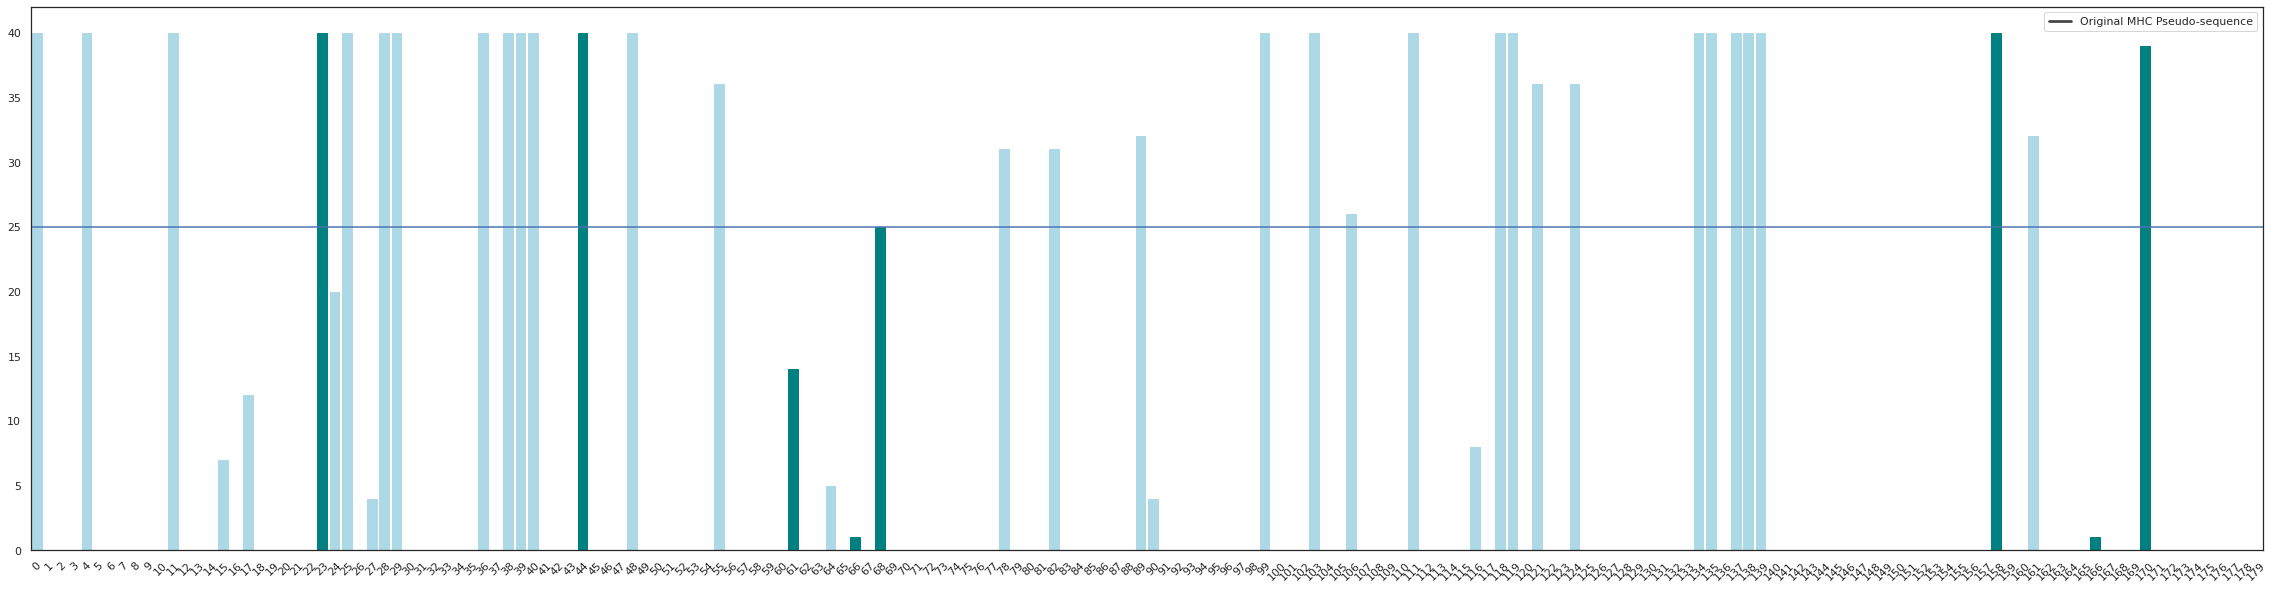

In [87]:
draw_HLA_positional_importance(new_pseudo_bin_A)

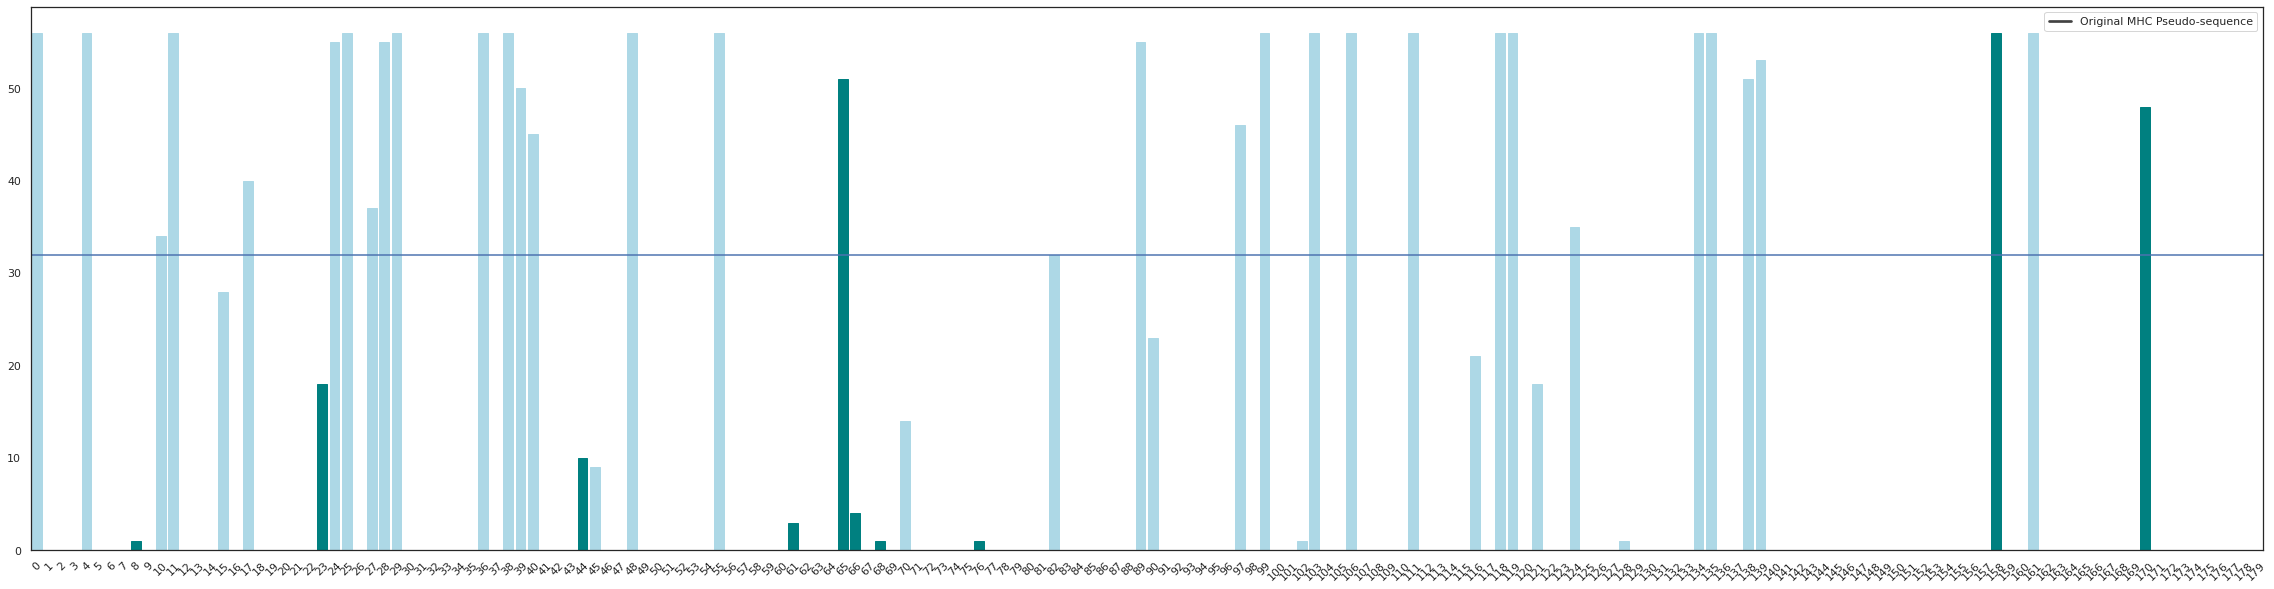

In [88]:
draw_HLA_positional_importance(new_pseudo_bin_B)

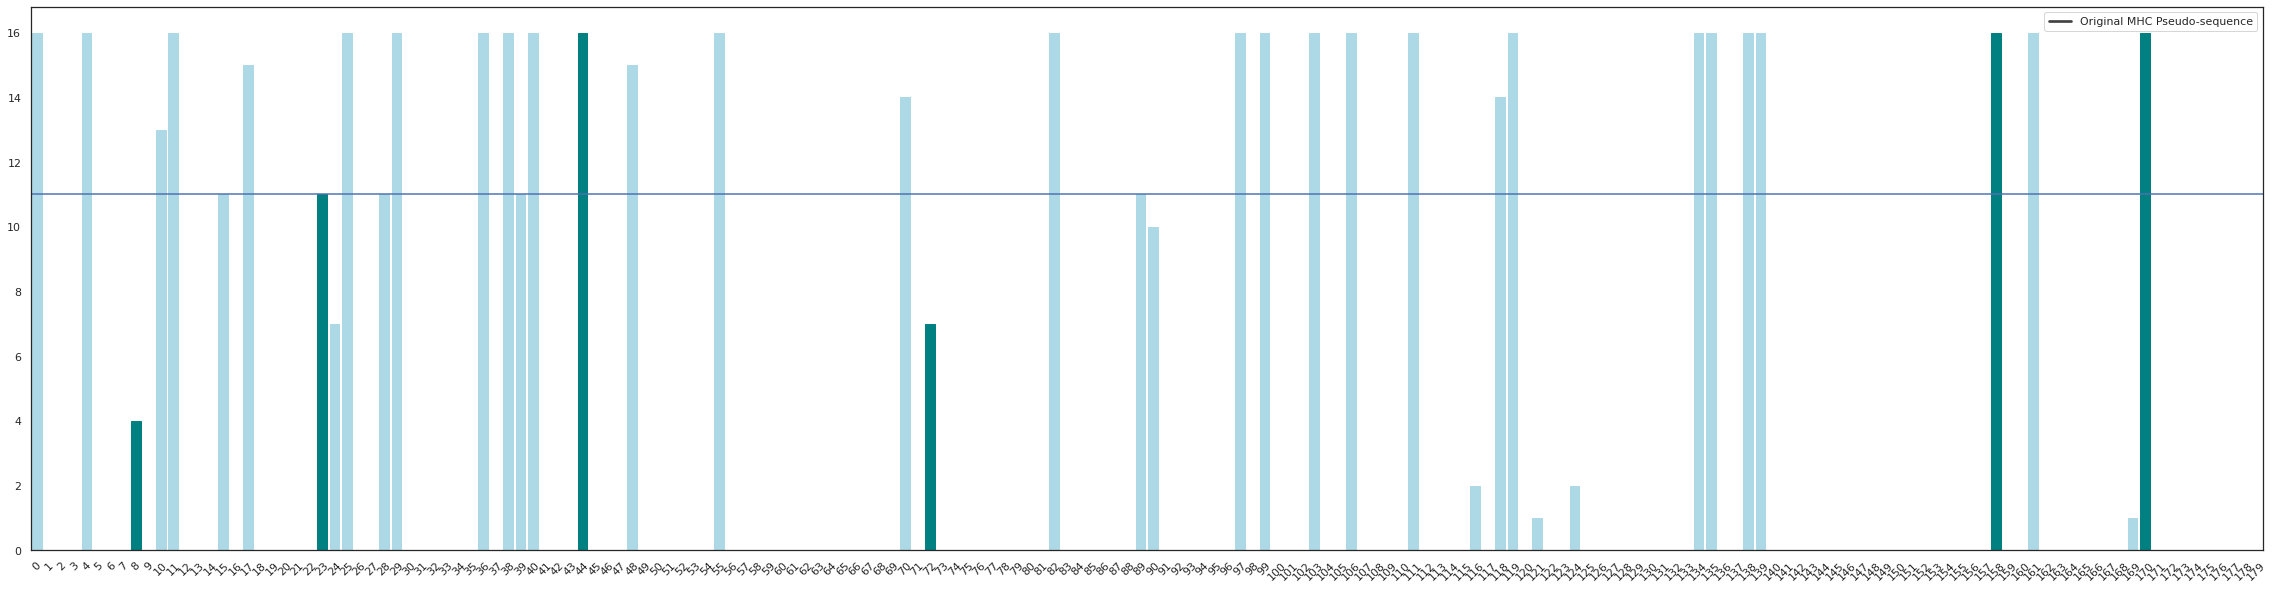

In [89]:
draw_HLA_positional_importance(new_pseudo_bin_C)

In [ ]:
for i in [x+1 for x in max_34_idx]:
    print(i, end='+')

In [20]:
import sys

nums = new_pseudo_values
nums = [round((n - min(nums))/(max(nums)-min(nums))*100,2) for n in nums]

In [16]:

def rreplace(s, old, new, occurrence):
        li = s.rsplit(old, occurrence)
        return new.join(li)


with open("pdb.txt", 'r') as infile, open("pdb_edited.txt", 'w') as outfile:

        for line in infile:

            if line.startswith('ATOM'):

                val = line.strip().split()[-2]
                pos = line.strip().split()[-7]
                chain = line.strip().split()[-8]

                newline = line

                idx = newline.rindex(val)

                if chain == 'A' and int(pos) <= 180:
                    newline = rreplace(newline, val, str(nums[int(pos)-1]), 1)
                else:
                    newline = rreplace(newline, val, "0.00", 1)

                outfile.write(newline)

            else:
                outfile.write(line)

outfile.close()

30.08 1 A
ATOM      1  N   GLY A   1      -9.261 -12.292 -43.862  1.00 68.83           N  

28.53 1 A
ATOM      2  CA  GLY A   1     -10.410 -11.442 -43.601  1.00 68.83           C  

26.17 1 A
ATOM      3  C   GLY A   1     -10.245 -10.059 -44.196  1.00 68.83           C  

24.90 1 A
ATOM      4  O   GLY A   1      -9.315  -9.831 -44.965  1.00 68.83           O  

22.21 2 A
ATOM      5  N   SER A   2     -11.165  -9.158 -43.859  1.00 12.6           N  

20.90 2 A
ATOM      6  CA ASER A   2     -11.156  -7.776 -44.347  0.37 12.6           C  

20.80 2 A
ATOM      7  CA BSER A   2     -11.156  -7.776 -44.348  0.63 12.6           C  

20.80 2 A
ATOM      8  C   SER A   2     -10.182  -6.921 -43.539  1.00 12.6           C  

19.47 2 A
ATOM      9  O   SER A   2      -9.839  -7.269 -42.417  1.00 12.6           O  

24.40 2 A
ATOM     10  CB ASER A   2     -12.557  -7.181 -44.297  0.37 12.6           C  

23.32 2 A
ATOM     11  CB BSER A   2     -12.557  -7.190 -44.287  0.63 12.6           

17.50 60 A
ATOM    526  CG  TRP A  60      10.498   7.504 -41.121  1.00 8.8           C  

19.92 60 A
ATOM    527  CD1 TRP A  60      11.177   6.385 -41.520  1.00 8.8           C  

16.77 60 A
ATOM    528  CD2 TRP A  60       9.353   7.035 -40.382  1.00 8.8           C  

18.80 60 A
ATOM    529  NE1 TRP A  60      10.583   5.258 -41.002  1.00 8.8           N  

19.34 60 A
ATOM    530  CE2 TRP A  60       9.428   5.623 -40.342  1.00 8.8           C  

17.24 60 A
ATOM    531  CE3 TRP A  60       8.236   7.676 -39.814  1.00 8.8           C  

18.54 60 A
ATOM    532  CZ2 TRP A  60       8.465   4.838 -39.689  1.00 8.8           C  

16.66 60 A
ATOM    533  CZ3 TRP A  60       7.272   6.901 -39.192  1.00 8.8           C  

16.88 60 A
ATOM    534  CH2 TRP A  60       7.397   5.500 -39.116  1.00 8.8           C  

16.88 61 A
ATOM    535  N   ASP A  61      10.643  11.312 -43.765  1.00 23.82           N  

17.49 61 A
ATOM    536  CA  ASP A  61      10.690  12.744 -44.068  1.00 23.82           

15.73 103 A
ATOM    882  N   VAL A 103     -10.507  -2.791 -47.374  1.00 21.27           N  

16.40 103 A
ATOM    883  CA  VAL A 103     -10.323  -3.832 -48.411  1.00 21.27           C  

19.13 103 A
ATOM    884  C   VAL A 103     -10.970  -5.098 -47.903  1.00 21.27           C  

17.74 103 A
ATOM    885  O   VAL A 103     -11.092  -5.325 -46.684  1.00 21.27           O  

18.12 103 A
ATOM    886  CB  VAL A 103      -8.864  -4.074 -48.821  1.00 21.27           C  

18.02 103 A
ATOM    887  CG1 VAL A 103      -8.235  -2.817 -49.458  1.00 21.27           C  

18.05 103 A
ATOM    888  CG2 VAL A 103      -8.016  -4.608 -47.655  1.00 21.27           C  

19.52 104 A
ATOM    889  N   GLY A 104     -11.391  -5.946 -48.848  1.00 49.0           N  

20.10 104 A
ATOM    890  CA  GLY A 104     -11.976  -7.228 -48.464  1.00 49.0           C  

23.65 104 A
ATOM    891  C   GLY A 104     -10.945  -8.324 -48.292  1.00 49.0           C  

21.29 104 A
ATOM    892  O   GLY A 104      -9.741  -8.054 -48.

18.22 151 A
ATOM   1298  NE2 HIS A 151     -11.264  21.768 -61.126  1.00 5.45           N  

13.24 152 A
ATOM   1299  N   VAL A 152     -11.877  18.523 -55.271  1.00 25.31           N  

12.50 152 A
ATOM   1300  CA  VAL A 152     -11.400  17.826 -54.065  1.00 25.31           C  

13.65 152 A
ATOM   1301  C   VAL A 152     -11.817  16.390 -54.026  1.00 25.31           C  

14.64 152 A
ATOM   1302  O   VAL A 152     -10.983  15.525 -53.727  1.00 25.31           O  

15.14 152 A
ATOM   1303  CB  VAL A 152     -11.872  18.616 -52.829  1.00 25.31           C  

15.94 152 A
ATOM   1304  CG1 VAL A 152     -11.471  17.911 -51.533  1.00 25.31           C  

15.87 152 A
ATOM   1305  CG2 VAL A 152     -11.295  20.029 -52.861  1.00 25.31           C  

12.59 153 A
ATOM   1306  N   ALA A 153     -13.087  16.084 -54.299  1.00 23.17           N  

13.04 153 A
ATOM   1307  CA  ALA A 153     -13.503  14.678 -54.256  1.00 23.17           C  

13.72 153 A
ATOM   1308  C   ALA A 153     -12.704  13.830 -5

15.92 198 A
ATOM   1688  N   GLU A 198     -28.723 -16.175  -4.859  1.00 0.00           N  

15.58 198 A
ATOM   1689  CA  GLU A 198     -28.541 -15.708  -6.243  1.00 0.00           C  

15.09 198 A
ATOM   1690  C   GLU A 198     -27.084 -15.423  -6.469  1.00 0.00           C  

15.46 198 A
ATOM   1691  O   GLU A 198     -26.348 -15.127  -5.516  1.00 0.00           O  

17.92 198 A
ATOM   1692  CB  GLU A 198     -29.329 -14.440  -6.554  1.00 0.00           C  

21.73 198 A
ATOM   1693  CG  GLU A 198     -30.834 -14.616  -6.406  1.00 0.00           C  

30.07 198 A
ATOM   1694  CD  GLU A 198     -31.477 -13.620  -5.450  1.00 0.00           C  

23.54 198 A
ATOM   1695  OE1 GLU A 198     -30.762 -12.936  -4.670  1.00 0.00           O  

24.64 198 A
ATOM   1696  OE2 GLU A 198     -32.729 -13.565  -5.454  1.00 0.00           O  

12.89 199 A
ATOM   1697  N   ALA A 199     -26.650 -15.458  -7.724  1.00 0.00           N  

13.85 199 A
ATOM   1698  CA  ALA A 199     -25.267 -15.205  -8.044  1.

ATOM   2289  CD  PRO A 269     -19.850 -20.430 -33.972  1.00 0.00           C  

17.17 270 A
ATOM   2290  N   LEU A 270     -18.013 -20.113 -29.633  1.00 0.00           N  

16.11 270 A
ATOM   2291  CA  LEU A 270     -17.824 -20.911 -28.421  1.00 0.00           C  

18.51 270 A
ATOM   2292  C   LEU A 270     -19.061 -20.809 -27.529  1.00 0.00           C  

18.31 270 A
ATOM   2293  O   LEU A 270     -19.724 -19.771 -27.523  1.00 0.00           O  

16.89 270 A
ATOM   2294  CB  LEU A 270     -16.606 -20.414 -27.611  1.00 0.00           C  

21.87 270 A
ATOM   2295  CG  LEU A 270     -15.246 -20.522 -28.267  1.00 0.00           C  

23.52 270 A
ATOM   2296  CD1 LEU A 270     -14.167 -19.982 -27.316  1.00 0.00           C  

25.12 270 A
ATOM   2297  CD2 LEU A 270     -14.916 -21.983 -28.614  1.00 0.00           C  

16.46 271 A
ATOM   2298  N   THR A 271     -19.350 -21.877 -26.754  1.00 0.00           N  

16.03 271 A
ATOM   2299  CA  THR A 271     -20.433 -21.881 -25.778  1.00 0.00     

17.52 37 B
ATOM   2661  N   VAL B  37      -6.596  12.524 -15.784  1.00 0.00           N  

17.19 37 B
ATOM   2662  CA  VAL B  37      -6.774  11.163 -15.304  1.00 0.00           C  

20.36 37 B
ATOM   2663  C   VAL B  37      -5.580  10.803 -14.446  1.00 0.00           C  

20.65 37 B
ATOM   2664  O   VAL B  37      -4.442  10.962 -14.882  1.00 0.00           O  

18.82 37 B
ATOM   2665  CB  VAL B  37      -6.929  10.133 -16.459  1.00 0.00           C  

19.22 37 B
ATOM   2666  CG1 VAL B  37      -7.096   8.706 -15.916  1.00 0.00           C  

19.56 37 B
ATOM   2667  CG2 VAL B  37      -8.094  10.478 -17.377  1.00 0.00           C  

19.20 38 B
ATOM   2668  N   ASP B  38      -5.854  10.299 -13.227  1.00 0.00           N  

19.77 38 B
ATOM   2669  CA  ASP B  38      -4.812   9.782 -12.360  1.00 0.00           C  

19.36 38 B
ATOM   2670  C   ASP B  38      -5.155   8.383 -11.919  1.00 0.00           C  

20.41 38 B
ATOM   2671  O   ASP B  38      -6.324   8.059 -11.762  1.00 0.00    

18.83 99 B
ATOM   3200  CB  MET B  99     -15.427  -5.452 -12.648  1.00 0.00           C  

24.76 99 B
ATOM   3201  CG  MET B  99     -16.604  -6.039 -11.849  1.00 0.00           C  

32.89 99 B
ATOM   3202  SD  MET B  99     -17.419  -4.730 -10.919  1.00 0.00           S  

30.17 99 B
ATOM   3203  CE  MET B  99     -18.680  -4.313 -12.083  1.00 0.00           C  

18.88 99 B
ATOM   3204  OXT MET B  99     -14.158  -5.180 -15.225  1.00 0.00           O  

15.82 1 C
ATOM   3206  N   LEU C   1       0.122   5.359 -45.620  1.00 0.00           N  

14.81 1 C
ATOM   3207  CA  LEU C   1       0.667   6.601 -46.186  1.00 0.00           C  

15.25 1 C
ATOM   3208  C   LEU C   1      -0.408   7.692 -46.162  1.00 0.00           C  

15.17 1 C
ATOM   3209  O   LEU C   1      -1.515   7.460 -46.622  1.00 0.00           O  

15.47 1 C
ATOM   3210  CB  LEU C   1       1.112   6.363 -47.633  1.00 0.00           C  

18.87 1 C
ATOM   3211  CG  LEU C   1       2.074   7.434 -48.160  1.00 0.00          

In [28]:
pd.DataFrame(similarity, columns=['HLA', 'auc', 'full MHC', 'pseudo MHC', 'new pseudo MHC']).to_csv('new_pseudo_similarity_100p_nh3_50ep.csv')
HLA_similarity = pd.DataFrame(similarity, columns=['HLA', 'auc', 'full MHC', 'pseudo MHC', 'new pseudo MHC'])#.to_csv('new_pseudo_similarity_100p_nh3_50ep.csv')
HLA_list = pd.read_csv('/home/s202357/thesis/transmut/pipeline/procedure/test/performance/' + 'total_rows_per_HLA_lbl.csv')
HLA_list.merge(HLA_similarity, on='HLA').sort_values(by=['auc'], ascending=False).to_csv('new_pseudo_similarity_100p_nh3_50ep_HLAcountlbl.csv')
merged_50ep3hd = HLA_list.merge(HLA_similarity, on='HLA').sort_values(by=['auc'], ascending=False) #.to_csv('new_pseudo_similarity_100p_nh3_50ep_HLAcountlbl.csv')
merged_50ep3hd

HLA  label  count       auc  \
205  HLA-A*01:01      0  35562  0.584209   
204  HLA-A*01:01      1   8477  0.584209   
148  HLA-A*32:01      1   3396  0.575758   
149  HLA-A*32:01      0  14250  0.575758   
215  HLA-B*57:01      0  50152  0.575551   
..           ...    ...    ...       ...   
101  HLA-B*50:01      0   5991  0.430839   
16   HLA-B*14:01      1     76  0.425892   
17   HLA-B*14:01      0    319  0.425892   
144  HLA-B*14:02      1   3194  0.419398   
145  HLA-B*14:02      0  13402  0.419398   

                                              full MHC  \
205  GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQKME...   
204  GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQKME...   
148  GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...   
149  GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...   
215  GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMA...   
..                                                 ...   
101  GSHSMRYFHTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKE...   
16   GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREE...   
17   GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREE...   
144  GSHSMRYFYTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREE...   
145  GSHSMRYFYTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREE...   

                             pseudo MHC                      new pseudo MHC  
205  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY  GMVAVGDDDDAAMAGMAGGGGGGADGAAAMAAYY  
204  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY  GMVAVGDDDDAAMAGMAGGGGGGADGAAAMAAYY  
148  YFAMYQENVAHTDESIAYIMYQDYTWAVLAYTWY  GMVGGAVGDDDDAAMAGAGGGGGDGDAAMAAYGY  
149  YFAMYQENVAHTDESIAYIMYQDYTWAVLAYTWY  GMVGGAVGDDDDAAMAGAGGGGGDGDAAMAAYGY  
215  YYAMYGENMASTYENIAYIVYDSYTWAVLAYLWY  GMAMGGAVGDDDDAMAAGGMAGMGGGGDGAAYGY  
..                                  ...                                 ...  
101  YHTKYREISTNTYESNLYWRYNLYTWAELAYLWY  GMAMVGVDDDDAAGIGAMGGGGADGDAAAAAYGY  
16   YYSEYRNICTNTDESNLYLWYNFYTWAELAYTWH  GMVGVGVDDDDAAAGIGAMGGGGADGDAAAAAYG  
17   YYSEYRNICTNTDESNLYLWYNFYTWAELAYTWH  GMVGVGVDDDDAAAGIGAMGGGGADGDAAAAAYG  
144  YYSEYRNICTNTDESNLYLWYNFYTWAELAYTWH  GMAVGVGVDDDDAAAGIGAMGGGGADGAAAAAYG  
145  YYSEYRNICTNTDESNLYLWYNFYTWAELAYTWH  GMAVGVGVDDDDAAAGIGAMGGGGADGAAAAAYG  

[224 rows x 7 columns]

In [29]:
print(np.array(merged_50ep3hd['auc']).max(), np.array(merged_50ep3hd['auc']).mean(), np.array(merged_50ep3hd['auc']).min())

0.5842094413522985 0.5074524398503991 0.41939806225520515


#### 100ep - 9nhead

/home/s202357/thesis/transmut/pipeline/original/models/OF_TData_pad14_100p_EmbeddingAttentionEncoder_MHC_100ep_d20_layer1_multihead9_MODEL1.pkl



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 11
HLA: HLA-B*44:27
GSHSMRYFYTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRTALRYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVESLRRYLENGKETLQ
threshold: 3.4079790982333096


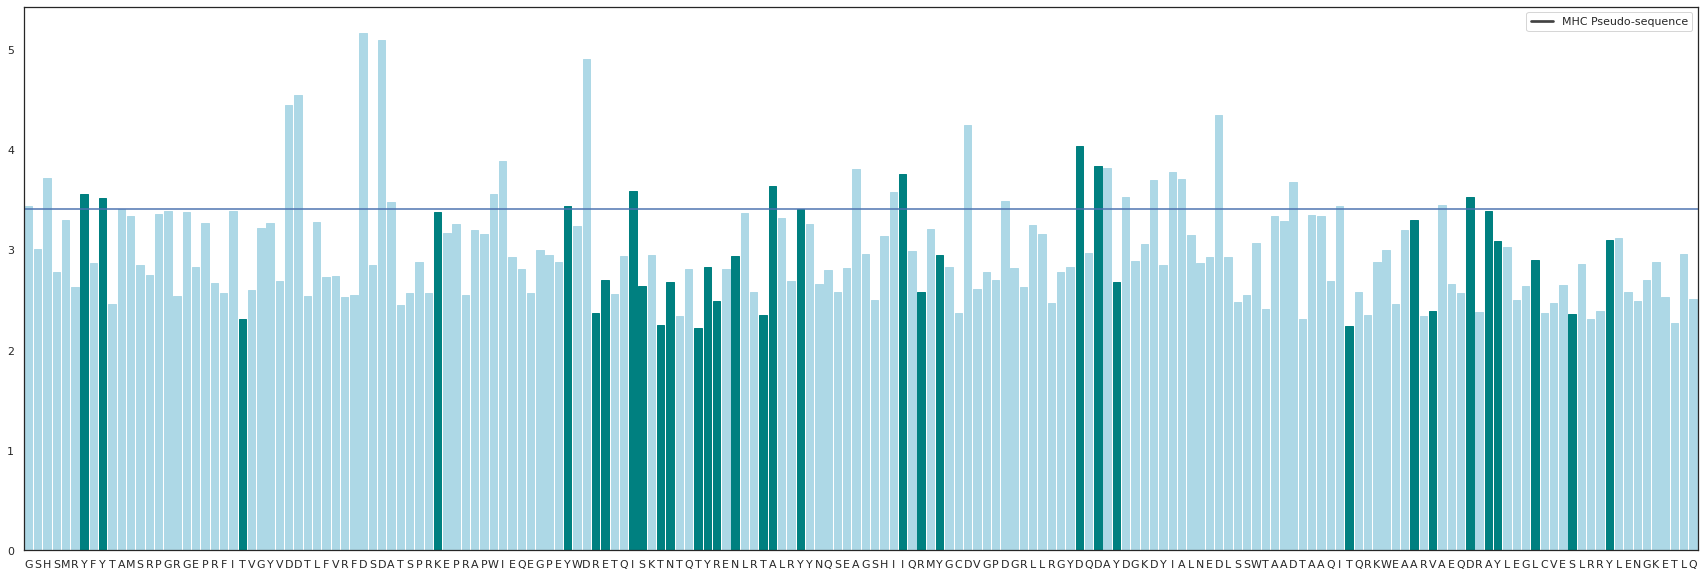



YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY

GHYYADDDDAWIYDIAYAIIDDDDADDIADDIAD
0.5026798598227169



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 13
HLA: HLA-A*32:15
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAHSQTDRESLRIALRYYNQSEAGSHTIQMMYGCDVGPDGRLLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.359434274526743


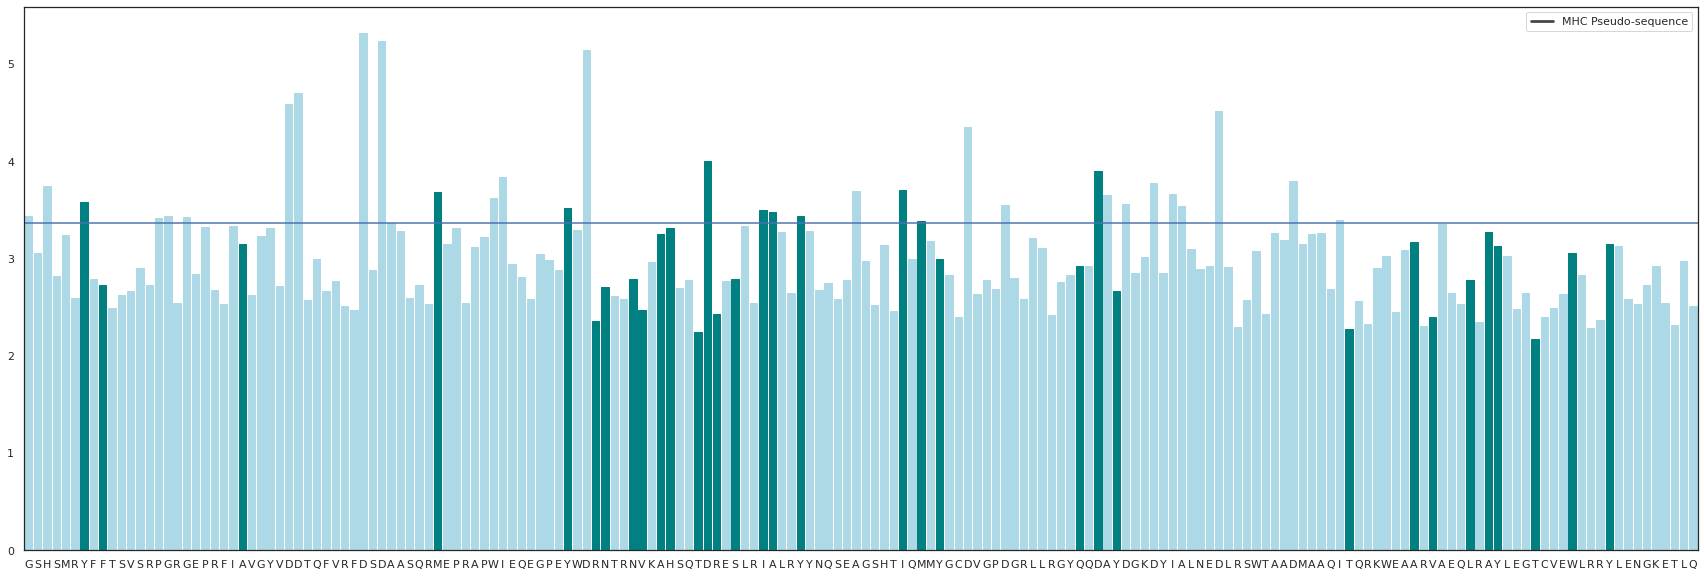



YFAMYRNNVAHTDESIAYIMYQDYTWAVLAYTWY

GHYPGGDDDDAMWIYDDIAYAIMDDDADDIADDI
0.5615337043908473



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 14
HLA: HLA-A*68:23
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQRMYGCDVGSDGRFLRGYRQDAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3728675842285156


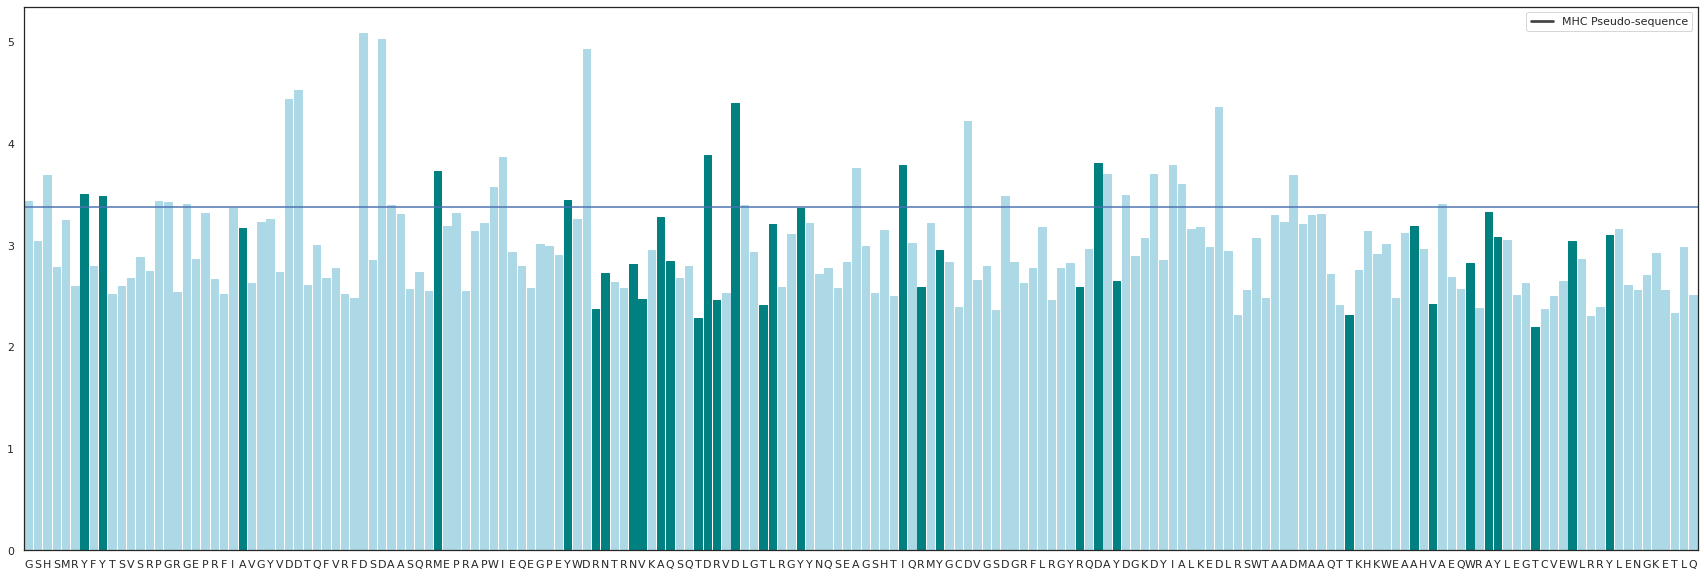



YYAMYRNNVAQTDVDTLYIRYRDYTWAVWAYTWY

GHYYPGGDDDDAMWIYDDDLYAIDDDADDIADDA
0.5212327355184498



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 10
HLA: HLA-A*26:03
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAHSQTHRVDLGTLRGYYNQSEDGSHTIQRMYGCDVGPDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWETAHEAEQWRAYLEGRCVEWLRRYLENGKETLQ
threshold: 3.3756038665771486


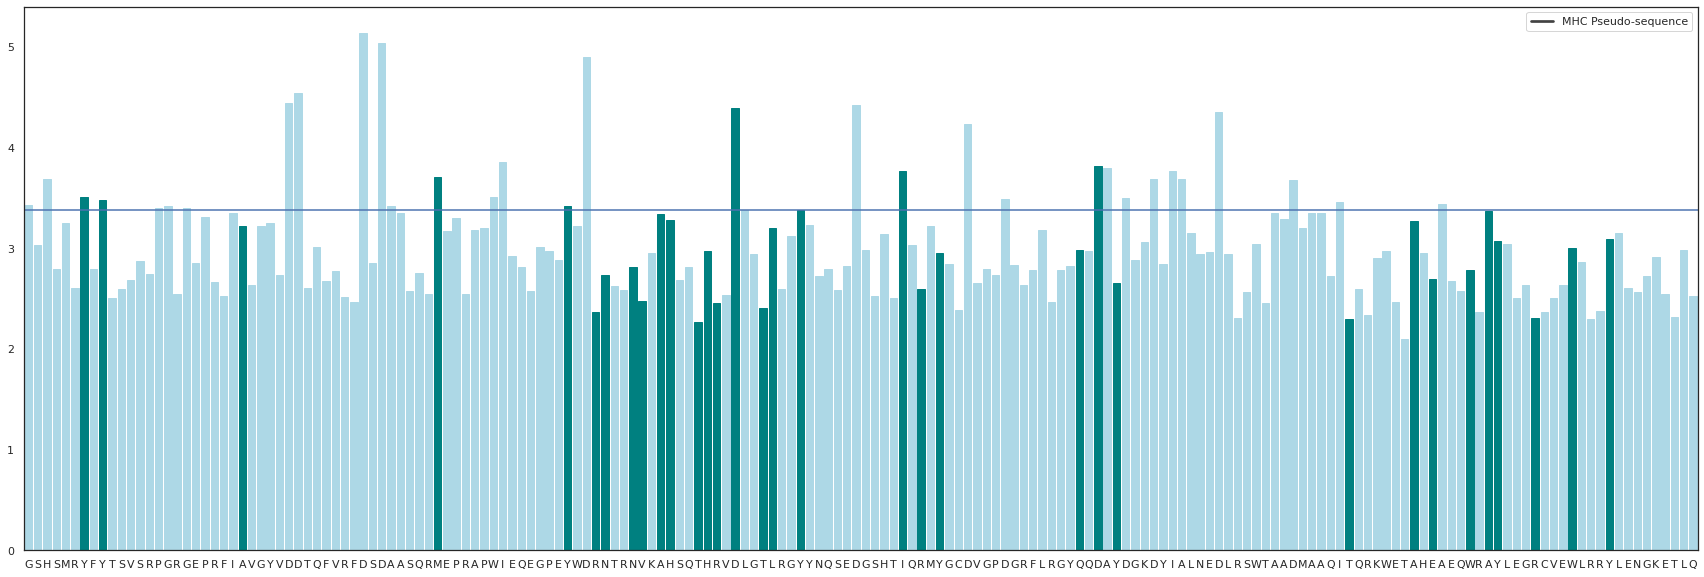



YYAMYRNNVAHTHVDTLYIRYQDYTWAEWAYRWY

GHYYPGGDDDDAMWIYDDLYDIDDDADDIADDIA
0.5429808286951144



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 14
HLA: HLA-A*32:07
GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAHSQTDRESLRIALRYYNQSEAGSHTIQMMYGCDVGPDGRLLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.369184766496931


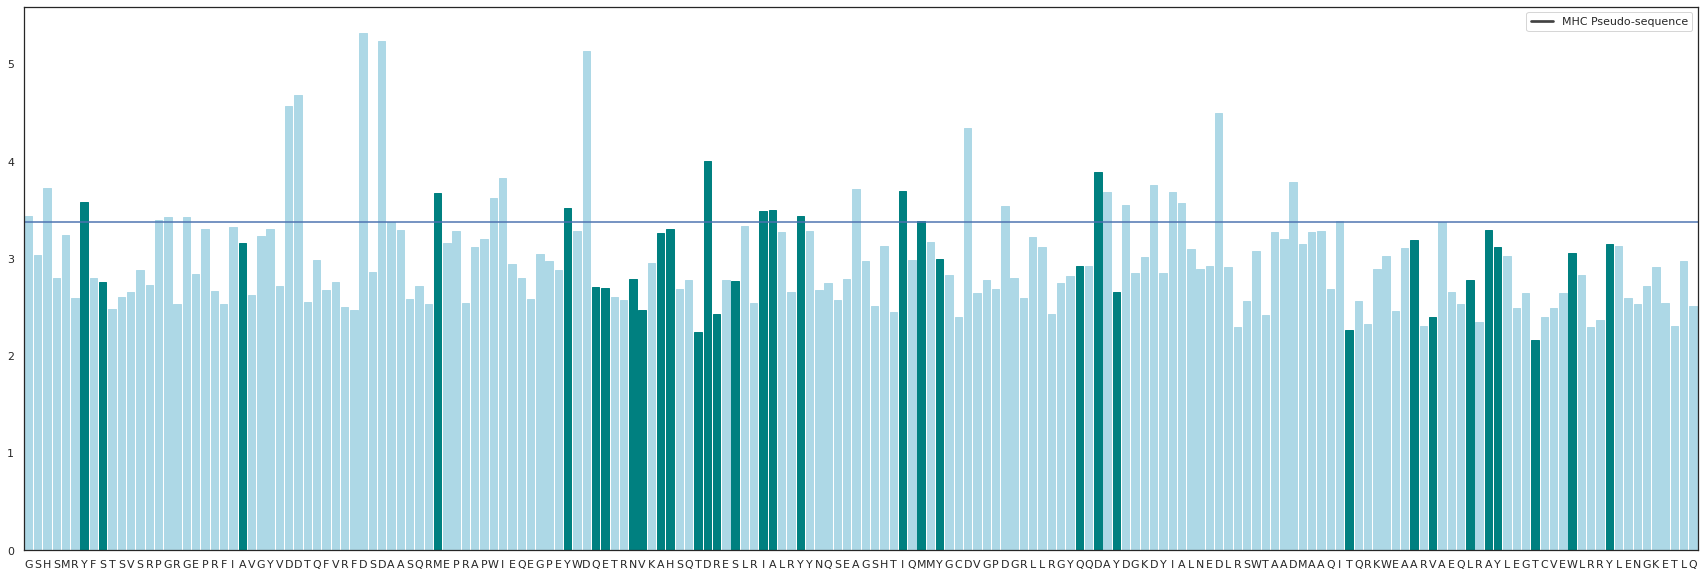



YSAMYQENVAHTDESIAYIMYQDYTWAVLAYTWY

GHYPGGDDDDMWIYDDIAYAIMDDDADDIADDIA
0.5713254998969284



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 10
HLA: HLA-A*02:50
GSHSMRYFFTSMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTIQRMYGCDVGPDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3199024200439453


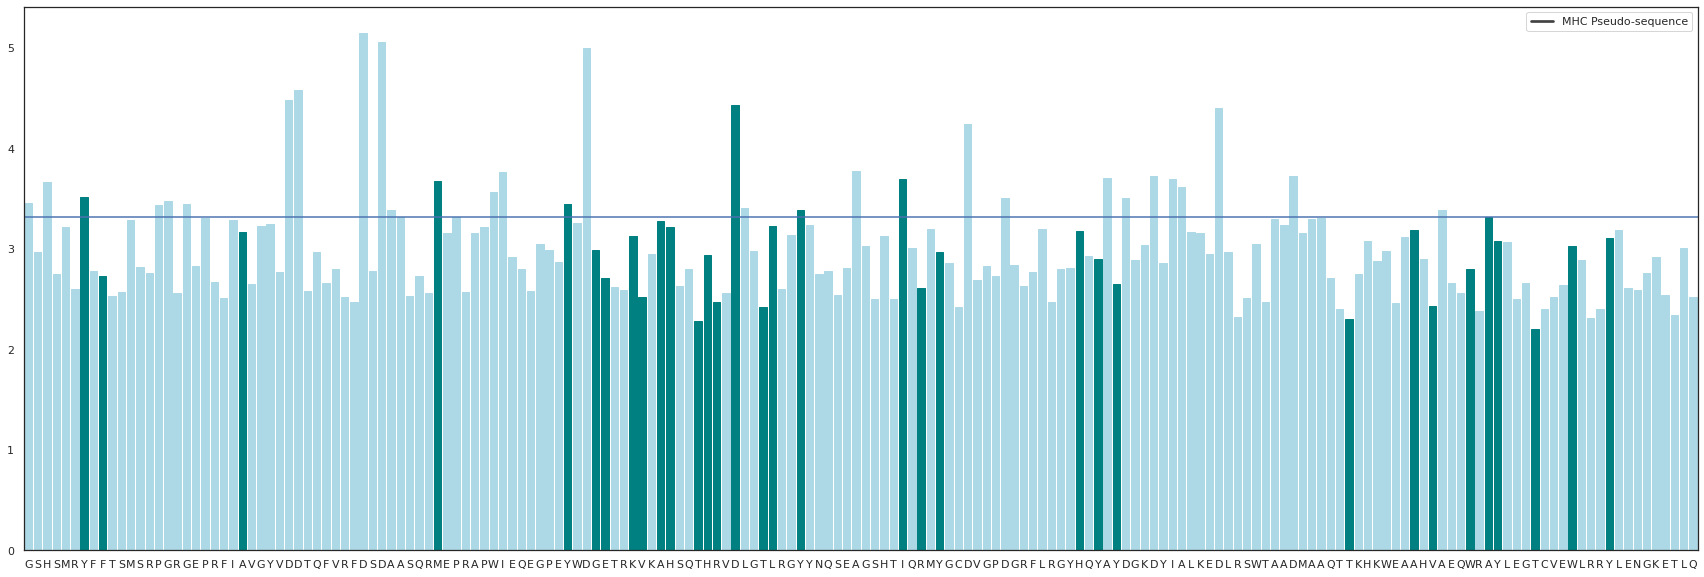



YFAMYGEKVAHTHVDTLYIRYHYYTWAVWAYTWY

GHYPGGDDDDAAMPWIYDDLYAIDDADDIADDAA
0.5243248814677386



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 15
HLA: HLA-B*27:20
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDRESLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.3872530619303385


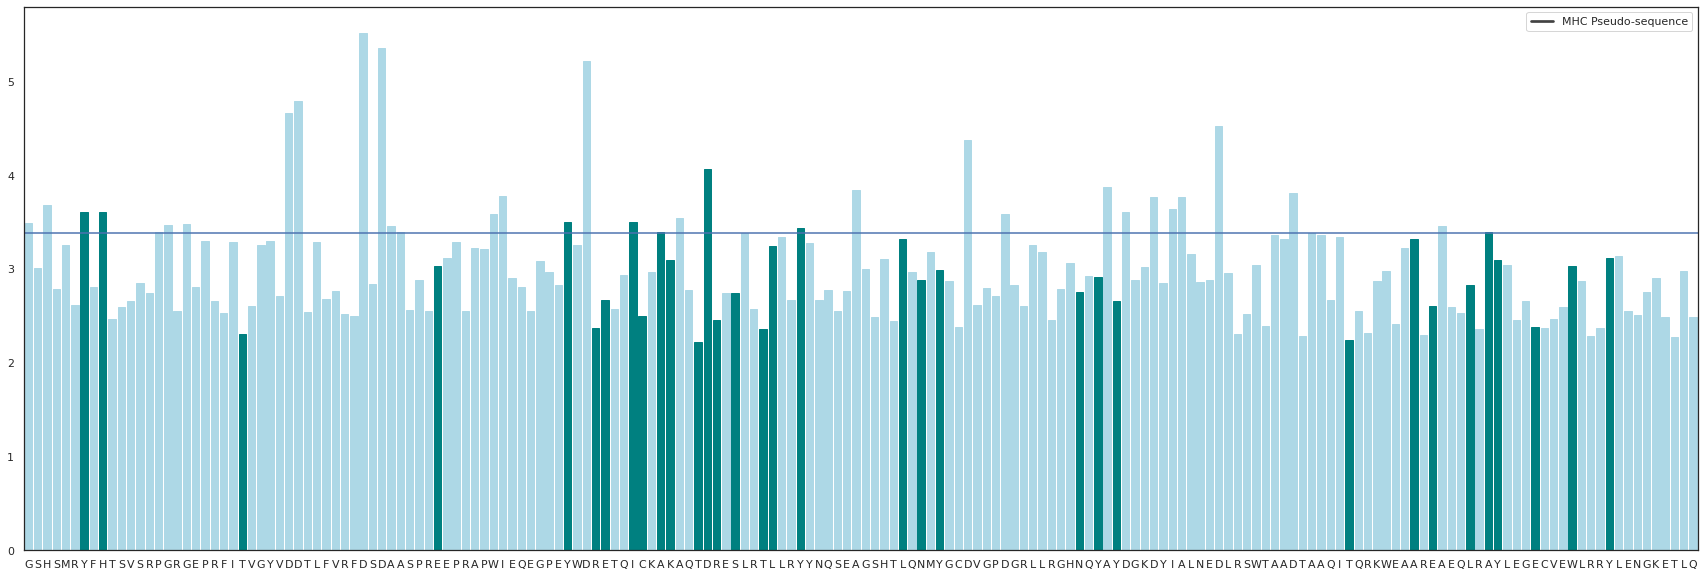



YHTEYREICAKTDESTLYLNYNYYTWAELAYEWY

GHYHPGGDDDDAAWIYDIAADYADDADDIADDAA
0.5041228612657184



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 15
HLA: HLA-A*66:01
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAQSQTDRVDLGTLRGYYNQSEDGSHTIQRMYGCDVGPDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWETAHEAEQWRAYLEGRCVEWLRRYLENGKETLQ
threshold: 3.3751675923665365


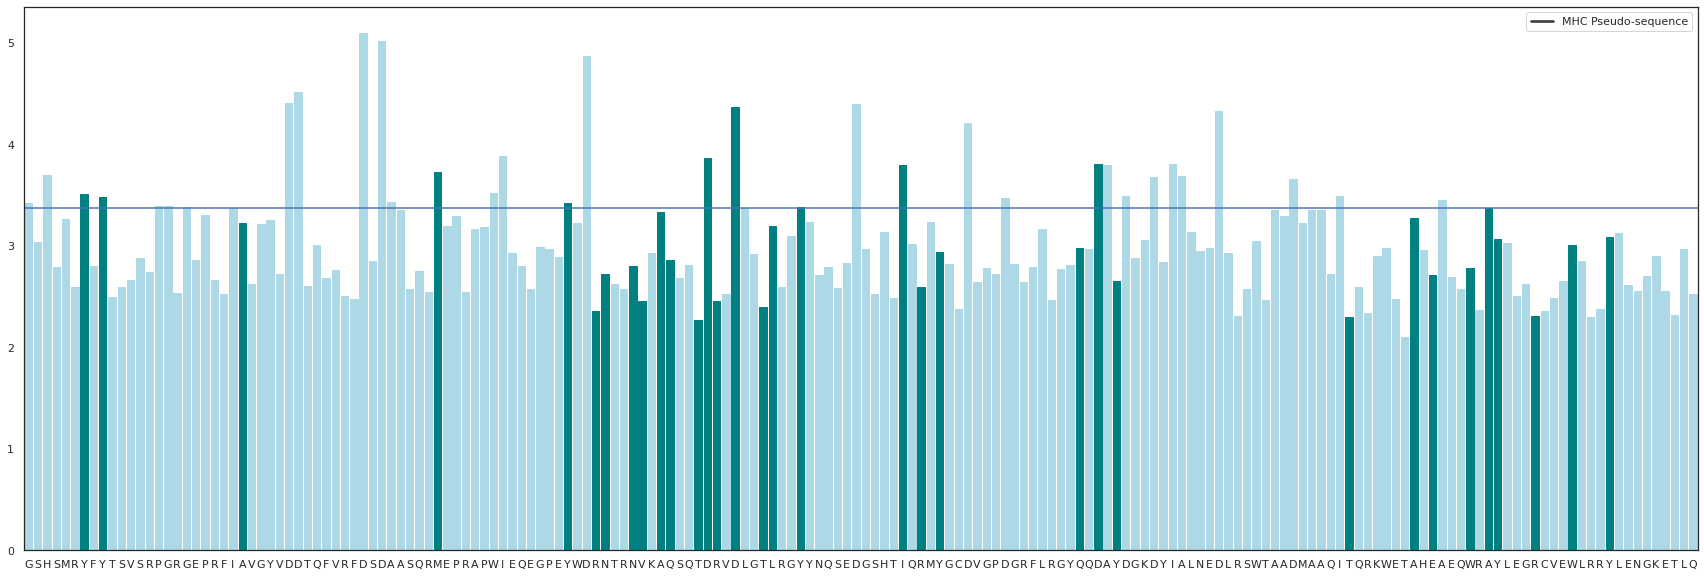



YYAMYRNNVAQTDVDTLYIRYQDYTWAEWAYRWY

GHYYPGGDDDDAMWIYDDDYDIDDDADDIADDIA
0.5444238301381158



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 15
HLA: HLA-B*14:01
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTDRESLRNLRGYYNQSEAGSHTLQWMYGCDVGPDGRLLRGYNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGTCVEWLRRHLENGKETLQ
threshold: 3.4125244140625


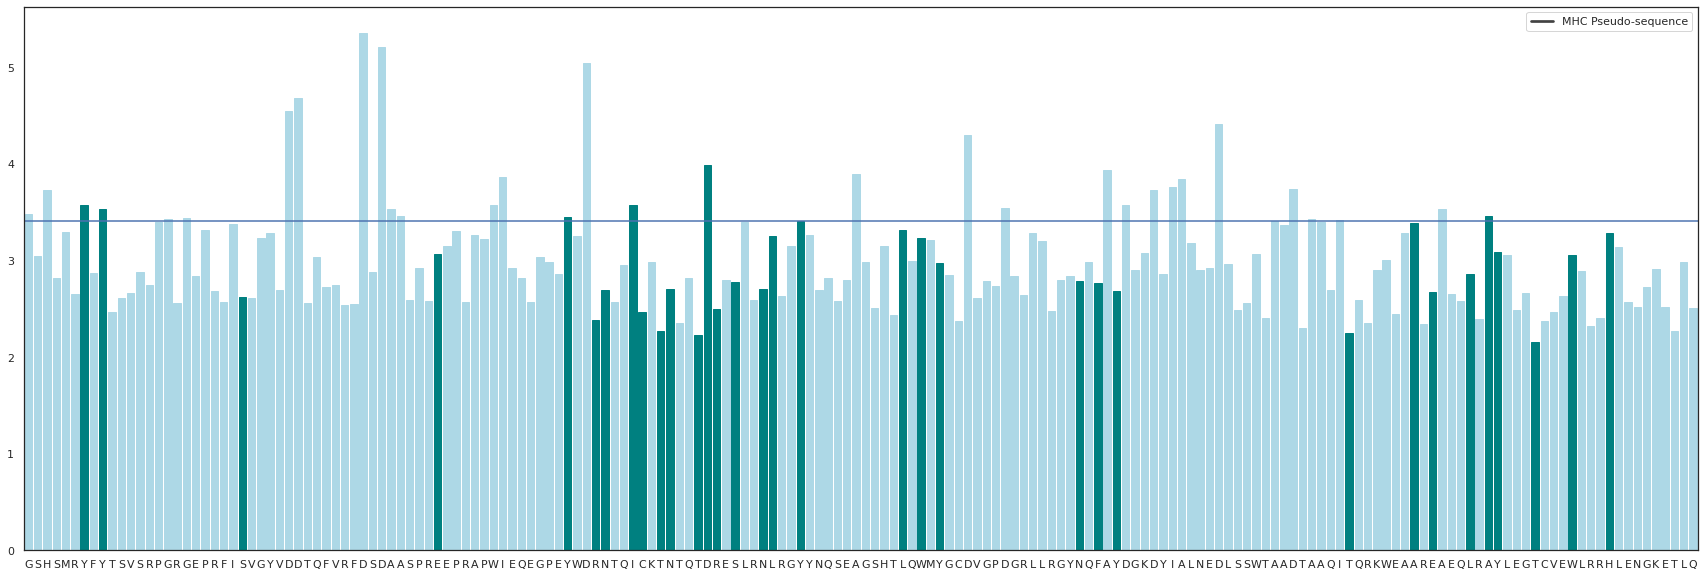



YYSEYRNICTNTDESNLYLWYNFYTWAELAYTWH

GHYYGGDDDDAAWIYDIDYADDADDIADADAIAA
0.4954648526077097



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 20
HLA: HLA-B*15:09
GSHSMRYFYTAMSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.3853973388671874


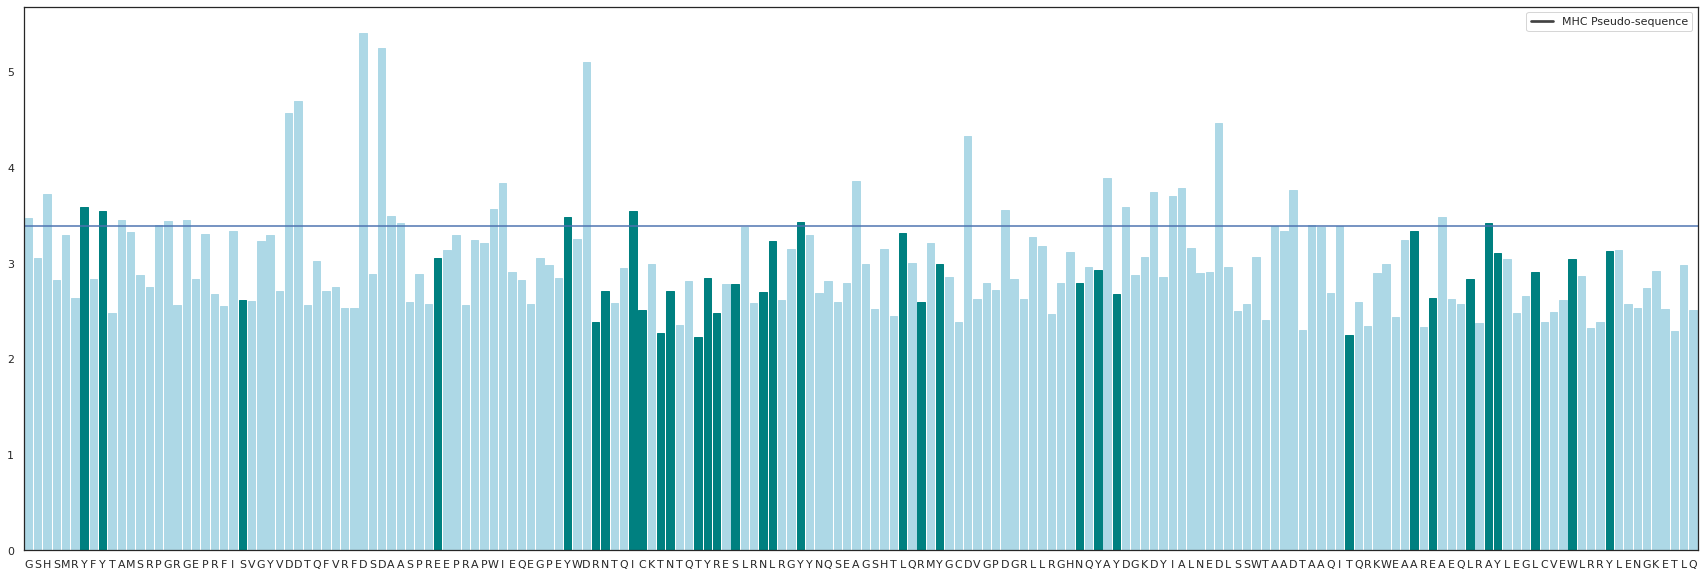



YYSEYRNICTNTYESNLYLRYNYYTWAELAYLWY

GHYYAPGGDDDDAAWIYDIYADDADDIADDAIAA
0.4758812615955474



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 23
HLA: HLA-B*48:01
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQISQRKLEAARVAEQLRAYLEGECVEWLRRYLENGKDKLE
threshold: 3.4114734815514605


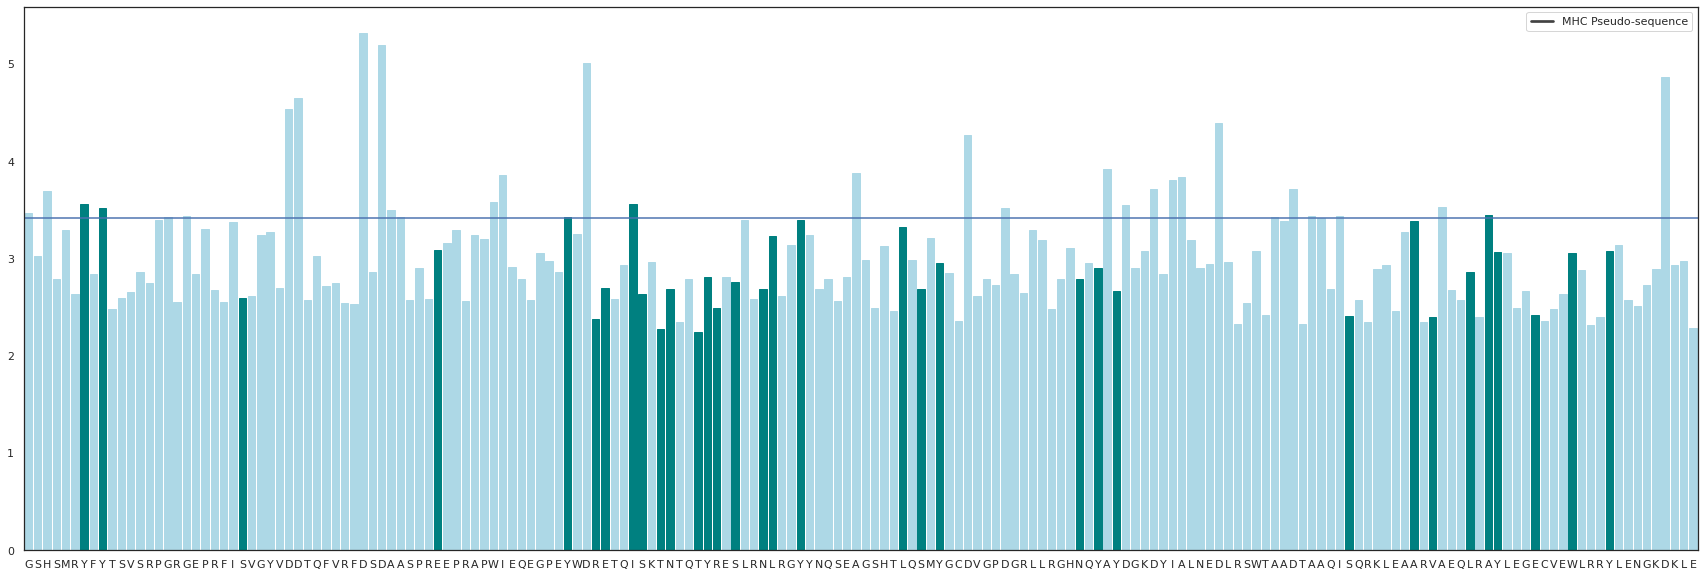



YYSEYREISTNTYESNLYLSYNYYSLAVLAYEWY

GHYYGGDDDDAAWIYDIADDADDIADADAAIAAD
0.46114203257060393



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 24
HLA: HLA-A*25:01
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAHSQTDRESLRIALRYYNQSEDGSHTIQRMYGCDVGPDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWETAHEAEQWRAYLEGRCVEWLRRYLENGKETLQ
threshold: 3.384044647216797


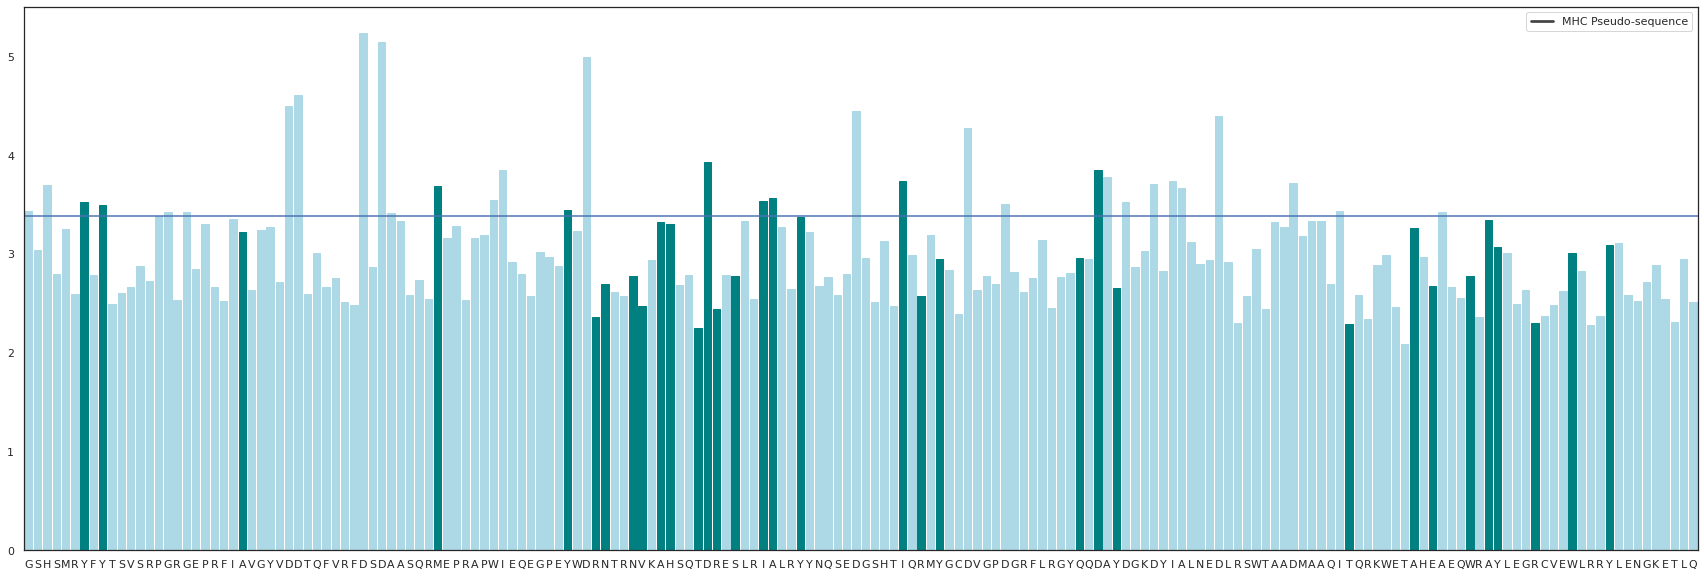



YYAMYRNNVAHTDESIAYIRYQDYTWAEWAYRWY

GHYYPGGDDDDAMWIYDDIADIDDDADDIADDIA
0.5664811379097093



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 16
HLA: HLA-A*24:13
GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITKRKWEAAHVAEQLRAYLEGTCVDGLRRYLENGKETLQ
threshold: 3.3555517196655273


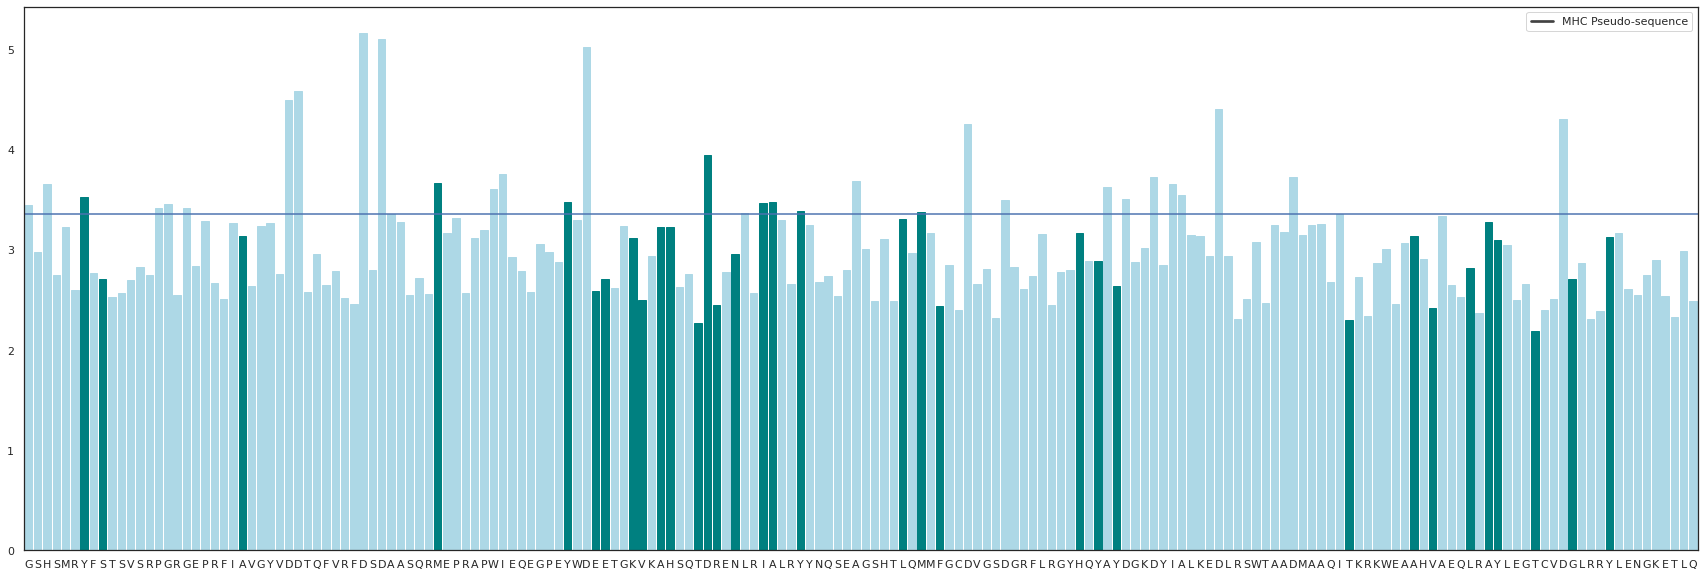



YSAMYEEKVAHTDENIAYLMFHYYTWAVLAYTGY

GHYPGGDDDDAMWIYDDLIAYAMDDADDIADDID
0.5279323850752422



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 30
HLA: HLA-A*80:01
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDSQFVQFDSDAASQRMEPRAPWIEQEEPEYWDEETRNVKAHSQTNRANLGTLRGYYNQSEDGSHTIQIMYGCDVGSDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAARRAEQLRAYLEGECVDGLRRYLENGKETLQ
threshold: 3.379283142089844


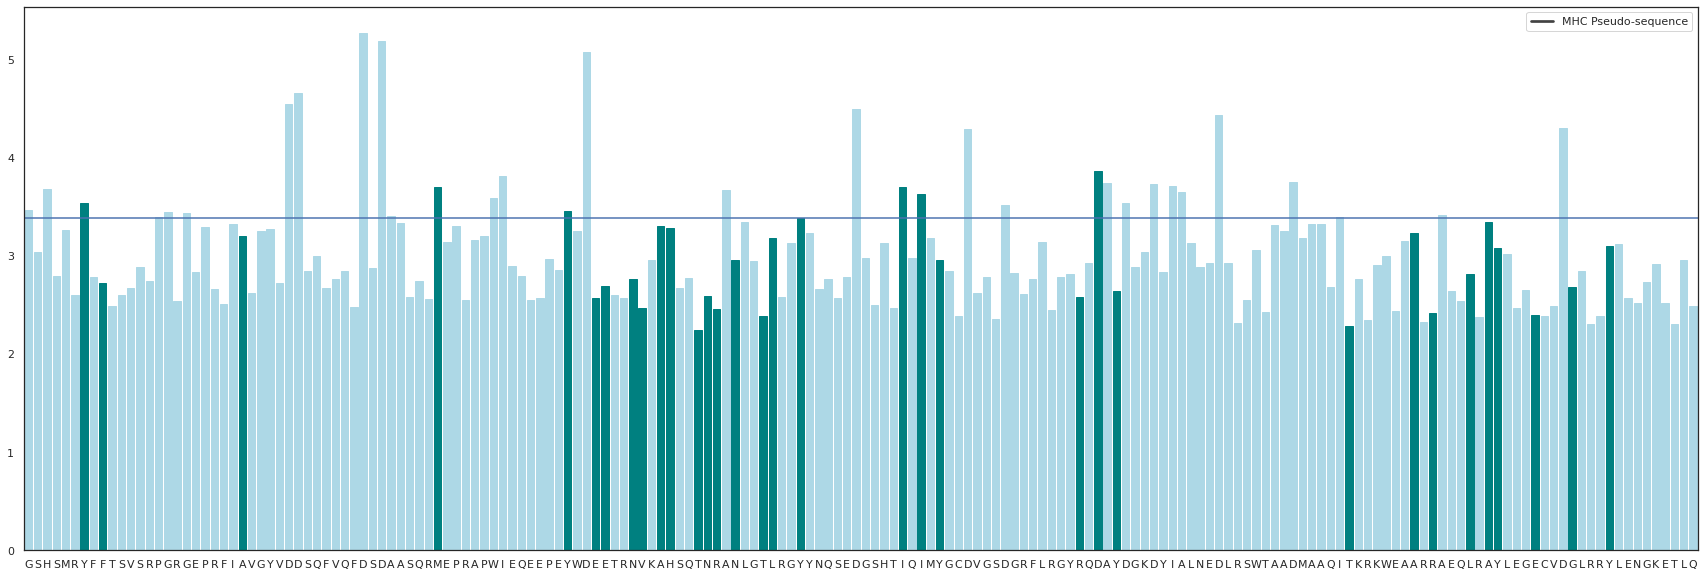



YFAMYEENVAHTNANTLYIIYRDYTWARLAYEGY

GHYPGGDDDDAMWIYDAYDIIDDDADDIADDIAD
0.4928880643166358



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 35
HLA: HLA-A*02:16
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.3331717354910713


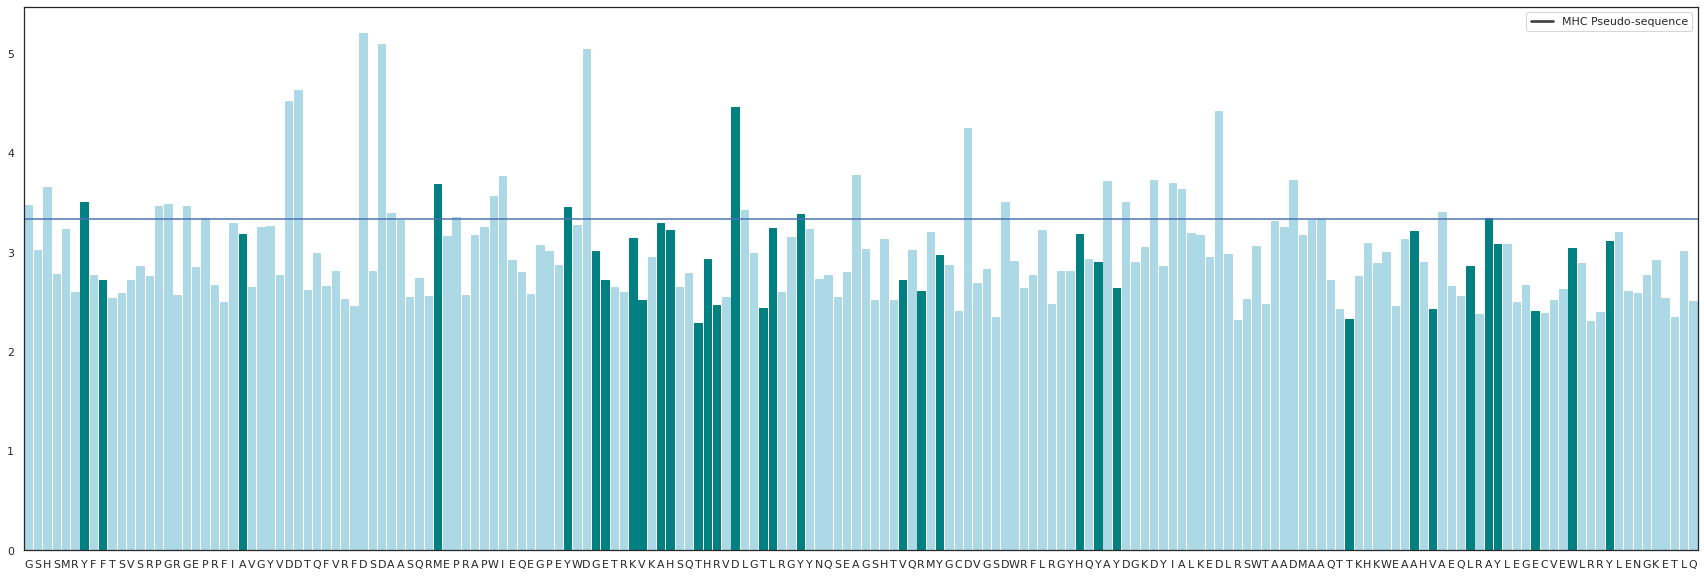



YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYEWY

GHYPGGPDDDDAMPWIYDDLYADDADDIADDAAA
0.5114409400123686



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 32
HLA: HLA-A*26:02
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAHSQTDRANLGTLRGYYNQSEDGSHTIQRMYGCDVGPDGRFLRGYQQNAYDGKDYIALNEDLRSWTAADMAAQITQRKWETAHEAEQWRAYLEGRCVEWLRRYLENGKETLQ
threshold: 3.3661322593688965


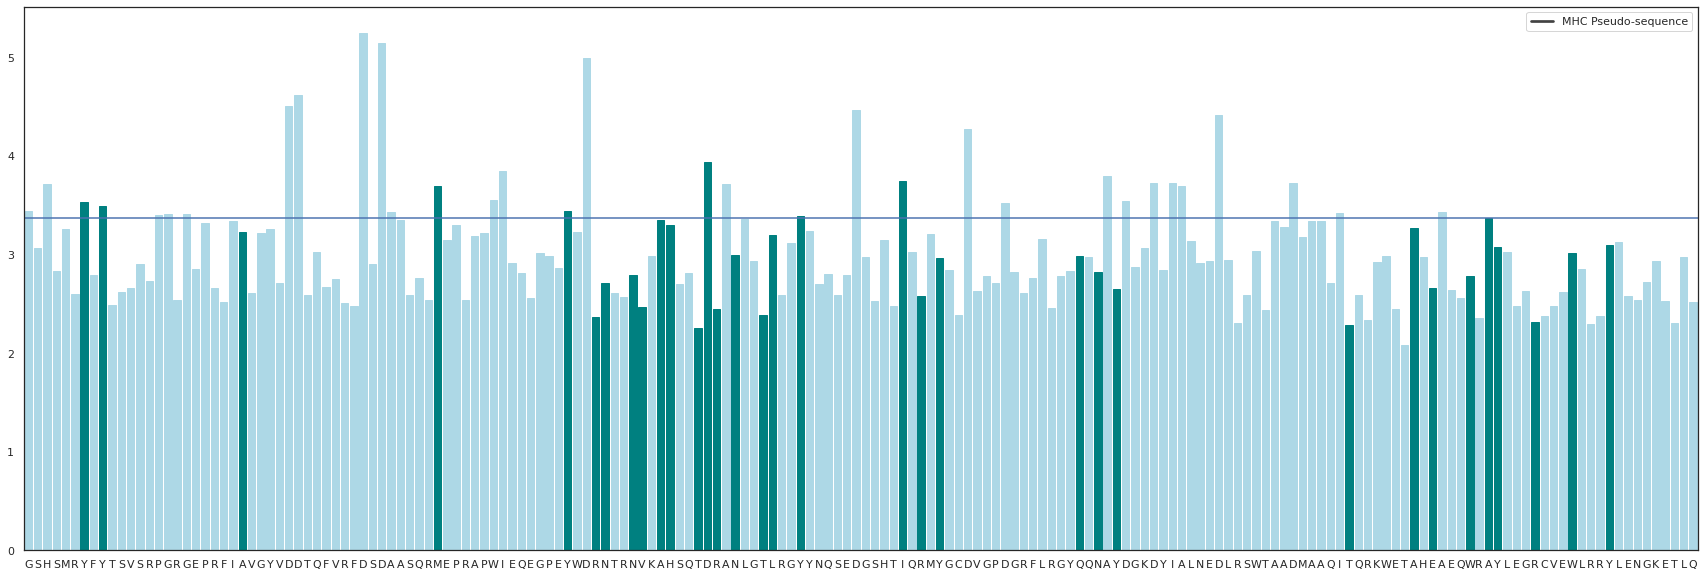



YYAMYRNNVAHTDANTLYIRYQNYTWAEWAYRWY

GHYYPGGDDDDAMWIYDDAYDIDDADDIADDIAA
0.523397237682952



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 37
HLA: HLA-A*02:19
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITKRKWEAAHVAEQQRAYLEGTCVDGLRRYLENGKETLQ
threshold: 3.322117161106419


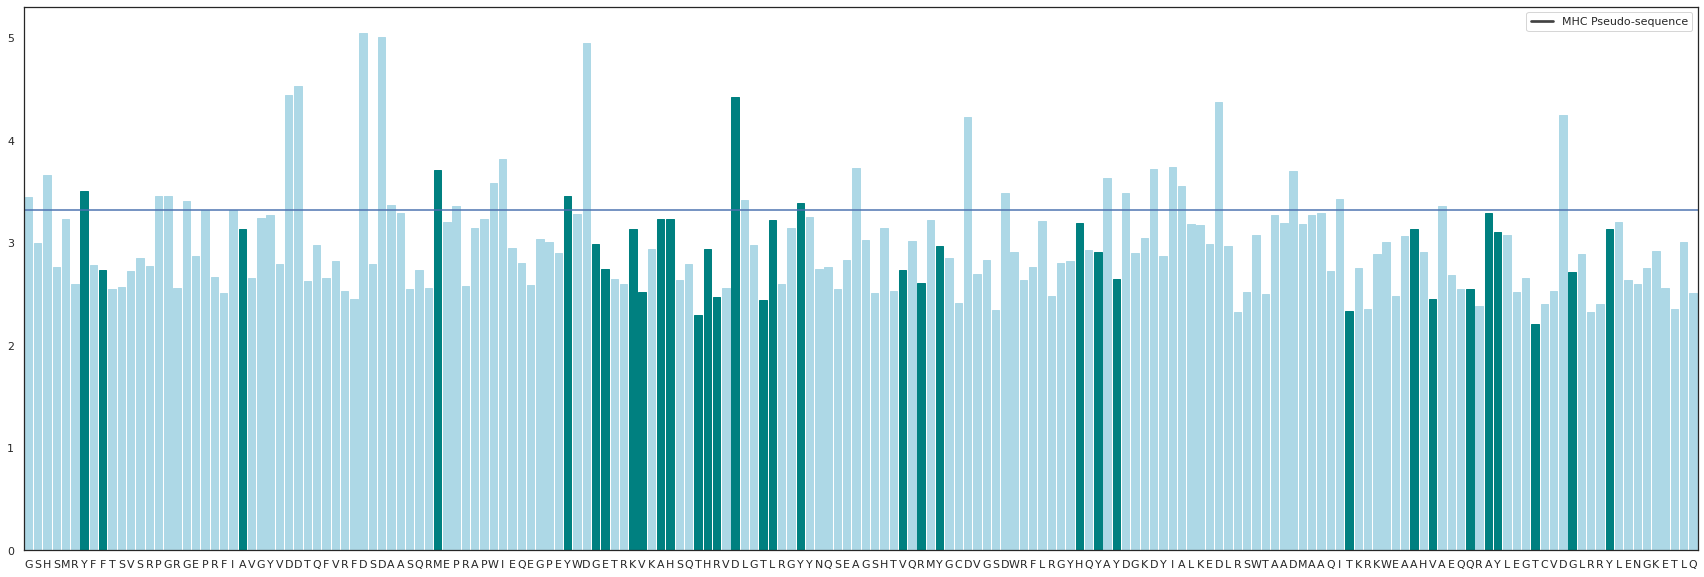



YFAMYGEKVAHTHVDTLYVRYHYYTWAVQAYTGY

GHYPGGPDDDDAMPWIYDDLYADDADDIADDIAD
0.4827870542156256



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 39
HLA: HLA-B*15:02
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDRNTQISKTNTQTYRESLRNLRGYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.392940423427484


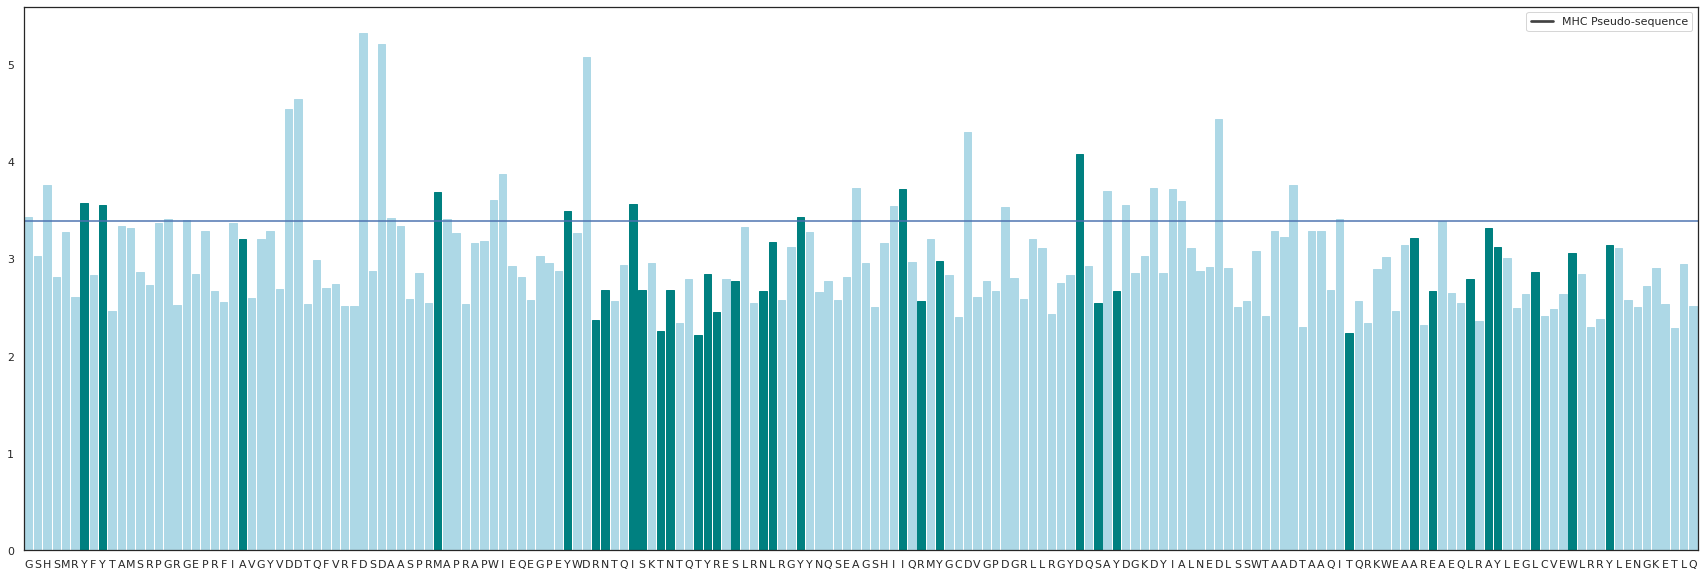



YYAMYRNISTNTYESNLYIRYDSYTWAELAYLWY

GHYYGGDDDDAMAWIYDIYAIIDDDADDIADDIA
0.5095856524427953



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 39
HLA: HLA-B*18:03
GSHSMRYFHTSVSRPGRGEPRFISVGYVDGTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQISKTNTQTDRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRHLENGKETLQ
threshold: 3.4118006779597354


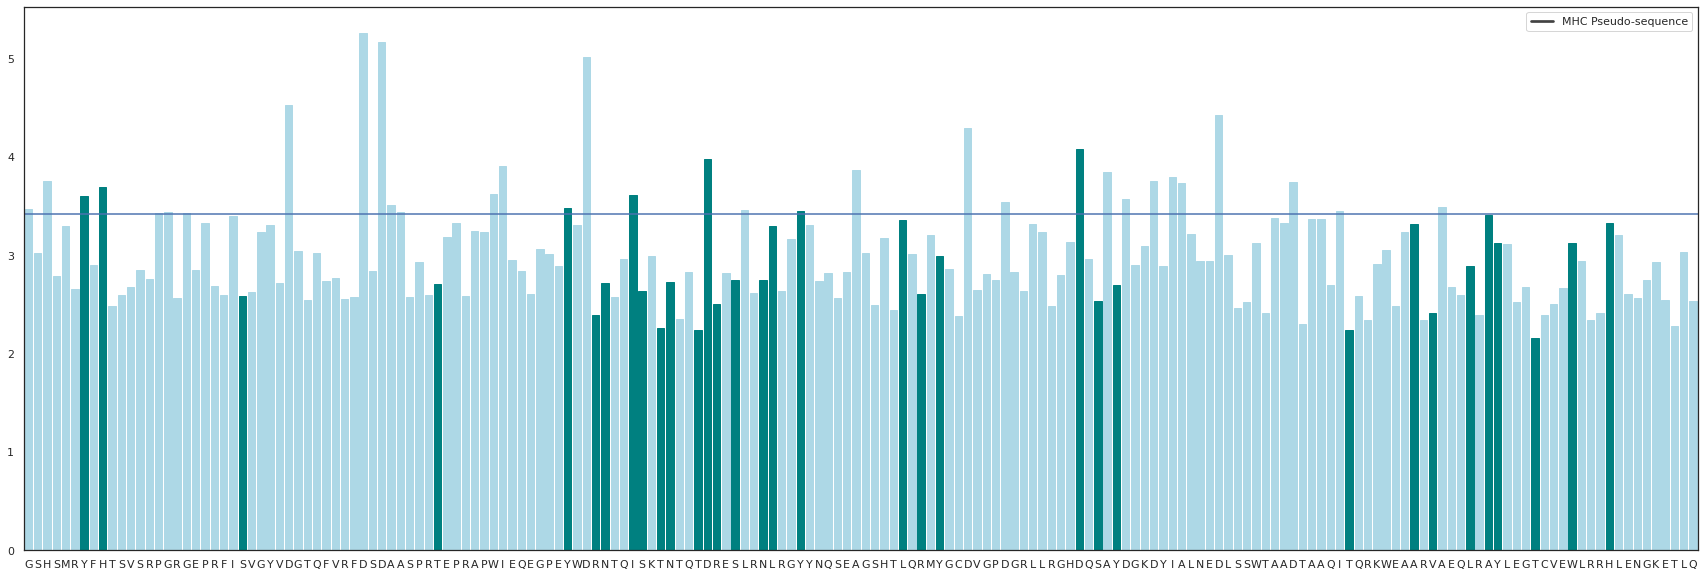



YHSTYRNISTNTDESNLYLRYDSYTWAVLAYTWH

GHYHPGGDDDAAWIYDIDLYADDDADDIADDIAA
0.4804164089878376



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 53
HLA: HLA-A*02:17
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTLQMMFGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.328114059736144


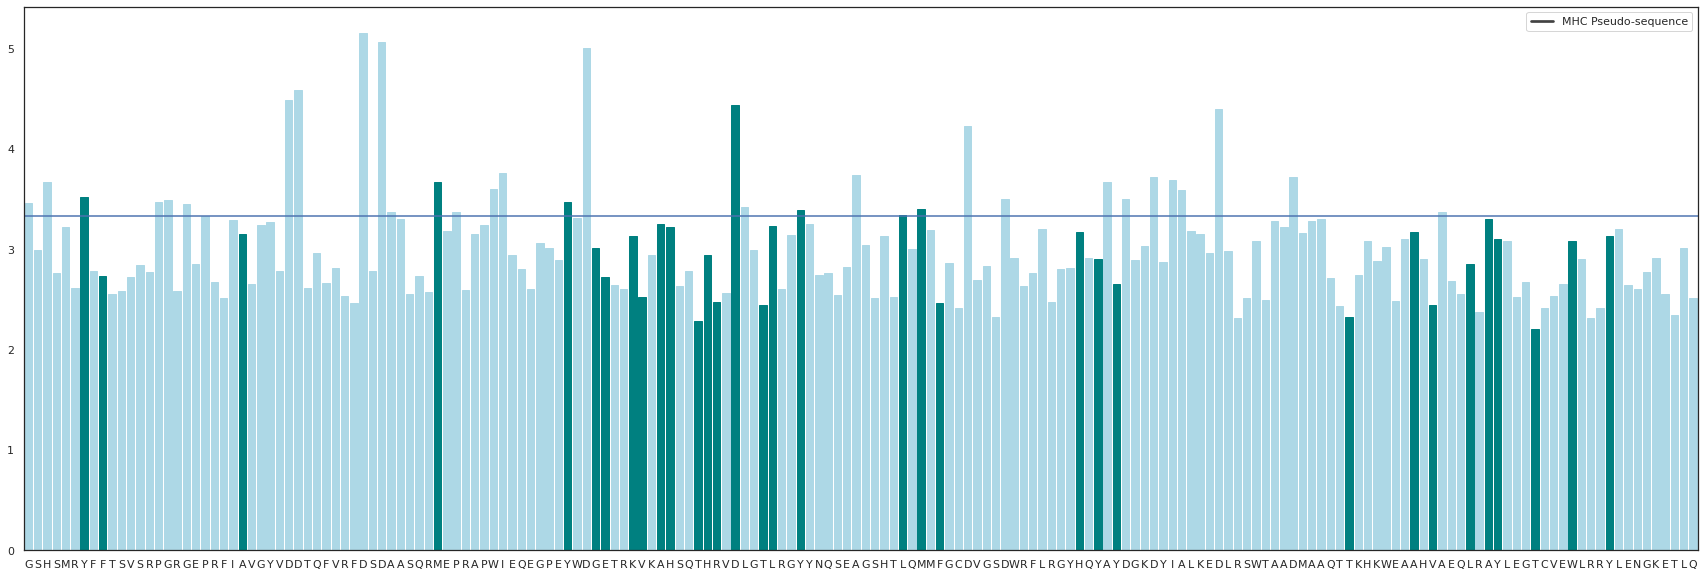



YFAMYGEKVAHTHVDTLYLMFHYYTWAVLAYTWY

GHYPGGPDDDDAMPWIYDDLYALMDDADDIADDA
0.5289631003916719



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 50
HLA: HLA-A*24:06
GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITKRKWEAAHVAEQWRAYLEGTCVDGLRRYLENGKETLQ
threshold: 3.3620223999023438


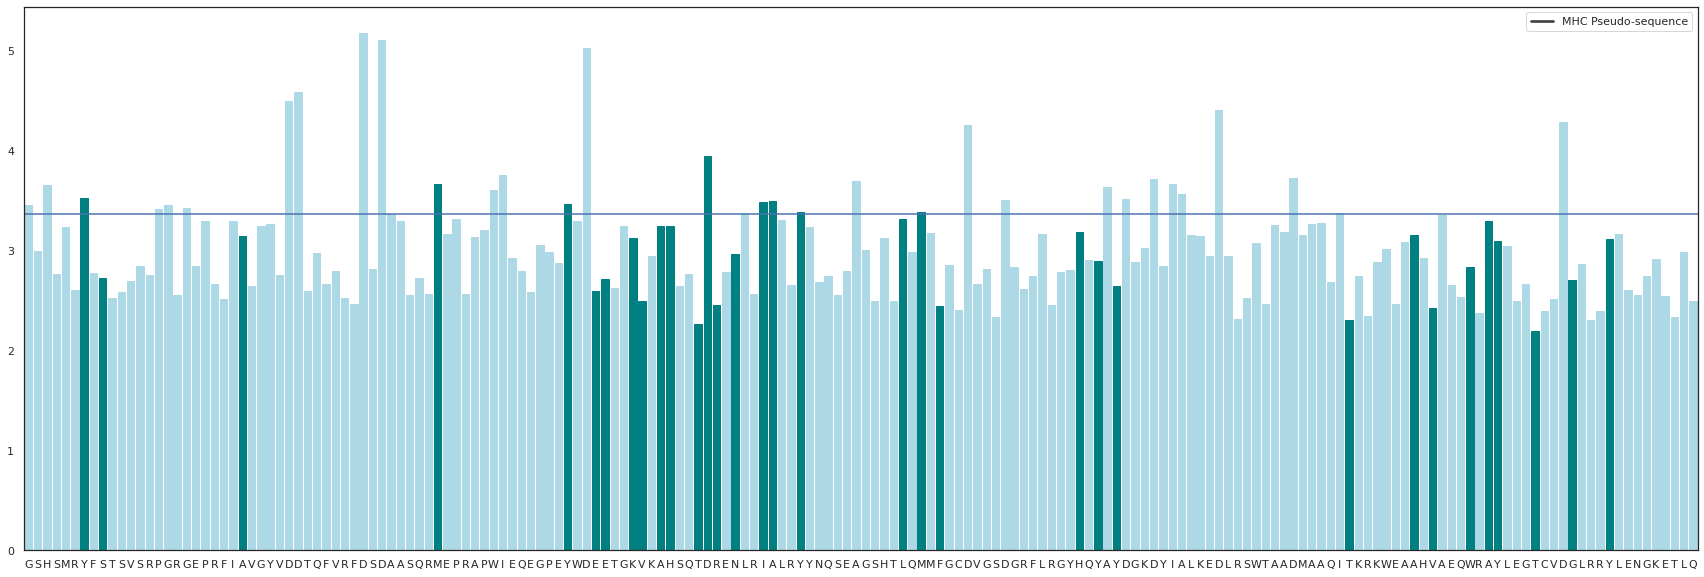



YSAMYEEKVAHTDENIAYLMFHYYTWAVWAYTGY

GHYPGGDDDDAMWIYDDLIAYAMDDADDIADDID
0.5287569573283859



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 50
HLA: HLA-B*83:01
GSHSMRYFYTAMSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVESLRRYLENGKETLQ
threshold: 3.375948486328125


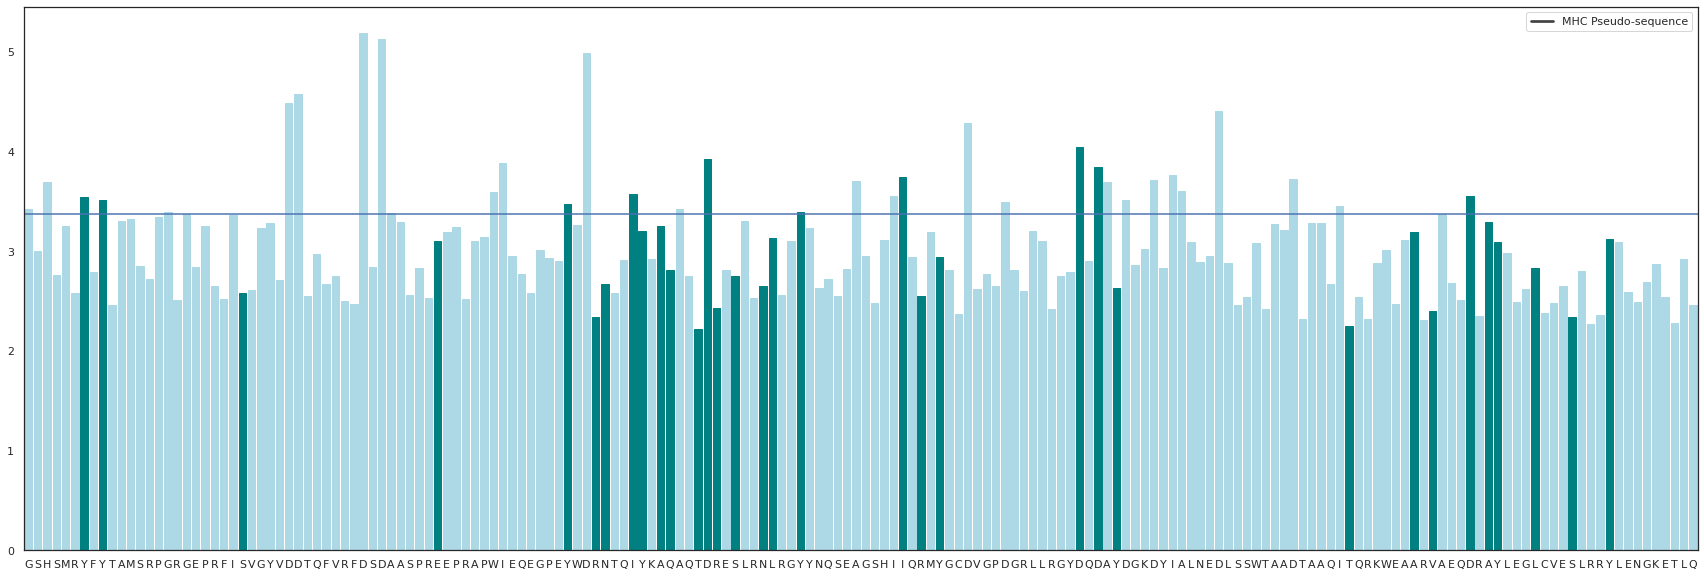



YYSEYRNIYAQTDESNLYIRYDDYTWAVDAYLSY

GHYYGDDDDAWIYDIADYAIIDDDDADDIADDID
0.5460729746444033



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 55
HLA: HLA-A*02:12
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQQRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3212241432883522


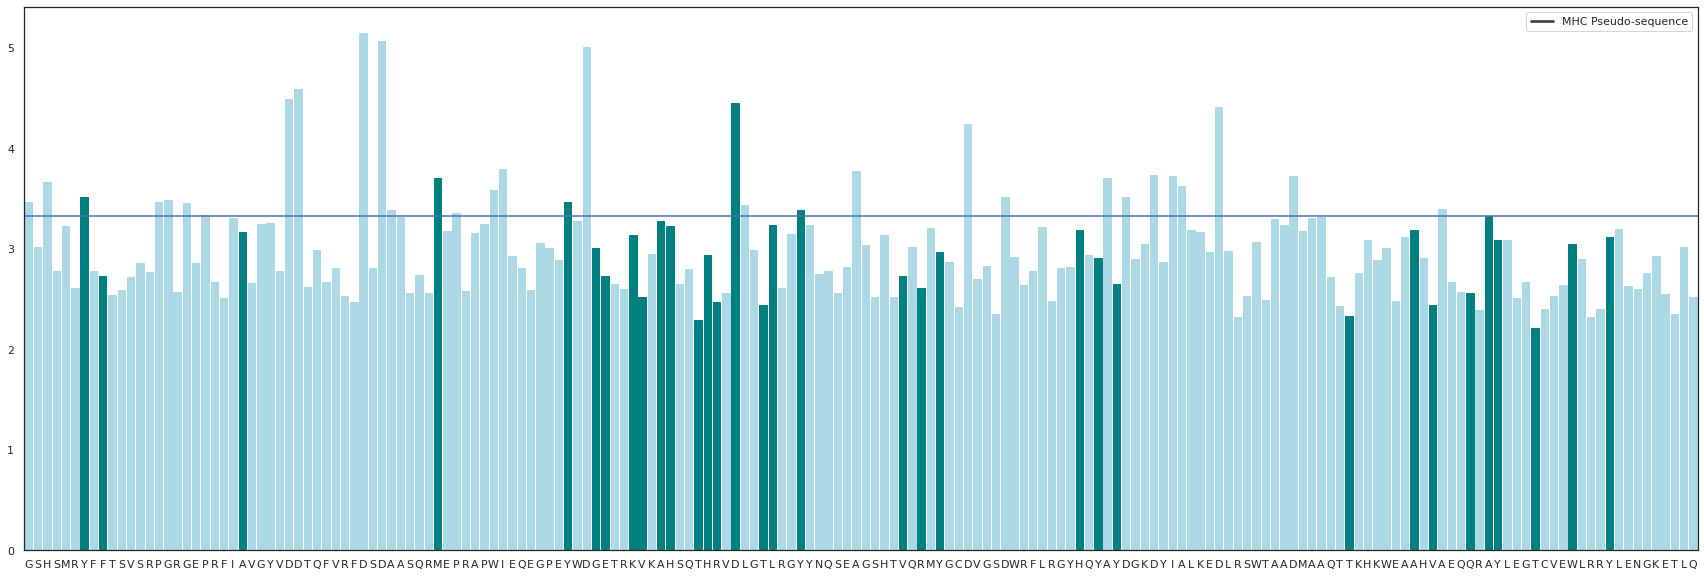



YFAMYGEKVAHTHVDTLYVRYHYYTWAVQAYTWY

GHYPGGPDDDDAAMPWIYDDLYADDADDIADDAA
0.5004122861265718



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 50
HLA: HLA-B*45:06
GSHSMRYFHTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQIYKAQAQTDRESLRNLRGYYNQSEAGSHTWQRMYGCDLGPDGRLLRGYNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVESLRRYLENGKETLQ
threshold: 3.3766207885742188


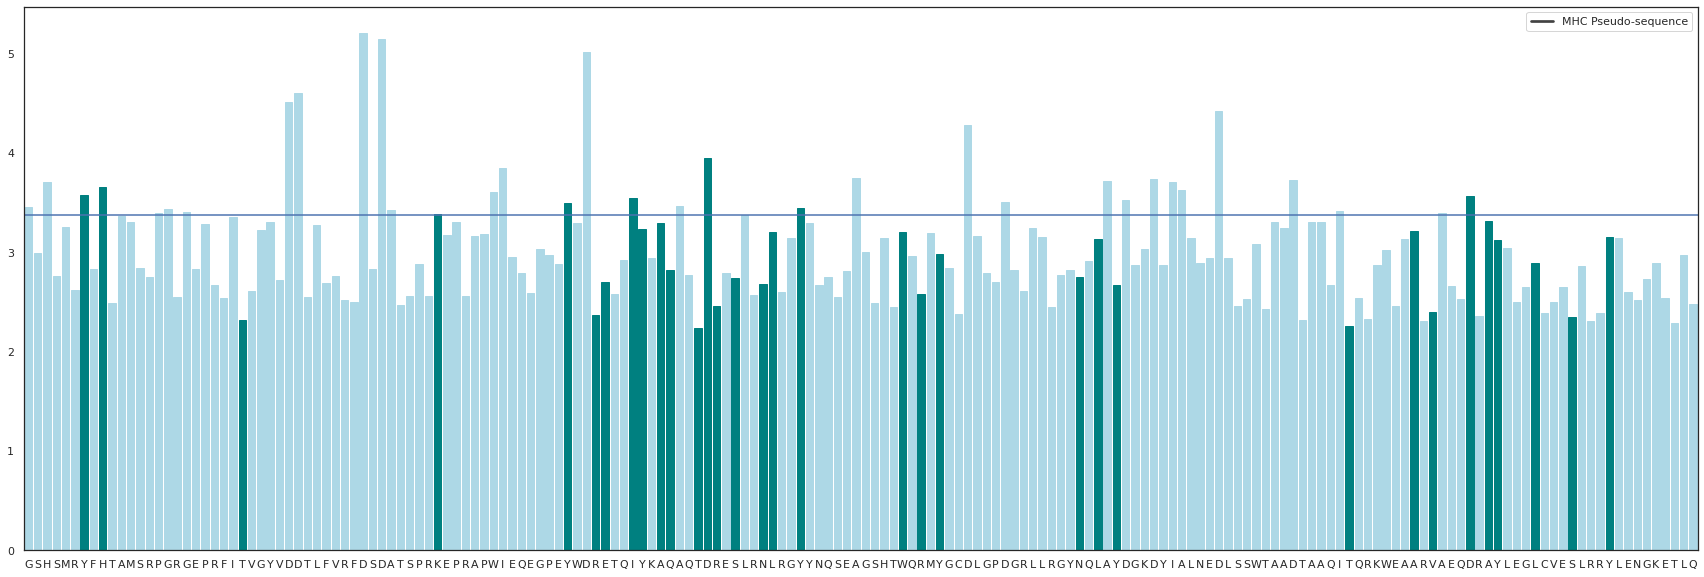



YHTKYREIYAQTDESNLYWRYNLYTWAVDAYLSY

GHYHPGGDDDDAKWIYDIADYADDADDIADDIAD
0.5194805194805194



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 48
HLA: HLA-B*15:42
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTWQTMYGCDLGPDGRLLRGHNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3734410603841147


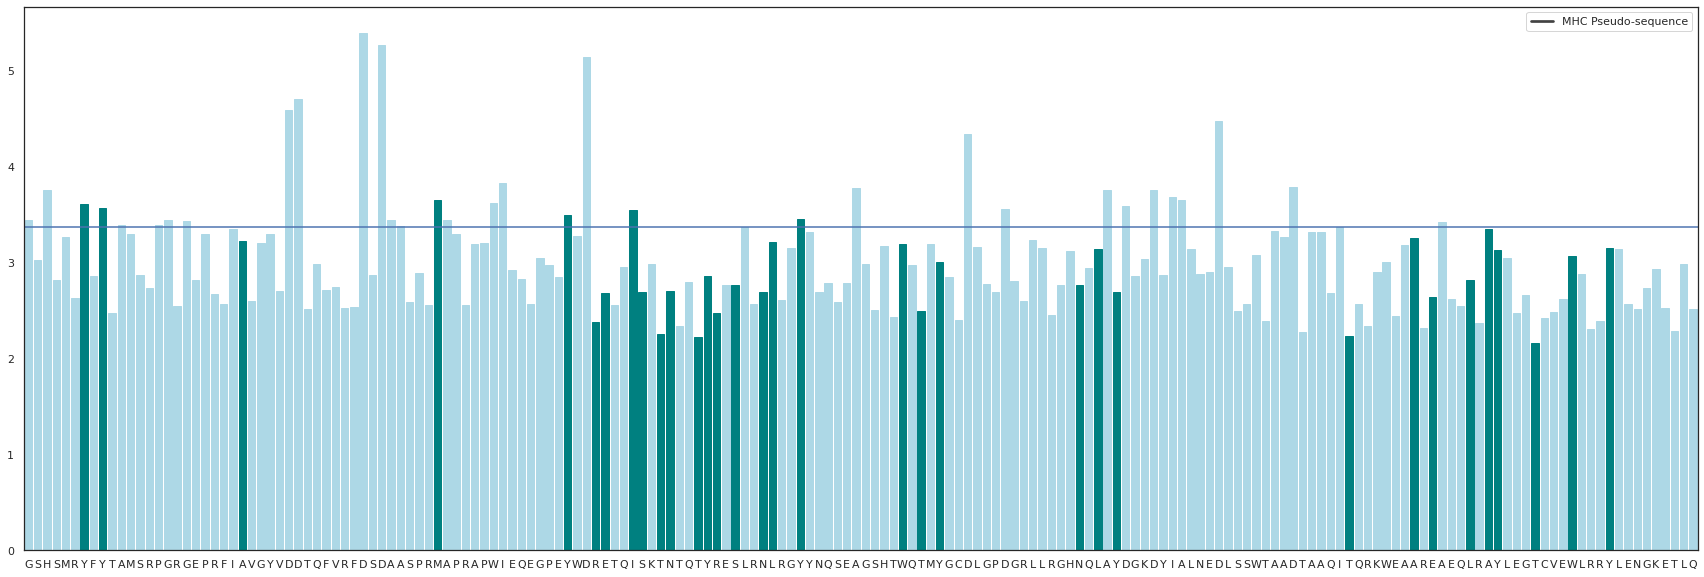



YYAMYREISTNTYESNLYWTYNLYTWAELAYTWY

GHYYAPGGDDDDAAMAWIYDILYADDADDIADDA
0.48299319727891155



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 57
HLA: HLA-A*24:03
GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITKRKWEAAHVAEQQRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.340699312979715


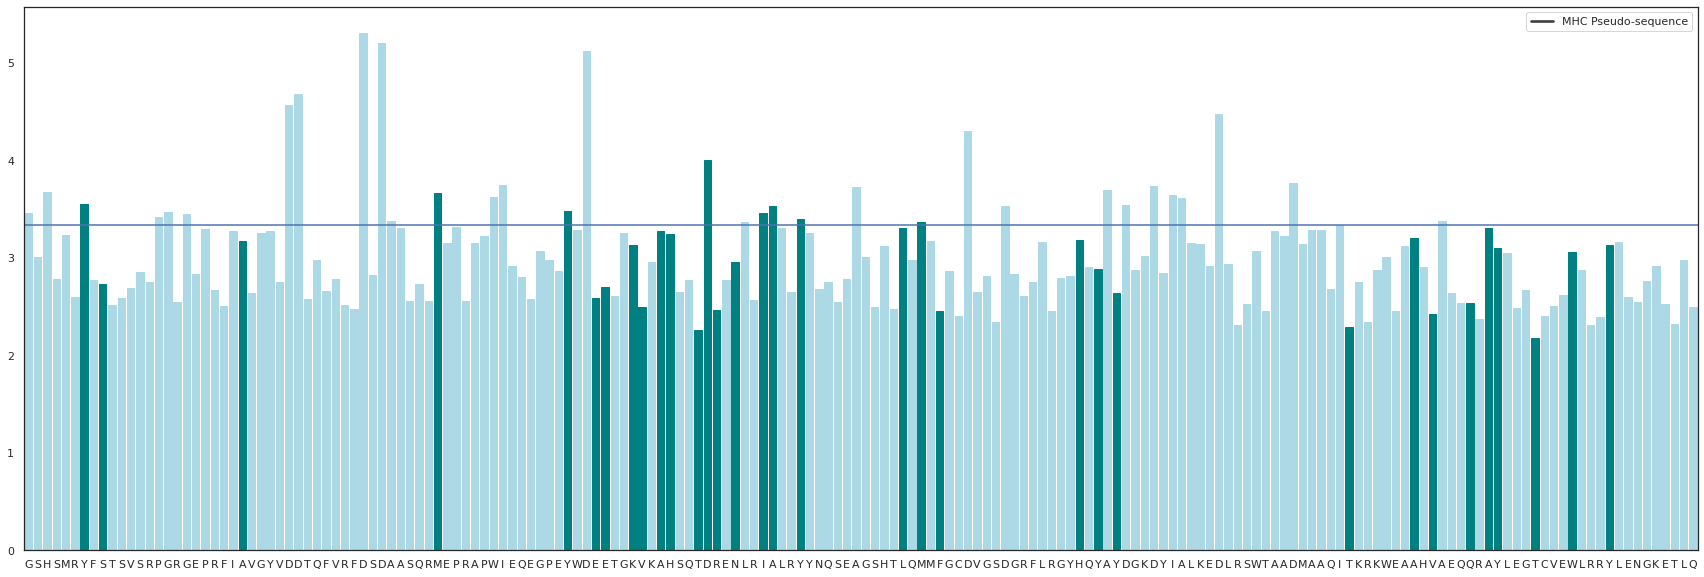



YSAMYEEKVAHTDENIAYLMFHYYTWAVQAYTWY

GHYPGGDDDDAMWIYDDLIAYAMDDADDIADDIA
0.5359719645433931



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 65
HLA: HLA-B*15:03
GSHSMRYFYTAMSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.393261953500601


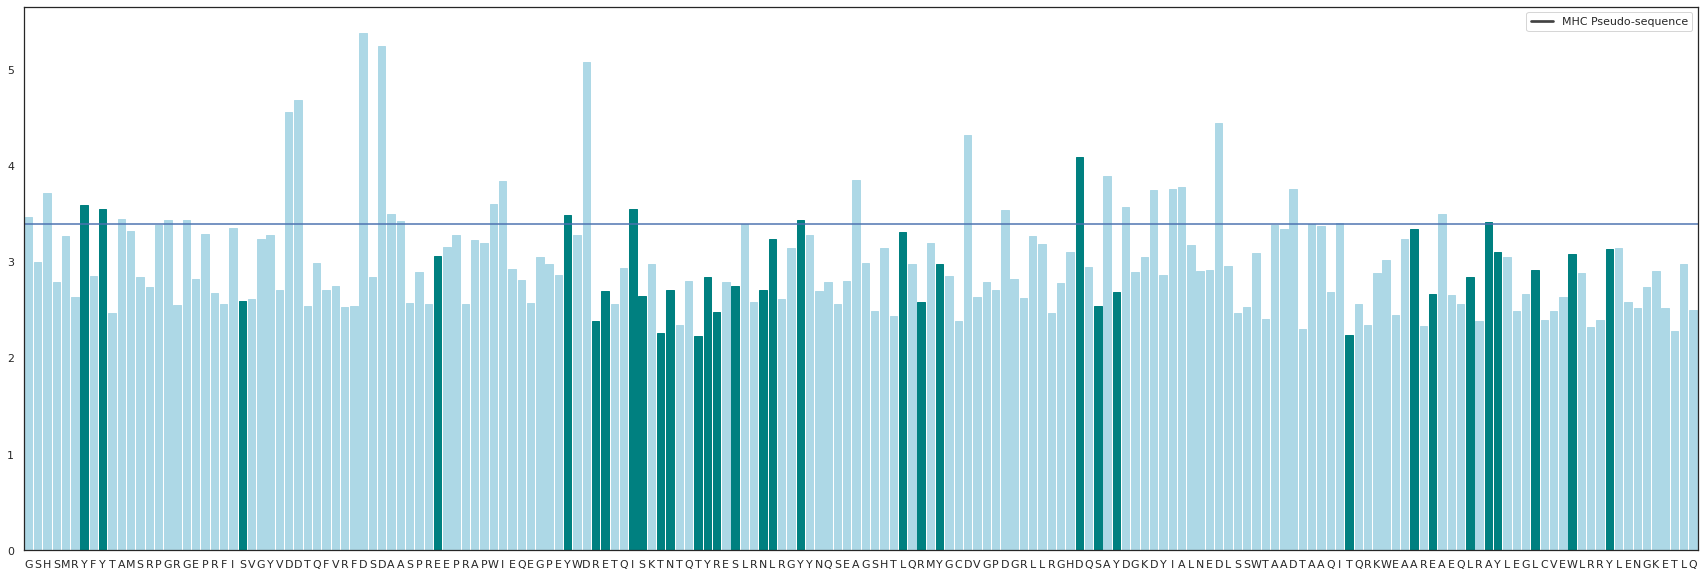



YYSEYREISTNTYESNLYLRYDSYTWAELAYLWY

GHYYAGGDDDDAAWIYDIYADDDADDIADDAIAA
0.48804370232941663



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 71
HLA: HLA-A*02:11
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQIDRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.322594441158671


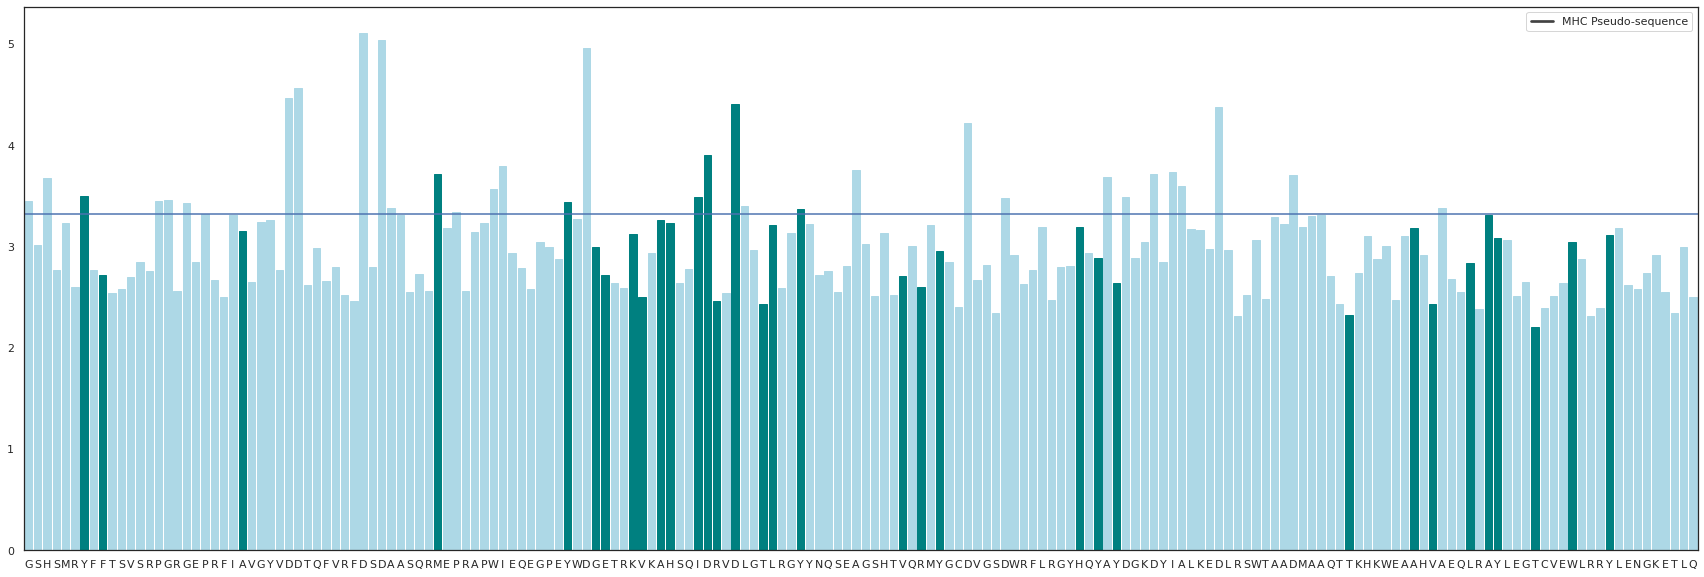



YFAMYGEKVAHIDVDTLYVRYHYYTWAVLAYTWY

GHYPGGPDDDDAMPWIYDIDDLYADDADDIADDA
0.5475159760874047



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 79
HLA: HLA-B*15:17
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDRETRNMKASAQTYRENLRIALRYYNQSEAGSHTLQRMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.3296852594689477


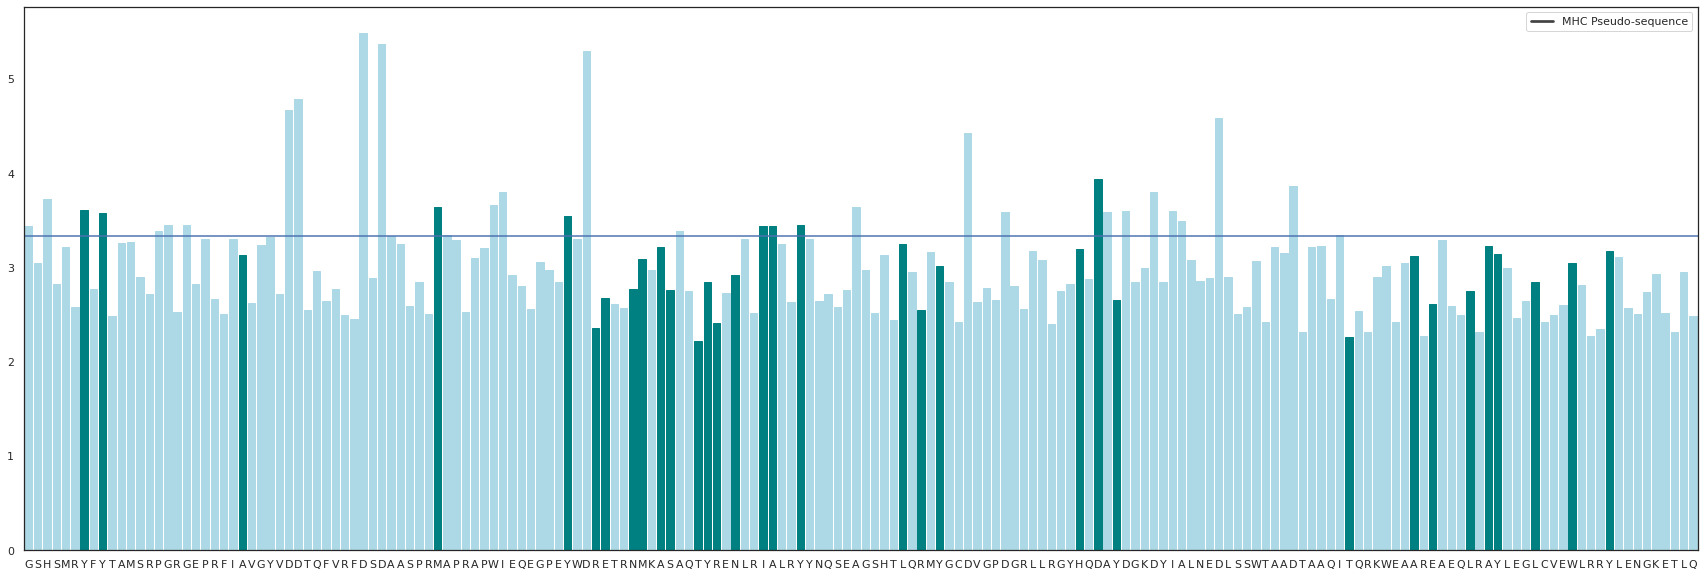



YYAMYRENMASTYENIAYLRYHDYTWAELAYLWY

GHYYPGGDDDDAMAWIYDAIAYADDDADDIADDI
0.5646258503401361



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 87
HLA: HLA-B*73:01
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKAKAQTDRVGLRNLRGYYNQSEDGSHTWQTMYGCDMGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRHLENGKETLQ
threshold: 3.3801108173940375


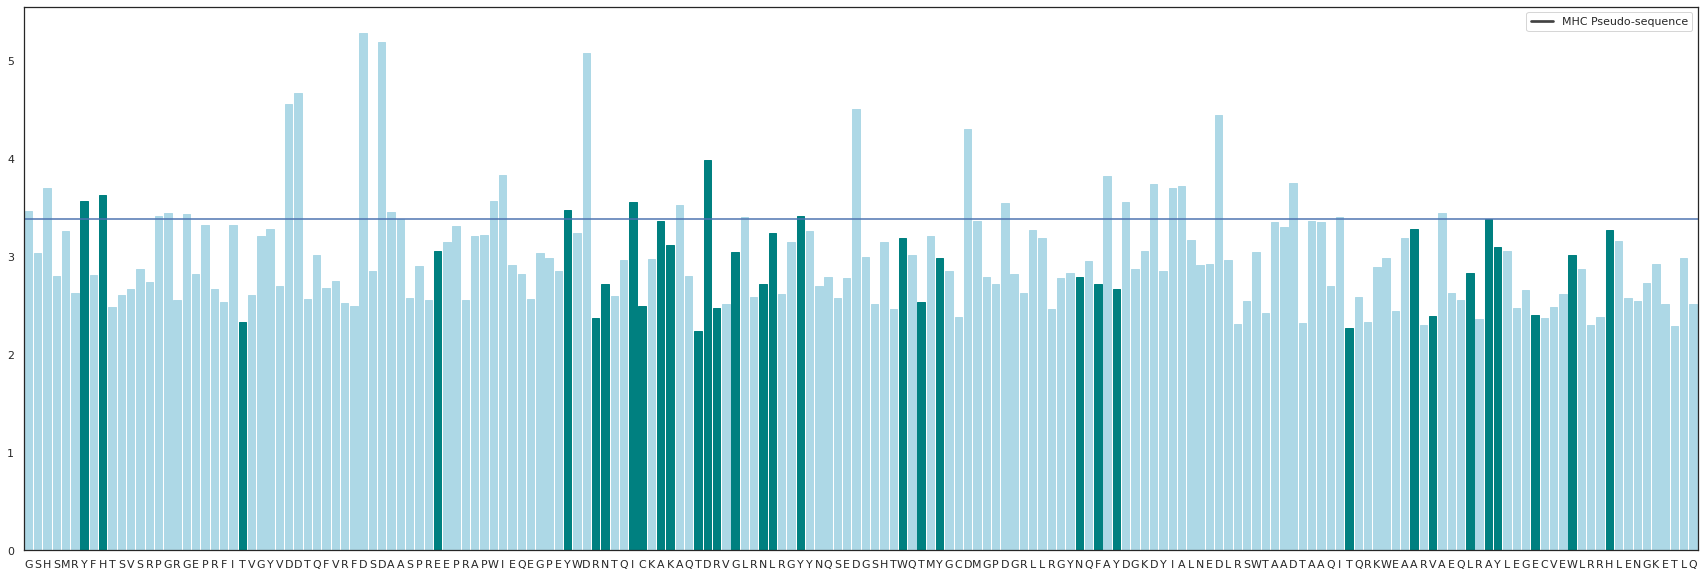



YHTEYRNICAKTDVGNLYWTYNFYTWAVLAYEWH

GHYHPGGDDDDAAWIYDIADLYDDDADDIADDIA
0.49835085549371266



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 83
HLA: HLA-B*52:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRIALRYYNQSEAGSHTWQTMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRHLENGKETLQ
threshold: 3.3730545963149474


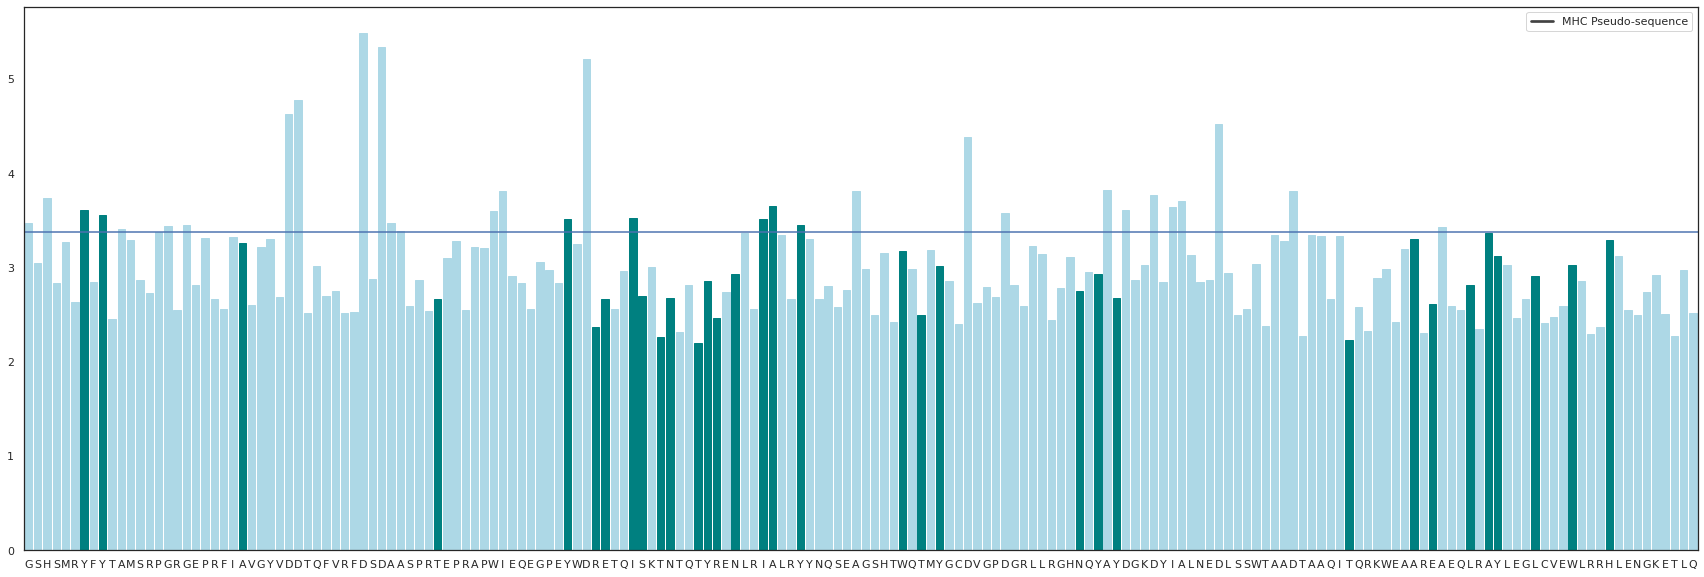



YYATYREISTNTYENIAYWTYNYYTWAELAYLWH

GHYYAPGGDDDDAAWIYDIIAYADDADDIADDAA
0.5113378684807257



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 88
HLA: HLA-C*17:01
GSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEAGSHTIQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQISQRKLEAAREAEQLRAYLEGECVEWLRGYLENGKETLQ
threshold: 3.3319438587535513


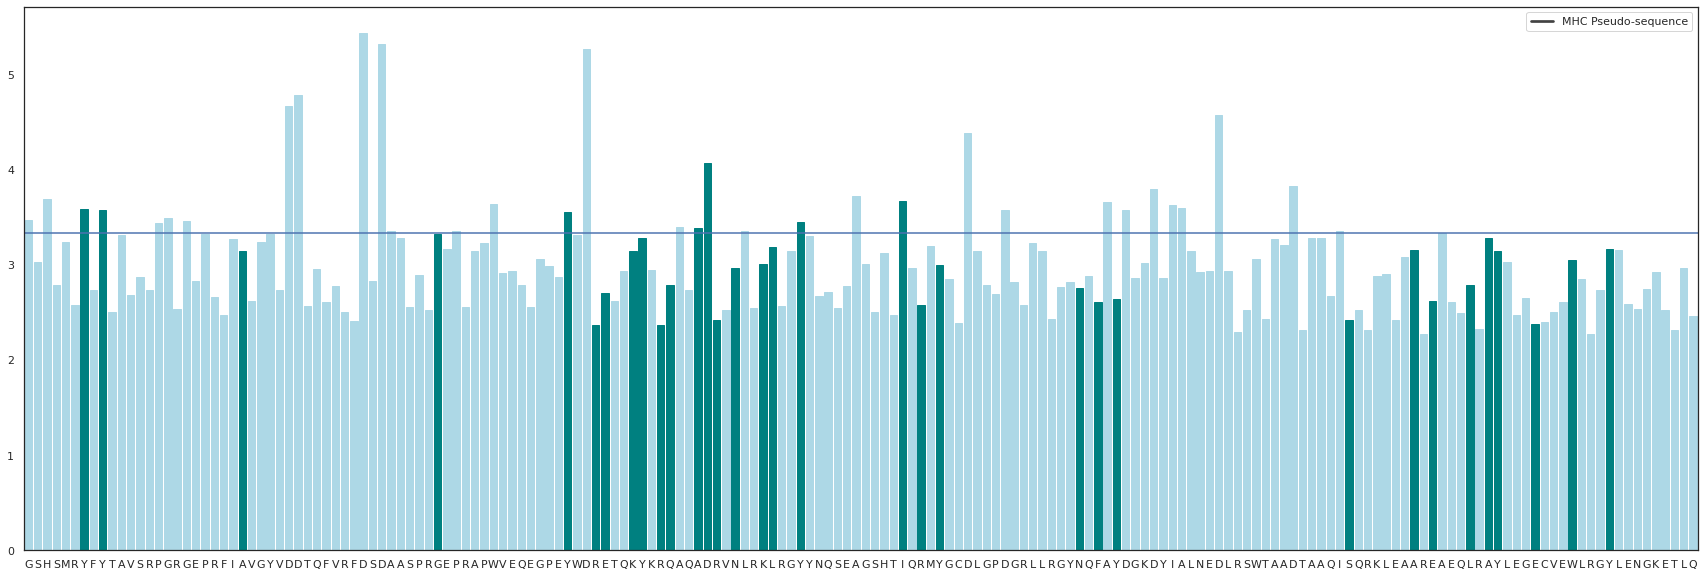



YYAGYREKYRQADVNKLYIRYNFYSLAELAYEWY

GHYYPGGDDDDAPWYDAADLYAIDDADDIADDIA
0.5512265512265513



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 101
HLA: HLA-B*51:08
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRENLRIALRYYNQSEAGSHTWQTMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVEWLRRHLENGKETLQ
threshold: 3.3668771875966894


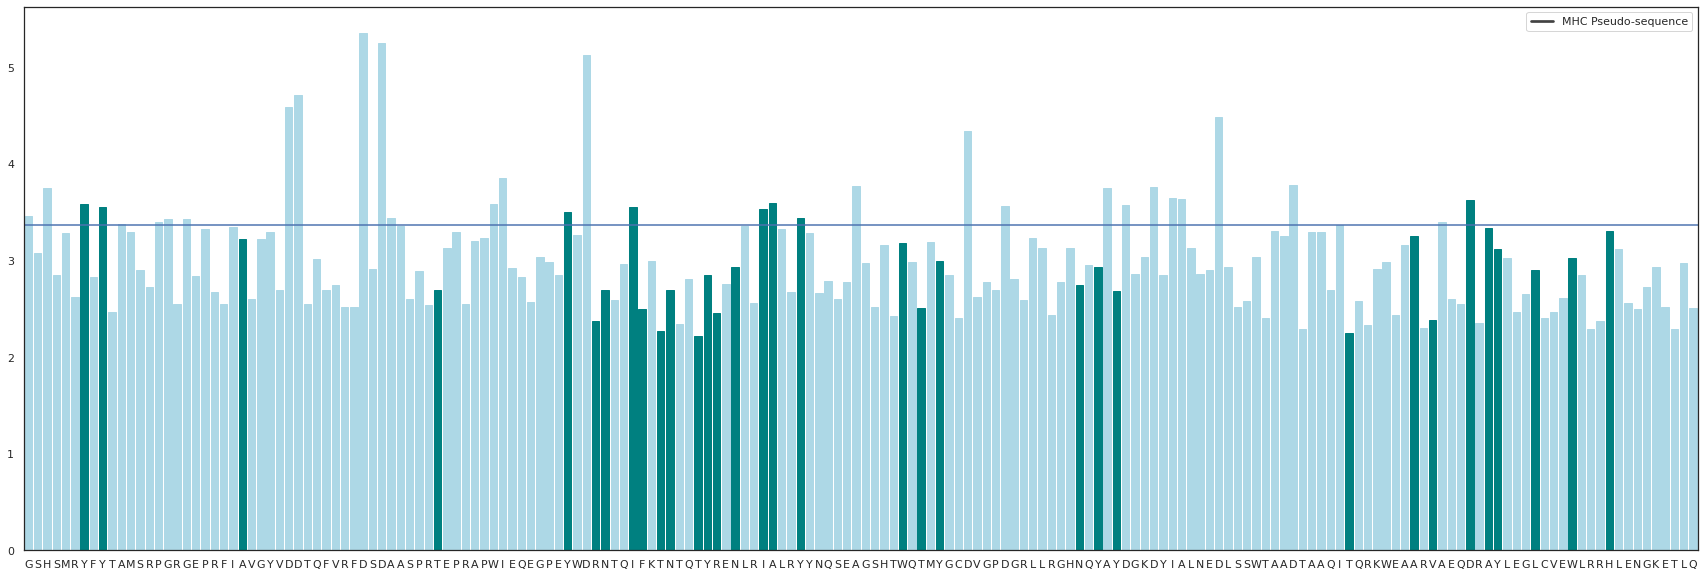



YYATYRNIFTNTYENIAYWTYNYYTWAVDAYLWH

GHYYAPGGDDDDAWIYDIIAYADDADDIADDIAD
0.5094825809111524



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 98
HLA: HLA-B*39:24
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTDRESLRNLRGYYNQSEAGSHTLQSTYGCDVGPDGRLLRGHNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRTYLEGTCVEWLRRYLENGKETLQ
threshold: 3.4261079126474807


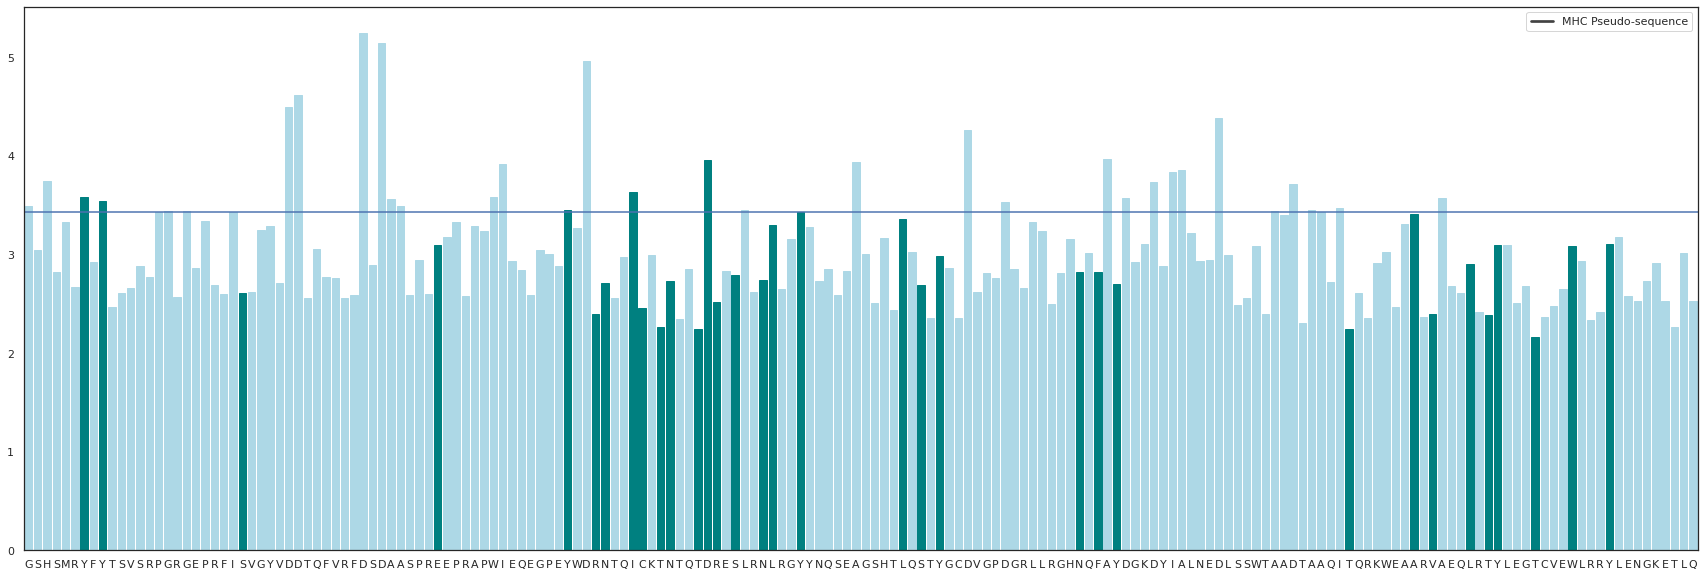



YYSEYRNICTNTDESNLYLSYNFYTWAVLTYTWY

GHYYPGGDDDDAAWIYDIDLADDADDIADADAIA
0.45042259327973616



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 88
HLA: HLA-B*41:01
GSHSMRYFHTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTWQRMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARVAEQDRAYLEGTCVEWLRRYLENGKDTLE
threshold: 3.4051888205788354


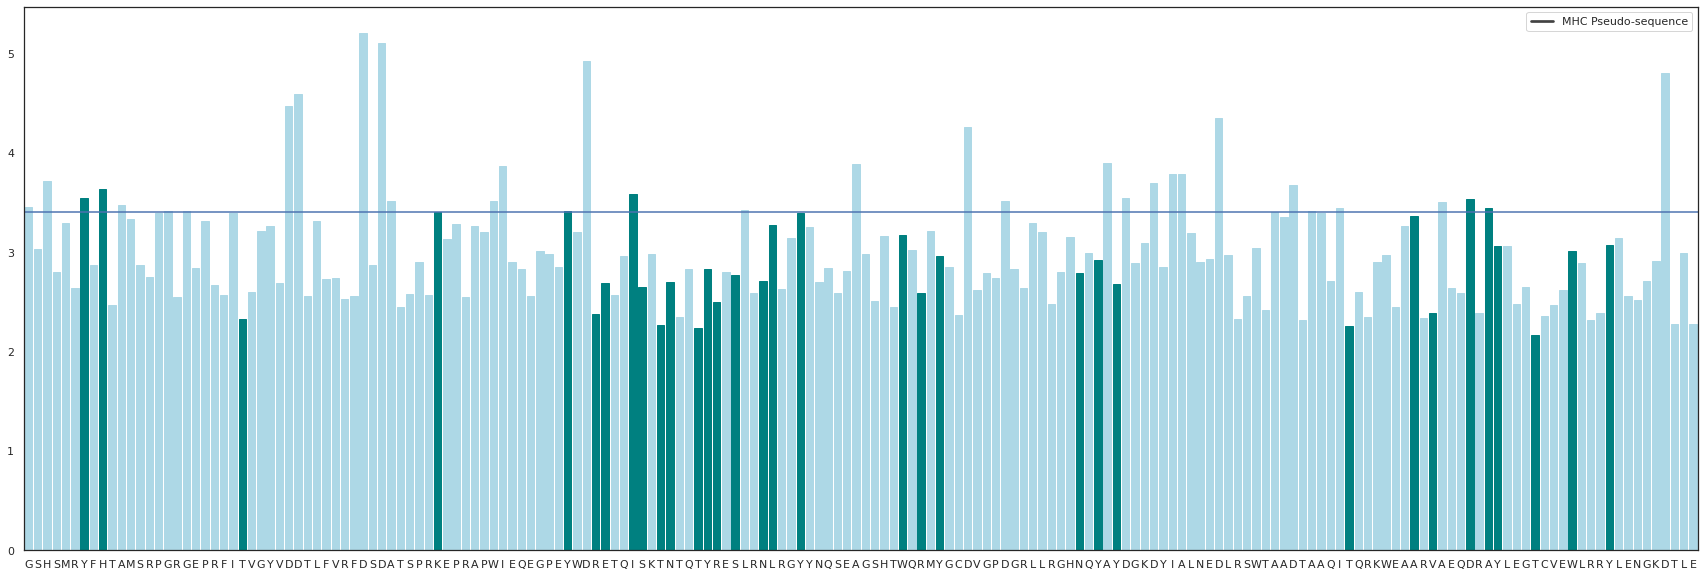



YHTKYREISTNTYESNLYWRYNYYTWAVDAYTWY

GHYHAGGDDDDAWIYDILADDADDIADDAIADAD
0.46227581941867657



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 116
HLA: HLA-B*56:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHTWQTMYGCDLGPDGRLLRGHNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.3174188548120958


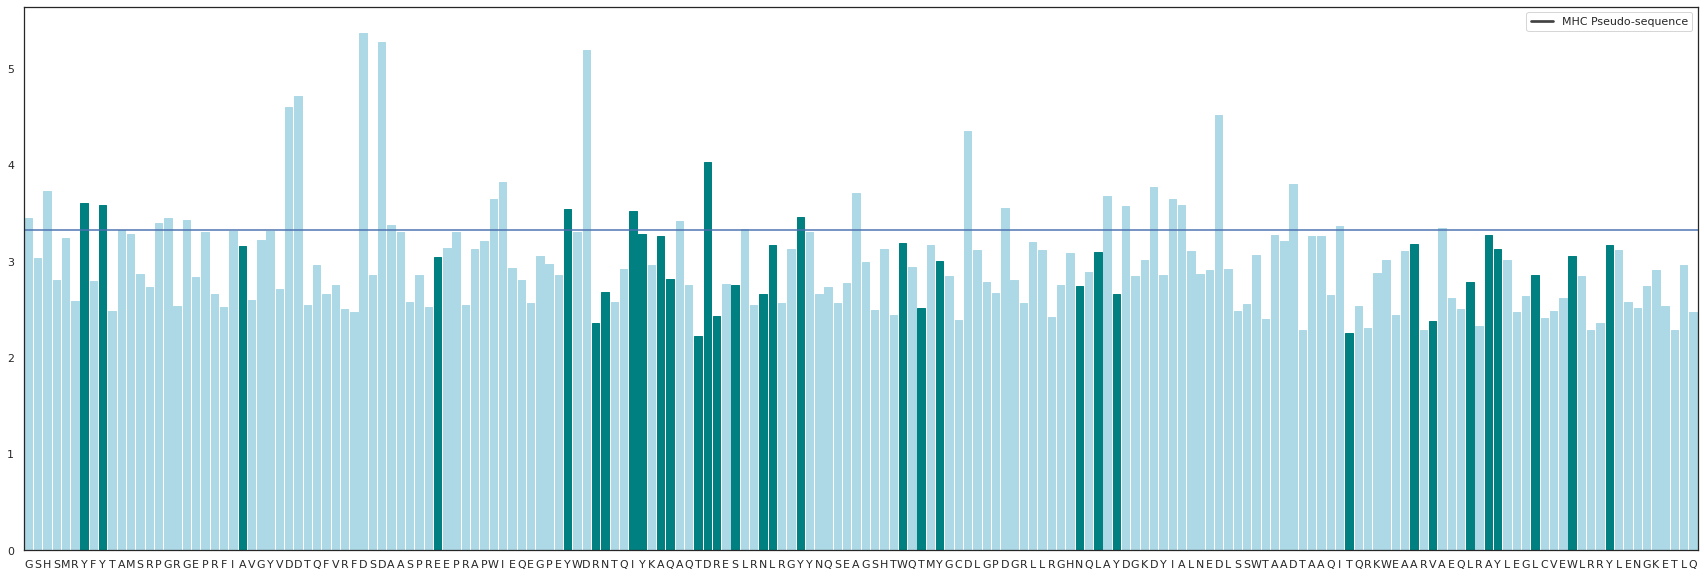



YYAEYRNIYAQTDESNLYWTYNLYTWAVLAYLWY

GHYYAPGGDDDDAWIYDIADLYADDADDIADDIA
0.5318491032776747



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 117
HLA: HLA-B*53:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRENLRIALRYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.3576201088408117


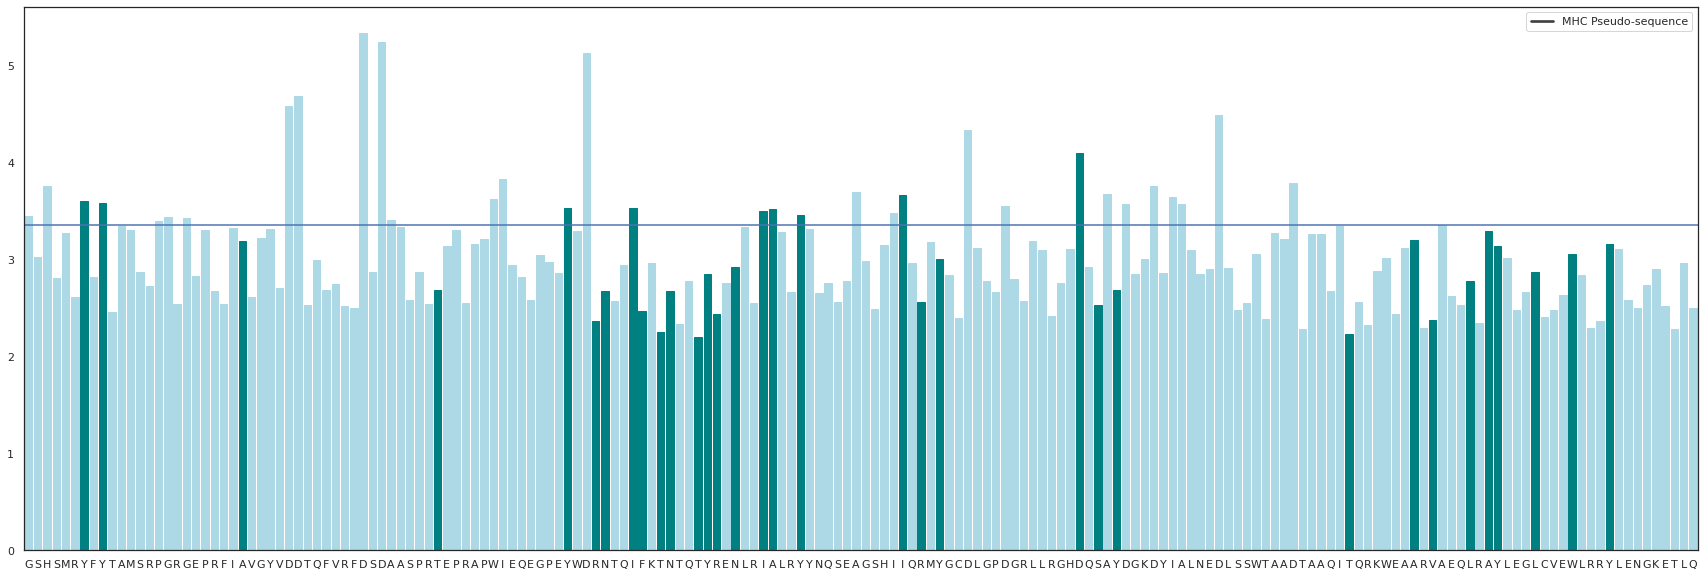



YYATYRNIFTNTYENIAYIRYDSYTWAVLAYLWY

GHYYPGGDDDDAWIYDIIAYAIIDDDADDIADDA
0.5027829313543599



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 130
HLA: HLA-B*15:11
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDRNTQIYKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQWRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.3627664419320915


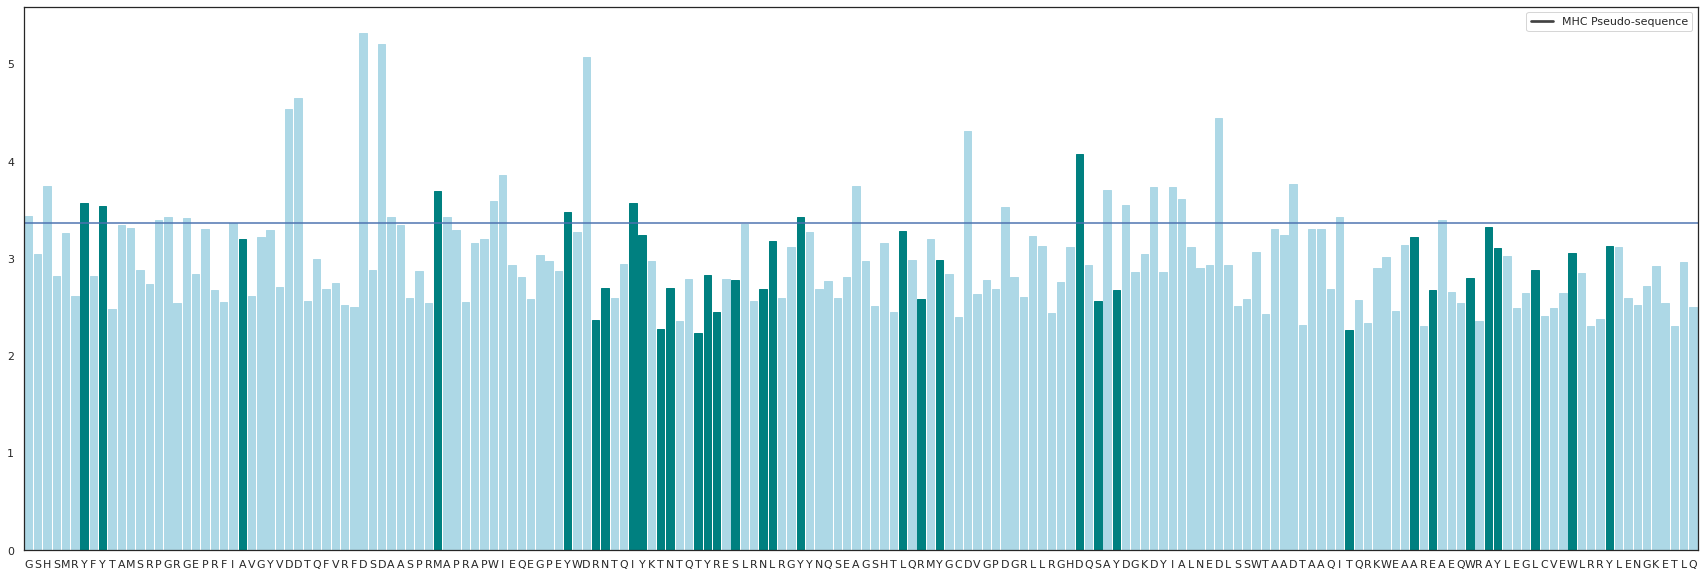



YYAMYRNIYTNTYESNLYLRYDSYTWAEWAYLWY

GHYYPGGIDDDDAMAWIYDIYADDDADDIADDIA
0.5193774479488765



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 141
HLA: HLA-B*27:03
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEHWDRETQICKAKAQTDREDLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.3815006770140736


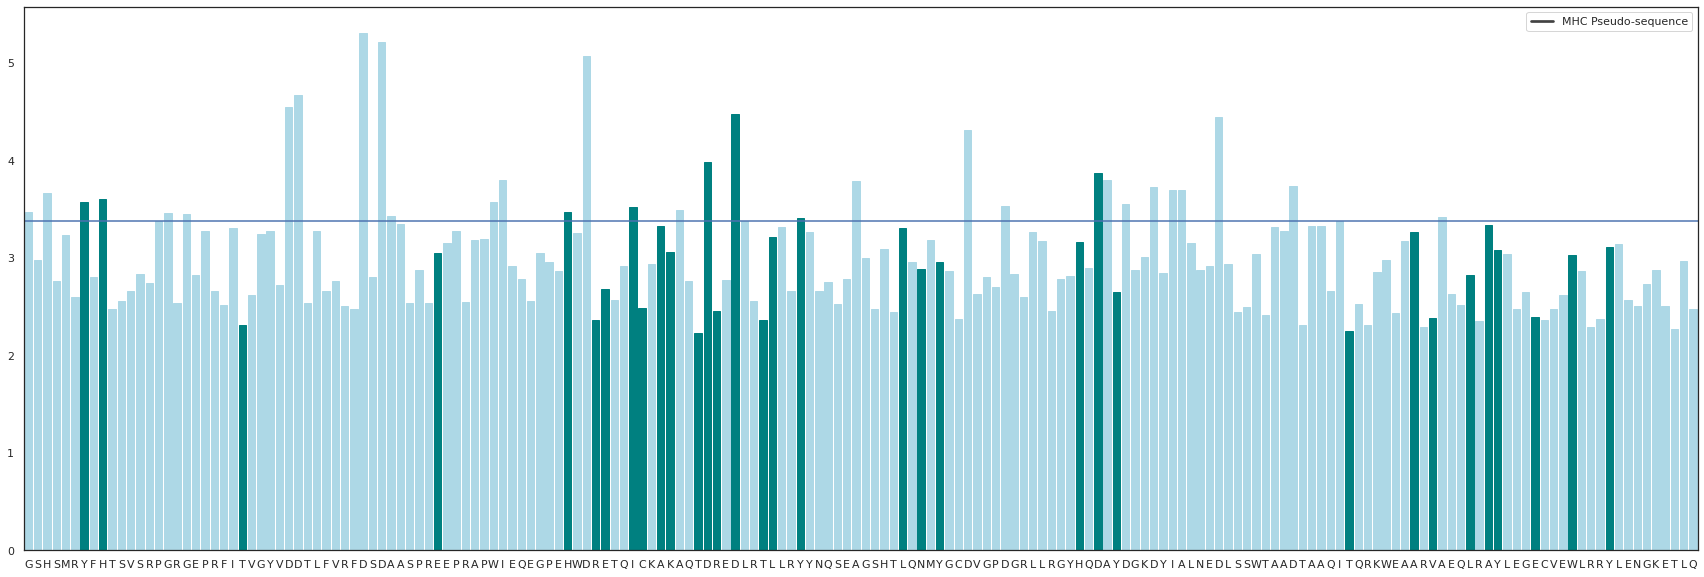



YHTEHREICAKTDEDTLYLNYHDYTWAVLAYEWY

GHYHPGGDDDDAWIHDIADDYADDDADDIADDIA
0.5352504638218925



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 188
HLA: HLA-A*02:20
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRNVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.321722152385306


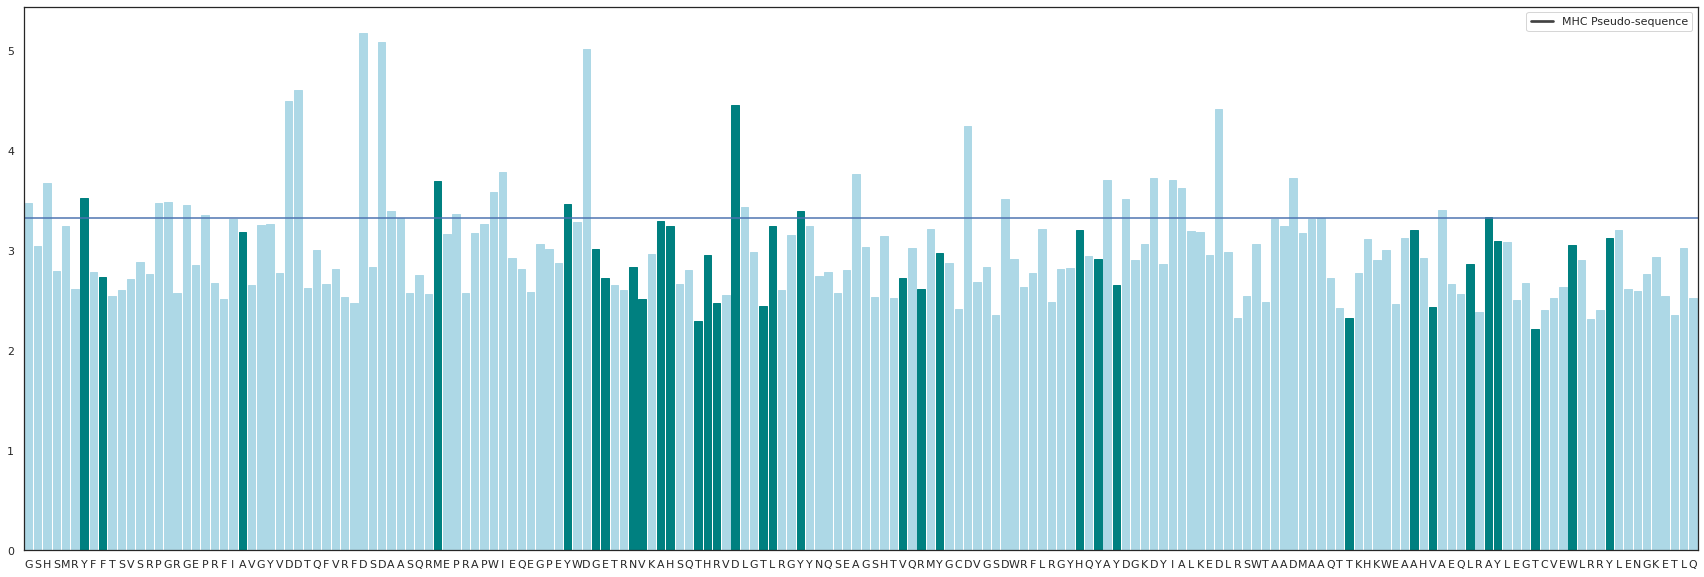



YFAMYGENVAHTHVDTLYVRYHYYTWAVLAYTWY

GHYPGGPDDDDAMPWIYDDLYADDADDIADDAAA
0.5040197897340755



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 171
HLA: HLA-A*30:02
GSHSMRYFSTSVSRPGSGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQERPEYWDQETRNVKAHSQTDRENLGTLRGYYNQSEAGSHTIQIMYGCDVGSDGRFLRGYEQHAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARRAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3653782180875367


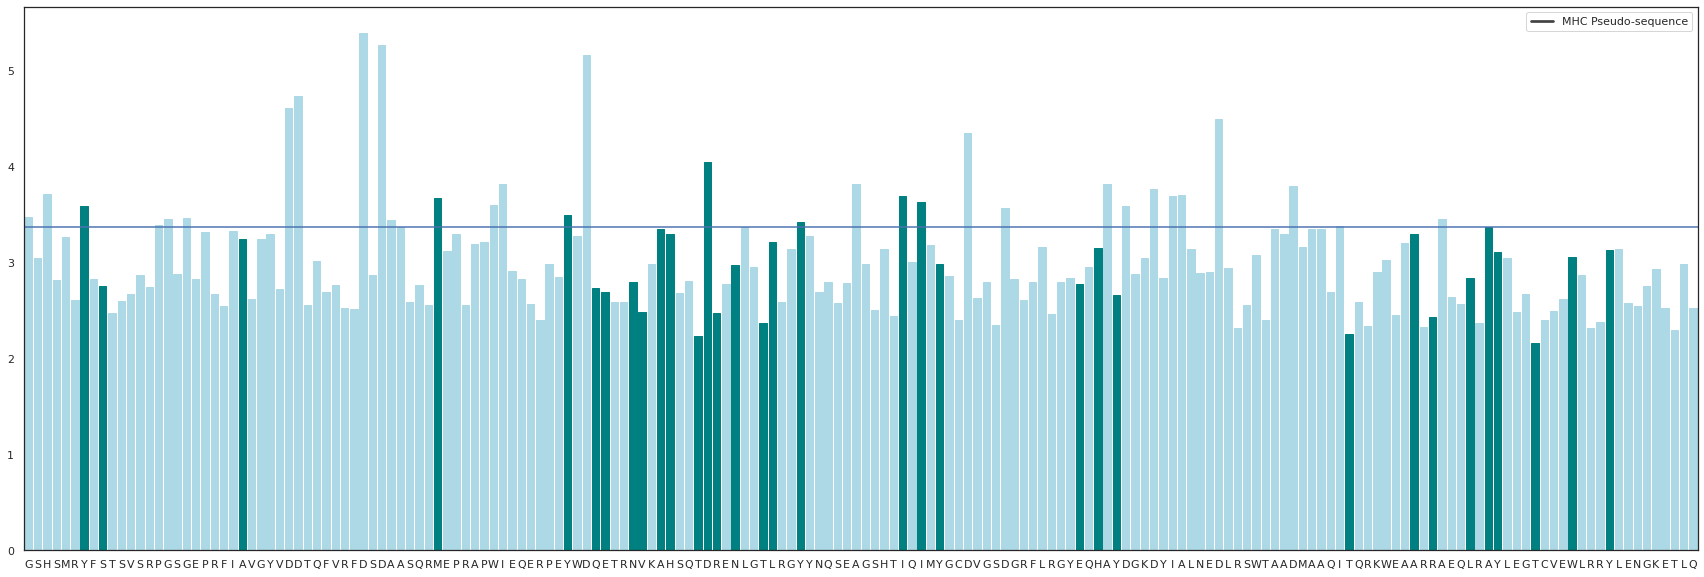



YSAMYQENVAHTDENTLYIIYEHYTWARLAYTWY

GHYPGGDDDDAAMWIYDDLYAIIDDADDIADDIA
0.5384456813028241



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 172
HLA: HLA-B*15:18
GSHSMRYFYTAMSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.3902935649073402


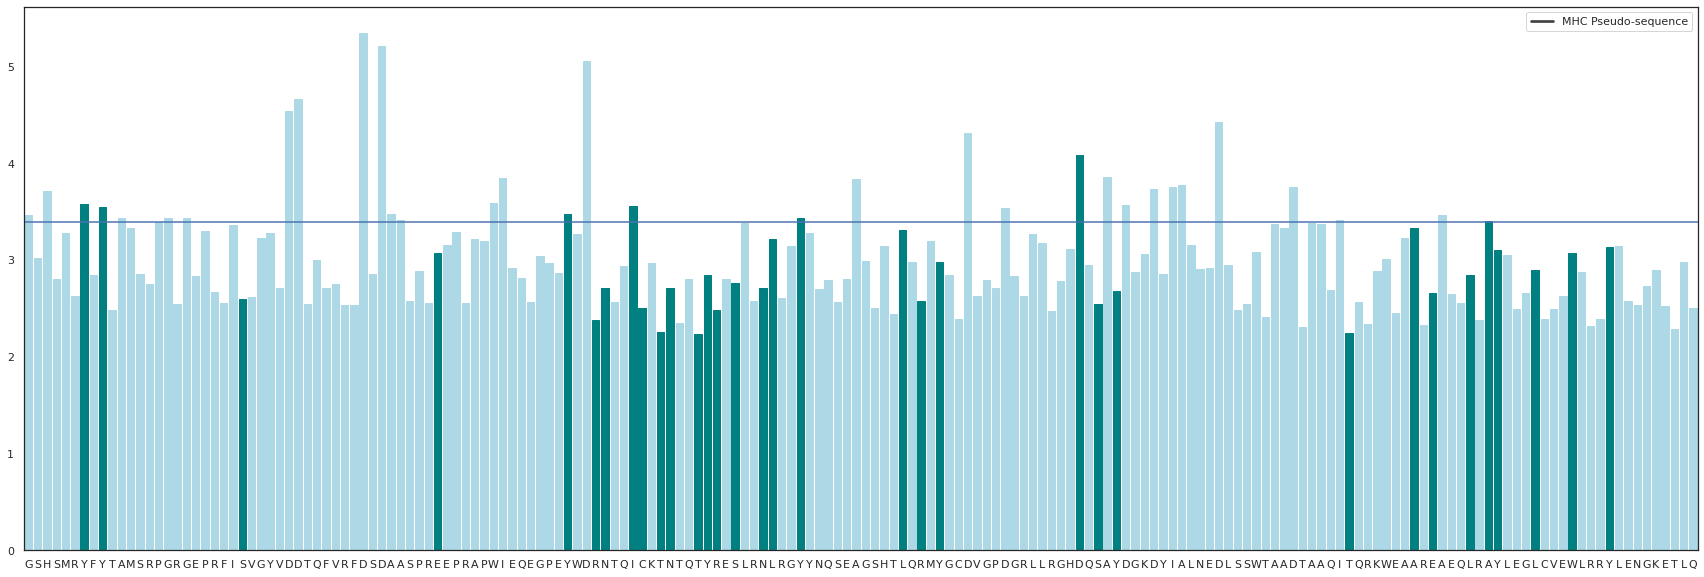



YYSEYRNICTNTYESNLYLRYDSYTWAELAYLWY

GHYYAPGGDDDDAAWIYDIYADDDADDIADDIAA
0.4826839826839827



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 196
HLA: HLA-B*27:06
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDRESLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.387068456533004


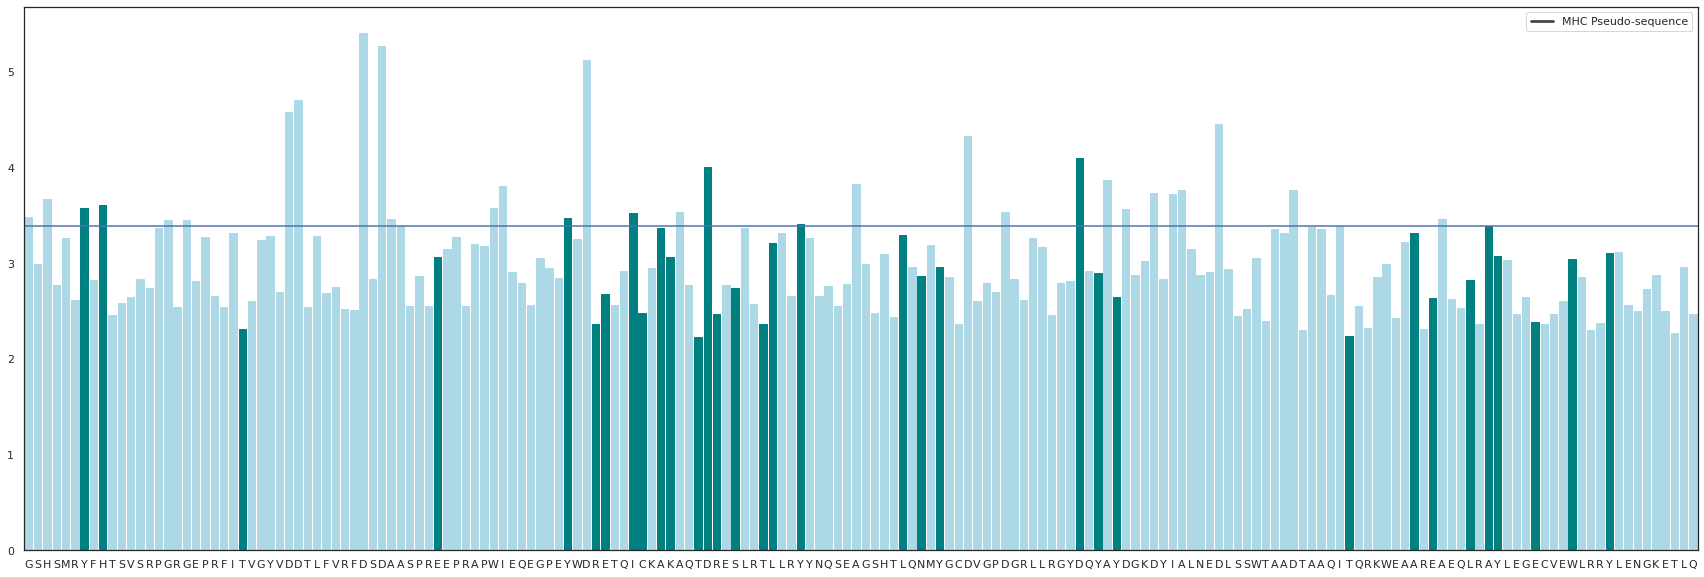



YHTEYREICAKTDESTLYLNYDYYTWAELAYEWY

GHYHGGDDDDAAWIYDIADYADDDADDIADDIAA
0.5214388785817358



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 210
HLA: HLA-A*69:01
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3444882347470237


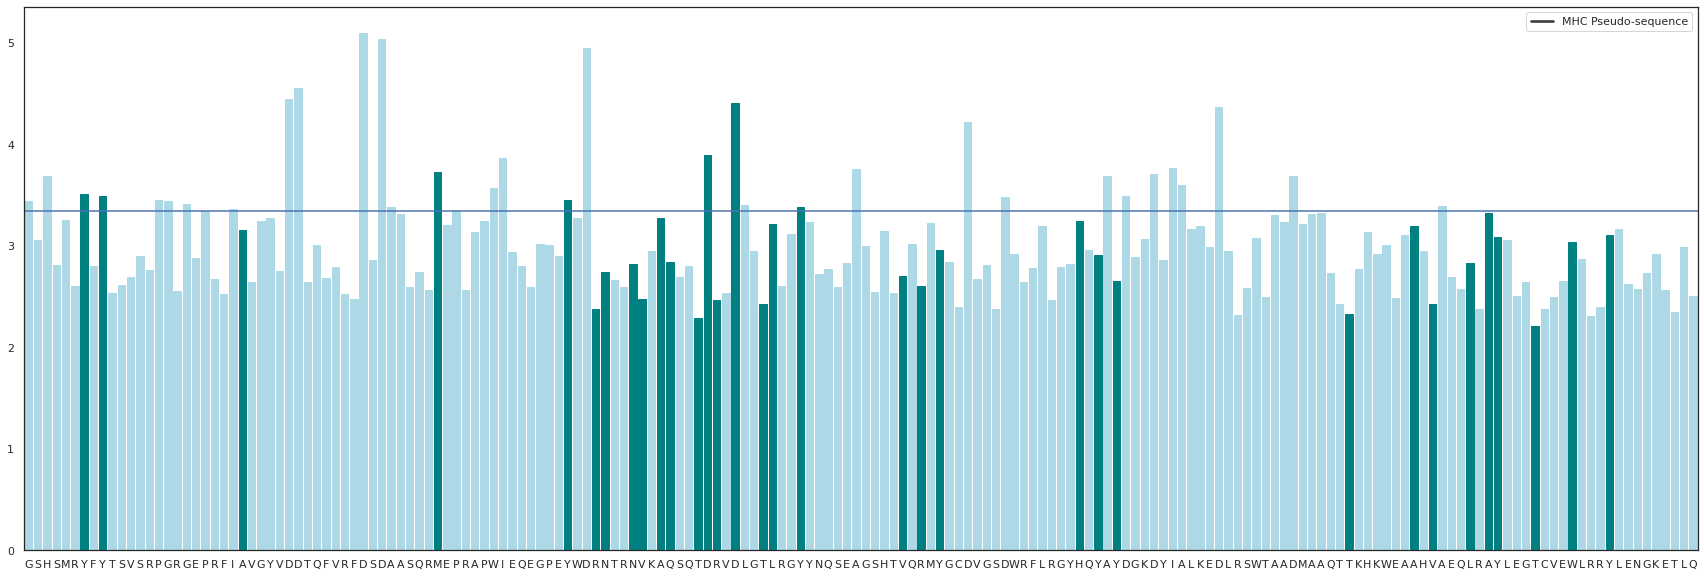



YYAMYRNNVAQTDVDTLYVRYHYYTWAVLAYTWY

GHYYPGGPIDDDDAMWIYDDDLYADDADDIADDA
0.5049474335188621



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 214
HLA: HLA-B*35:08
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRESLRNLRGYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQRRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.3694415226160923


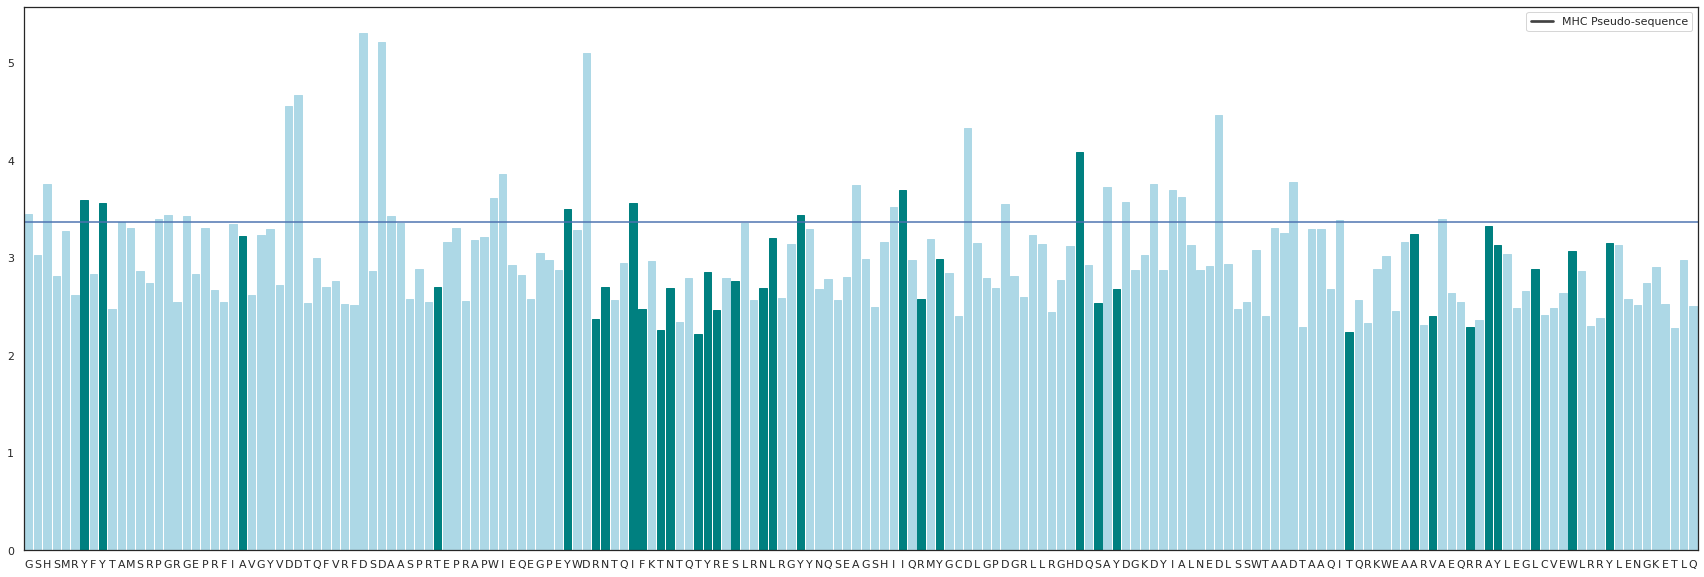



YYATYRNIFTNTYESNLYIRYDSYTWAVRAYLWY

GHYYAPGGDDDDAWIYDIYAIIDDDADDIADDIA
0.4635126777983921



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 234
HLA: HLA-A*33:01
GSHSMRYFTTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAHSQIDRVDLGTLRGYYNQSEAGSHTIQMMYGCDVGSDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRHLENGKETLQ
threshold: 3.372280544704861


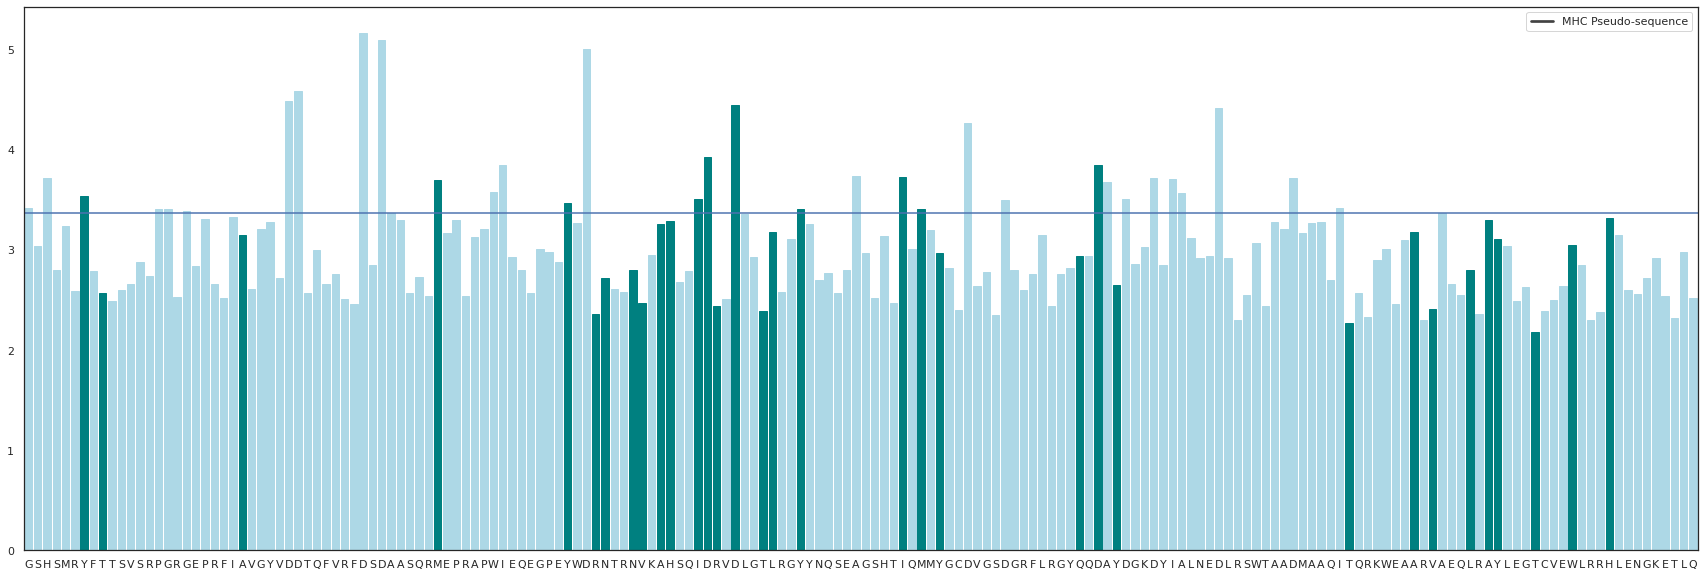



YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWH

GHYPGGDDDDMWIYDIDDYAIMDDDADDIADDIA
0.5766852195423624



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 237
HLA: HLA-B*54:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHTWQTMYGCDLGPDGRLLRGHNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3166462701081225


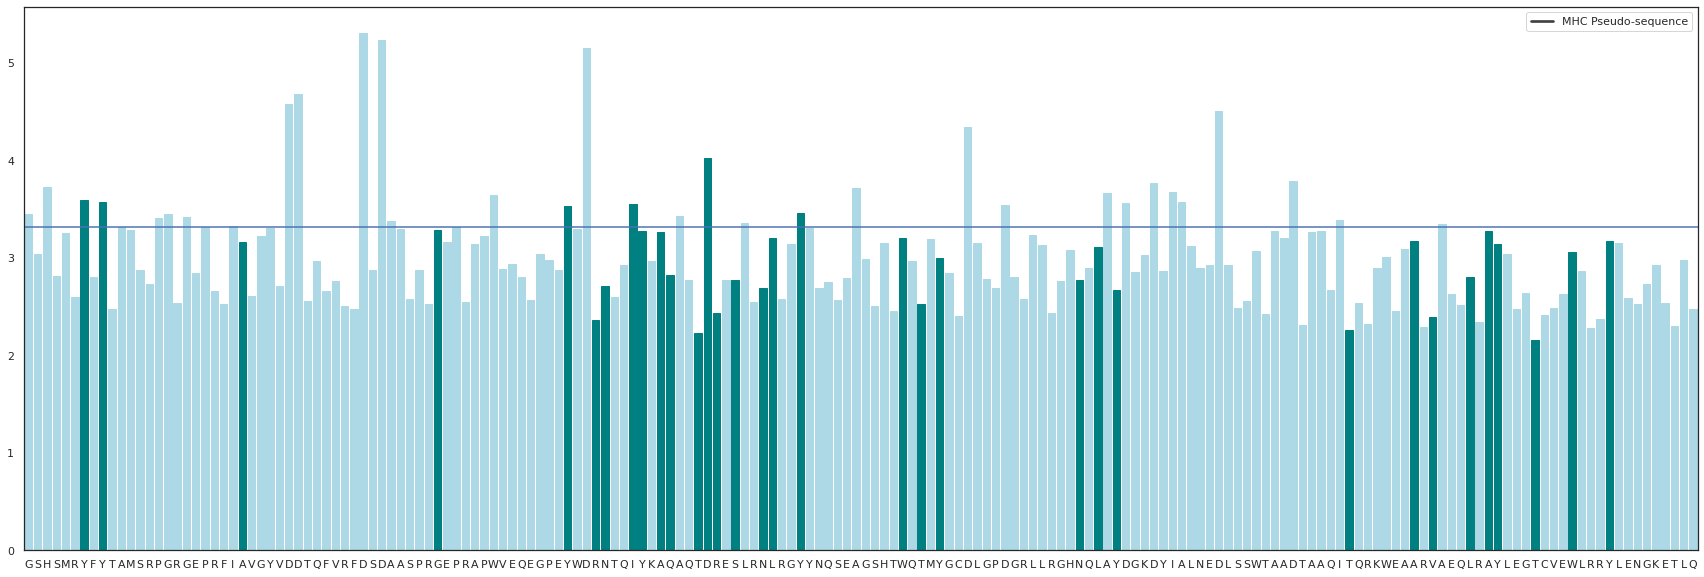



YYAGYRNIYAQTDESNLYWTYNLYTWAVLAYTWY

GHYYPGGPIDDDDAWYDIADLYADDADDIADDIA
0.5272108843537415



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 239
HLA: HLA-B*39:06
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTDRESLRNLRGYYNQSEAGSHTWQTMYGCDVGPDGRLLRGHNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRTYLEGTCVEWLRRYLENGKETLQ
threshold: 3.4259196644547596


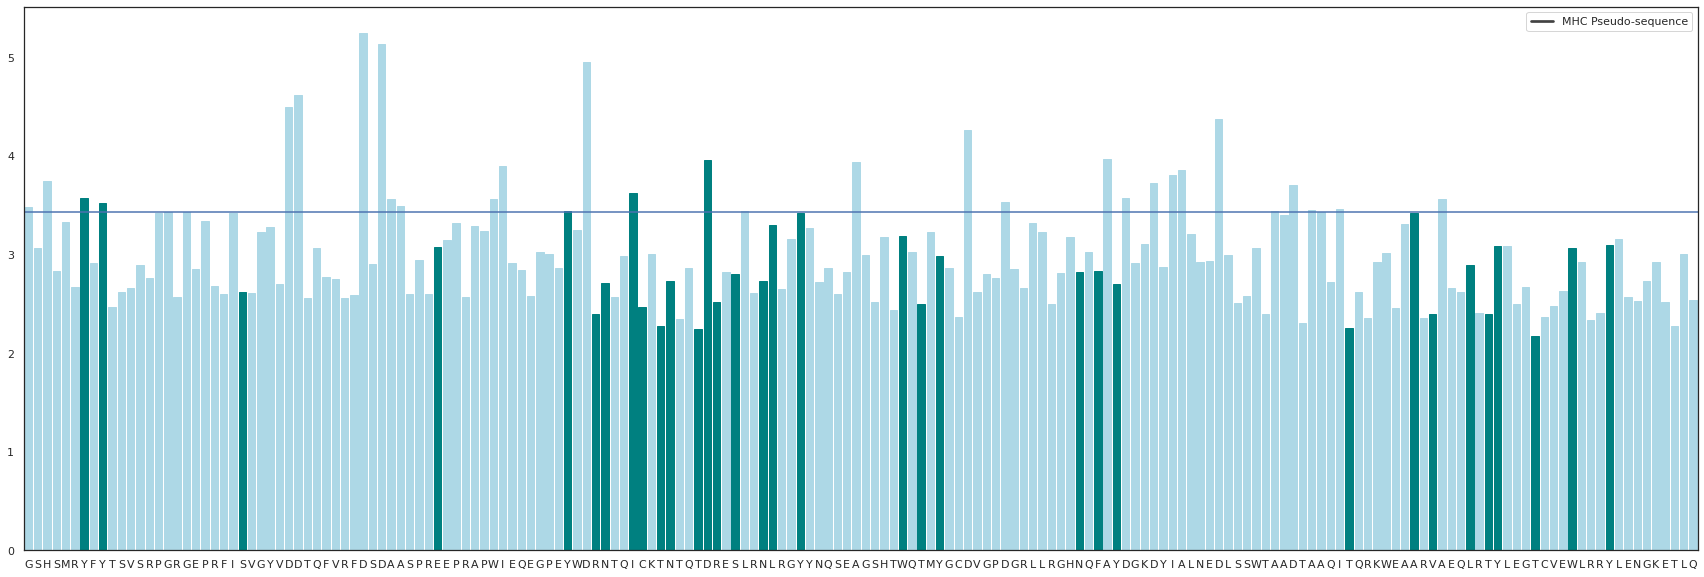



YYSEYRNICTNTDESNLYWTYNFYTWAVLTYTWY

GHYYGGDDDDAAWIYDIDLADDADDIADADAAIA
0.43733250876108015



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 286
HLA: HLA-A*02:04
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQMMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.323521327305507


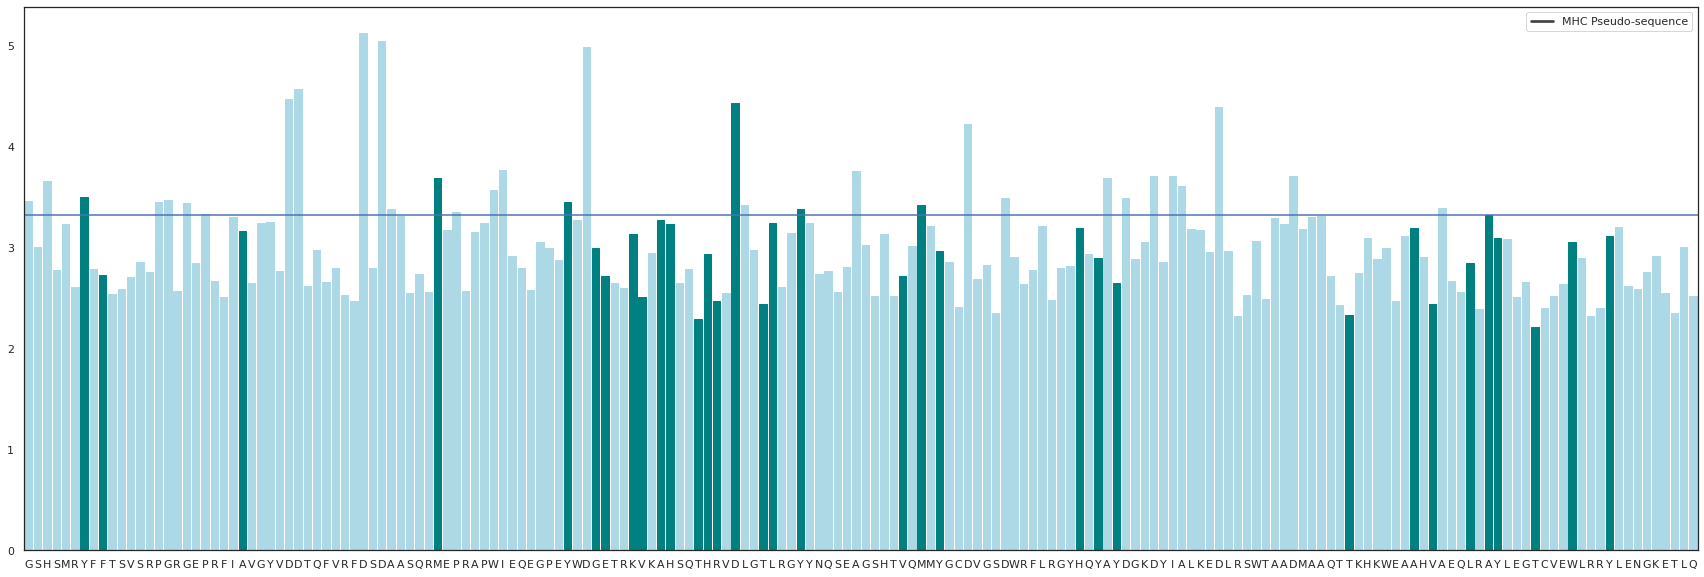



YFAMYGEKVAHTHVDTLYVMYHYYTWAVLAYTWY

GHYPGGPDDDDAMPWIYDDLYAMDDADDIADDAA
0.5281385281385281



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 253
HLA: HLA-A*30:01
GSHSMRYFSTSVSRPGSGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQERPEYWDQETRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQIMYGCDVGSDGRFLRGYEQHAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARWAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3485700886240117


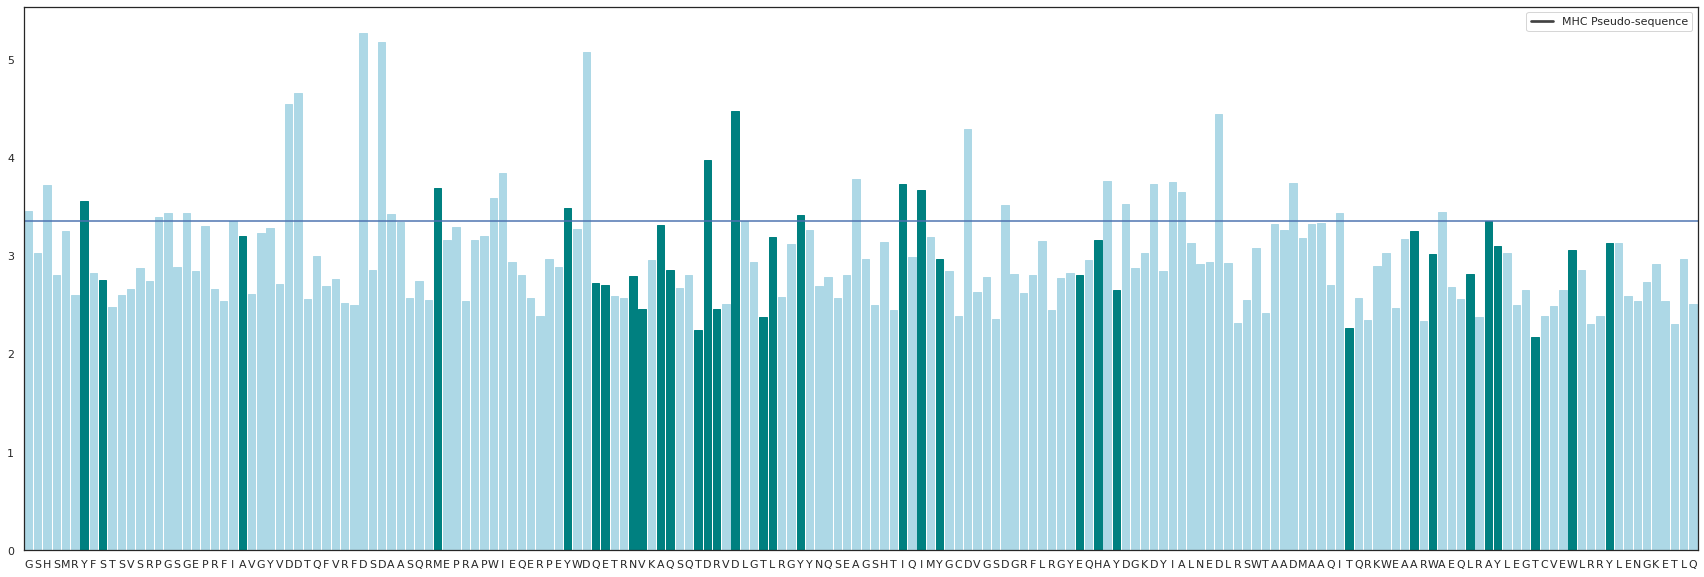



YSAMYQENVAQTDVDTLYIIYEHYTWAWLAYTWY

GHYPGGDDDDAMWIYDDDYAIIDDADDIADDIAA
0.5583384869099155



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 281
HLA: HLA-B*50:01
GSHSMRYFHTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTWQRMYGCDLGPDGRLLRGYNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.3854376633396353


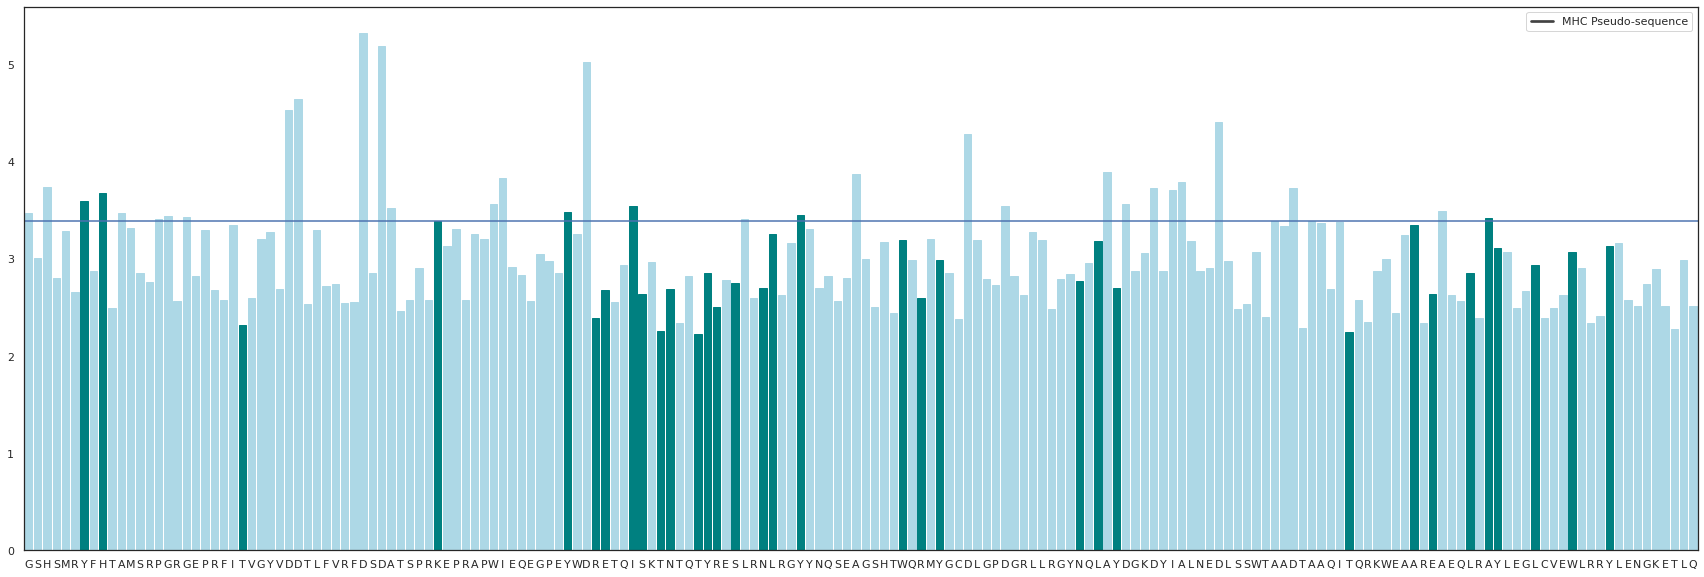



YHTKYREISTNTYESNLYWRYNLYTWAELAYLWY

GHYHAPGGDDDDAKWIYDILYADDADDIADDAAA
0.4855699855699856



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 327
HLA: HLA-C*15:02
CSHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQTDRVNLRKLRGYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQLAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.338004482630925


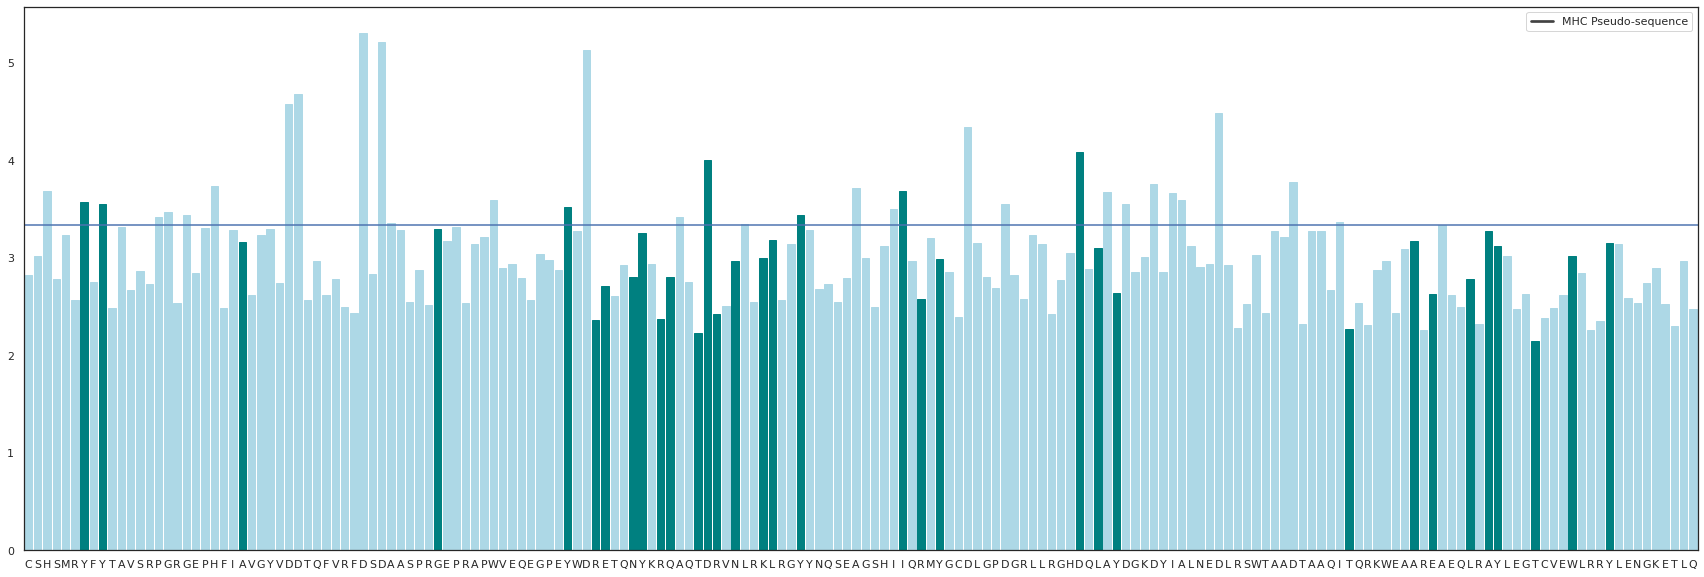



YYAGYRENYRQTDVNKLYIRYDLYTWAELAYTWY

HYYPGGHDDDDAWYDADLYAIIDDDADDIADDIA
0.536178107606679



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 299
HLA: HLA-C*12:03
CSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEAGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3316064534777383


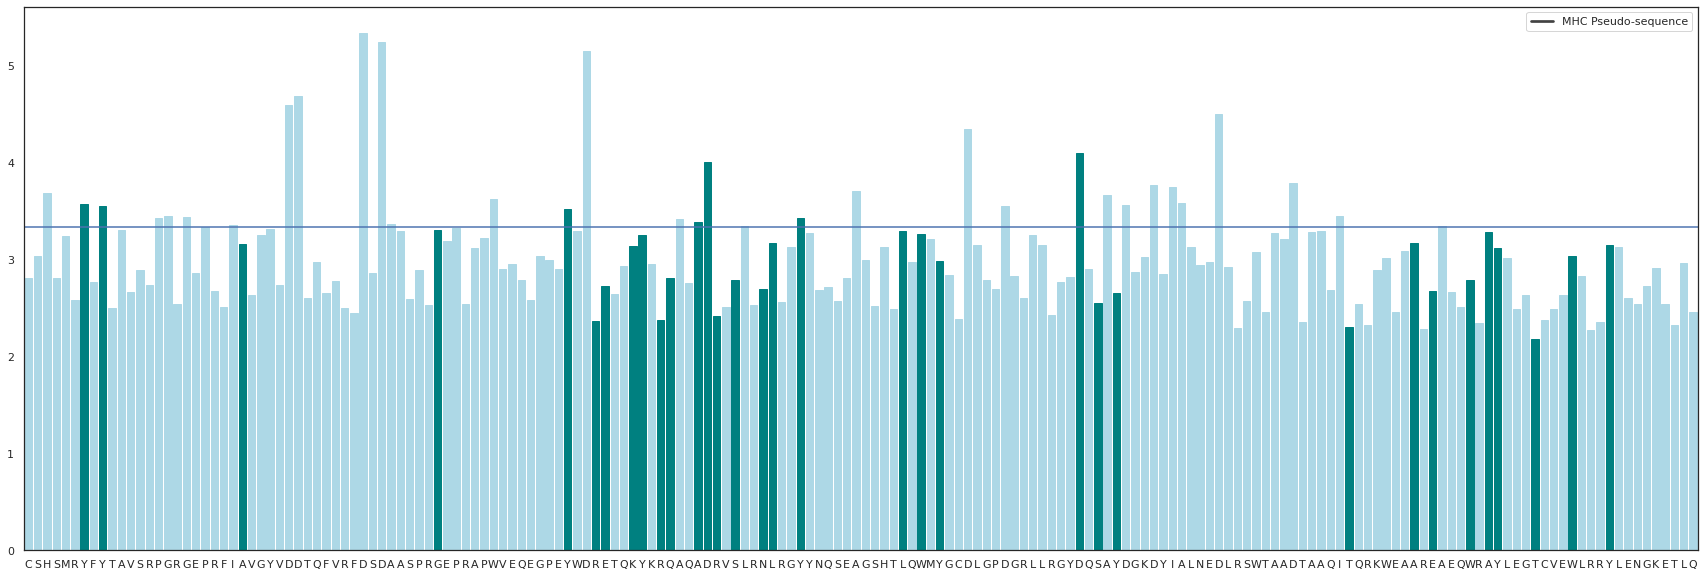



YYAGYREKYRQADVSNLYLWYDSYTWAEWAYTWY

HYYPGGPIDDDDAWYDAADLYADDDADDIADDIA
0.5619459905174191



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 325
HLA: HLA-B*27:07
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDREDLRTLLRYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.3803023587740384


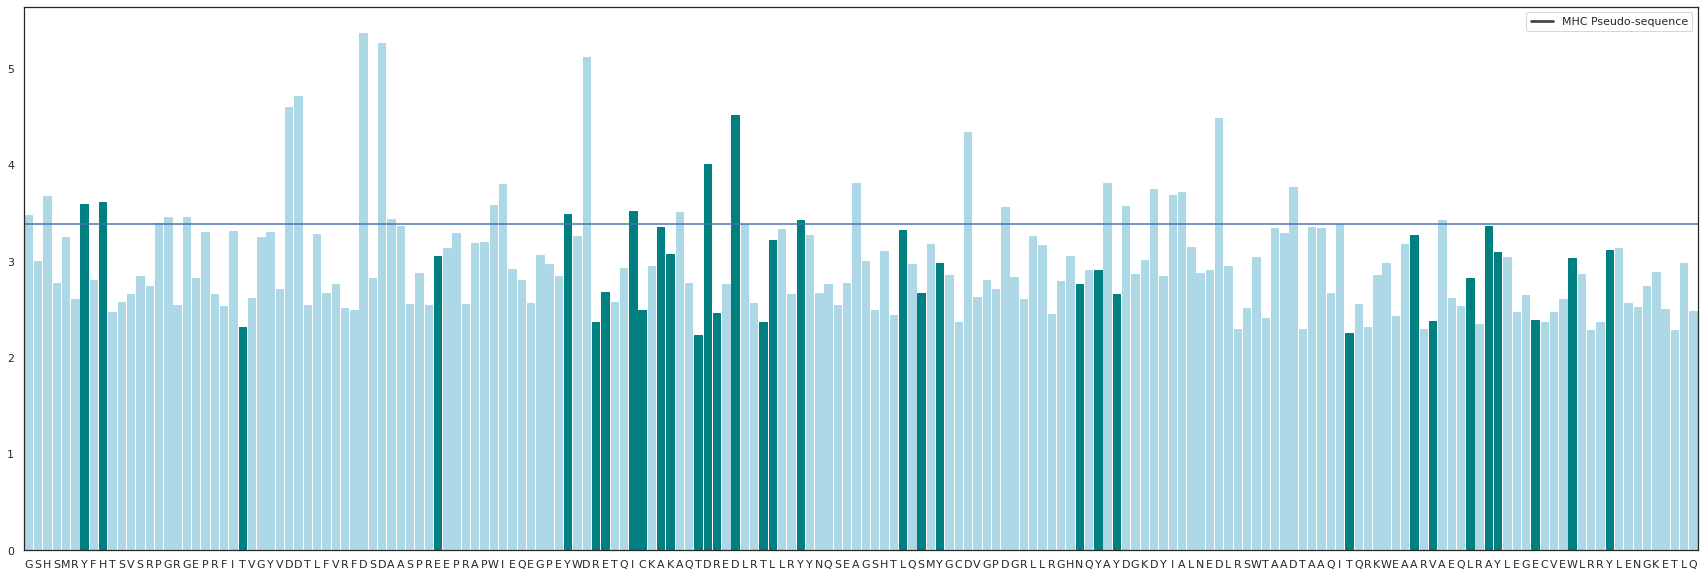



YHTEYREICAKTDEDTLYLSYNYYTWAVLAYEWY

GHYHPGGDDDDAWIYDIADDLYADDADDIADDIA
0.5098948670377241



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 360
HLA: HLA-B*46:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQWRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.343693372938368


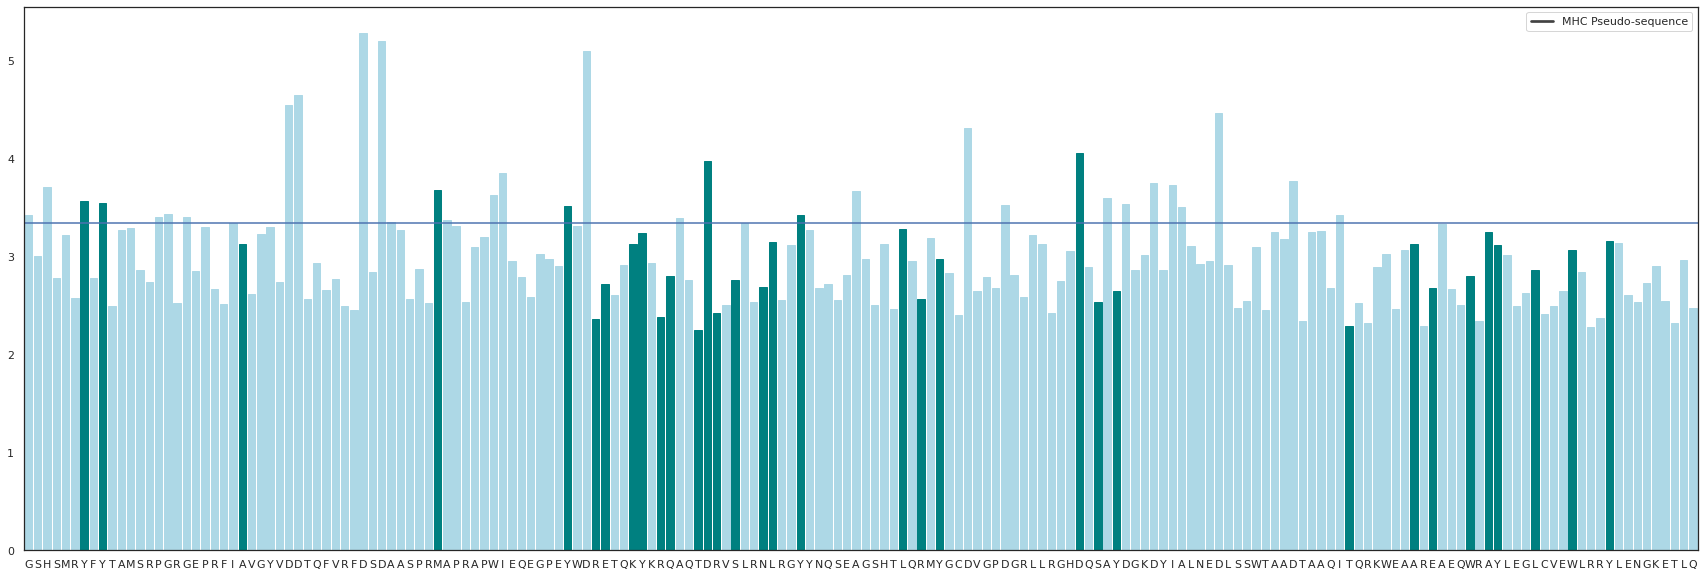



YYAMYREKYRQTDVSNLYLRYDSYTWAEWAYLWY

GHYYPGGIDDDDAMAWIYDADYADDDADDIADDI
0.5305091733663162



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 341
HLA: HLA-B*27:08
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDRESLRNLRGYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.3817160150522363


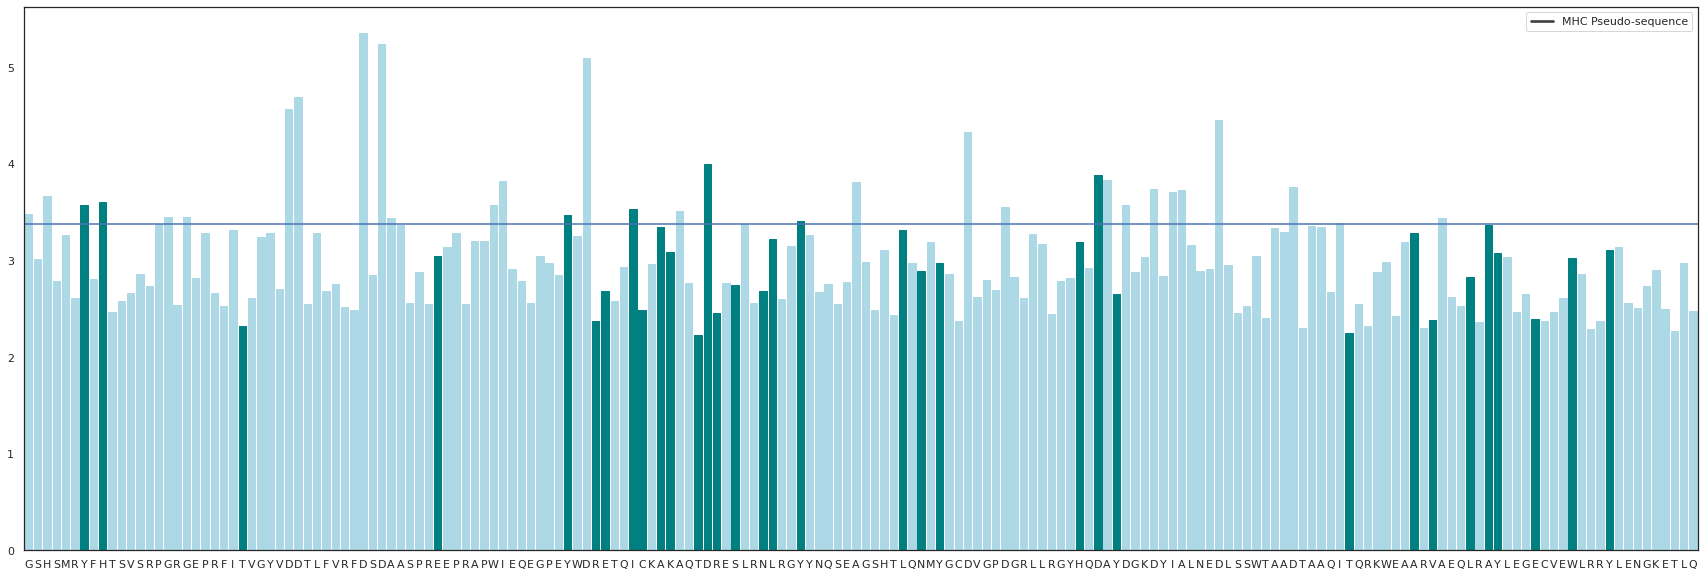



YHTEYREICAKTDESNLYLNYHDYTWAVLAYEWY

GHYHPGGDDDDAWIYDIADLYADDDADDIADDIA
0.5276231704803134



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 369
HLA: HLA-A*26:01
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAHSQTDRANLGTLRGYYNQSEDGSHTIQRMYGCDVGPDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWETAHEAEQWRAYLEGRCVEWLRRYLENGKETLQ
threshold: 3.380911312775237


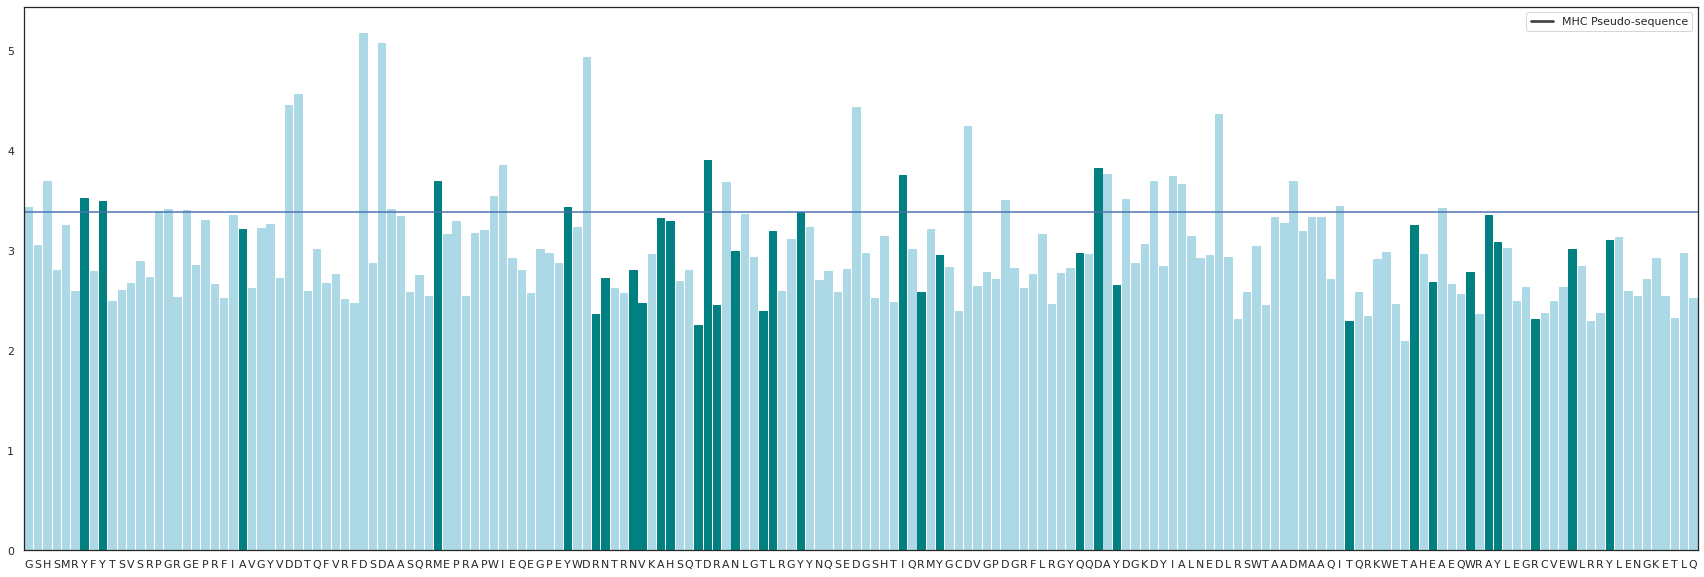



YYAMYRNNVAHTDANTLYIRYQDYTWAEWAYRWY

GHYYPGGDDDDAMWIYDDAYDIDDDADDIADDIA
0.5379303236446094



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 393
HLA: HLA-C*01:02
CSHSMKYFFTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMCGCDLGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3669660340132


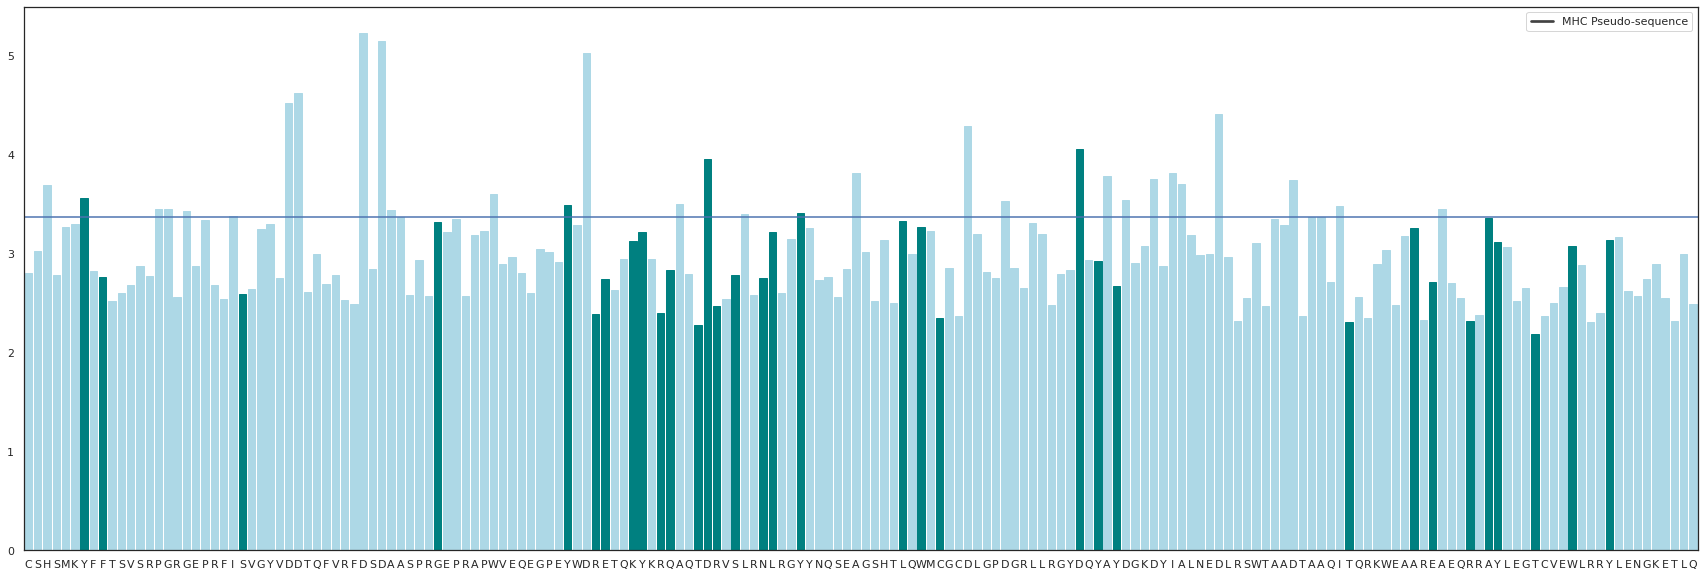



YFSGYREKYRQTDVSNLYLWCDYYTWAERAYTWY

HYPGGIDDDDAAWYDADLYADDDADDIADDAAIA
0.48175633889919606



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 422
HLA: HLA-B*27:04
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDRESLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.3704084785063686


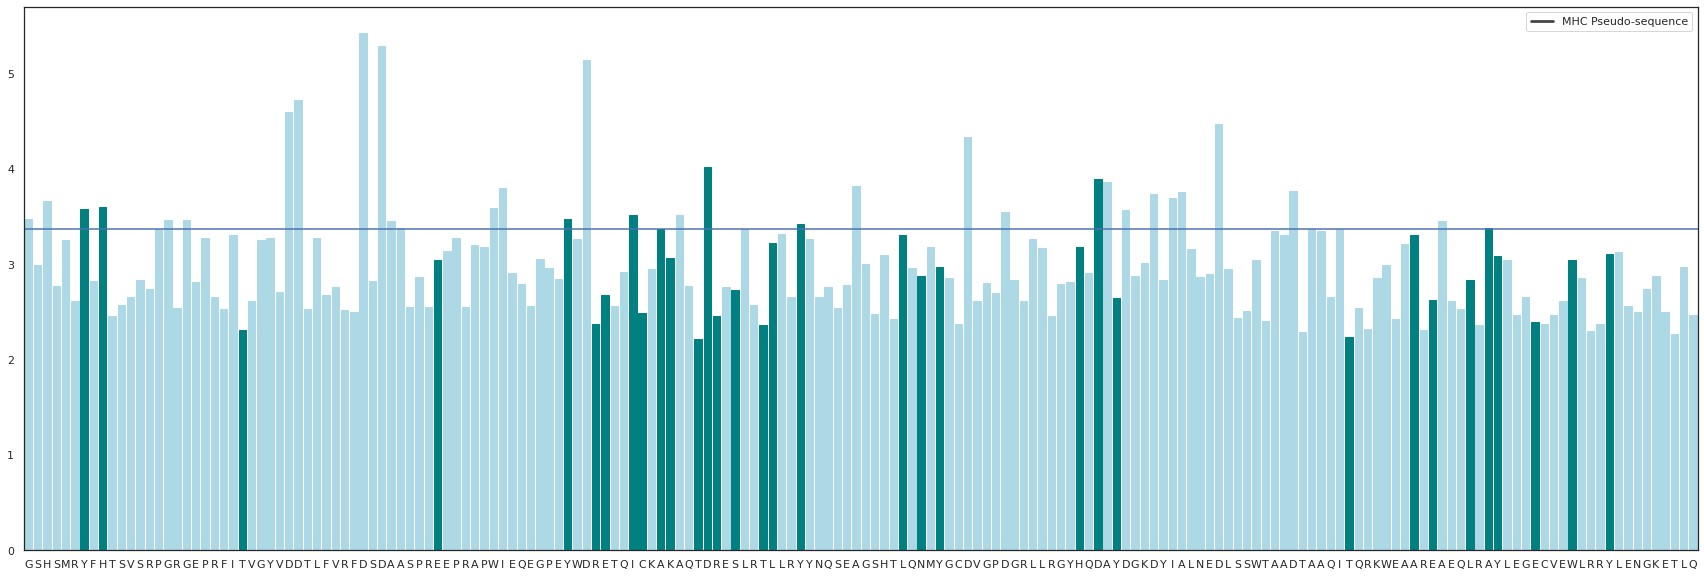



YHTEYREICAKTDESTLYLNYHDYTWAELAYEWY

GHYHPGGDDDDAAWIYDIADYADDDADDIADDAA
0.5264893836322408



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 364
HLA: HLA-A*02:02
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASRRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTLQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.321147206065419


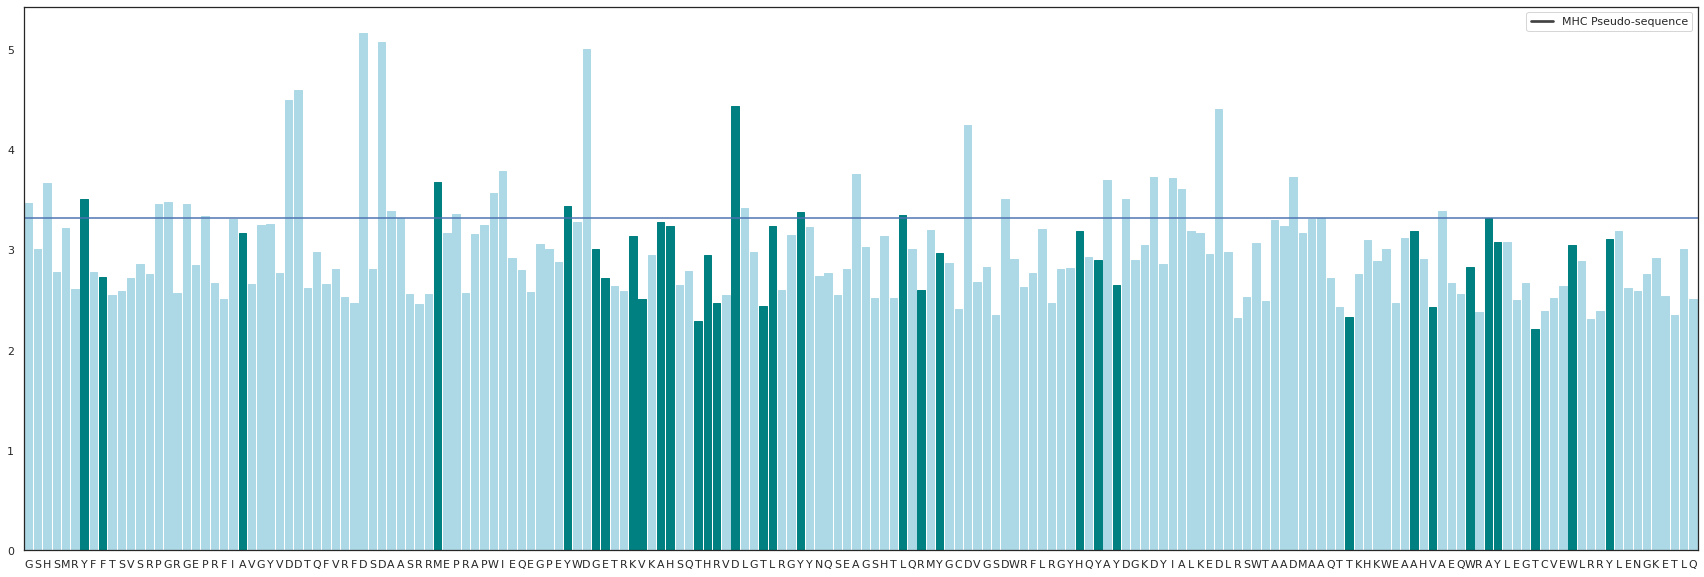



YFAMYGEKVAHTHVDTLYLRYHYYTWAVWAYTWY

GHYPGGPDDDDAAMPWIYDDLYALDDADDIADDA
0.5249433106575964



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 411
HLA: HLA-C*14:02
CSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMFGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3448706114089113


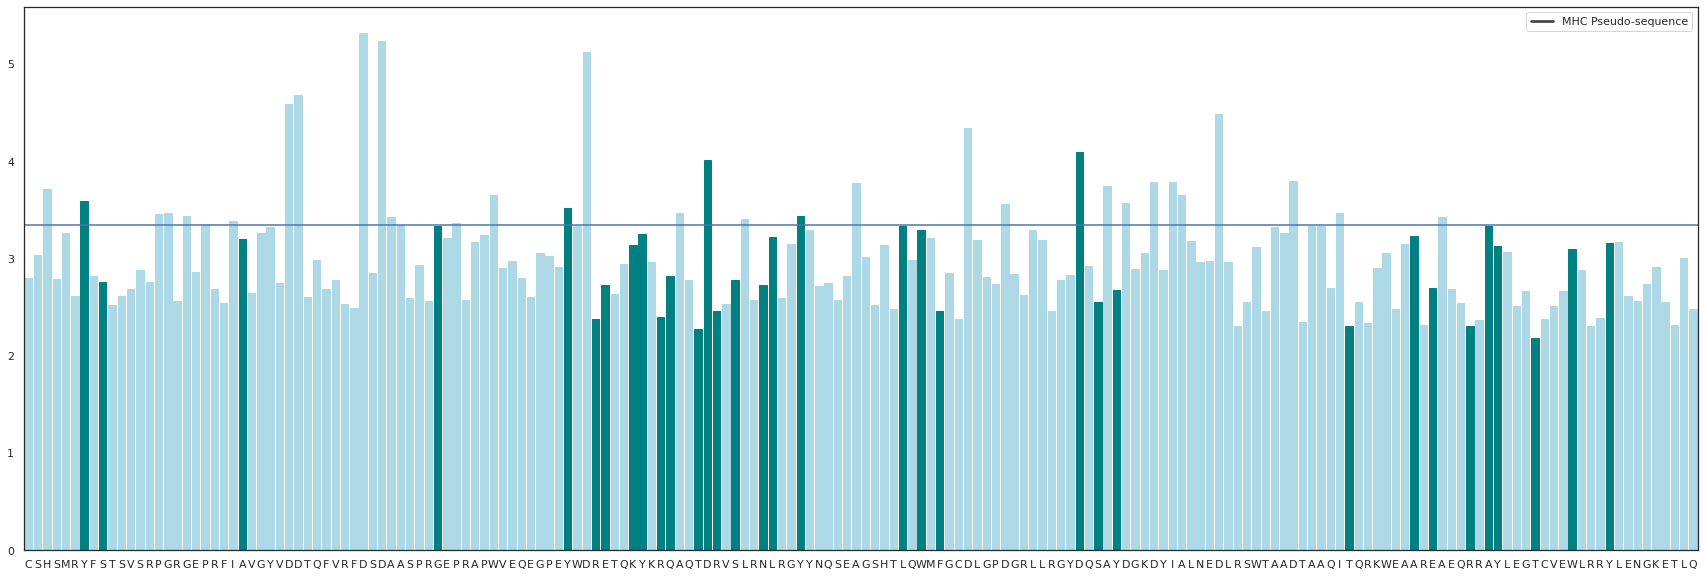



YSAGYREKYRQTDVSNLYLWFDSYTWAERAYTWY

HYPGGPIDDDDAAPWYDADLYADDDADDIADDIA
0.491960420531849



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 444
HLA: HLA-A*02:05
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASRRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTLQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3301419094876126


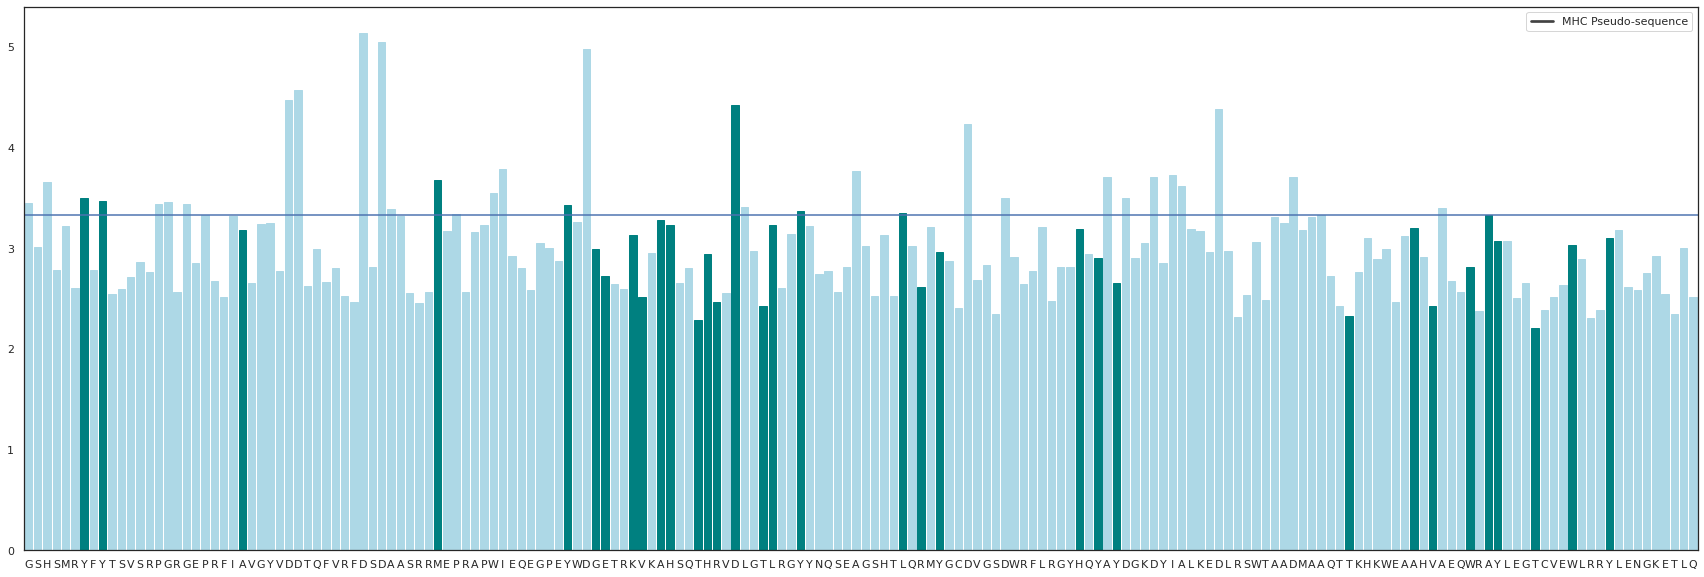



YYAMYGEKVAHTHVDTLYLRYHYYTWAVWAYTWY

GHYYPGGPDDDDAMPWIYDDLYALDDADDIADDA
0.5412286126571841



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 441
HLA: HLA-B*18:01
GSHSMRYFHTSVSRPGRGEPRFISVGYVDGTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQISKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRHLENGKETLQ
threshold: 3.4006970463966835


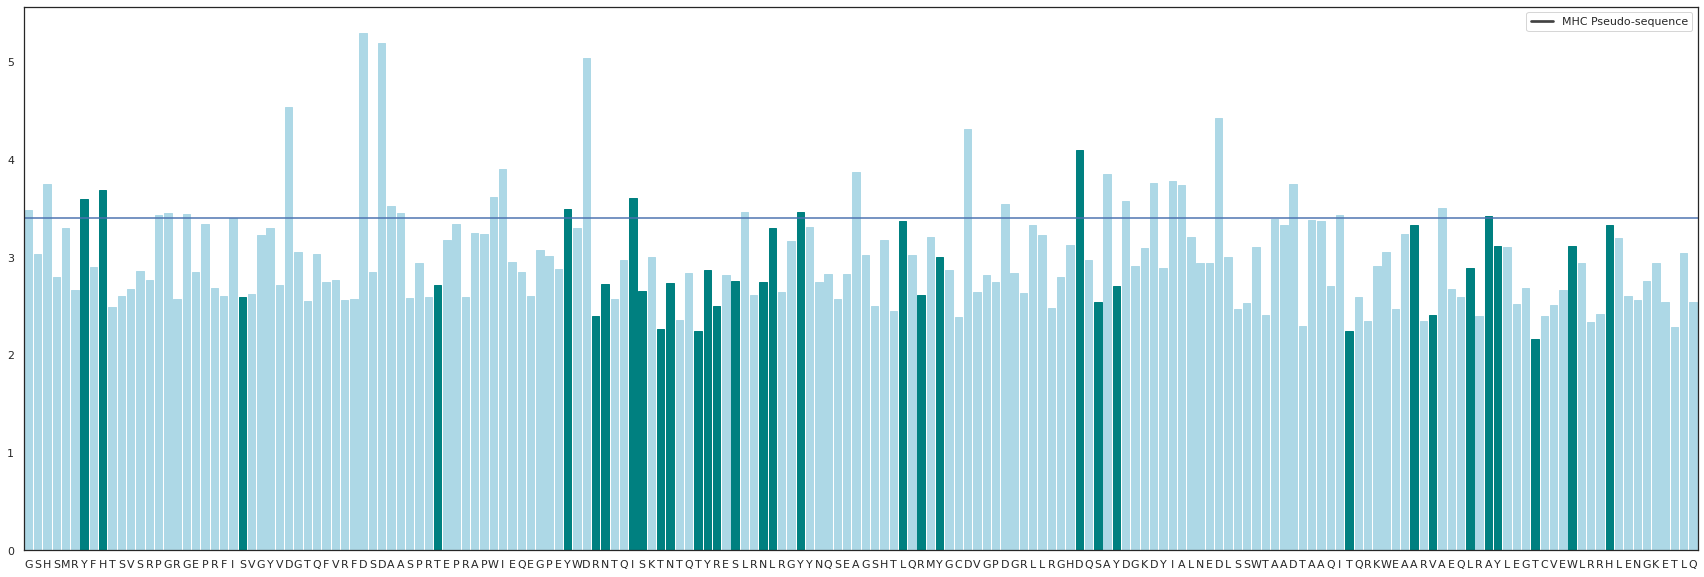



YHSTYRNISTNTYESNLYLRYDSYTWAVLAYTWH

GHYHPGGIDDDAAWIYDILYADDDADDIADDIAA
0.4671201814058956



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 450
HLA: HLA-B*45:01
GSHSMRYFHTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTWQRMYGCDLGPDGRLLRGYNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVESLRRYLENGKETLQ
threshold: 3.4042342122395834


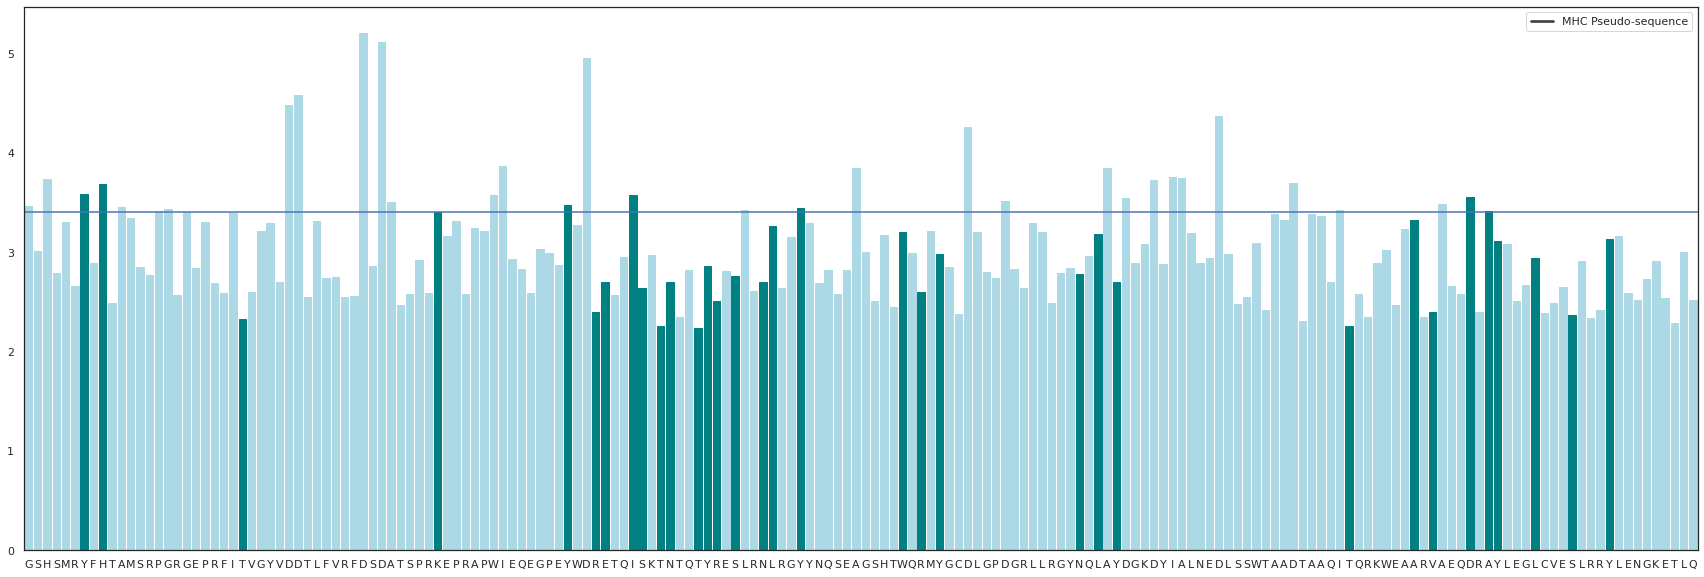



YHTKYREISTNTYESNLYWRYNLYTWAVDAYLSY

GHYHAPGGDDDDAWIYDILYADDADDIADDIADA
0.4714491857349



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 458
HLA: HLA-C*07:04
CSHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEDGSHTFQRMYGCDLGPDGRLLRGYDQFAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQDRAYLEGTCVEWLRRYLENGKKTLQ
threshold: 3.3255124820892465


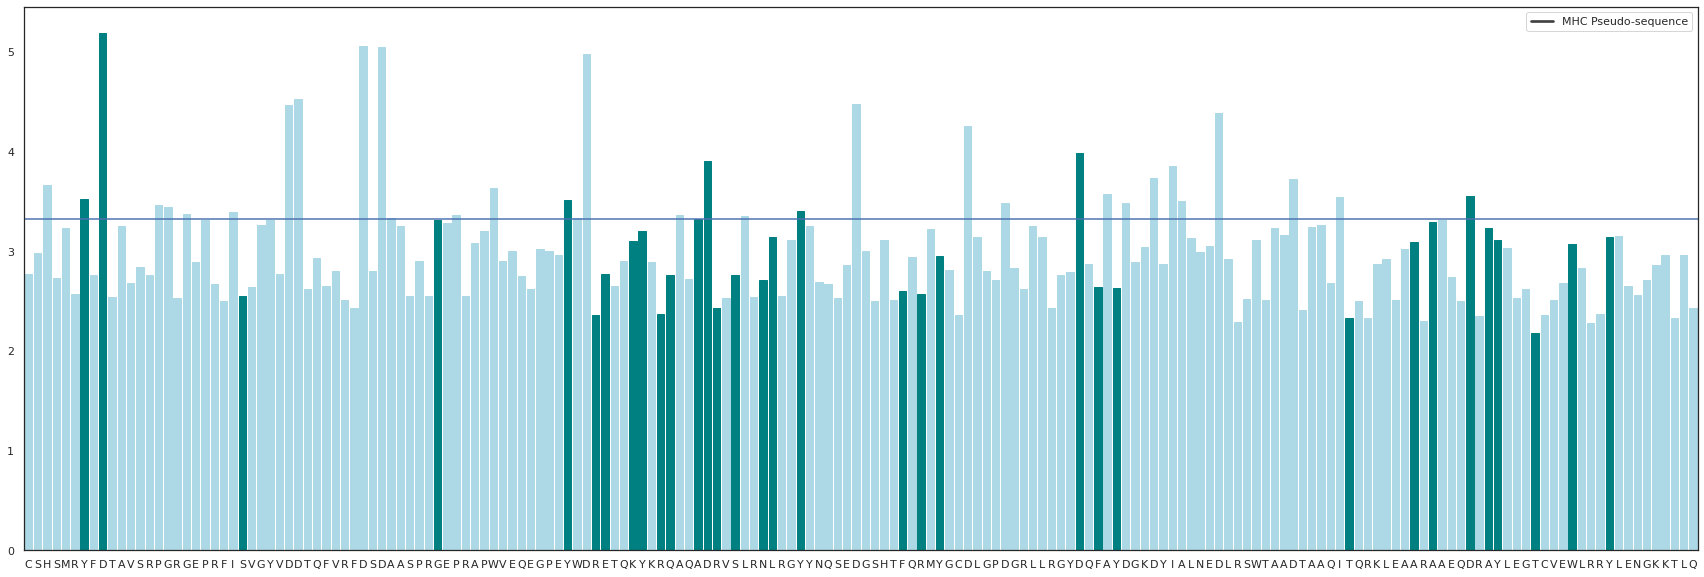



YDSGYREKYRQADVSNLYFRYDFYTLAADAYTWY

HYDPGGIDDDDAPWYWDADLYDDDDADDIADDID
0.541228612657184



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 532
HLA: HLA-B*13:02
GSHSMRYFYTAMSRPGRGEPRFITVGYVDDTQFVRFDSDATSPRMAPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRTALRYYNQSEAGSHTWQTMYGCDLGPDGRLLRGHNQLAYDGKDYIALNEDLSSWTAADTAAQITQLKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.3938302635250235


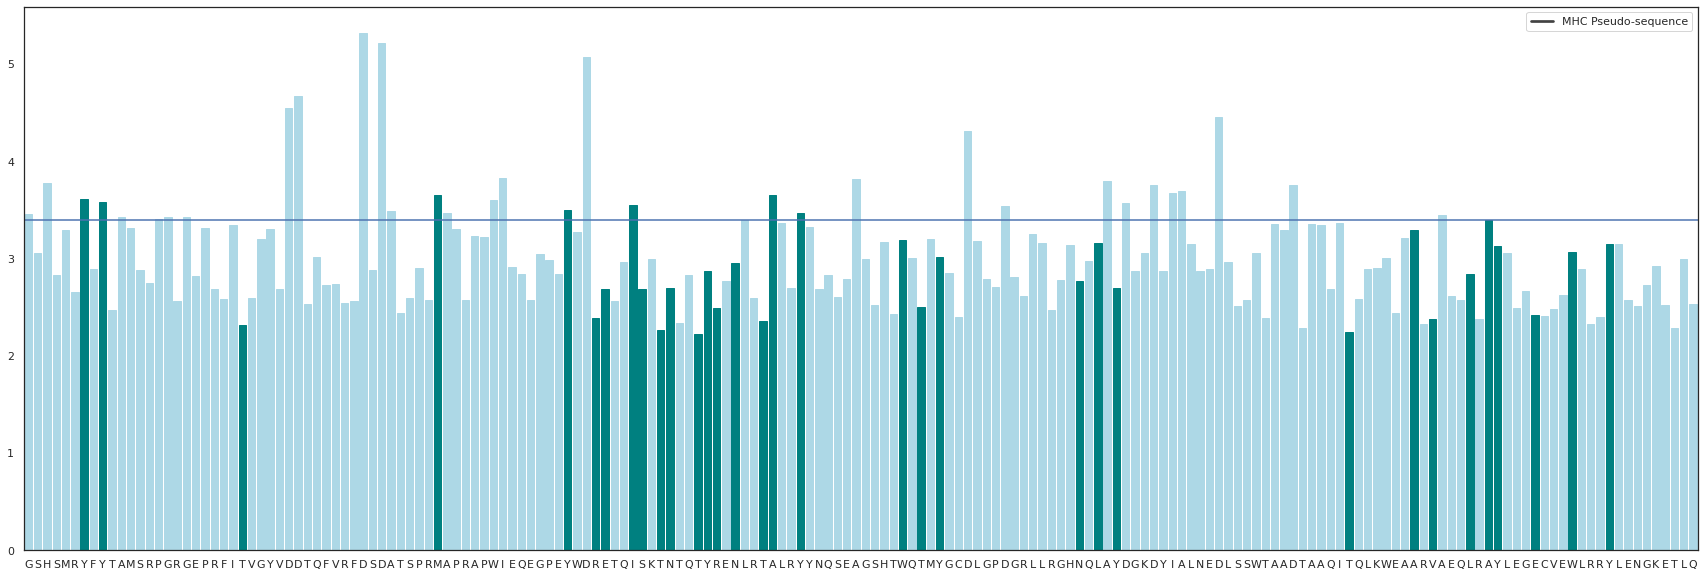



YYTMYREISTNTYENTAYWTYNLYTWAVLAYEWY

GHYYAPGGDDDDAMAWIYDILAYADDADDIADDA
0.45938981653267363



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 510
HLA: HLA-B*27:02
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDRENLRIALRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.3733166264552694


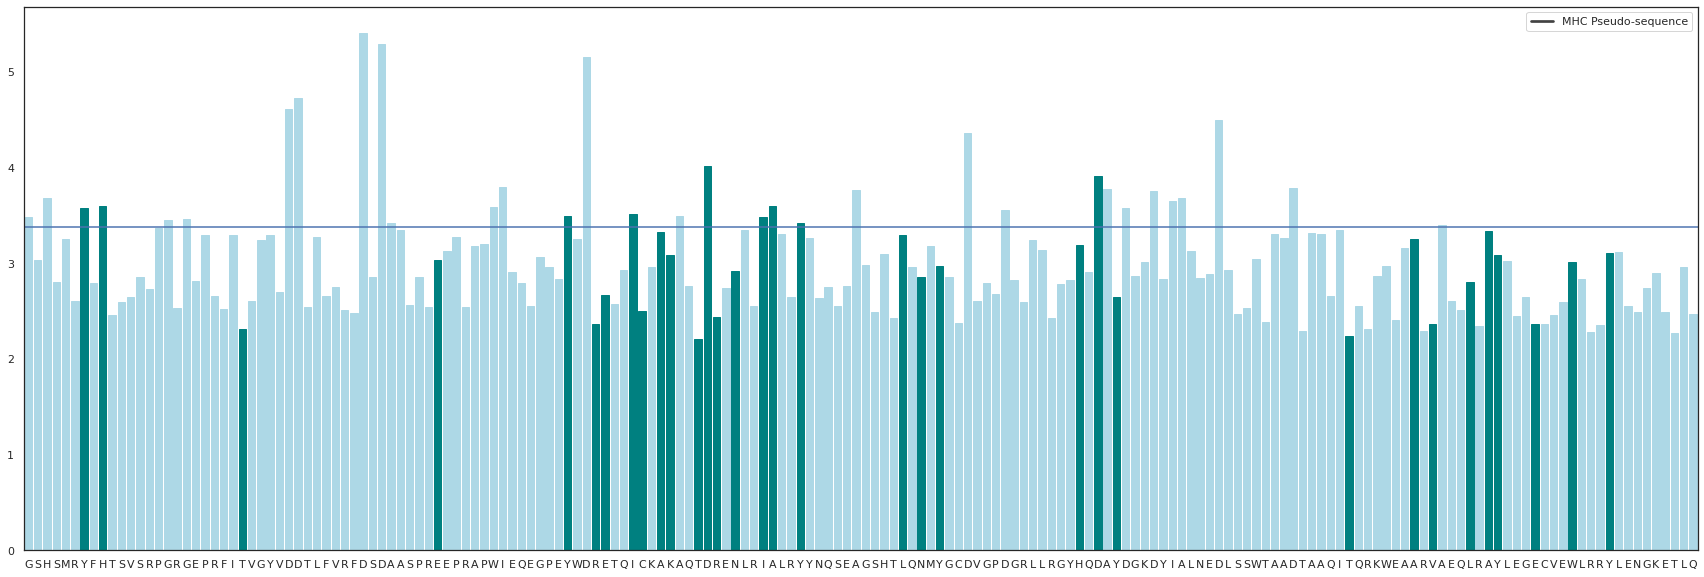



YHTEYREICAKTDENIAYLNYHDYTWAVLAYEWY

GHYHPGGDDDDAWIYDIADIAYADDDADDIADDA
0.5528756957328386



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 524
HLA: HLA-A*02:07
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMCGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3225125611283395


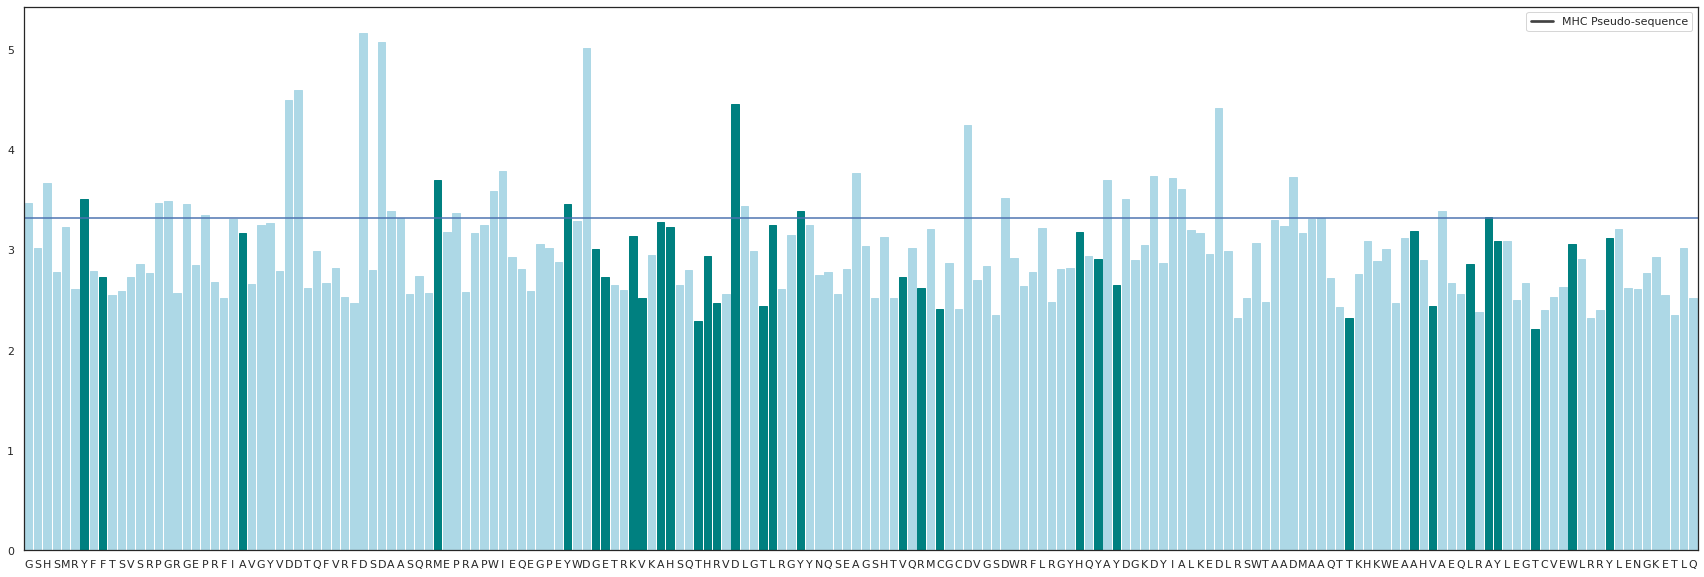



YFAMYGEKVAHTHVDTLYVRCHYYTWAVLAYTWY

GHYPGGPDDDDAAMPWIYDDLYADDADDIADDAA
0.4939187796330654



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 576
HLA: HLA-B*27:01
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTYRENLRTALRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.3643425835503473


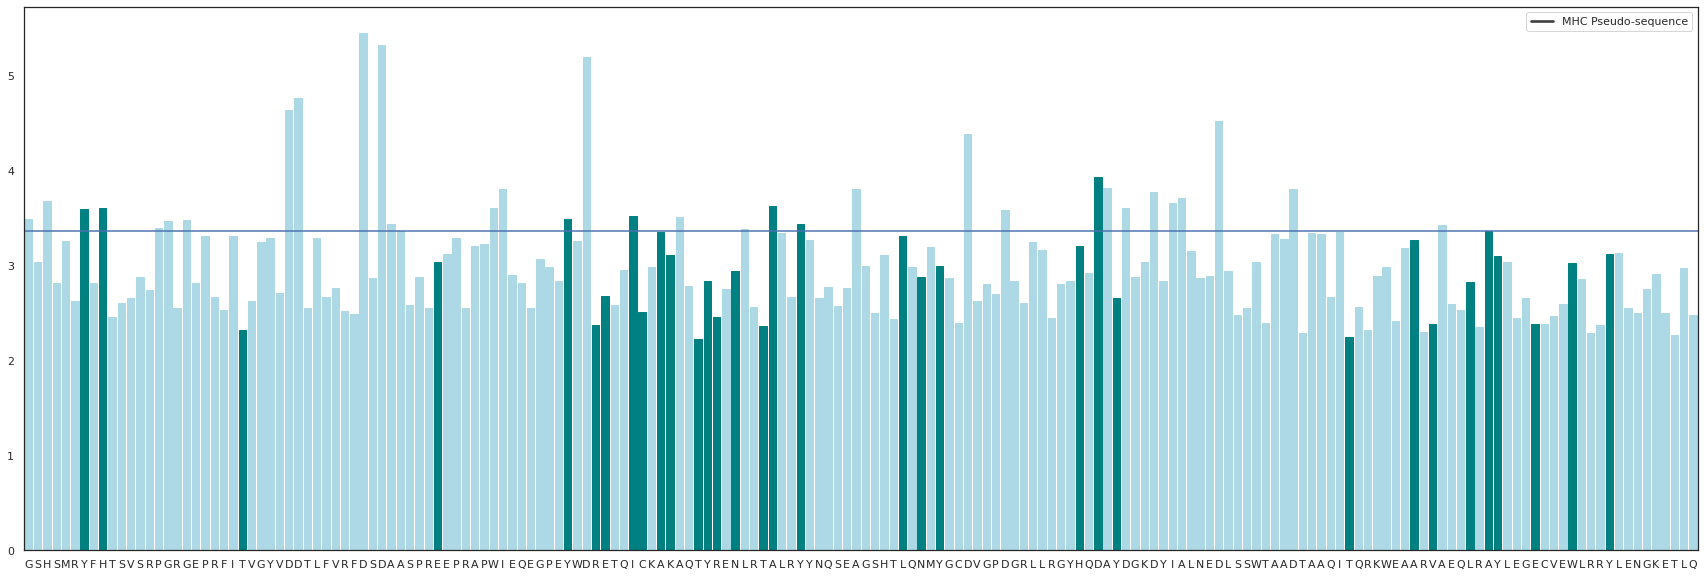



YHTEYREICAKTYENTAYLNYHDYTWAVLAYEWY

GHYHPGGDDDDAAWIYDIALAYADDDADDIADDA
0.5137085137085137



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 591
HLA: HLA-C*07:02
CSHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMSGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.335310831086083


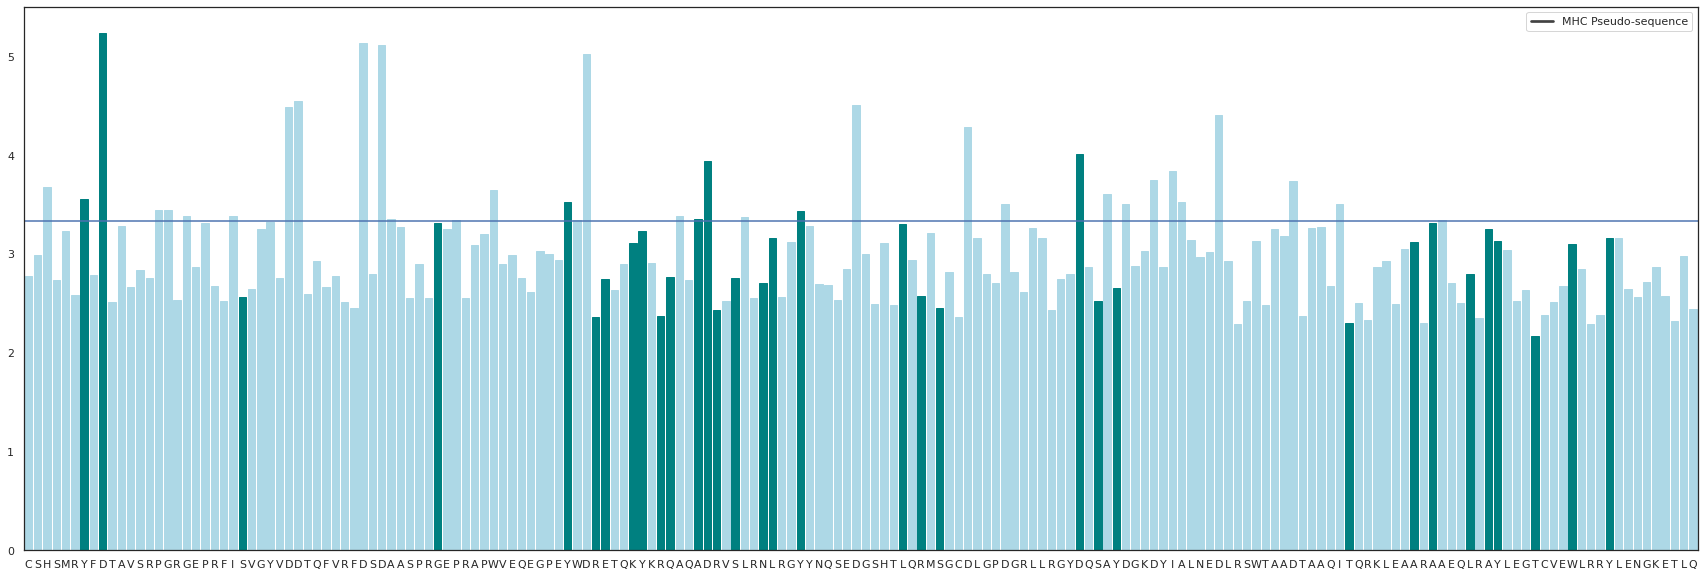



YDSGYREKYRQADVSNLYLRSDSYTLAALAYTWY

HYDPGGIDDDDAPWYDAADLYDDDDADDIADDIA
0.5291692434549579



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 615
HLA: HLA-A*23:01
GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVDGLRRYLENGKETLQ
threshold: 3.3588783822408534


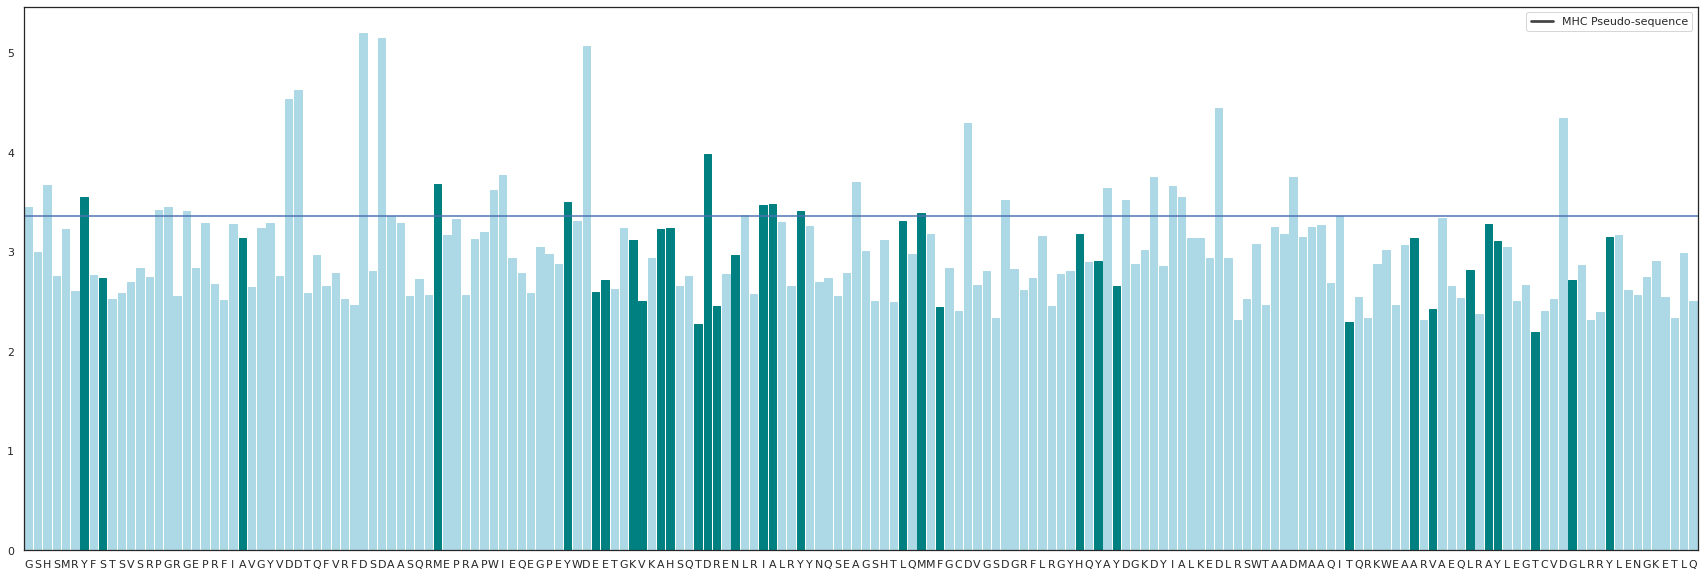



YSAMYEEKVAHTDENIAYLMFHYYTWAVLAYTGY

GHYPGGDDDDAMWIYDDLIAYAMDDADDIADDID
0.5325706039991754



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 637
HLA: HLA-B*38:01
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTYRENLRIALRYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRTYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3996424892072215


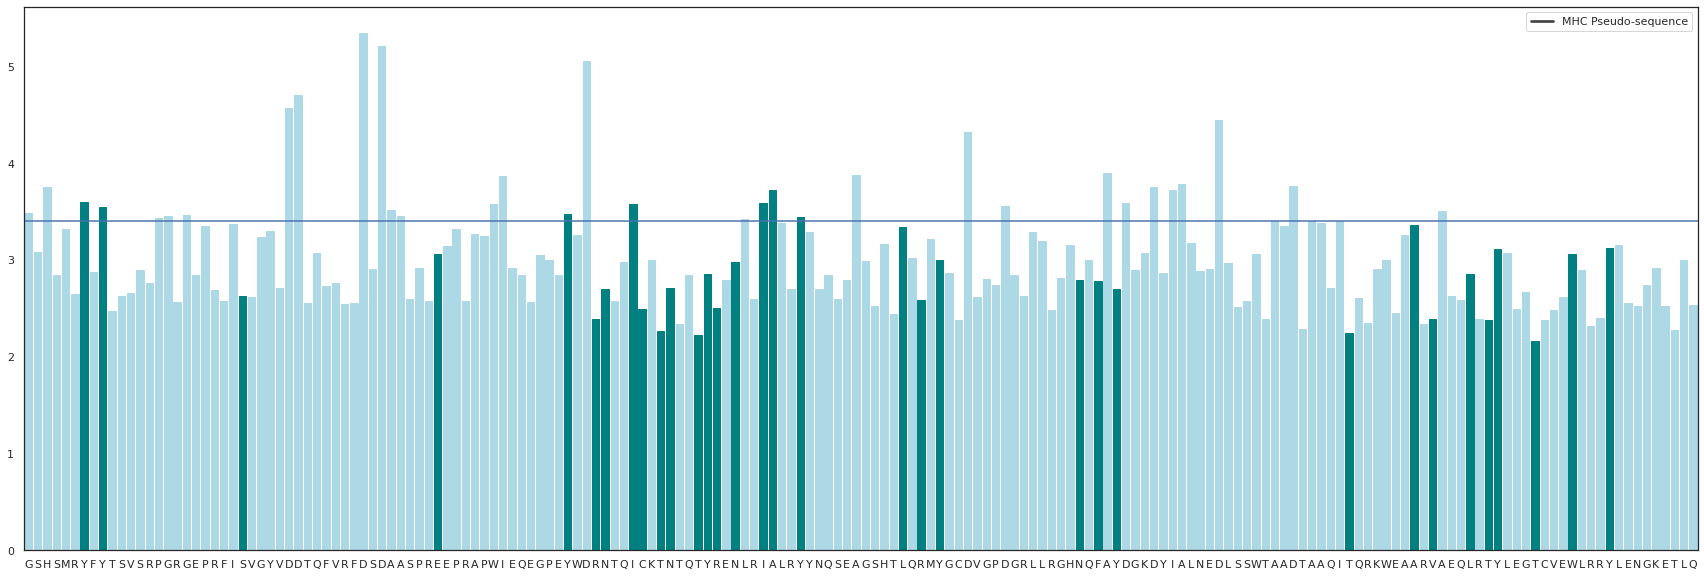



YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY

GHYYPGGDDDDAAWIYDILIAYADDADDIADDIA
0.4557823129251701



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 669
HLA: HLA-B*14:02
GSHSMRYFYTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTDRESLRNLRGYYNQSEAGSHTLQWMYGCDVGPDGRLLRGYNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGTCVEWLRRHLENGKETLQ
threshold: 3.4057485811378925


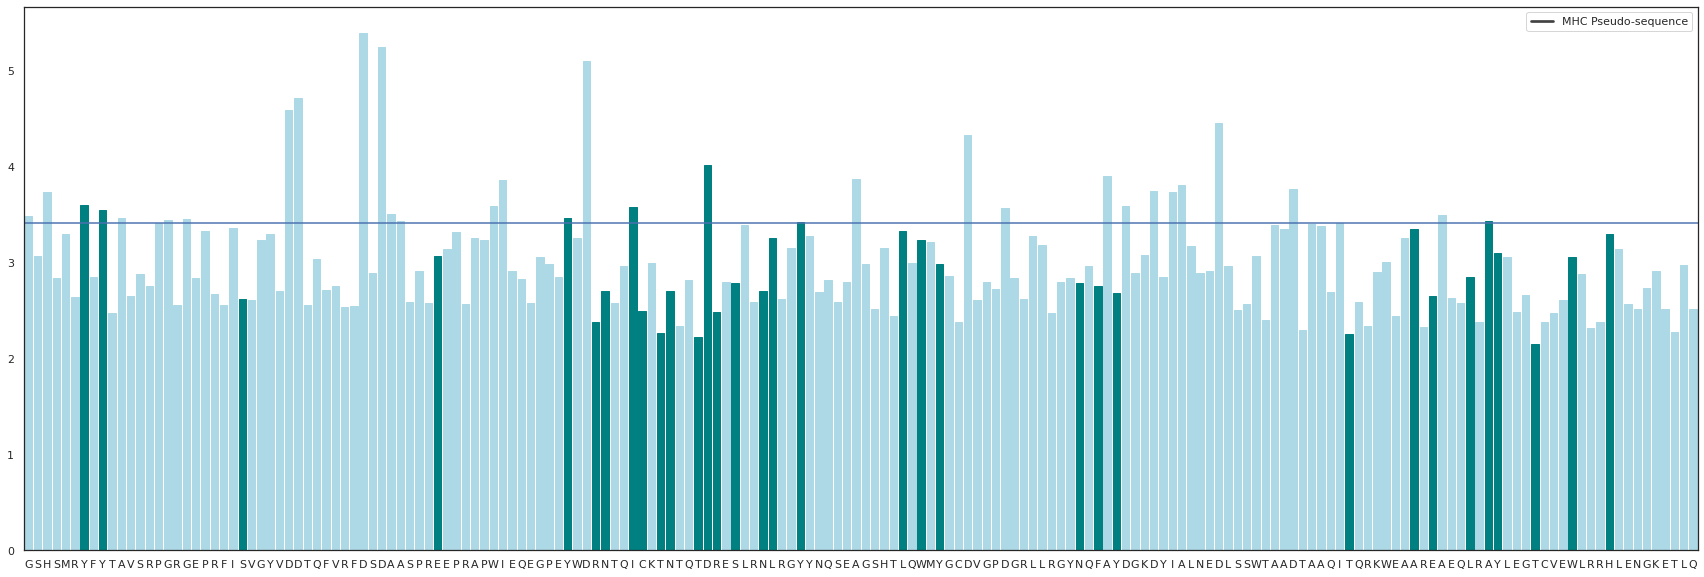



YYSEYRNICTNTDESNLYLWYNFYTWAELAYTWH

GHYYAPGGDDDDAAWIYDIDYADDADDIADDIAA
0.49123891981034834



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 717
HLA: HLA-B*35:03
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRESLRNLRGYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.3596031369857045


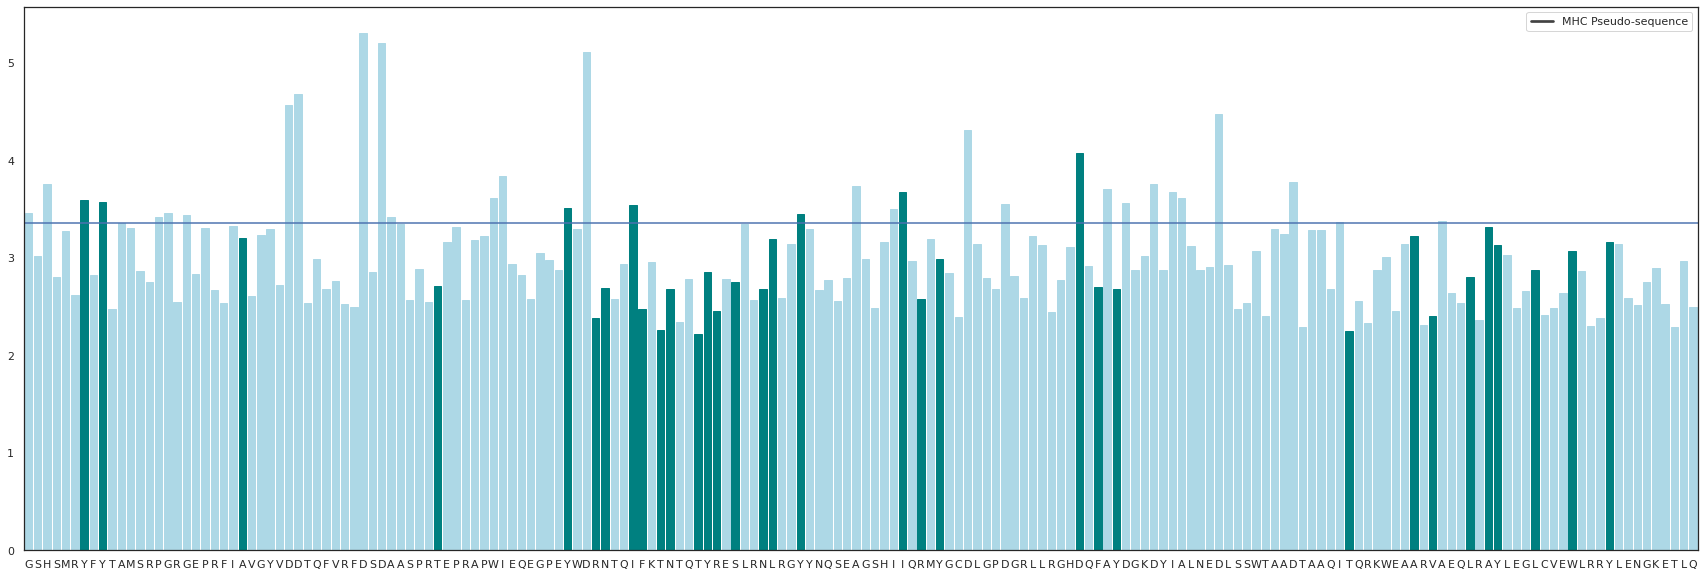



YYATYRNIFTNTYESNLYIRYDFYTWAVLAYLWY

GHYYAPGGDDDDAWIYDIYAIIDDDADDIADDIA
0.4808286951144094



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 724
HLA: HLA-A*32:01
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAHSQTDRESLRIALRYYNQSEAGSHTIQMMYGCDVGPDGRLLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3632761918378797


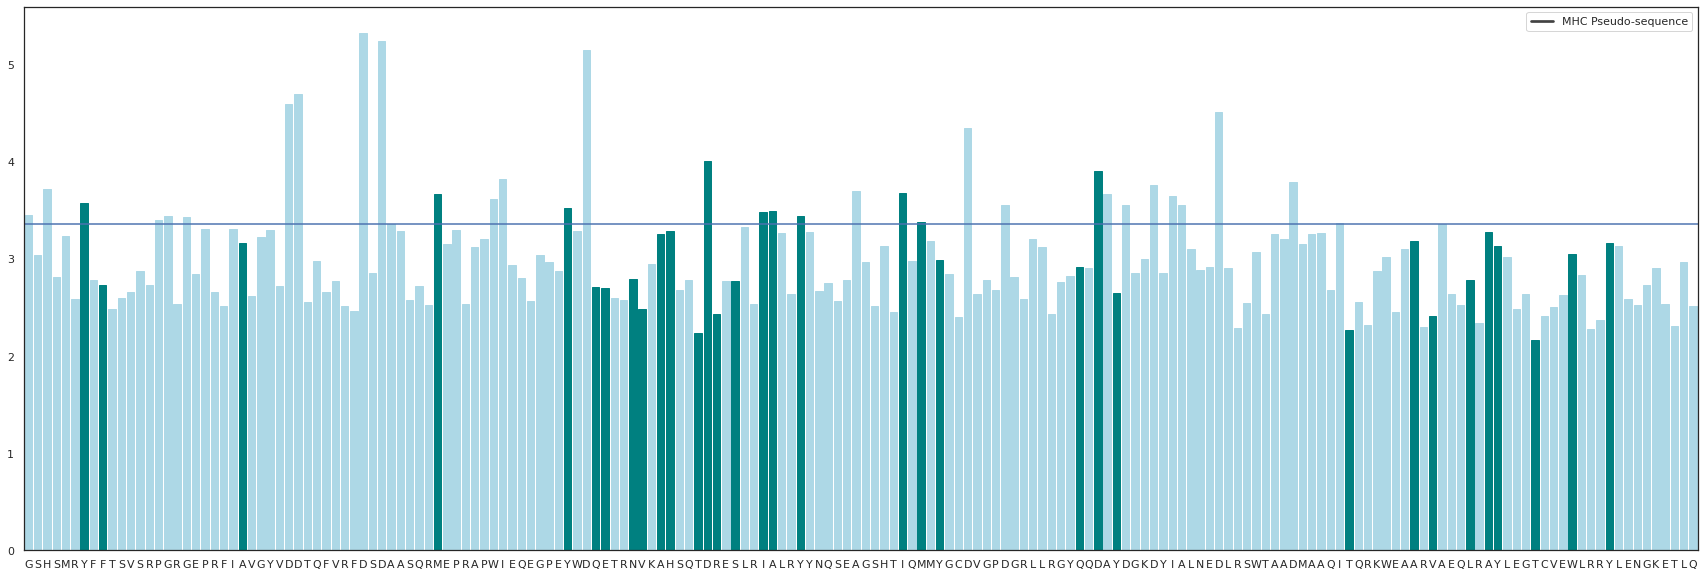



YFAMYQENVAHTDESIAYIMYQDYTWAVLAYTWY

GHYPGGDDDDAMWIYDDIAYAIMDDDADDIADDI
0.5716347144918574



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 714
HLA: HLA-C*16:01
CSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARAAEQQRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3347773191307772


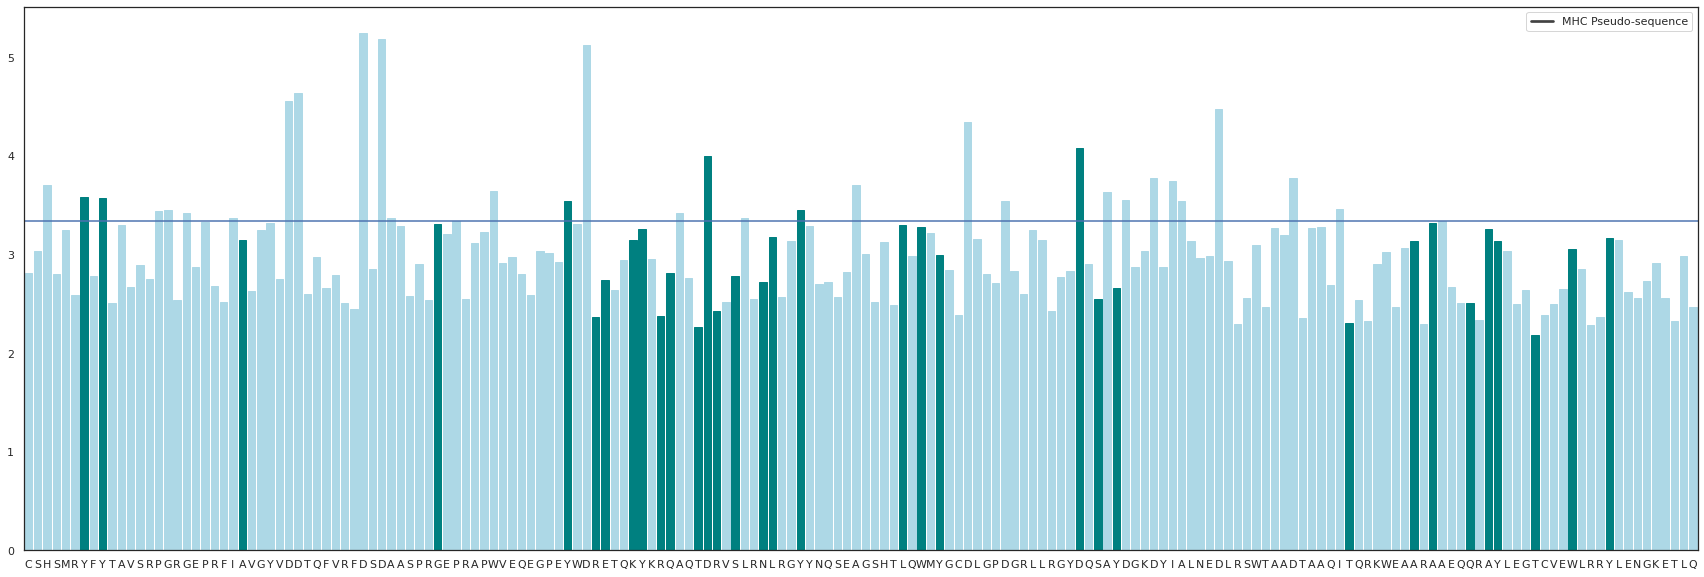



YYAGYREKYRQTDVSNLYLWYDSYTWAAQAYTWY

HYYPGGPIDDDDAPWYDADLYADDDADDIADDIA
0.5429808286951143



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 767
HLA: HLA-B*37:01
GSHSMRYFHTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRETQISKTNTQTYREDLRTLLRYYNQSEAGSHTIQRMSGCDVGPDGRLLRGYNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.4181059398427314


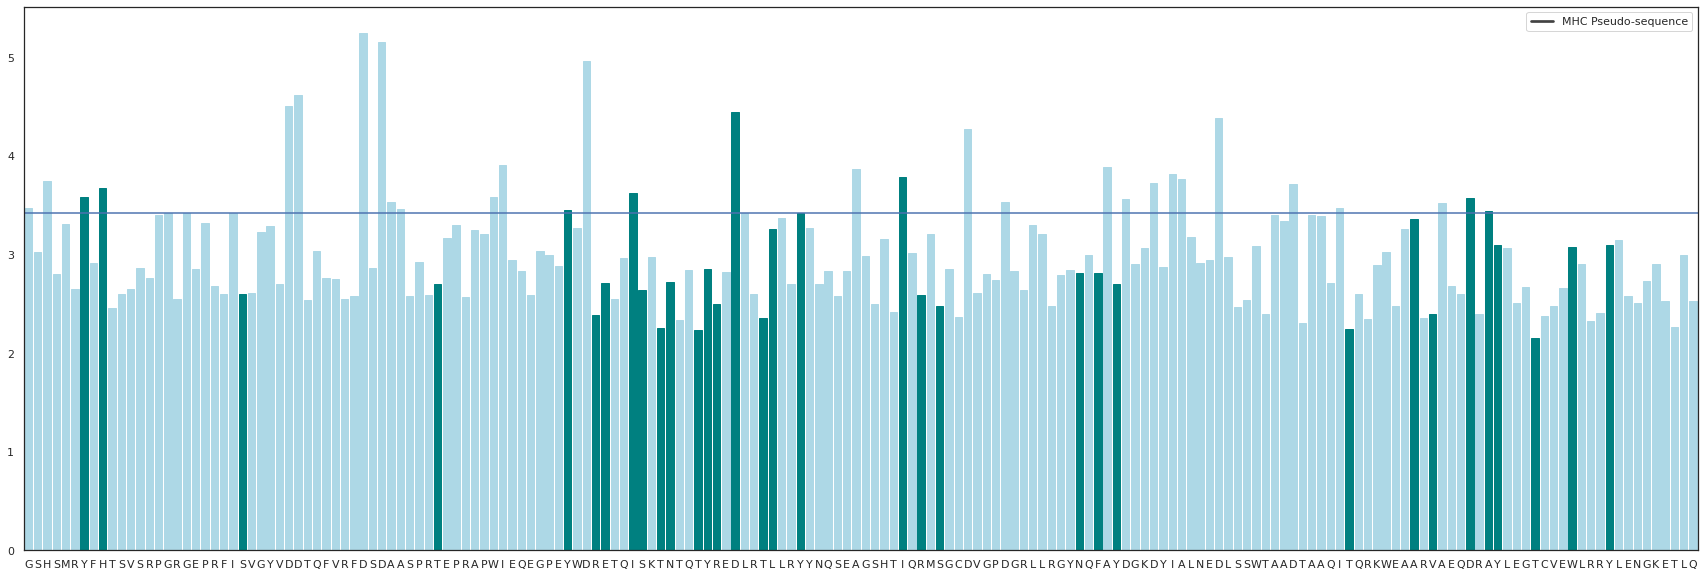



YHSTYREISTNTYEDTLYIRSNFYTWAVDAYTWY

GHYHGIDDDDAAWIYDIDYAIDDADDIADDIADA
0.4623788909503195



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 753
HLA: HLA-C*07:01
CSHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3344784922808763


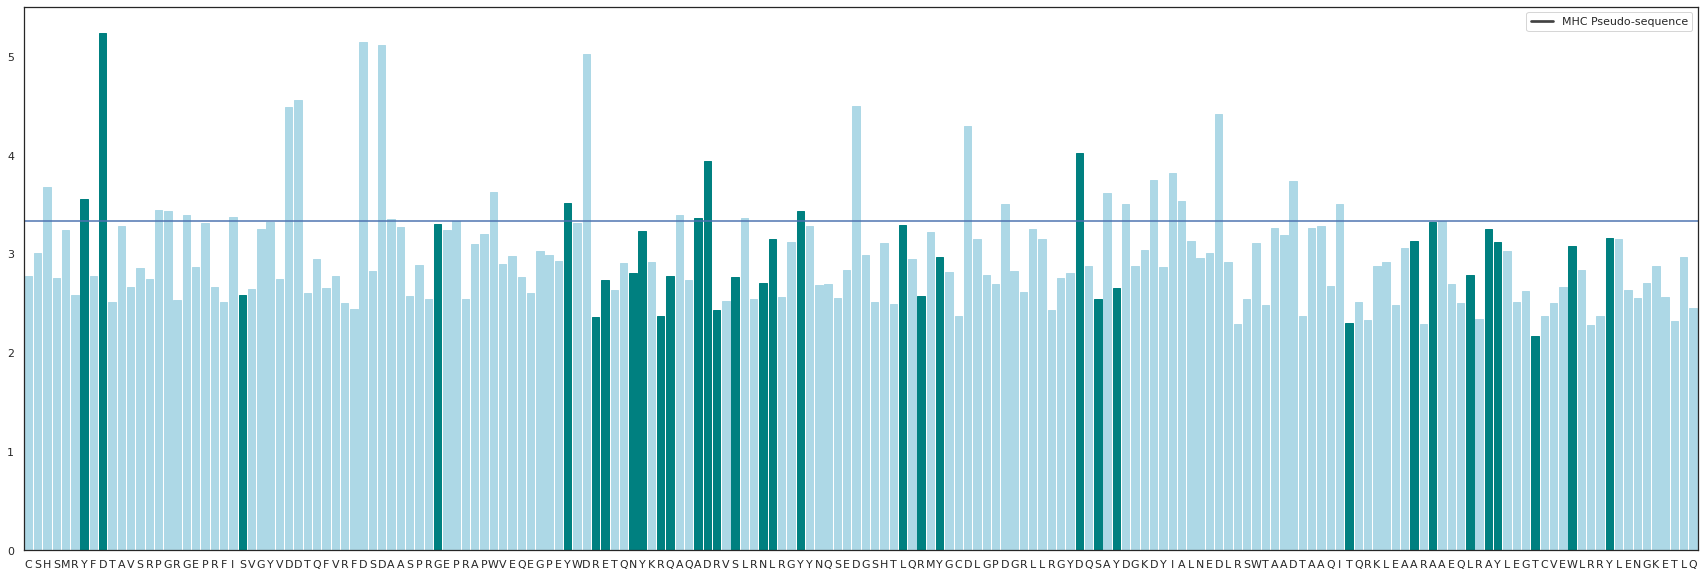



YDSGYRENYRQADVSNLYLRYDSYTLAALAYTWY

HYDPGGIDDDDAPWYDAADLYDDDDADDIADDIA
0.5401978973407544



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 825
HLA: HLA-B*49:01
GSHSMRYFHTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRIALRYYNQSEAGSHTWQRMYGCDLGPDGRLLRGYNQLAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.381590613162879


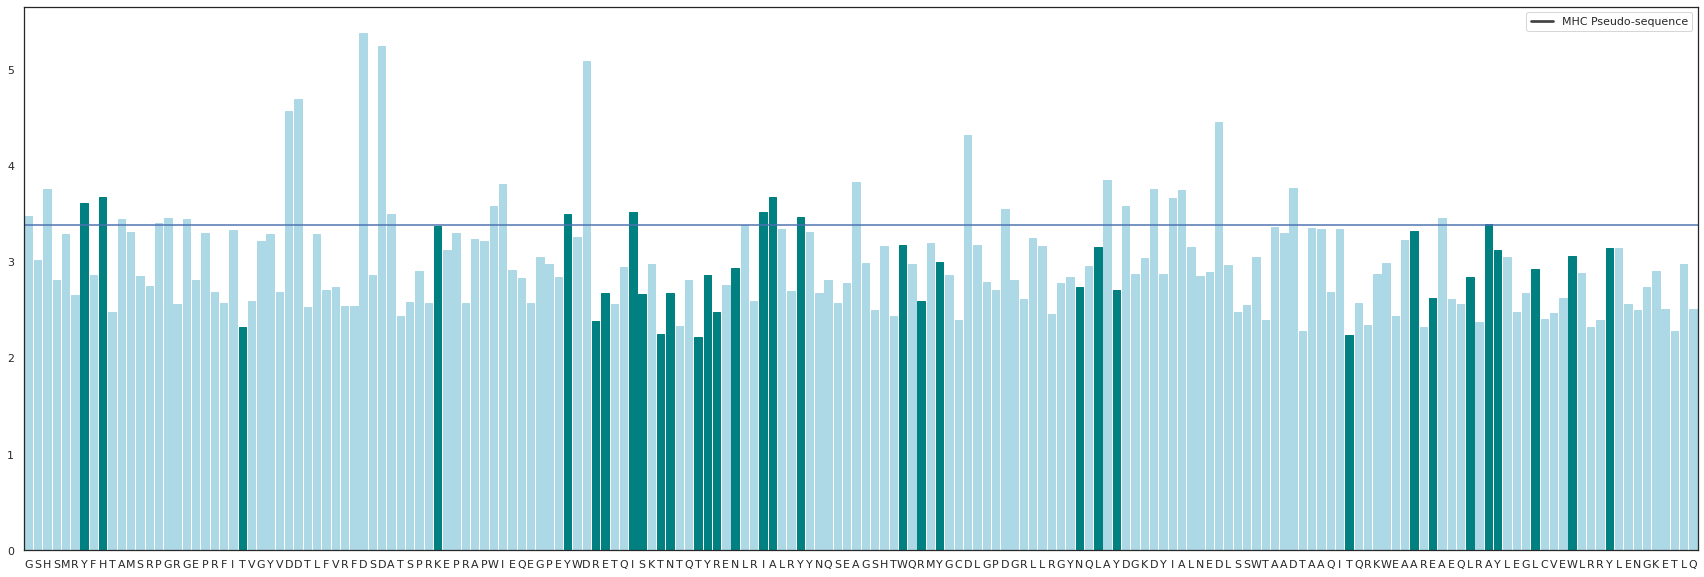



YHTKYREISTNTYENIAYWRYNLYTWAELAYLWY

GHYHAPGGDDDDAWIYDILIAYADDADDIADDAA
0.5114409400123686



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 810
HLA: HLA-B*39:01
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTDRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRTYLEGTCVEWLRRYLENGKETLQ
threshold: 3.4262909312307097


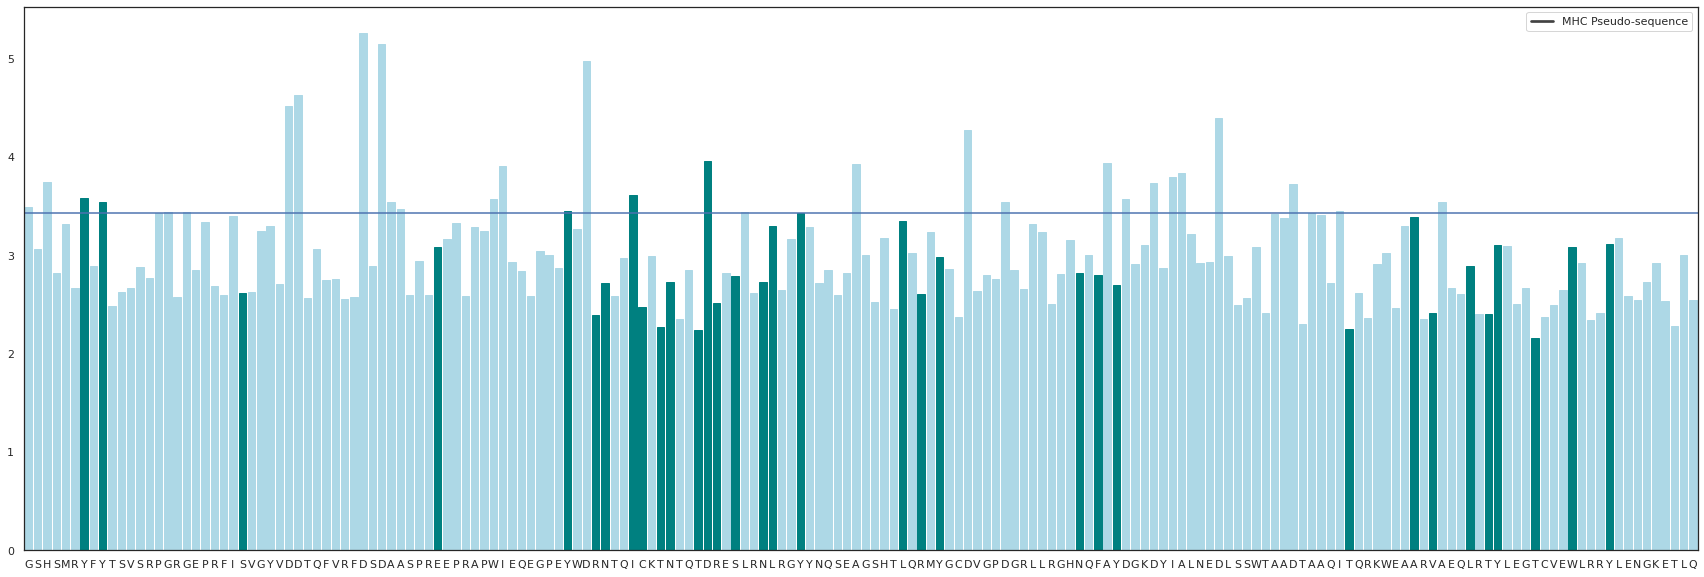



YYSEYRNICTNTDESNLYLRYNFYTWAVLTYTWY

GHYYPGGDDDDAAWIYDIDLYADDADDIADDAIA
0.44537208822923113



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 793
HLA: HLA-A*02:03
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWETAHEAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3629198110419294


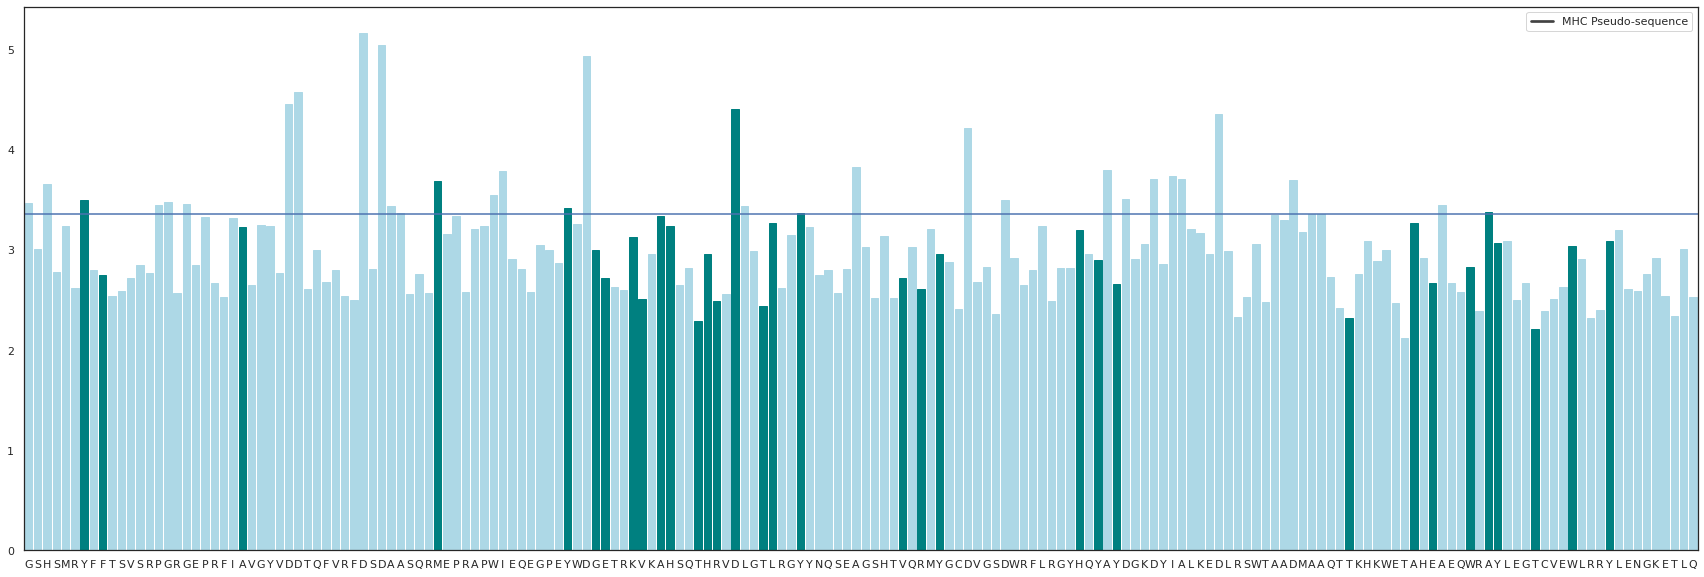



YFAMYGEKVAHTHVDTLYVRYHYYTWAEWAYTWY

GHYPGGDDDDAAMWIYDDLYADDADDIADDAAAA
0.5223665223665225



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 843
HLA: HLA-C*03:04
GSHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQ
threshold: 3.350360331869069


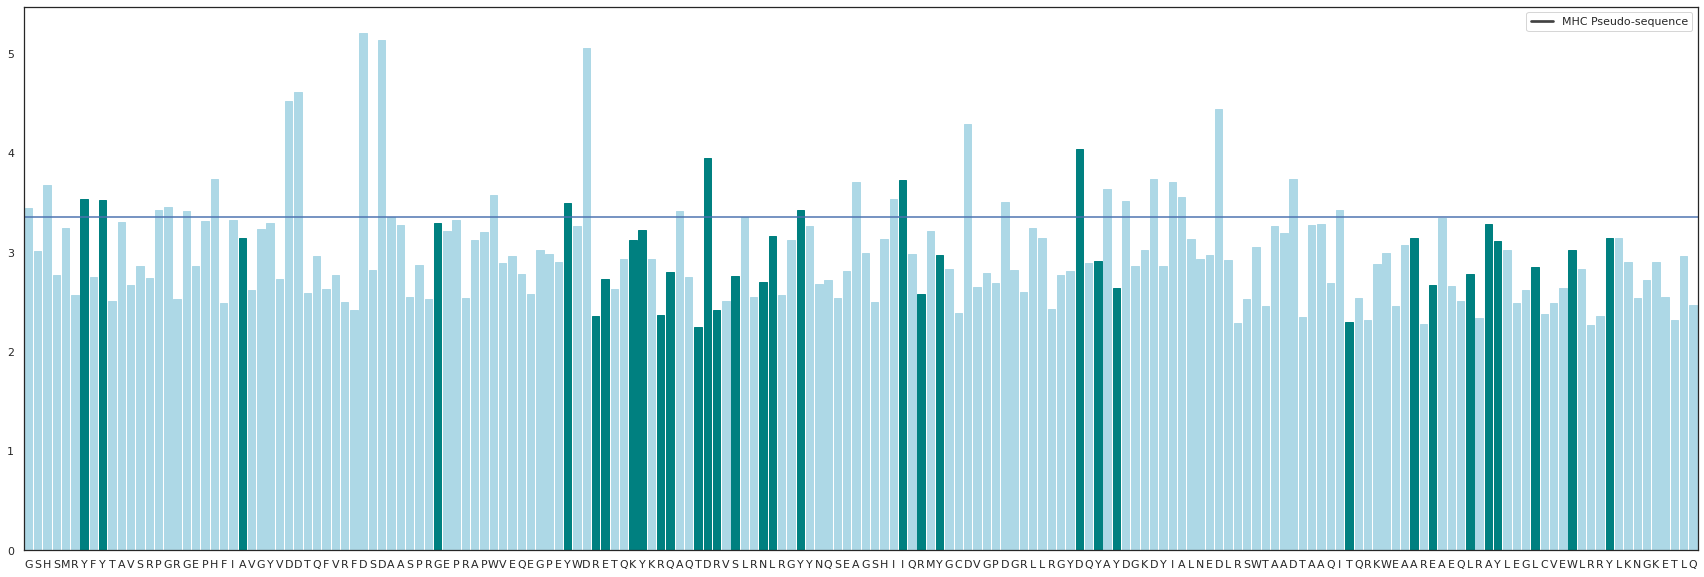



YYAGYREKYRQTDVSNLYIRYDYYTWAELAYLWY

GHYYPGGHDDDDAWYDADLYAIIDDDADDIADDI
0.5361781076066792



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 764
HLA: HLA-A*02:06
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3257705129253927


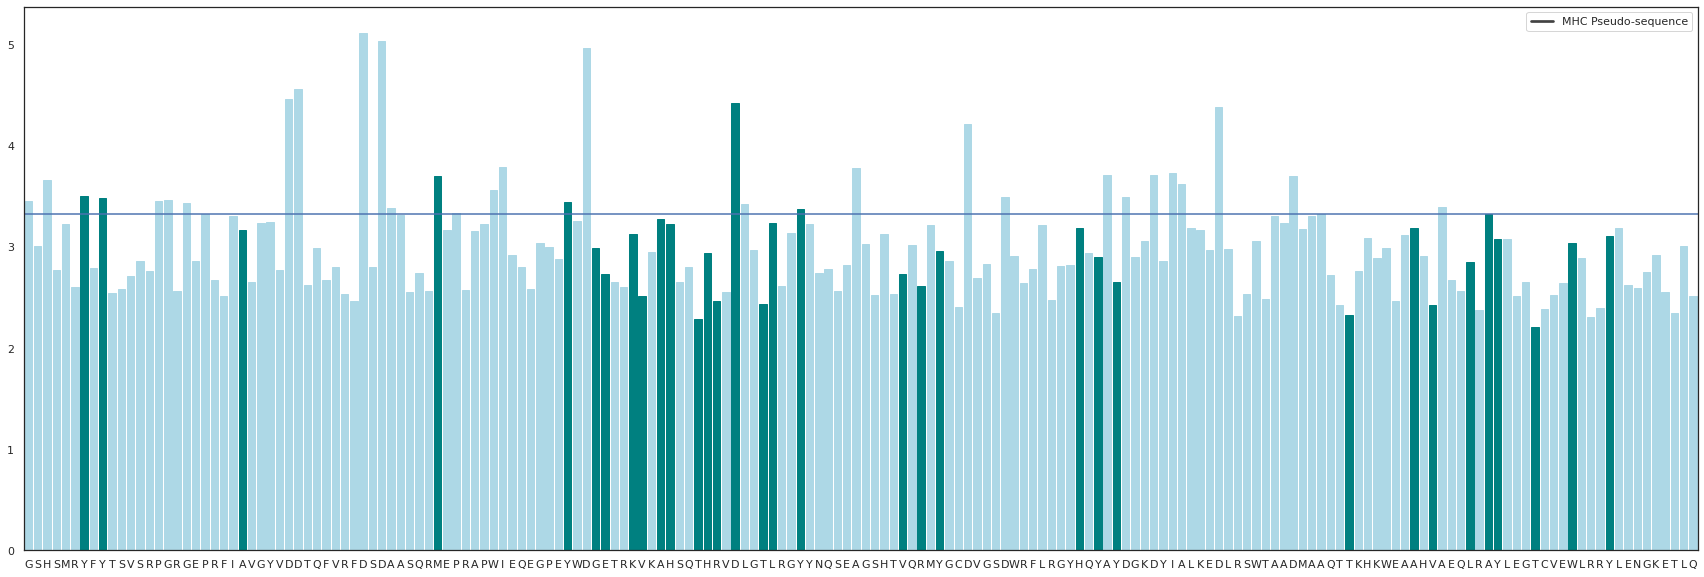



YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY

GHYYPGGPDDDDAMPWIYDDLYADDADDIADDAA
0.5256648113790972



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 818
HLA: HLA-B*57:03
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDGETRNMKASAQTYRENLRIALRYYNQSEAGSHIIQVMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.3305846123357274


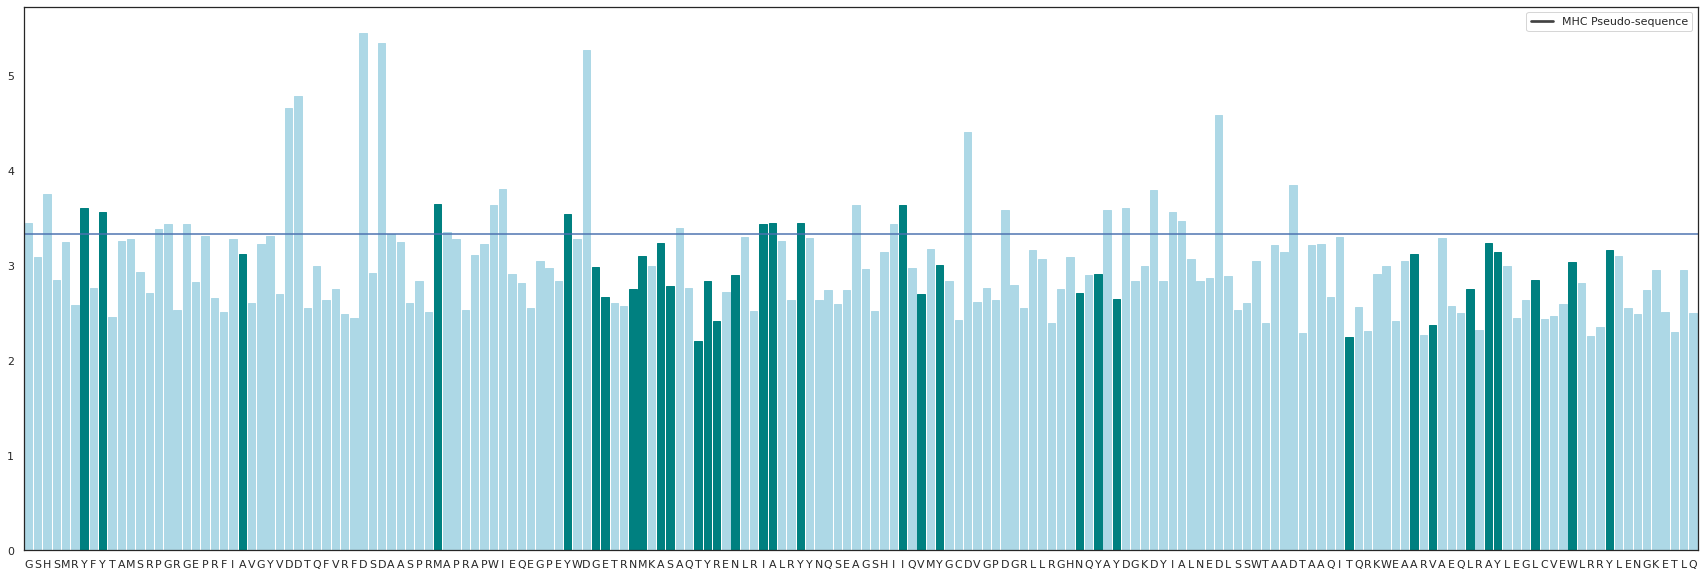



YYAMYGENMASTYENIAYIVYNYYTWAVLAYLWY

GHYYPGGDDDDAMAWIYDAIAYAIIDDADDIADD
0.5552463409606266



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 889
HLA: HLA-C*03:03
GSHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEARSHIIQRMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQ
threshold: 3.3452373629077616


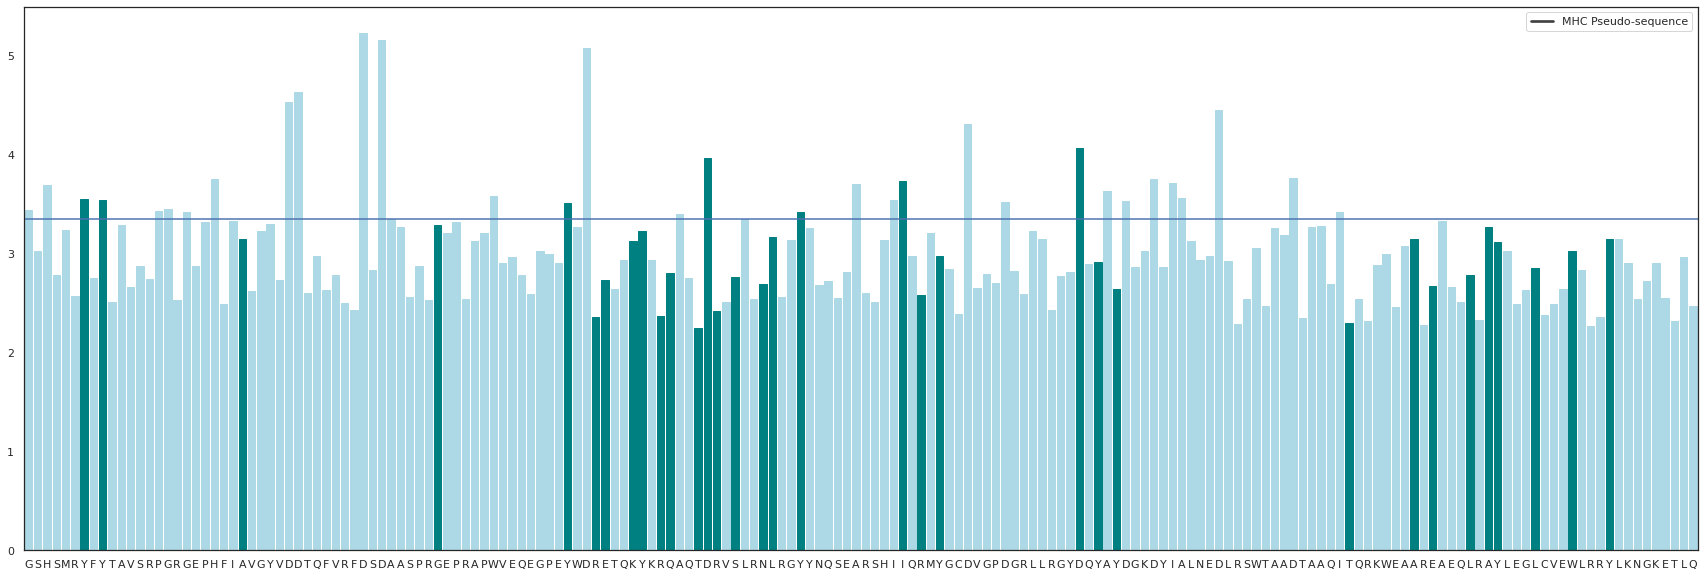



YYAGYREKYRQTDVSNLYIRYDYYTWAELAYLWY

GHYYPGGHDDDDAWYDADLYAIIDDDADDIADDI
0.5372088229231087



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 887
HLA: HLA-C*05:01
CSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKKTLQ
threshold: 3.3220357970159244


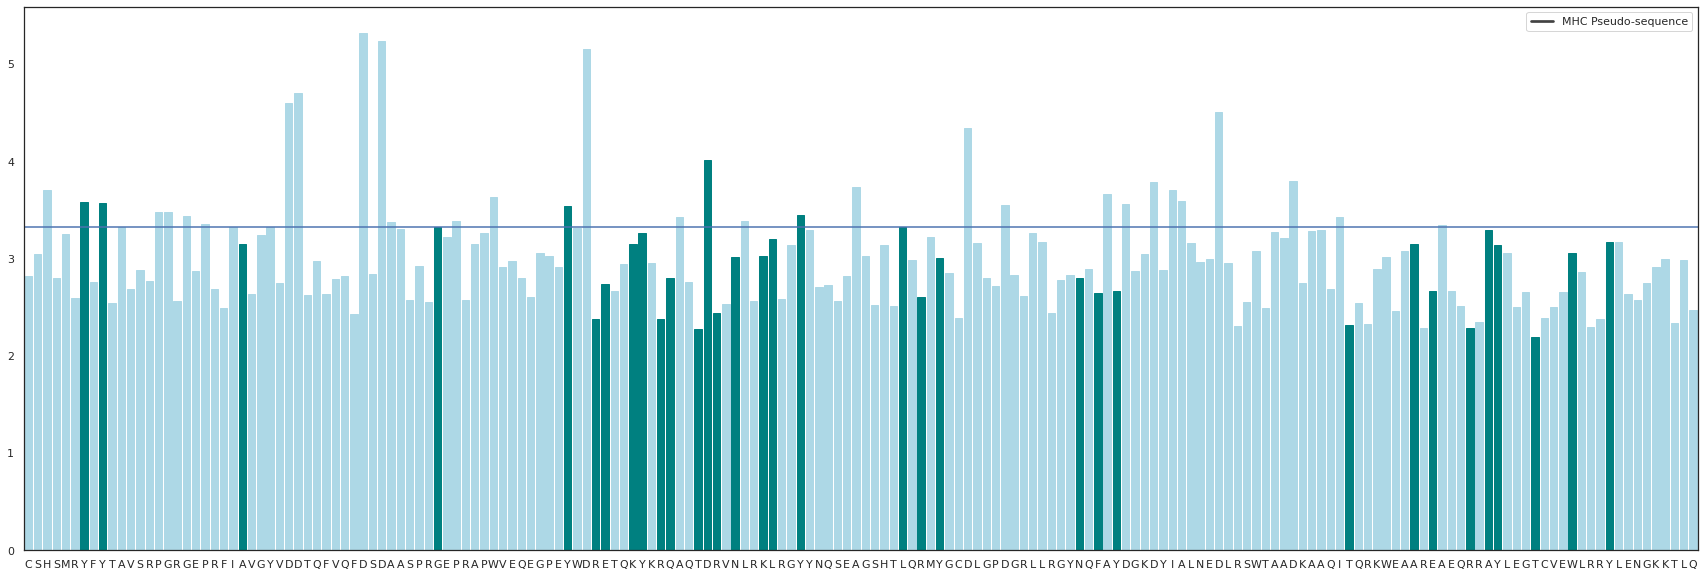



YYAGYREKYRQTDVNKLYLRYNFYTWAERAYTWY

HYYPGGPDDDDAGPWYDADLYALDDADDIADDIA
0.5022675736961452



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 909
HLA: HLA-B*40:01
GSHSMRYFHTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQISQRKLEAARVAEQLRAYLEGECVEWLRRYLENGKDKLE
threshold: 3.3963627075598186


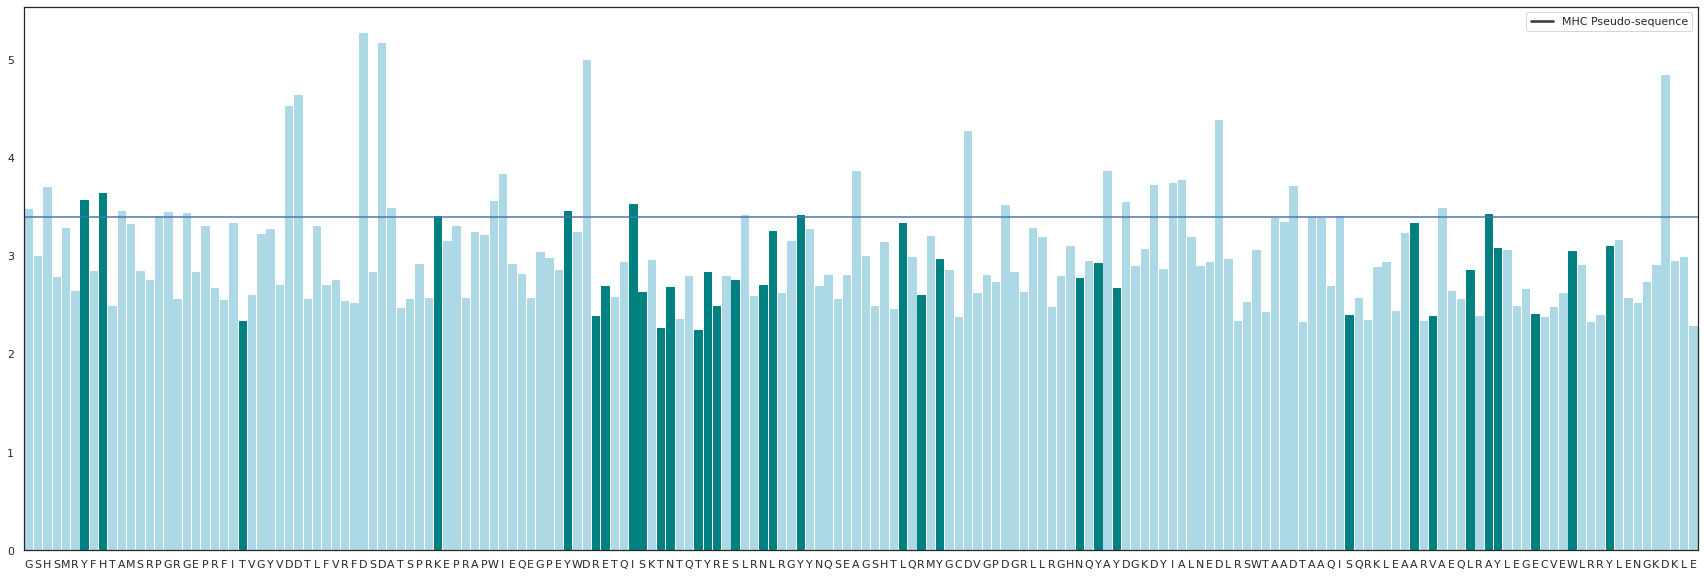



YHTKYREISTNTYESNLYLRYNYYSLAVLAYEWY

GHYHAPGGDDDDAKWIYDILYADDADDIADDAAD
0.45743145743145736



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 930
HLA: HLA-B*58:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDGETRNMKASAQTYRENLRIALRYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.321603295110887


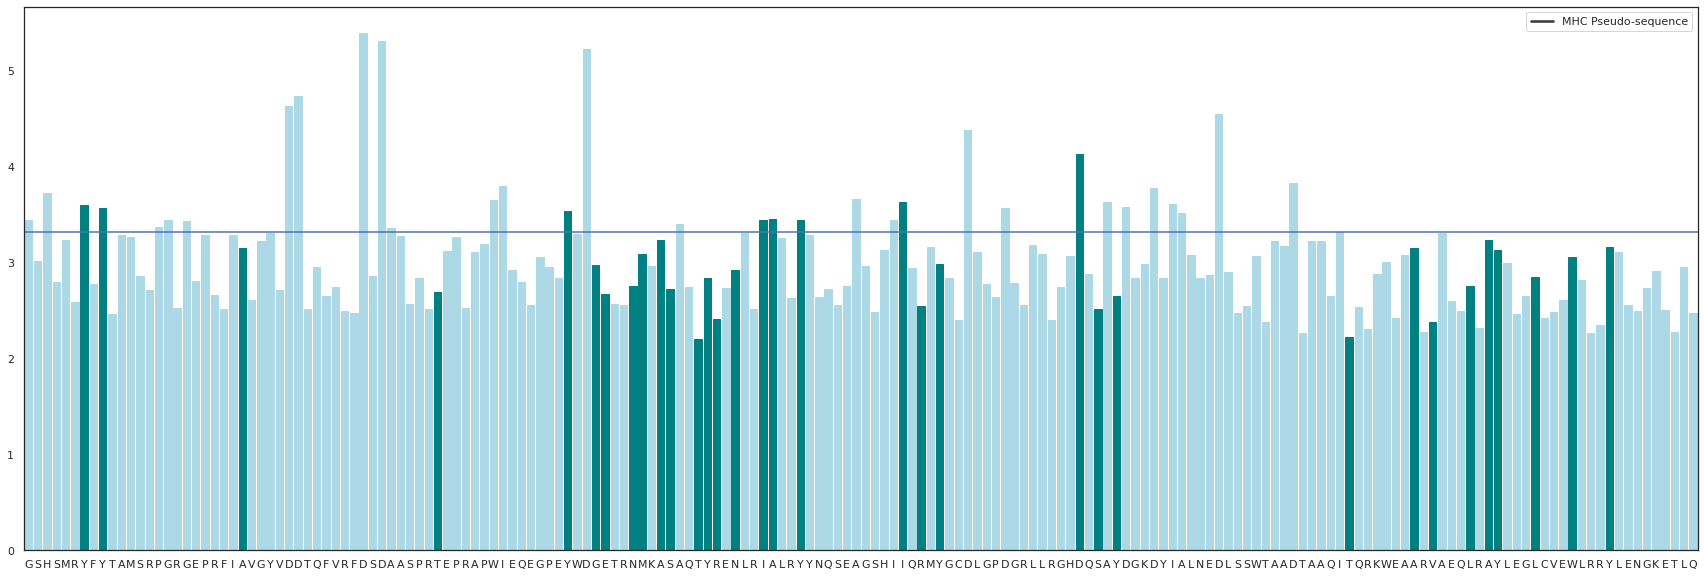



YYATYGENMASTYENIAYIRYDSYTWAVLAYLWY

GHYYPGGDDDDAWIYDAIAYAIIDDDADDIADDI
0.541125541125541



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 915
HLA: HLA-B*27:09
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDREDLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQHAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.3759605532786887


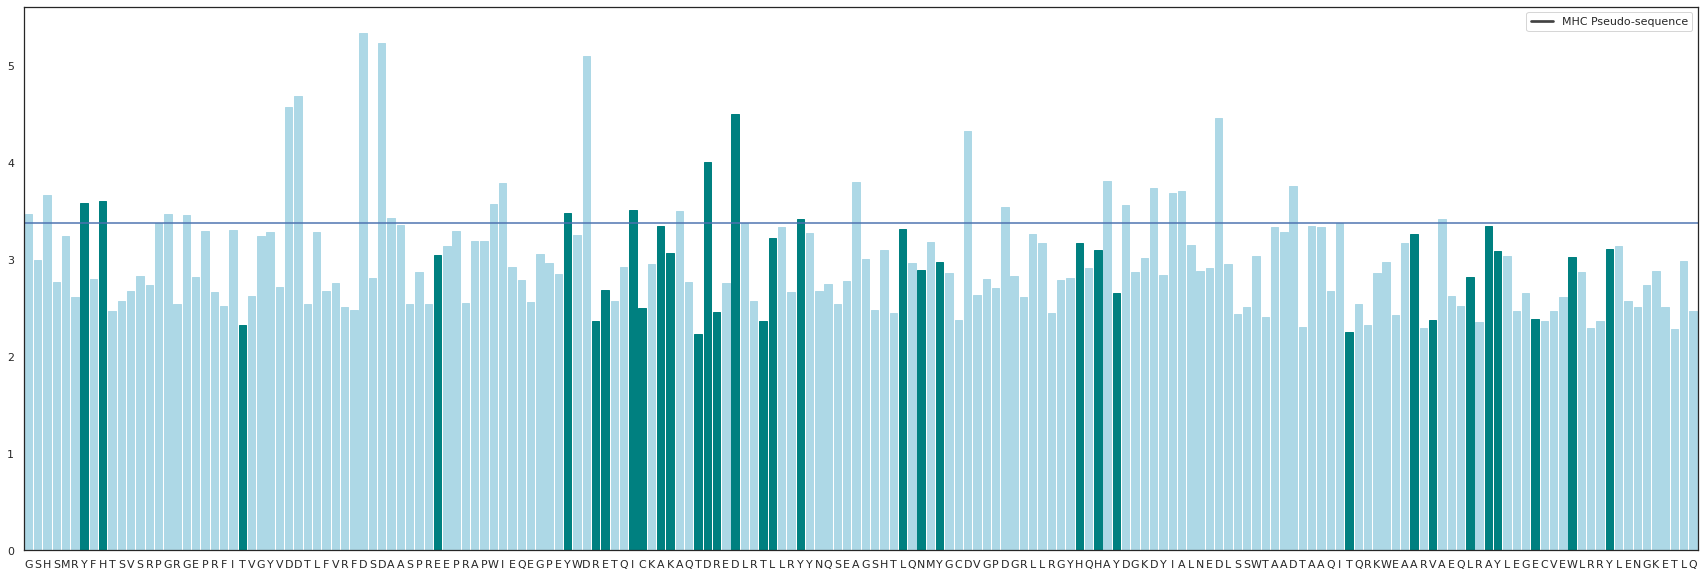



YHTEYREICAKTDEDTLYLNYHHYTWAVLAYEWY

GHYHPGGDDDDAWIYDIADDLYADDADDIADDIA
0.5272108843537415



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 921
HLA: HLA-A*31:01
GSHSMRYFTTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQERPEYWDQETRNVKAHSQIDRVDLGTLRGYYNQSEAGSHTIQMMYGCDVGSDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3892781177897664


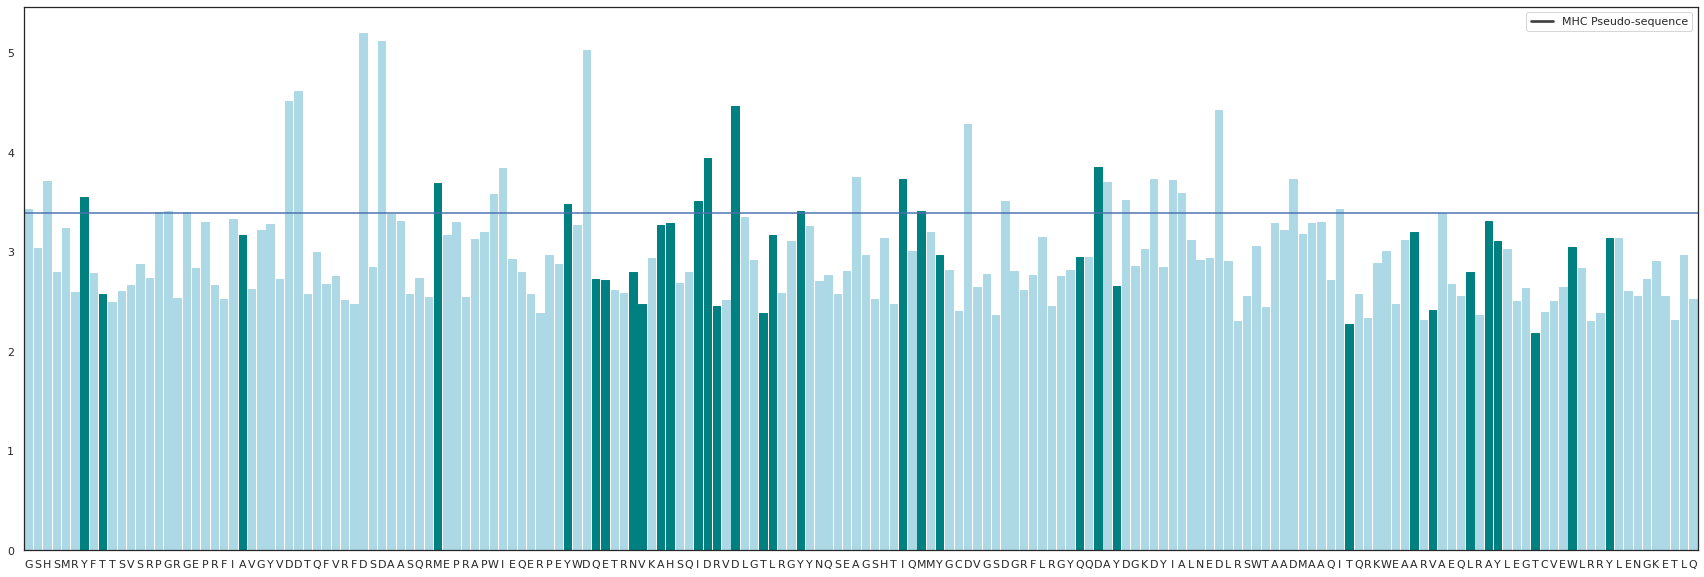



YTAMYQENVAHIDVDTLYIMYQDYTWAVLAYTWY

GHYPGGDDDDMWIYDIDDYAIMDDDADDIADDIA
0.5842094413522984



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 973
HLA: HLA-C*02:02
CSHSMRYFYTAVSRPSRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.325190545108556


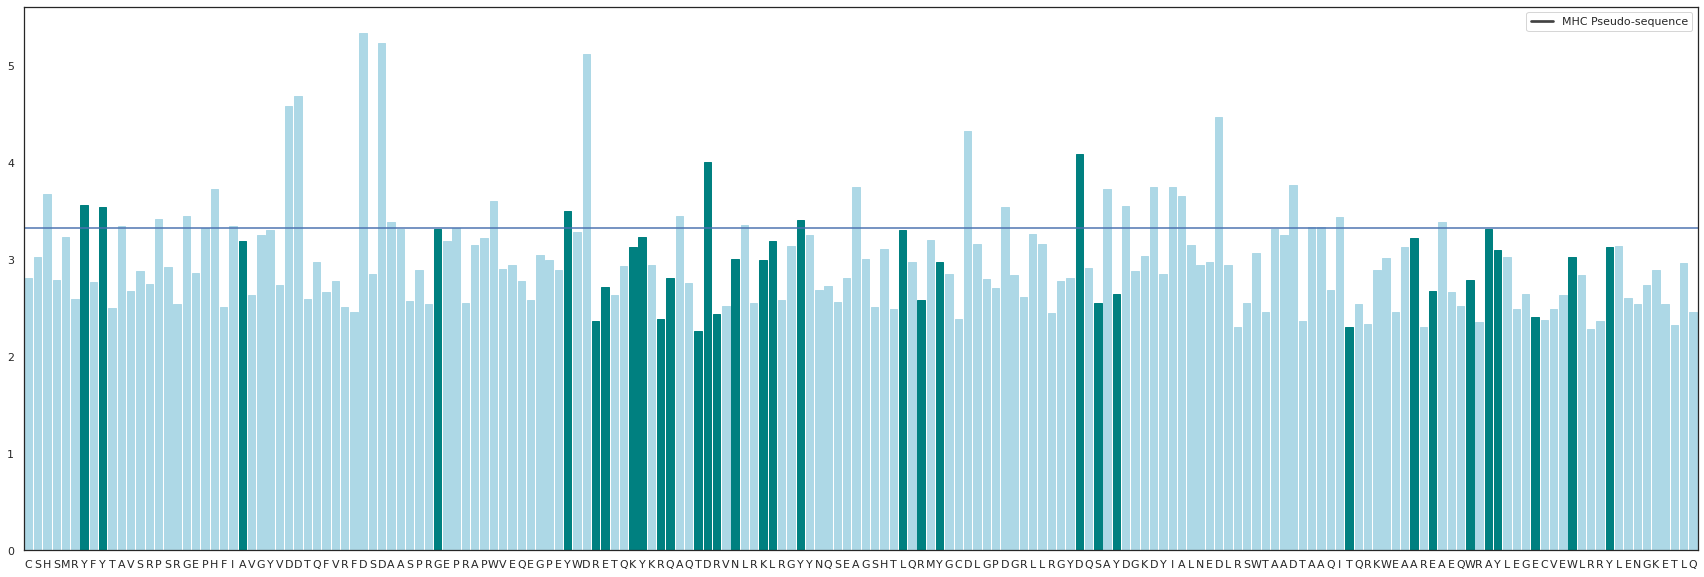



YYAGYREKYRQTDVNKLYLRYDSYTWAEWAYEWY

HYYAPGHIDDDDAWYDADLYADDDADDIADDAIA
0.530818387961245



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 978
HLA: HLA-B*51:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRENLRIALRYYNQSEAGSHTWQTMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRHLENGKETLQ
threshold: 3.3572084391775308


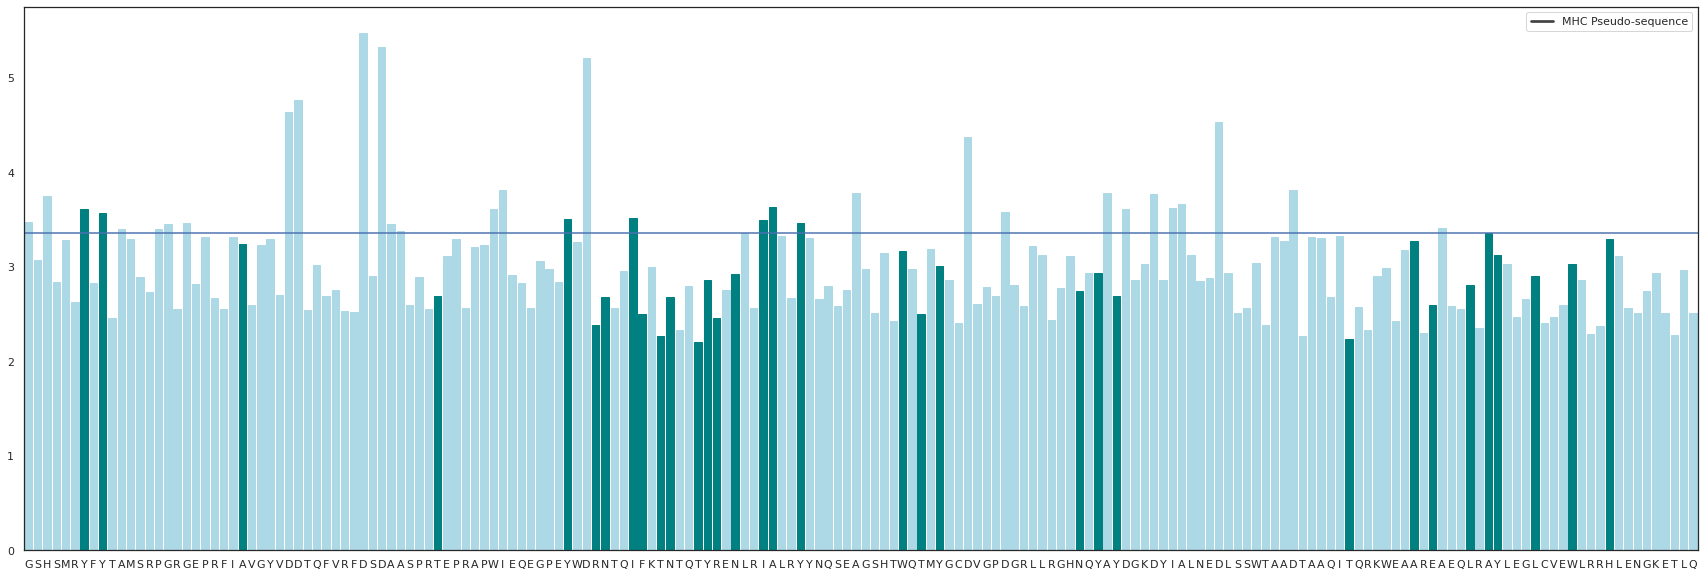



YYATYRNIFTNTYENIAYWTYNYYTWAELAYLWH

GHYYAPGGDDDDAAWIYDIIAYADDADDIADDAA
0.5035044320758607



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1033
HLA: HLA-C*08:02
CSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKKTLQ
threshold: 3.3266372311380685


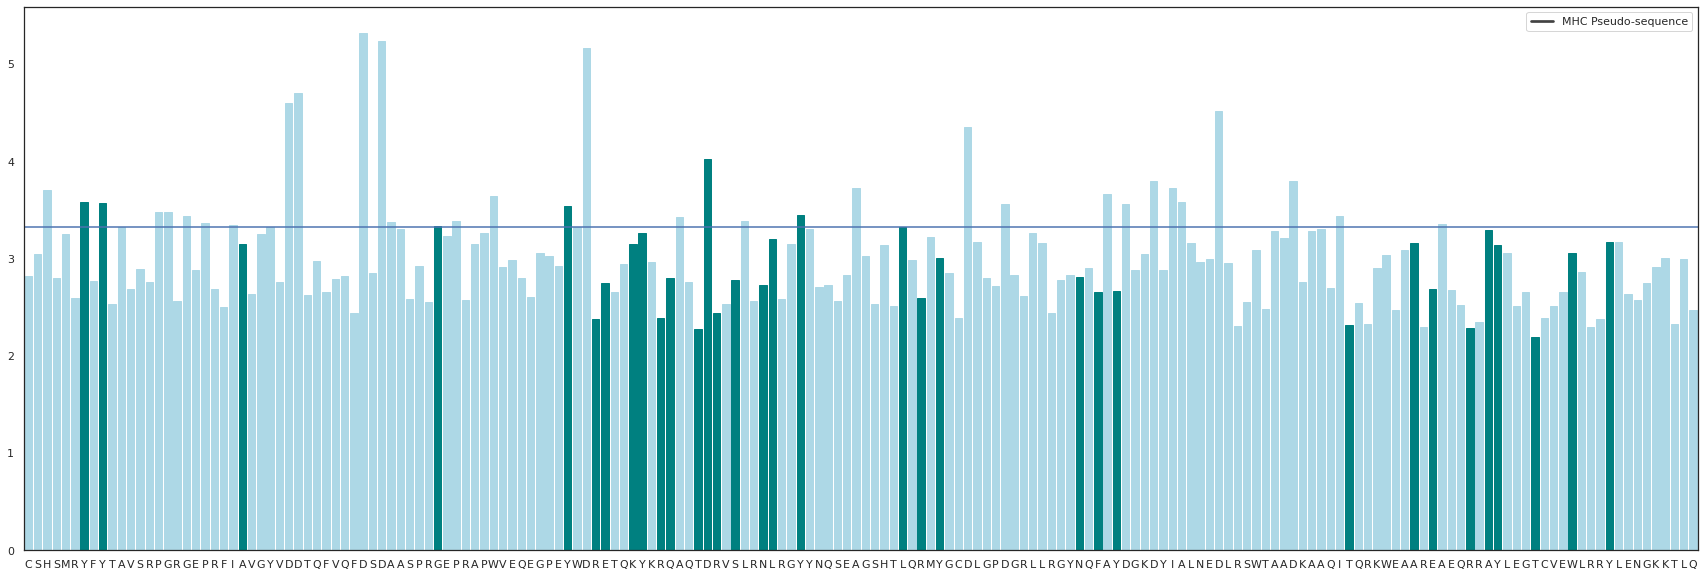



YYAGYREKYRQTDVSNLYLRYNFYTWAERAYTWY

HYYPGGPIDDDDAGPWYDADLYADDADDIADDIA
0.48773448773448763



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1028
HLA: HLA-A*68:02
GSHSMRYFYTSMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQRMYGCDVGPDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.340134676328429


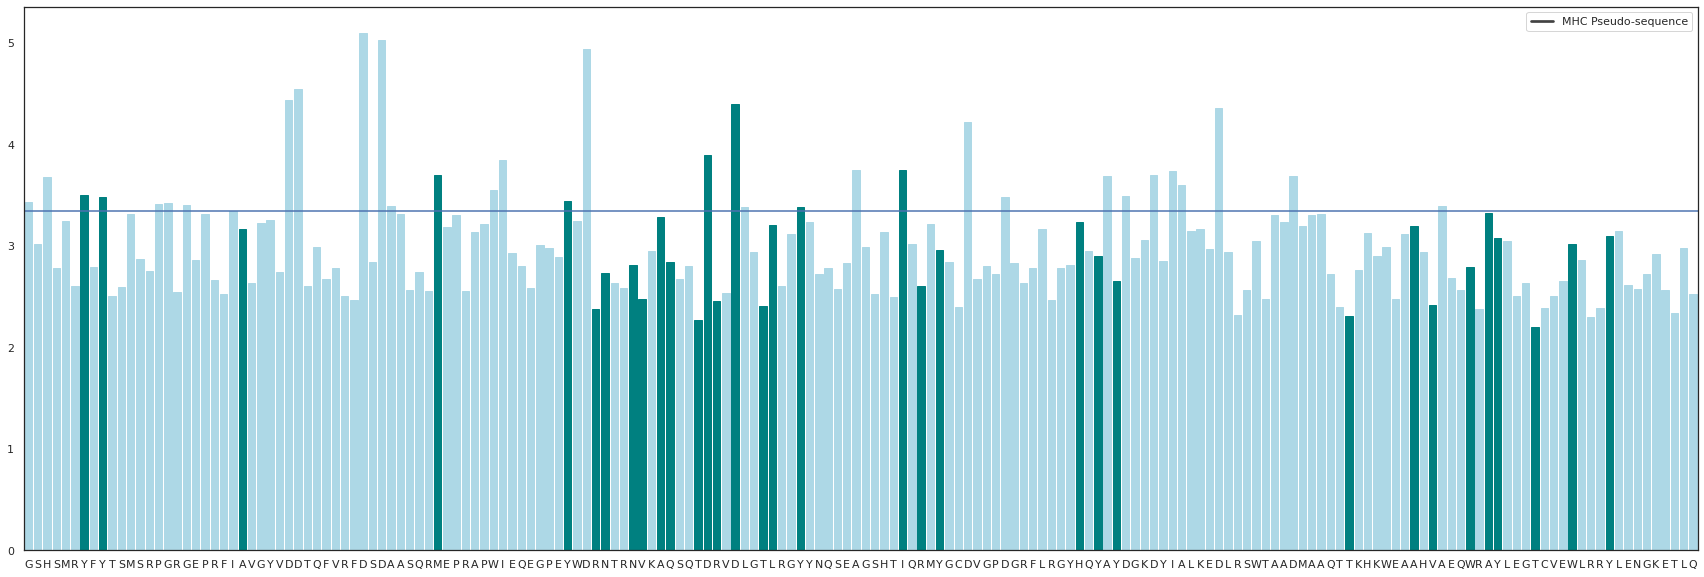



YYAMYRNNVAQTDVDTLYIRYHYYTWAVWAYTWY

GHYYPGGIDDDDAMWIYDDDLYAIDDADDIADDA
0.5210265924551638



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1077
HLA: HLA-C*06:02
CSHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3257481992078692


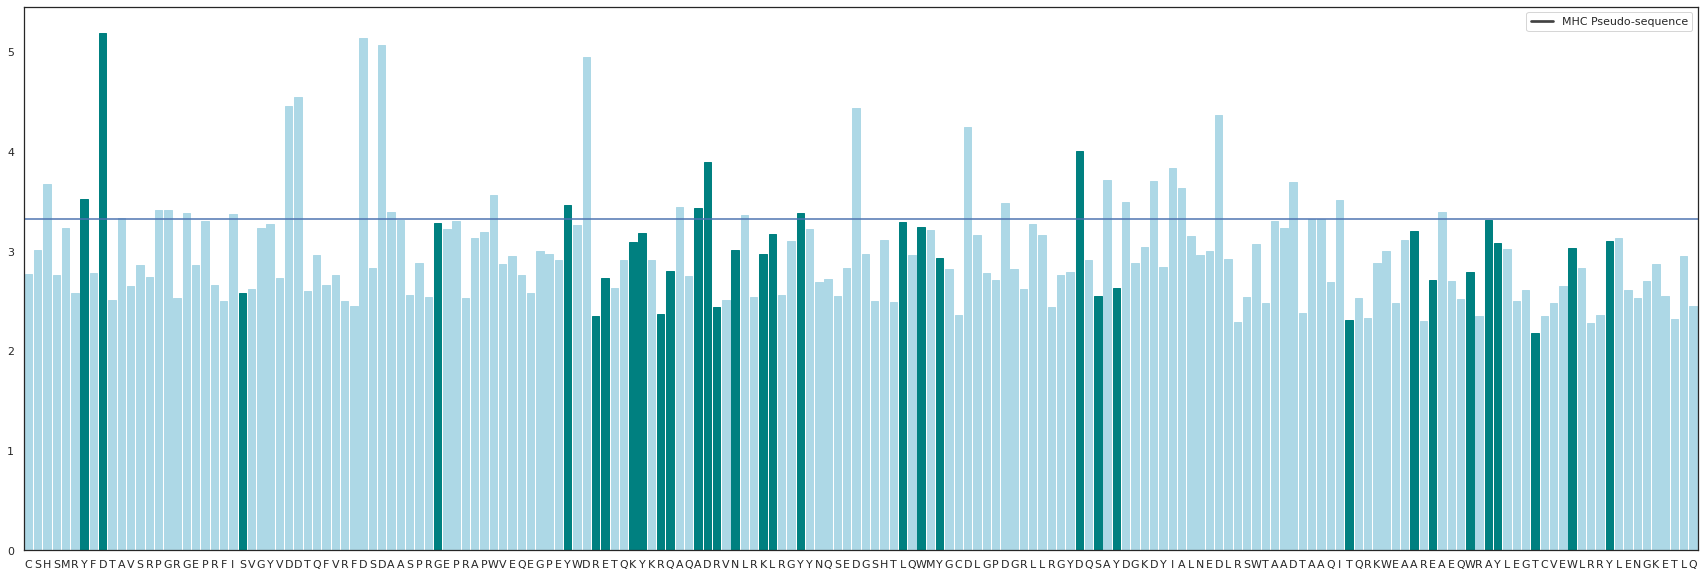



YDSGYREKYRQADVNKLYLWYDSYTWAEWAYTWY

HYDAPGGIDDDDAWYDAADLYDDDDADDIADDIA
0.5614306328592042



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1187
HLA: HLA-B*08:01
GSHSMRYFDTAMSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIFKTNTQTDRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARVAEQDRAYLEGTCVEWLRRYLENGKDTLE
threshold: 3.386563256897641


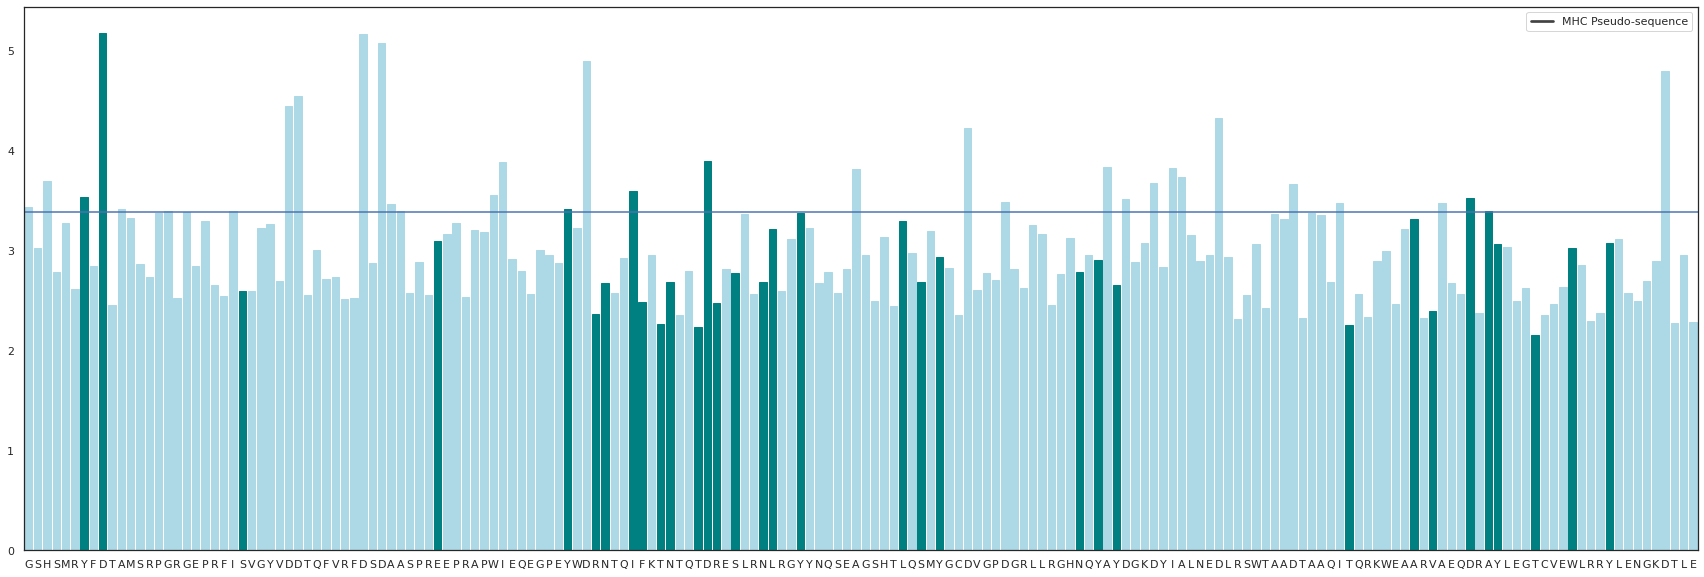



YDSEYRNIFTNTDESNLYLSYNYYTWAVDAYTWY

GHYDAGIDDDDAAWIYDIDADDADDIADDIADAD
0.48031333745619464



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1130
HLA: HLA-B*44:03
GSHSMRYFYTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRTALRYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVESLRRYLENGKETLQ
threshold: 3.4037684077710177


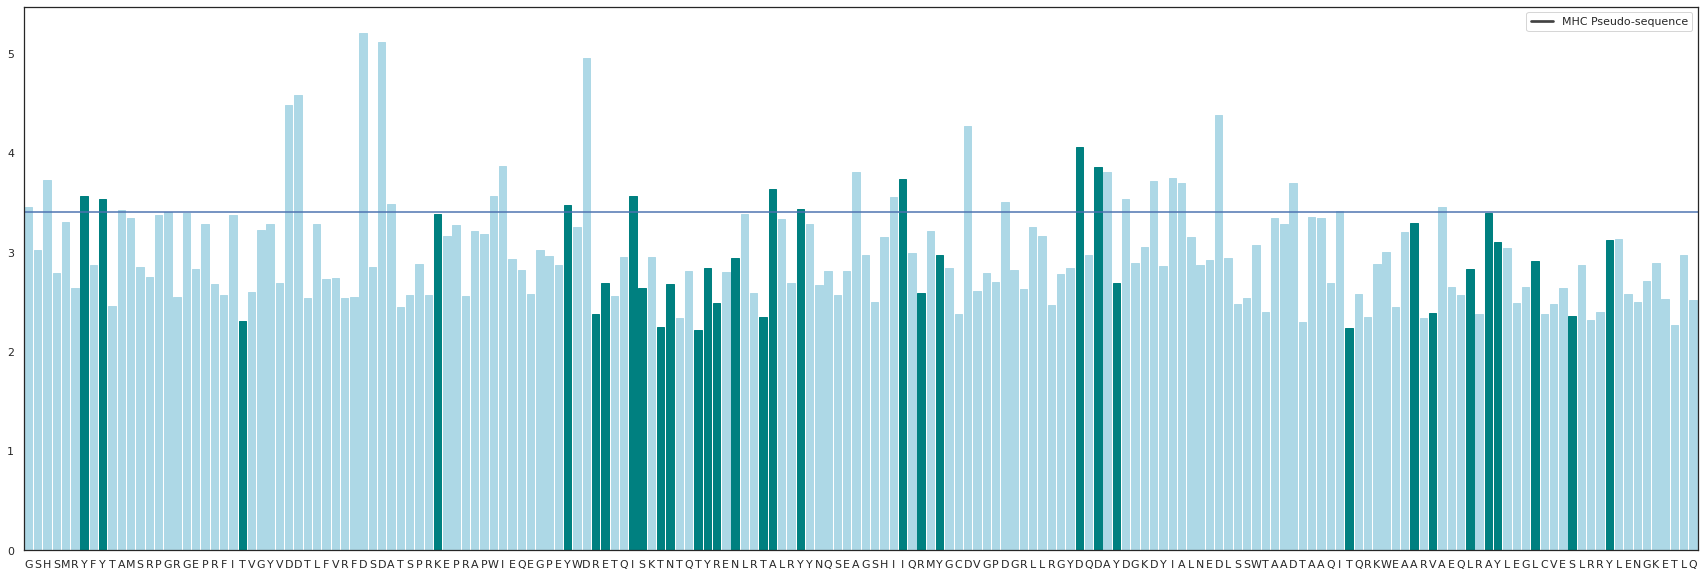



YYTKYREISTNTYENTAYIRYDDYTWAVLAYLSY

GHYYAGDDDDAWIYDIAYAIIDDDDADDIADDIA
0.4903112760255617



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1172
HLA: HLA-A*29:02
GSHSMRYFTTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDLQTRNVKAQSQTDRANLGTLRGYYNQSEAGSHTIQMMYGCDVGSDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.365343113401237


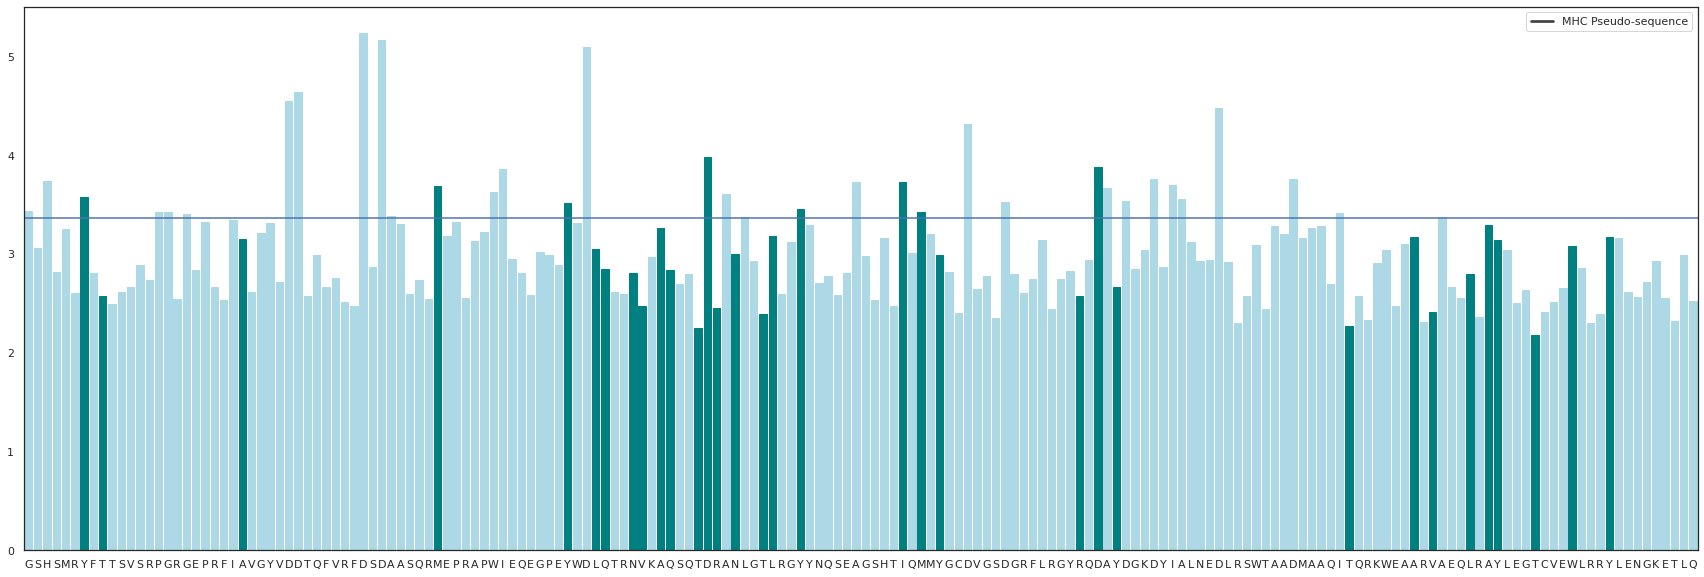



YTAMYLQNVAQTDANTLYIMYRDYTWAVLAYTWY

GHYPGGDDDDAMWIYDDALYAIMDDDADDIADDI
0.5318491032776747



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1401
HLA: HLA-A*68:01
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQMMYGCDVGSDGRFLRGYRQDAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQWRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3824970863445754


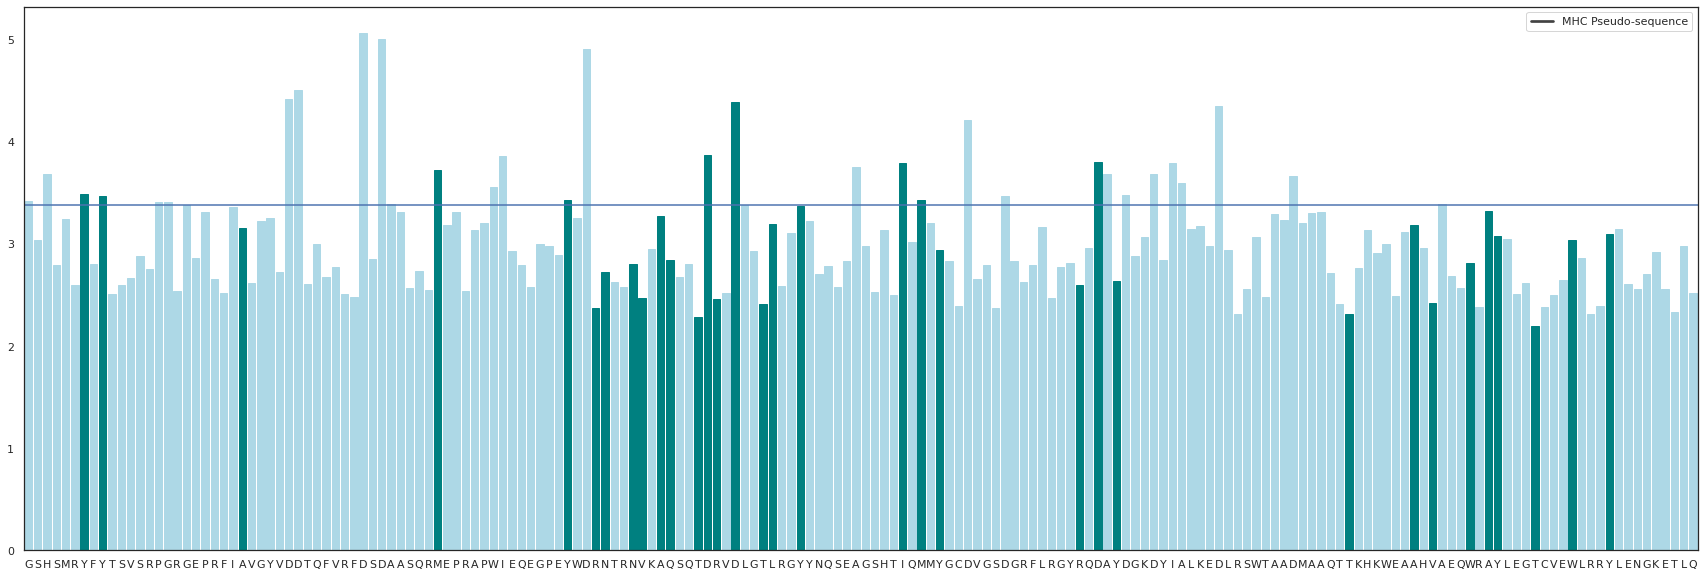



YYAMYRNNVAQTDVDTLYIMYRDYTWAVWAYTWY

GHYYPGGDDDDAMWIYDDDLAIMDDDADDIADDA
0.5404040404040404



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1442
HLA: HLA-B*44:02
GSHSMRYFYTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRTALRYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVESLRRYLENGKETLQ
threshold: 3.408145899250173


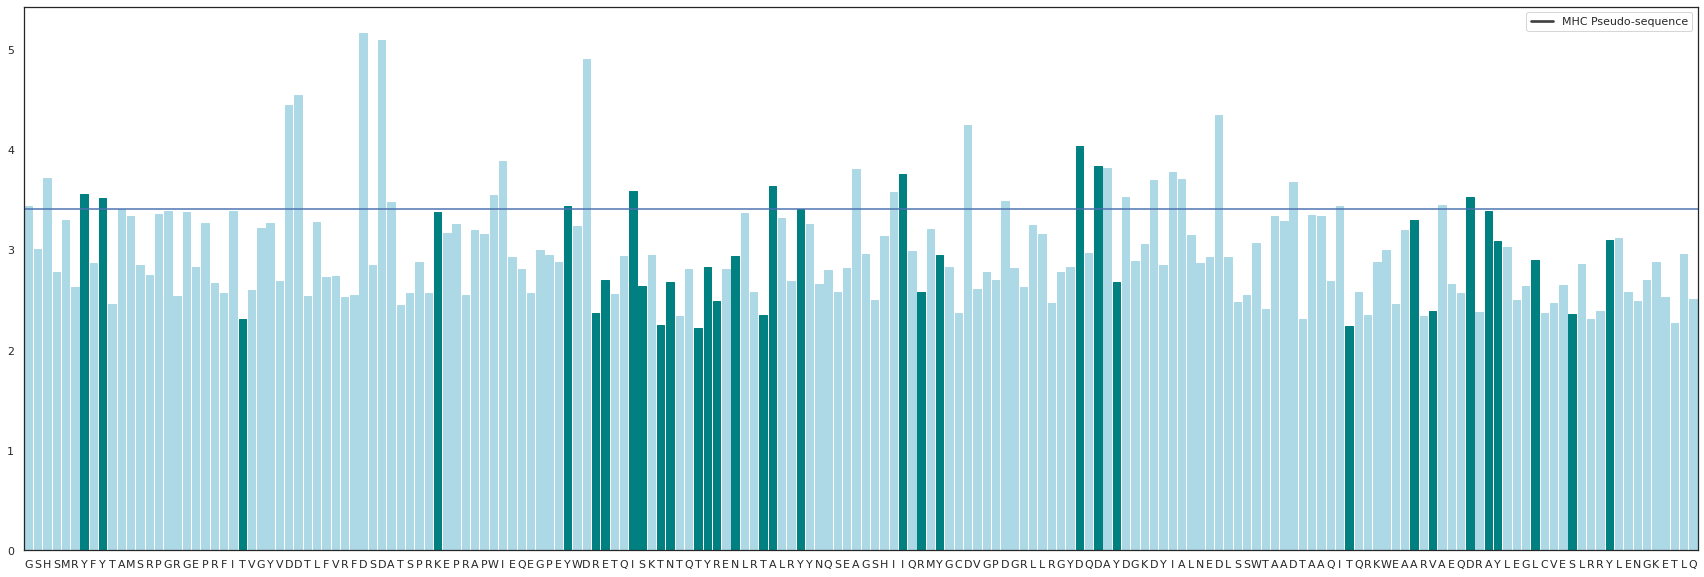



YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY

GHYYADDDDAWIYDIAYAIIDDDDADDIADDIAD
0.5027829313543598



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1505
HLA: HLA-B*40:02
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.4196519414451827


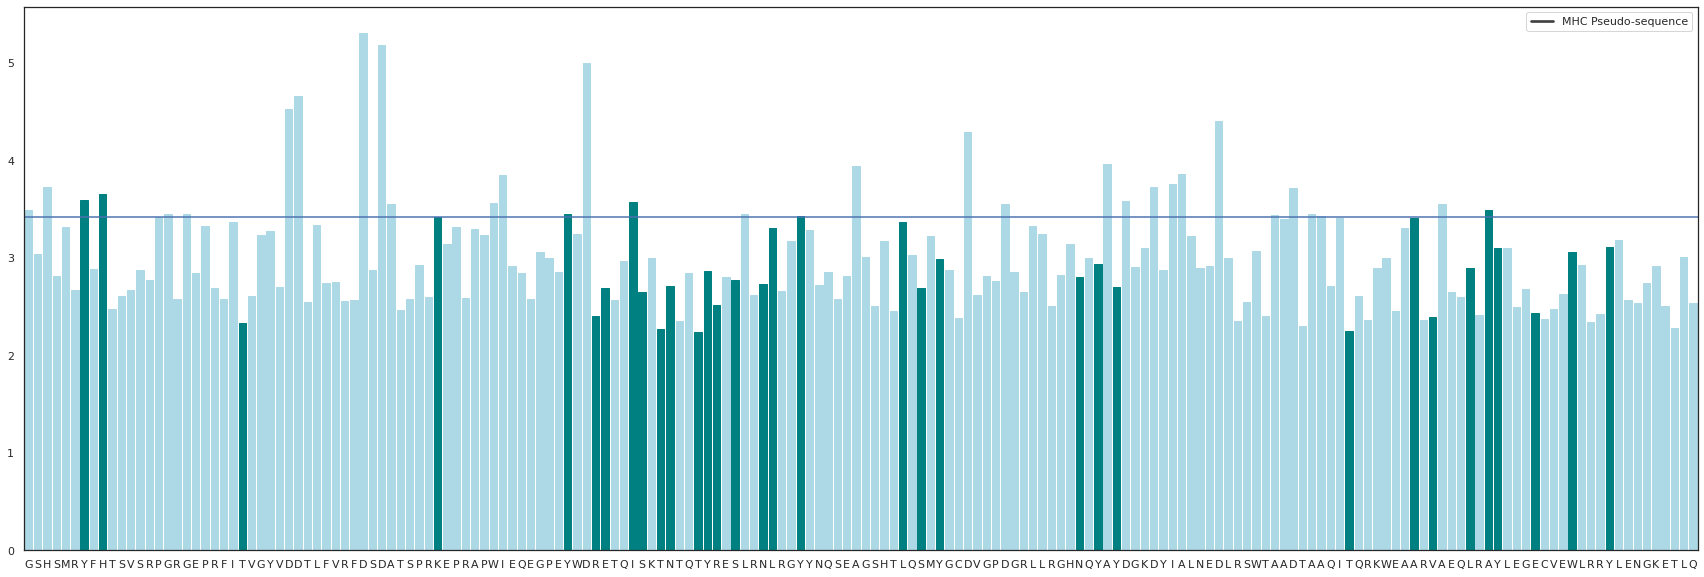



YHTKYREISTNTYESNLYLSYNYYTWAVLAYEWY

GHYHGGDDDDAKWIYDILYADDADDIADADAAAA
0.4722737579880437



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1664
HLA: HLA-A*24:02
GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITKRKWEAAHVAEQQRAYLEGTCVDGLRRYLENGKETLQ
threshold: 3.3585281372070312


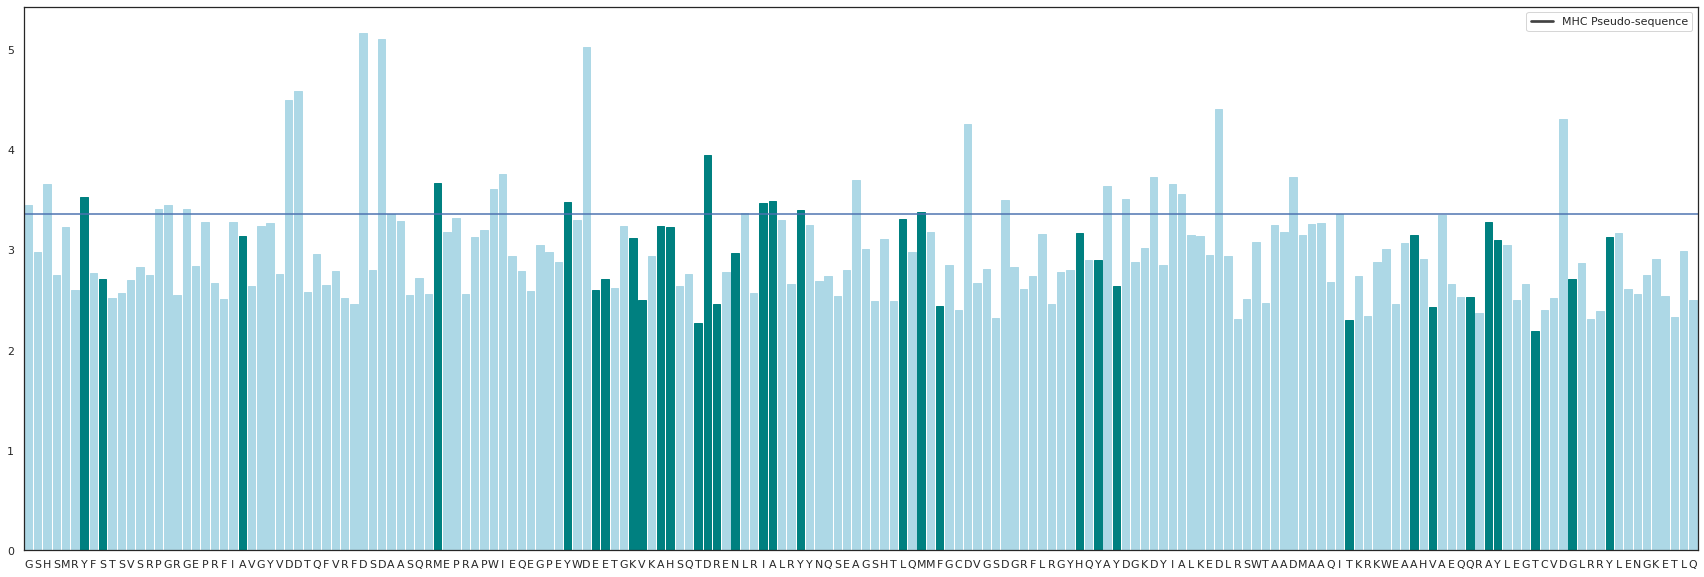



YSAMYEEKVAHTDENIAYLMFHYYTWAVQAYTGY

GHYPGGDDDDAMWIYDDLIAYAMDDADDIADDID
0.5190682333539476



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1705
HLA: HLA-A*01:01
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQKMEPRAPWIEQEGPEYWDQETRNMKAHSQTDRANLGTLRGYYNQSEDGSHTIQIMYGCDVGPDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAVHAAEQRRVYLEGRCVDGLRRYLENGKETLQ
threshold: 3.363730296920821


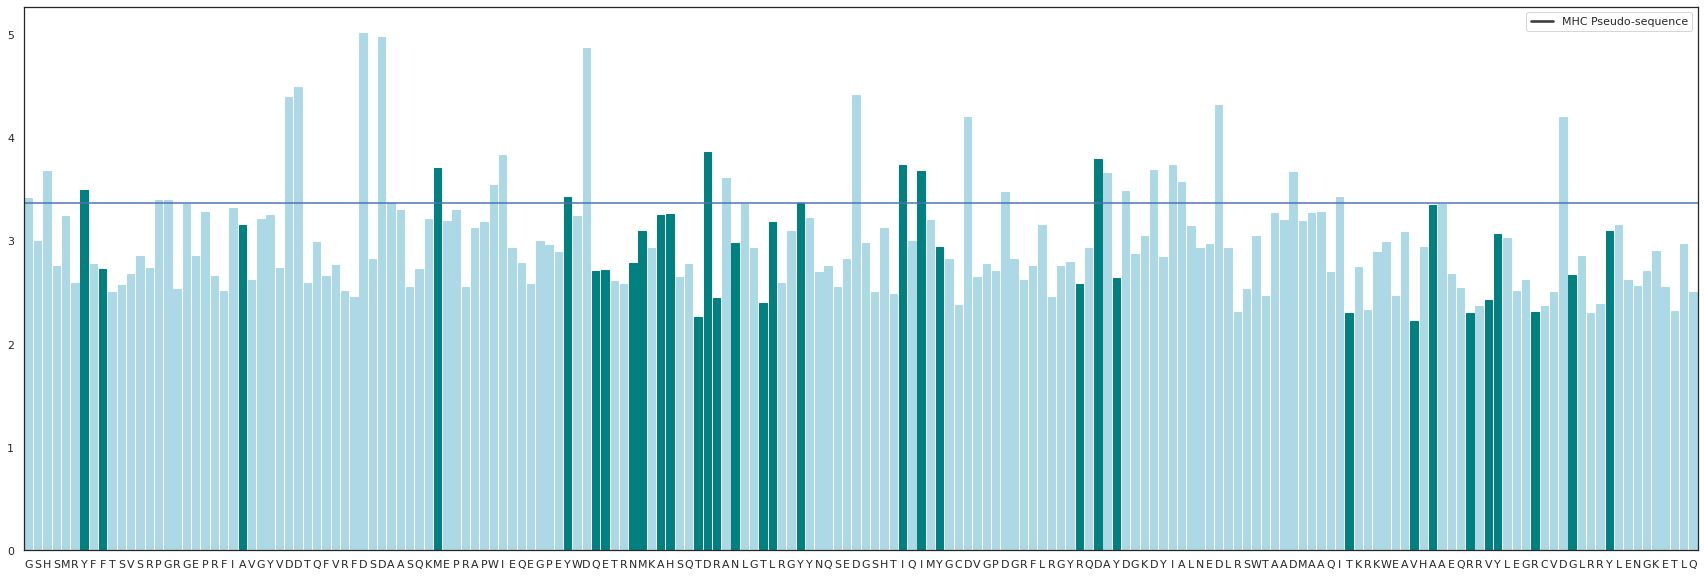



YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY

GHYPGDDDDAMWIYDDAYDIIDDDADDIADDIAD
0.4952587095444238



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1722
HLA: HLA-C*04:01
GSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.348142262812137


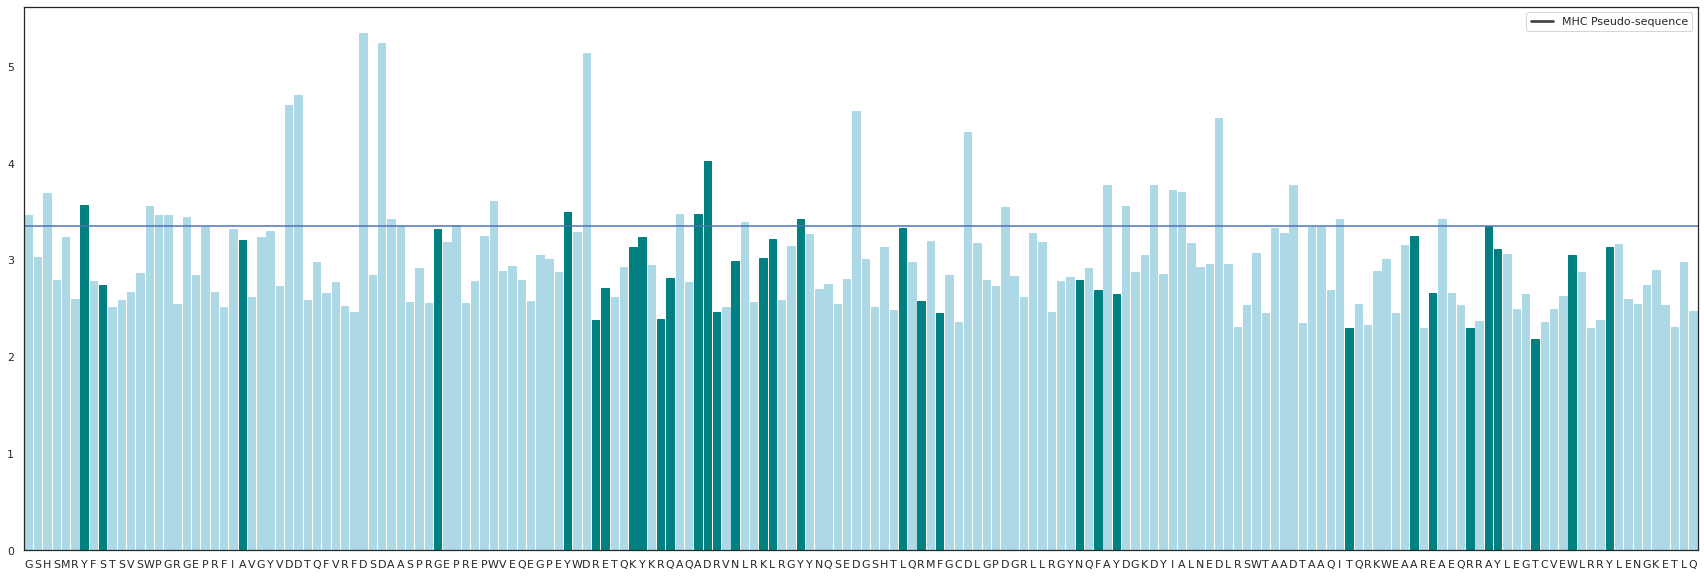



YSAGYREKYRQADVNKLYLRFNFYTWAERAYTWY

GHYWPGGDDDDAAPWYDAADLYDDDADDIADDIA
0.5013399299113585



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1755
HLA: HLA-B*35:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRESLRNLRGYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.3593477341524216


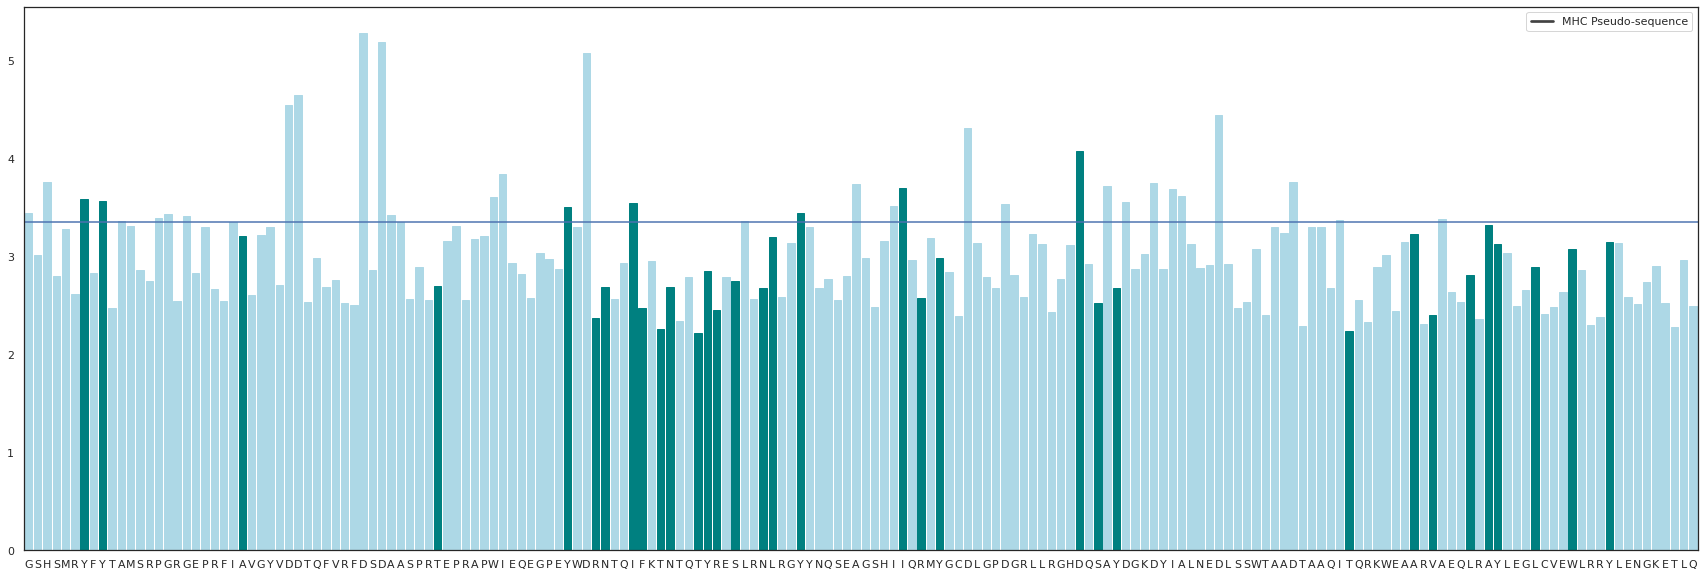



YYATYRNIFTNTYESNLYIRYDSYTWAVLAYLWY

GHYYPGGDDDDAWIYDILYAIIDDDADDIADDIA
0.4760874046588333



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 1887
HLA: HLA-A*11:01
GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAQSQTDRVDLGTLRGYYNQSEDGSHTIQIMYGCDVGPDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAAHAAEQQRAYLEGRCVEWLRRYLENGKETLQ
threshold: 3.371020261989931


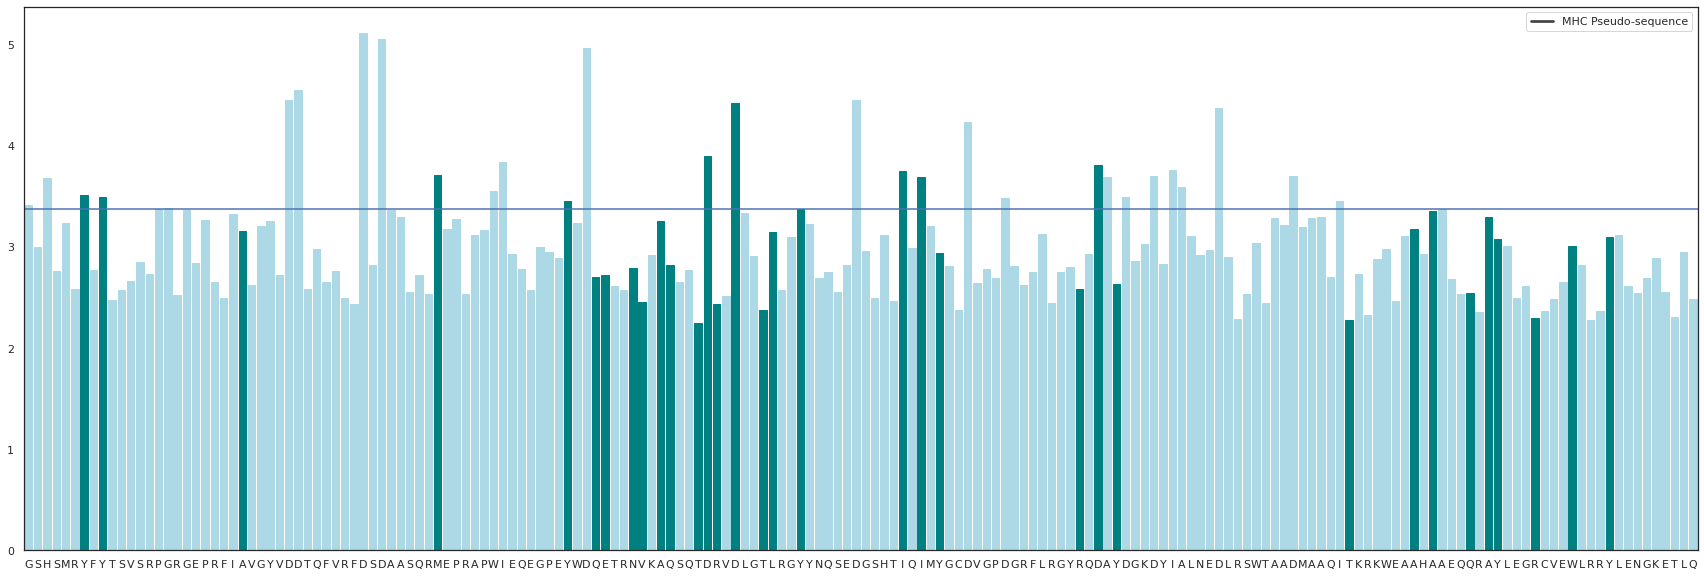



YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY

GHYYPGGDDDDMWIYDDDYDIIDDDADDIADDIA
0.5678210678210679



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 2110
HLA: HLA-A*03:01
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQIMYGCDVGSDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAAHEAEQLRAYLDGTCVEWLRRYLENGKETLQ
threshold: 3.3817563314573458


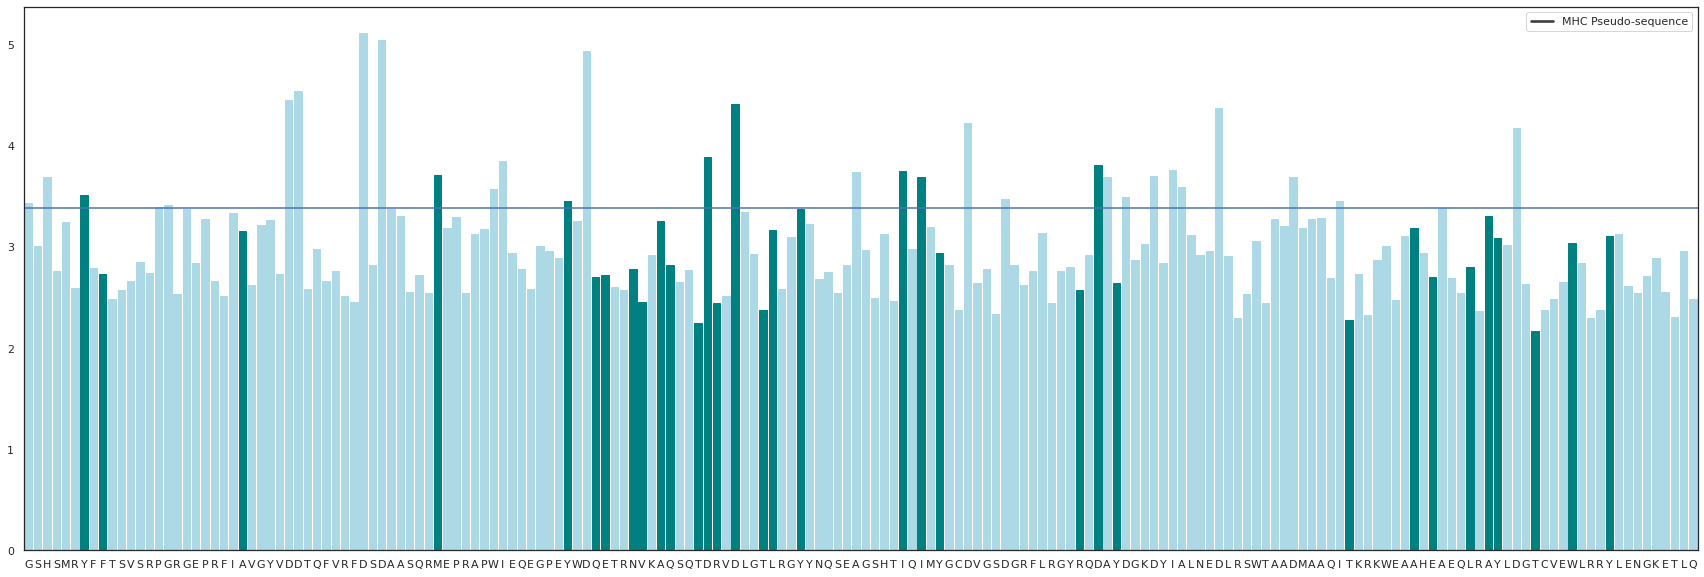



YFAMYQENVAQTDVDTLYIIYRDYTWAELAYTWY

GHYPGGDDDDMWIYDDDYAIIDDDADDIADDIAD
0.5394763966192537



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 2306
HLA: HLA-B*57:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDGETRNMKASAQTYRENLRIALRYYNQSEAGSHIIQVMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.334018677498916


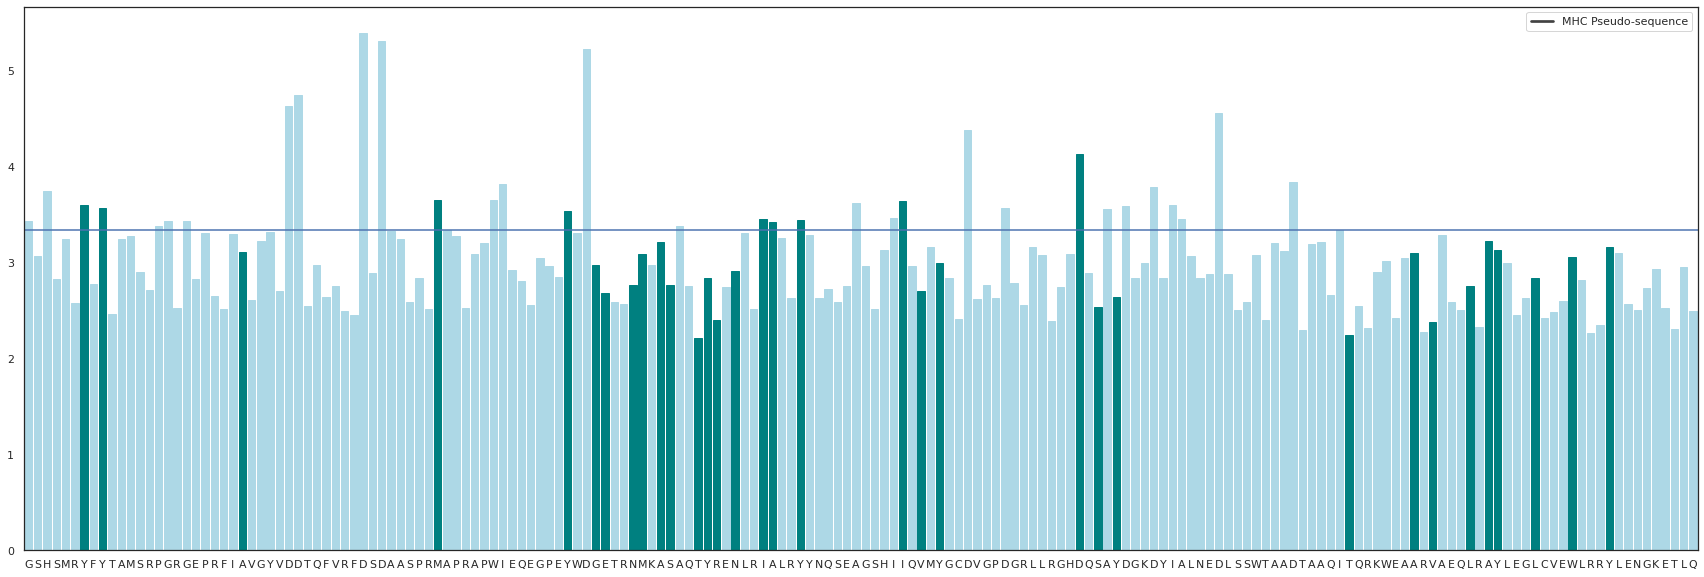



YYAMYGENMASTYENIAYIVYDSYTWAVLAYLWY

GHYYPGGDDDDMAWIYDAIAYAIIDDDADDIADD
0.5644197072768502



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 2663
HLA: HLA-B*07:02
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGECVEWLRRYLENGKDKLE
threshold: 3.3595022501642884


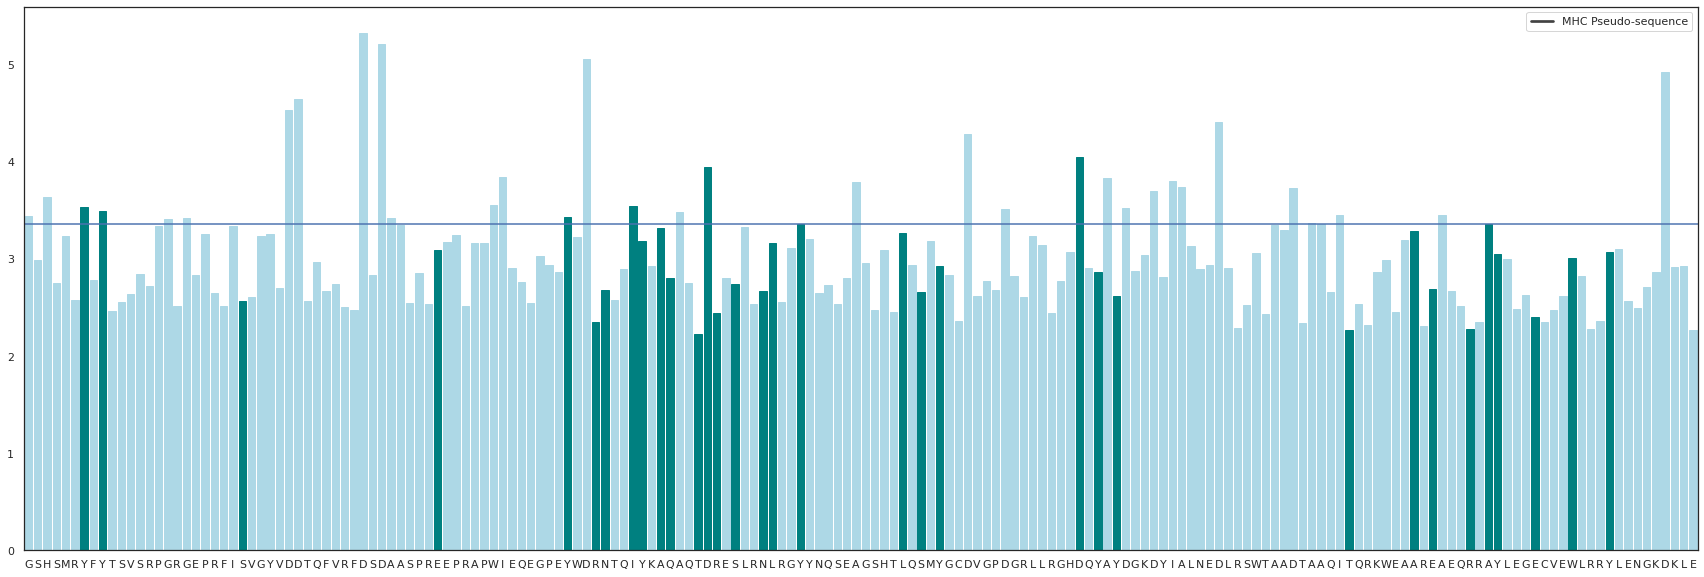



YYSEYRNIYAQTDESNLYLSYDYYTWAERAYEWY

GHYYGGDDDDAWIYDIADADDDADDIADDAIAAD
0.5192743764172335



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 2776
HLA: HLA-B*15:01
GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAPRAPWIEQEGPEYWDRETQISKTNTQTYRESLRNLRGYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQWRAYLEGLCVEWLRRYLENGKETLQ
threshold: 3.3587213785572767


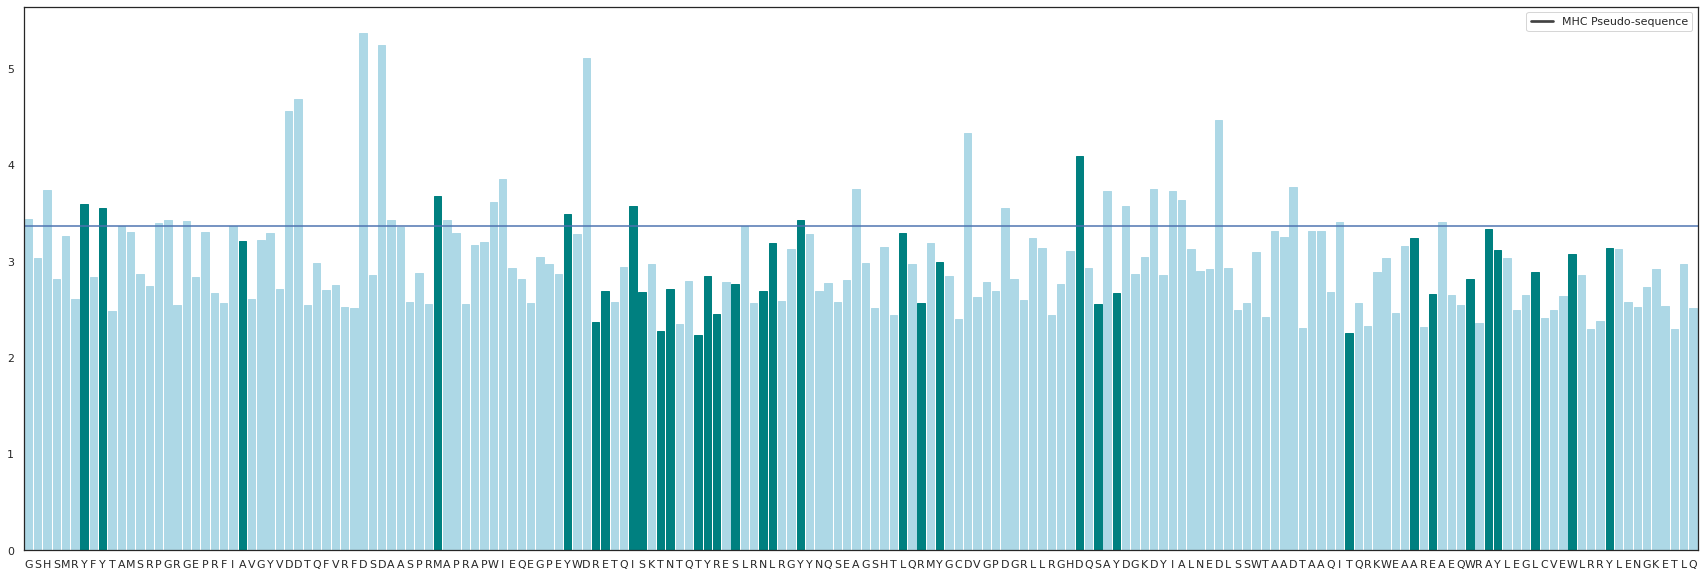



YYAMYREISTNTYESNLYLRYDSYTWAEWAYLWY

GHYYAPGGDDDDAMAWIYDIYADDDADDIADDIA
0.507936507936508



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 4736
HLA: HLA-A*02:01
GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ
threshold: 3.3185412432696366


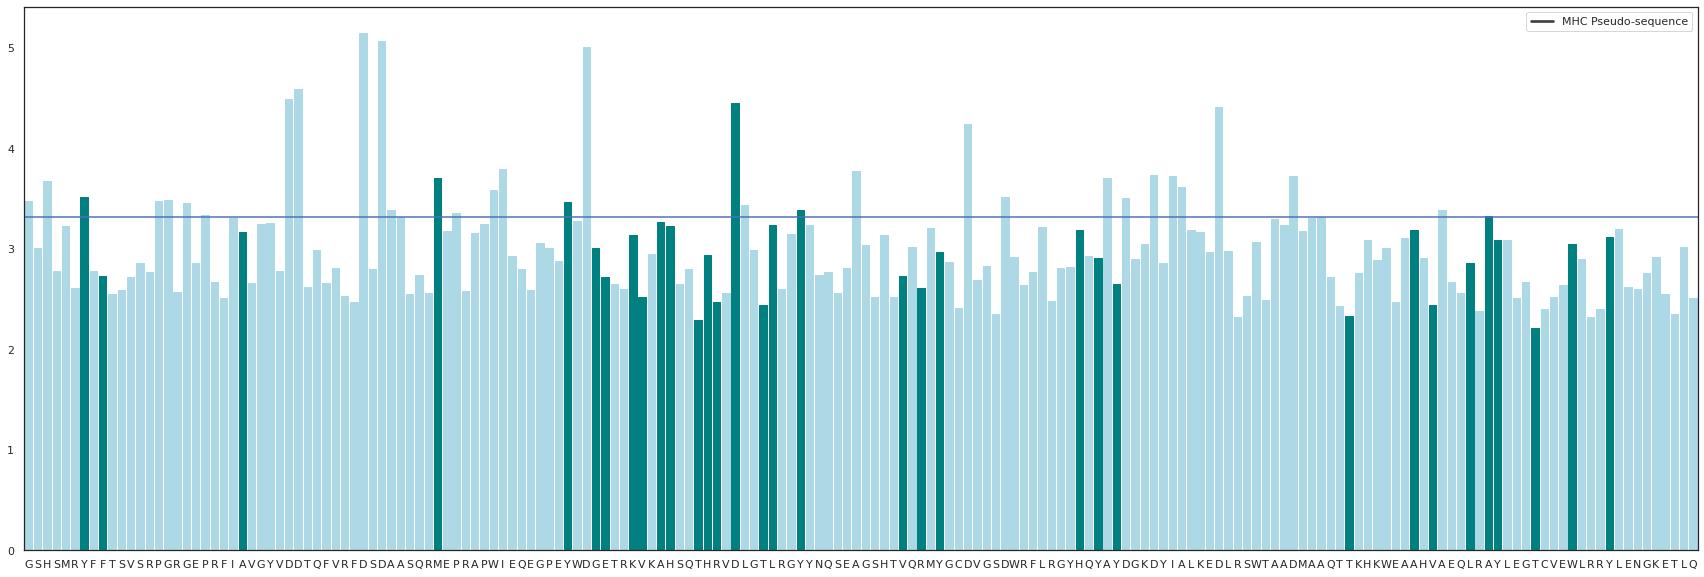



YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY

GHYPGGPDDDDAAMPWIYDDLYADDADDIADDAA
0.5099979385693671



========= Model 100p, EmbeddingAttentionEncoder, 20 =========
#Peptides: 7306
HLA: HLA-B*27:05
GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDREDLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQ
threshold: 3.3783122390843143


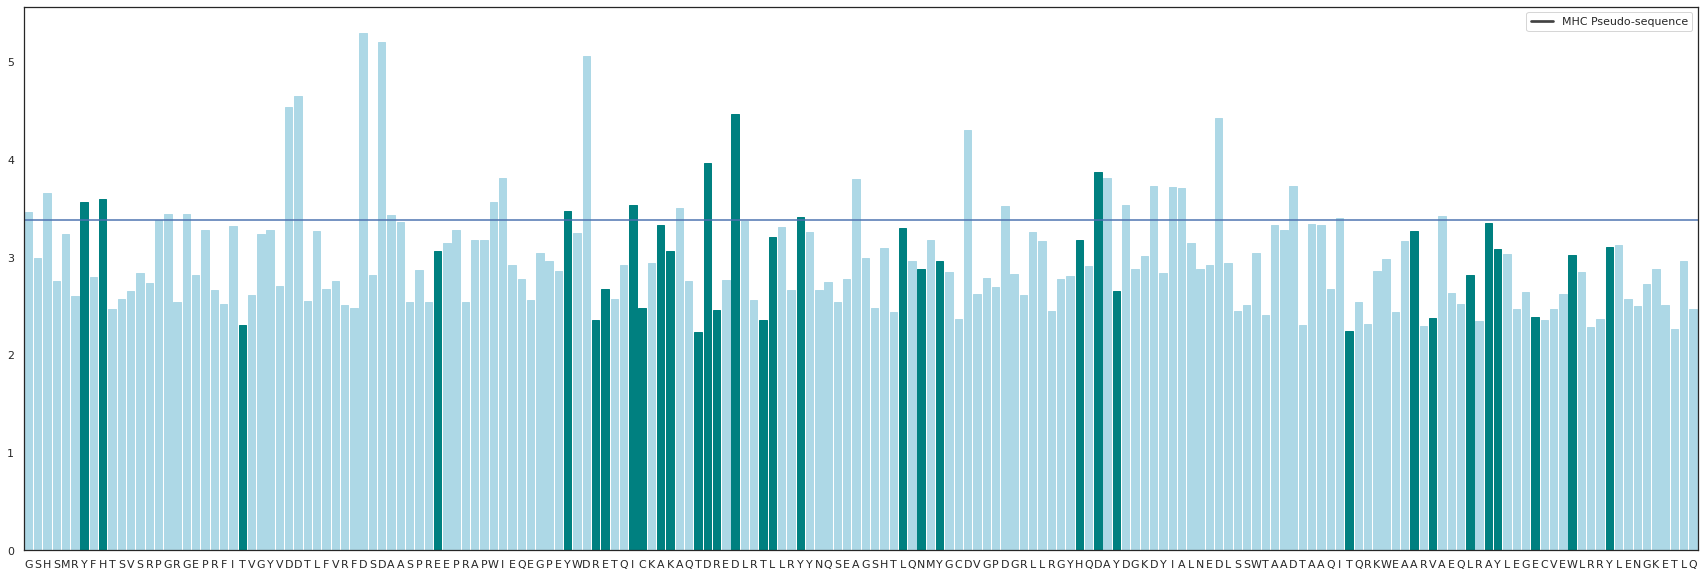



YHTEYREICAKTDEDTLYLNYHDYTWAVLAYEWY

GHYHPGGDDDDAWIYDIADDYADDDADDIADDIA
0.5360750360750361


In [12]:
bin_pos = [7,9,24,45,59,62,63,66,67,69,75,69,70,73,74,77,80,81,84,95,97,99,114,116,118,143,150,152,156,158,159,163,167,171]
bin__ = [0]*180
for i in range(len(bin__)):
    if i in bin_pos:
        bin__[i-1] = 1
    else:
        bin__[i-1] = 0
bin__

similarity_100ep = []

HLA_list = pd.read_csv('/home/s202357/thesis/transmut/pipeline/procedure/test/performance/' + 'total_rows_per_HLA.csv').HLA.tolist()

path_saver = model_folder + fnc.pkl(id_nested, n_layers, n_heads, 1, d_model)
print(path_saver)
model_test = Transformer().to(device)
model_test.load_state_dict(torch.load(path_saver))
model_test = model_test.eval()

for HLA_filter in HLA_list:
    
    print('\n\n\n========= Model {}, {}, {} ========='.format(size,model_type,d_model))

    ep_best = 0
    fold = 0

    test_fold_metrics_list_nested = []

    type_ = 'test'

    df_list = []
    time_testing = time.time()

    fold_avg_all = [list(range(0,4)), list(range(4,8)), list(range(8,12)), list(range(12,16)), list(range(16,20))] 
    pred_all = []
    target_all = []
    enc_attn_list_all = []
    enc_hla_attn_list_all = []

    for fold_avg, file_num in zip(fold_avg_all,[0,1,2,3,4]):

            pred_fold = []
            target_fold = []
            enc_attn_list_tmp = []
            enc_hla_attn_list_tmp = []

            for f in fold_avg:
                index_order_idx = f

                test_data, test_pep_inputs, test_hla_inputs, test_labels, test_loader = data_with_loader_unique(data_dir, 
                                                                                                                    model_type, 
                                                                                                                    HLA_filter,
                                                                                                                    pep_max_len,
                                                                                                                    hla_max_len,
                                                                                                                    vocab,
                                                                                                                    index_order_idx, 
                                                                                                                    type_ = type_, 
                                                                                                                    fold = file_num,  
                                                                                                                    batch_size = batch_size)


                if 'Blosum' in model_type:
                    ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin, enc_attn_list, enc_hla_attn_list = fnc.eval_step_test_bl(model_test, 
                                                                                                       model_abbr,
                                                                                                       threshold,
                                                                                                       test_loader, 
                                                                                                       fold, 
                                                                                                       ep_best, 
                                                                                                       epochs, 
                                                                                                       use_cuda)

                else:
                    ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin, enc_attn_list, enc_hla_attn_list = fnc.eval_step_test(model_test, 
                                                                                                       model_abbr,
                                                                                                       threshold,
                                                                                                       test_loader, 
                                                                                                       fold, 
                                                                                                       ep_best, 
                                                                                                       epochs, 
                                                                                                       use_cuda) # , test_res_attns

                target_fold = [x.item() for x in test_labels]

                del enc_attn_list
                gc.collect()
                torch.cuda.empty_cache()

                df_temp = pd.DataFrame(list(zip(target_fold, y_prob)), columns= ['target', 'pred'])
                num_pos = len(df_temp[df_temp['target']==1])
                df_temp_ppv = df_temp.sort_values(by=['pred'], ascending=False)[0:num_pos]
                num_true_pos = len(df_temp_ppv[df_temp_ppv['target']==1])
                ppv = num_true_pos/num_pos
                auc_01 = fnc.binary_roc_auc_score(df_temp['target'].tolist(), df_temp['pred'], max_fpr=0.1)

                test_data['target_'] = target_fold
                test_data['pred_'] = y_prob

                del target_fold, y_prob
                gc.collect()
                torch.cuda.empty_cache()

                break 

            break

    tmp = pd.read_csv(data_dir + 'upd_{}_d.csv'.format(fold), index_col = 0).drop_duplicates()
    pseudo = tmp[tmp['HLA']==HLA_filter].HLA_sequence.tolist()[0]
    

    mhc_seq = test_data.HLA_sequence.tolist()[0]

    softmax_pd, unsoftmax_pd, max_list, new_pseudo =  fnc.draw_hla_length_aatype_position_HLAfull(test_data.reset_index(drop=True), torch.from_numpy(np.array(enc_hla_attn_list)), 3, HLA_filter, pseudo, mhc_seq, label = 1 , length = None , threshold = 0.50, show = 'bar', softmax = True, unsoftmax = True)    
    print("\n\n" + pseudo)
    print("\n" + color.RED + color.BOLD + ''.join(new_pseudo) + color.END)
    
    auc_sim = roc_auc_score(bin__, max_list)
    print(auc_sim)
    
    similarity_100ep.append([HLA_filter, auc_sim, mhc_seq, pseudo, ''.join(new_pseudo)] )
    del tmp, enc_hla_attn_list, test_data
    gc.collect()
    torch.cuda.empty_cache()


In [13]:
pd.DataFrame(similarity_100ep, columns=['HLA', 'auc', 'full MHC', 'pseudo MHC', 'new pseudo MHC']).to_csv('new_pseudo_similarity_100p_nh9_100ep.csv')
HLA_similarity = pd.DataFrame(similarity_100ep, columns=['HLA', 'auc', 'full MHC', 'pseudo MHC', 'new pseudo MHC'])#.to_csv('new_pseudo_similarity_100p_nh3_50ep.csv')
HLA_list = pd.read_csv('/home/s202357/thesis/transmut/pipeline/procedure/test/performance/' + 'total_rows_per_HLA_lbl.csv')
HLA_list.merge(HLA_similarity, on='HLA').sort_values(by=['auc'], ascending=False).to_csv('new_pseudo_similarity_100p_nh9_100ep_HLAcountlbl.csv')
merged = HLA_list.merge(HLA_similarity, on='HLA').sort_values(by=['auc'], ascending=False) #.to_csv('new_pseudo_similarity_100p_nh3_50ep_HLAcountlbl.csv')
merged

HLA  label  count       auc  \
179  HLA-A*31:01      0  19287  0.584209   
178  HLA-A*31:01      1   4598  0.584209   
91   HLA-A*33:01      0   4532  0.576685   
90   HLA-A*33:01      1   1079  0.576685   
149  HLA-A*32:01      0  14250  0.571635   
..           ...    ...    ...       ...   
66   HLA-B*39:24      1    487  0.450423   
161  HLA-B*39:01      0  16662  0.445372   
160  HLA-B*39:01      1   3973  0.445372   
94   HLA-B*39:06      1   1263  0.437333   
95   HLA-B*39:06      0   5301  0.437333   

                                              full MHC  \
179  GSHSMRYFTTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...   
178  GSHSMRYFTTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...   
91   GSHSMRYFTTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...   
90   GSHSMRYFTTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...   
149  GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...   
..                                                 ...   
66   GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREE...   
161  GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREE...   
160  GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREE...   
94   GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREE...   
95   GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREE...   

                             pseudo MHC                      new pseudo MHC  
179  YTAMYQENVAHIDVDTLYIMYQDYTWAVLAYTWY  GHYPGGDDDDMWIYDIDDYAIMDDDADDIADDIA  
178  YTAMYQENVAHIDVDTLYIMYQDYTWAVLAYTWY  GHYPGGDDDDMWIYDIDDYAIMDDDADDIADDIA  
91   YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWH  GHYPGGDDDDMWIYDIDDYAIMDDDADDIADDIA  
90   YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWH  GHYPGGDDDDMWIYDIDDYAIMDDDADDIADDIA  
149  YFAMYQENVAHTDESIAYIMYQDYTWAVLAYTWY  GHYPGGDDDDAMWIYDDIAYAIMDDDADDIADDI  
..                                  ...                                 ...  
66   YYSEYRNICTNTDESNLYLSYNFYTWAVLTYTWY  GHYYPGGDDDDAAWIYDIDLADDADDIADADAIA  
161  YYSEYRNICTNTDESNLYLRYNFYTWAVLTYTWY  GHYYPGGDDDDAAWIYDIDLYADDADDIADDAIA  
160  YYSEYRNICTNTDESNLYLRYNFYTWAVLTYTWY  GHYYPGGDDDDAAWIYDIDLYADDADDIADDAIA  
94   YYSEYRNICTNTDESNLYWTYNFYTWAVLTYTWY  GHYYGGDDDDAAWIYDIDLADDADDIADADAAIA  
95   YYSEYRNICTNTDESNLYWTYNFYTWAVLTYTWY  GHYYGGDDDDAAWIYDIDLADDADDIADADAAIA  

[224 rows x 7 columns]

In [22]:
print(np.array(merged['auc']).max(), np.array(merged['auc']).mean(), np.array(merged['auc']).min())

0.5842094413522984 0.5154055128544924 0.43733250876108015


#### PEPTIDE LEN:9, HLA-B*07:02



#Peptides: 158
threshold: 0.041
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGECVEWLRRYLENGKDKLE

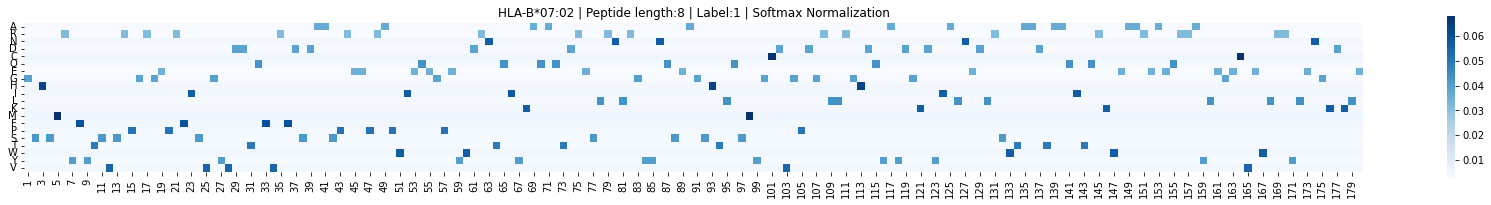



#Peptides: 1686
threshold: 0.312
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGECVEWLRRYLENGKDKLE

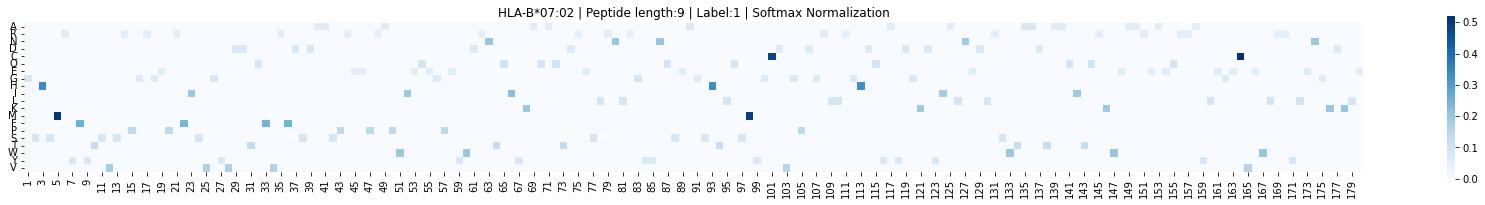



#Peptides: 437
threshold: 0.286
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGECVEWLRRYLENGKDKLE

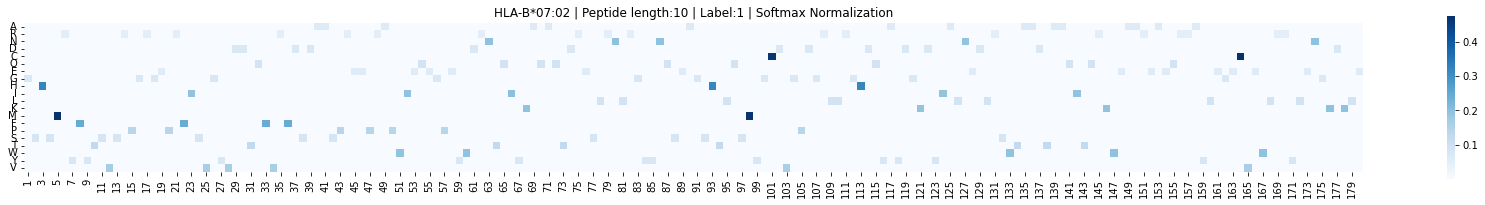



#Peptides: 213
threshold: 0.085
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGECVEWLRRYLENGKDKLE

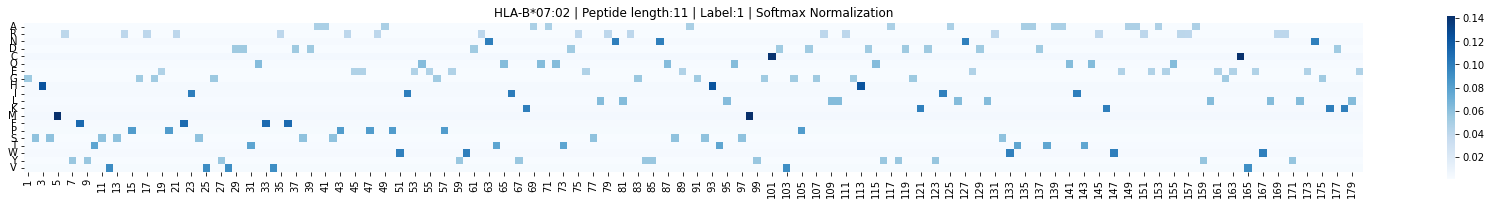



#Peptides: 89
threshold: 0.014
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGECVEWLRRYLENGKDKLE

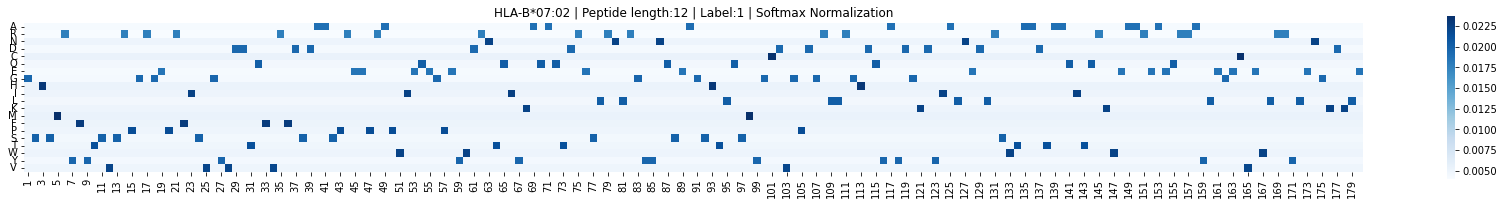



#Peptides: 47
threshold: 0.007
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGECVEWLRRYLENGKDKLE

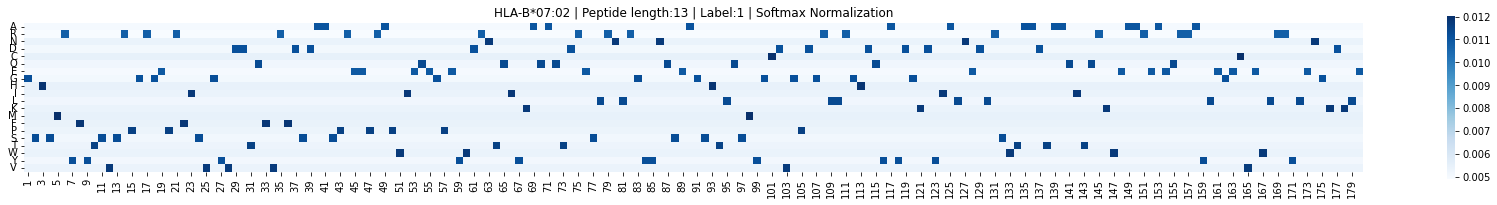



#Peptides: 33
threshold: 0.006
GSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQIYKAQAQTDRESLRNLRGYYNQSEAGSHTLQSMYGCDVGPDGRLLRGHDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGECVEWLRRYLENGKDKLE

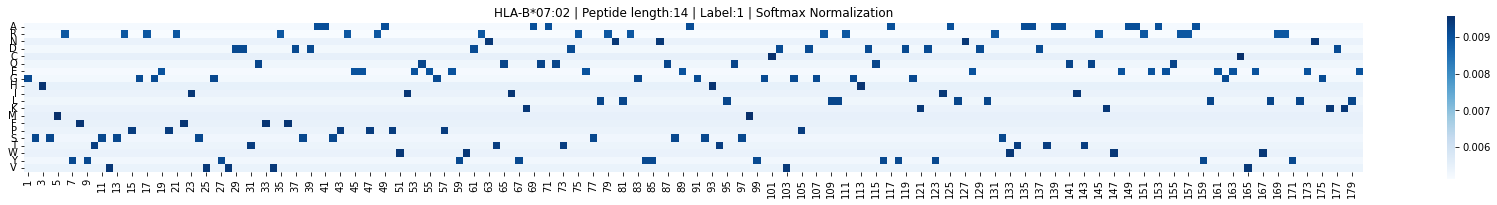

In [25]:
for peplen in list(range(8,15,1)):
    softmax_pd, unsoftmax_pd =  fnc.draw_hla_length_aatype_position_HLA(test_data.reset_index(drop=True), torch.from_numpy(np.array(enc_hla_attn_list)), hla = 'HLA-B*07:02', hlasize = 180, label = 1 , length = peplen, n_heads = 3, threshold = 0.60, show = True, softmax = True, unsoftmax = True)

#### PEPTIDE LEN:9, HLA-C*04:01



#Peptides: 107
threshold: 0.019
GSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQ

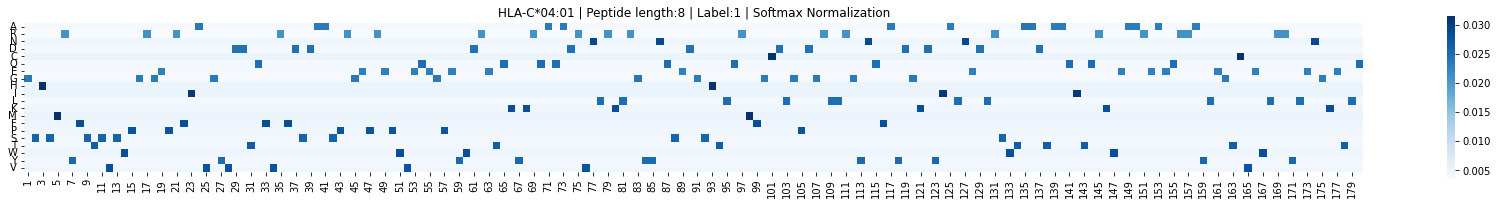



#Peptides: 1320
threshold: 0.309
GSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQ

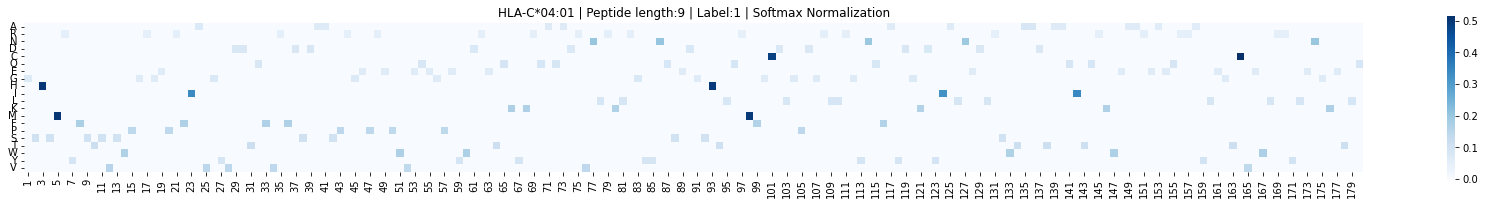



#Peptides: 192
threshold: 0.065
GSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQ

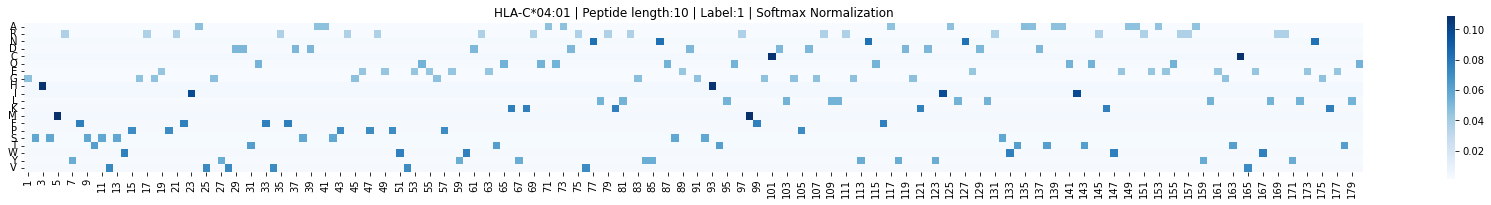



#Peptides: 53
threshold: 0.008
GSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQ

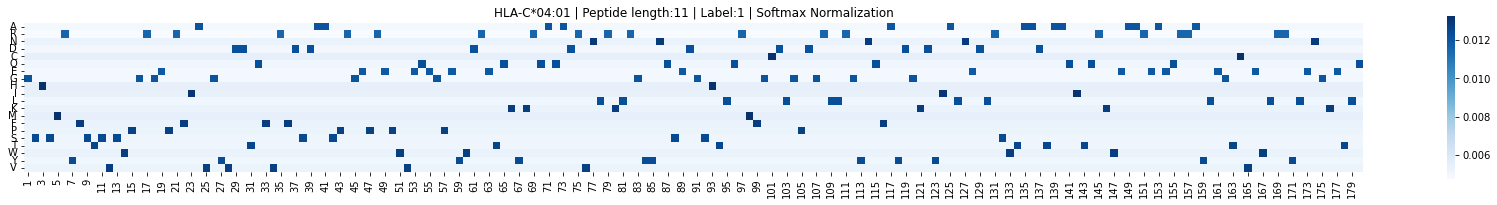



#Peptides: 18
threshold: 0.004
GSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQ

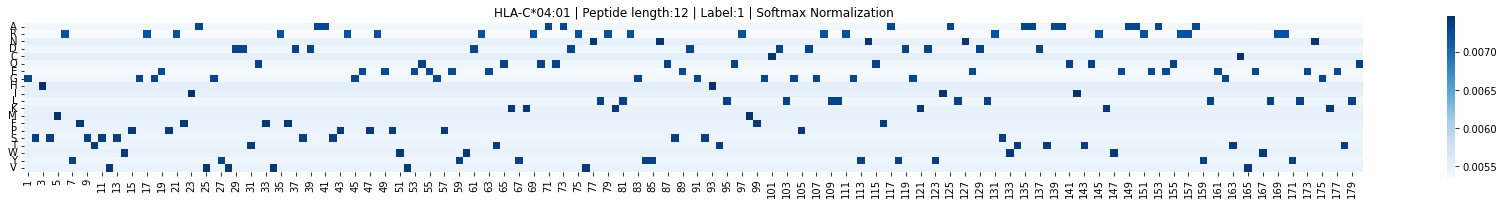



#Peptides: 16
threshold: 0.004
GSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQ

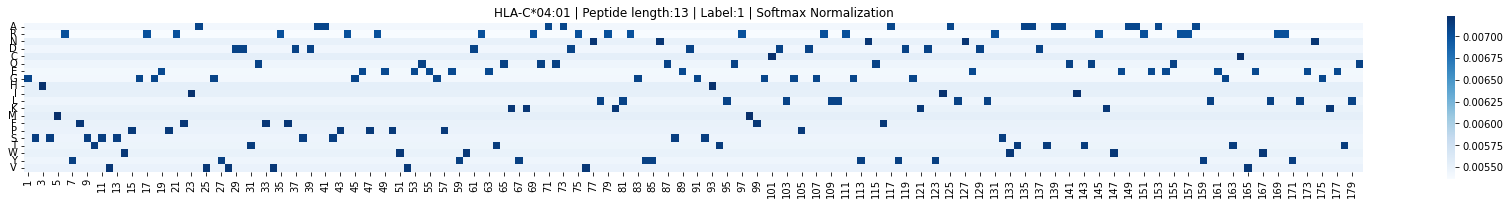



#Peptides: 16
threshold: 0.004
GSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQ

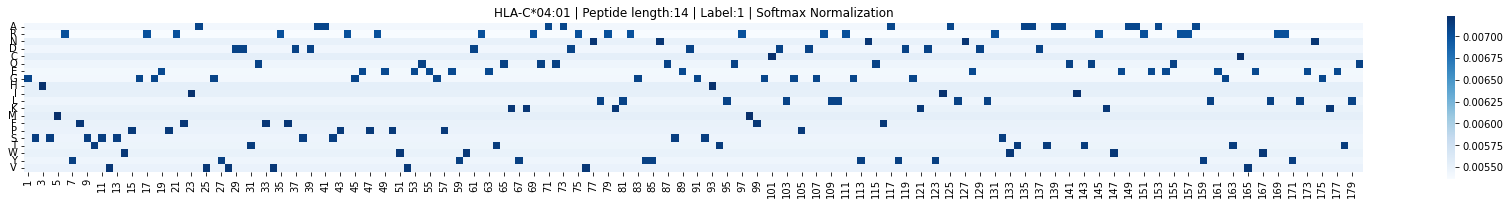

In [45]:
for peplen in list(range(8,15,1)):
    softmax_pd, unsoftmax_pd =  draw_hla_length_aatype_position_HLA(test_data.reset_index(drop=True), torch.from_numpy(np.array(enc_hla_attn_list)), hla = 'HLA-C*04:01', hlasize = 180, label = 1 , length = peplen, n_heads = 3, threshold = 0.60, show = True, softmax = True, unsoftmax = True)